### Banking Discipline and Elasticity
J M Applegate.
##### CAS543 Complexity Economics
The notebook presents basic banking discipline and elasticity dynamics.  
A set of $n$ of retail customers are served by $N$ banks.  
Banks hold reserves as a central bank according to a specified reserve requirement.  
Customer transactions take place every day, and every night the reserve accounts need to be non-negative.  
Surplus banks lend to deficit banks as requested to meet the overnight non-negative reserve requirement.  

In [1]:
# import packages
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
import random
rng = np.random.default_rng()

In [2]:
# set parameters
n = 1000 # number of retail customers
N = 10 # number of banks
steps = 888 # number of simulation runs
tau = 200 # parameter for poisson function, mean number of transactions a step
reserve_reqmt = .5 # percentage of initial retail deposits as reserves
cb_rate = .02 # central bank lending rate
bailouts_are_allowed = True
backstop_rate = .25 # central bank backstop rate
bailout_deficit_multiplier = 1.1 # multiplier on current deficit to calculate bailout amount. this is not ideal but we lack global state
premium_basis = .01 # basis for risk premium
broker_network_fraction = 1 # TODO isnʻt working as intended. fraction of banks that can be "reached" by a broker 
max_balance = 100 # upper limit for initial retail deposits

Updates: We have added a risk assessment and pricing component to the intrabank lending model. `update_net_positions` updates a risk assessment factor for each bank based on how they are positioned with respect to their reserve requirements. `get_lender_quote` is called for every lender to obtain a priced proposition for a loan to the bank in question based on the risk assessment. 

In [3]:
# define utility function

# New!
def get_lender_quote(lender, borrower, reserves, net_positions, risk_appetites, cb_rate):
    # get_lender_quote simulates a agent shopping for quotes for overnight loans
    # thus giving us a pricing mechanism based on risk preference

    risk_premium = max(premium_basis, -net_positions[borrower]) * premium_basis # always charge at least cb_rate + premium_basis
    
    # factor in the lender's risk appetite
    adjusted_premium = risk_premium * (1 - risk_appetites[lender])

    # calculate with an arbitrary upper bound of 3x the cb_rate
    quote = min(cb_rate + adjusted_premium, 3 * cb_rate)

    # display(f"Lender {lender} has a risk appetite of {risk_appetites[lender]}")
    # display(f"Borrower {borrower} has a net position of {net_positions[borrower]}")
    # display(f"The adjusted premium for lender {lender} is {adjusted_premium}")
    # display(f"The quote for lender {lender} is {quote}")

    return (quote, True)

# New!
def calculate_avg_overnight_rate(loans, rates):
    total_weighted_cost = 0
    total_loan_volume = 0
    
    # Sum up (loan * rate) for all loans
    for bank_loans, bank_rates in zip(loans, rates):
        for loan, rate in zip(bank_loans, bank_rates):
            total_weighted_cost += loan * rate
            total_loan_volume += loan
    
    # Calculate weighted average, return 0 if no loans
    if total_loan_volume > 0:
        return total_weighted_cost / total_loan_volume
    return 0

# define model functions

# New!
def update_net_positions(N, loans, rates, reserves, customers, banks, balances):
    # For all of our banks, we want to calculate how well they are keeping up with the reserve requirement
    # This is sort of a proxy for bank health in light of the fact that
    # loans in the model are simulated rather than operational.
    # Note that this could also be calculated on the spot from reserves and loans, but
    # that would be a pain in the neck. Also, maybe we would want to get more clever about
    # bank health in the future.
    
    # Initialize net positions list
    net_positions = []
    
    # Calculate required reserves for each bank
    for B in range(N):
        # Calculate total deposits for this bank
        bank_deposits = 0
        for c in range(len(customers)):
            if banks[c] == B:
                bank_deposits += balances[c]
                
        required_reserves = bank_deposits * reserve_reqmt
        
        # Calculate loan costs
        loan_principal = sum(loans[B])
        
        # Calculate interest costs
        interest_cost = 0
        for loan, rate in zip(loans[B], rates[B]):
            interest_cost += loan * rate
        
         # Calculate net position as a ratio to required reserves
        if required_reserves > 0:  # Avoid division by zero
            net_position = (reserves[B] - loan_principal - interest_cost - required_reserves) / required_reserves
        else:
            net_position = 0 # TODO not sure about conditions with no required reserves
        
        net_positions.append(net_position)
    return net_positions

# Existing!
# create reserves from retail deposit amounts
def create_reserves(N, customers, banks, balances, reserve_reqmt):
    deposits = []
    for B in range(N):
        bank_deposits = 0
        for c in customers:
            if banks[c] == B:
                bank_deposits += balances[c]
        deposits.append(bank_deposits)
    reserves = [reserve_reqmt * d for d in deposits]
    return(reserves)

# retail customers conduct transactions which are settled through aggregated central bank reserve transfers
def retail_transactions(tau, customers, banks, balances, reserves):
    transfers = rng.poisson(tau)
    originators = random.choices(customers, weights = balances, k=transfers) # originators weighted on bank balances
    #originators = random.choices(customers, k=transfers) #unwe
    percentages = rng.random(transfers).tolist()
    recipients = []
    for o in originators:
        others = [c for c in customers if c != o]
        other_balances = [b for i, b in enumerate(balances) if i != o] 
        recipient = random.choices(others, weights = other_balances)[0] # recipients weighted on bank balances
        #recipient = random.choices(others)[0]
        recipients.append(recipient)
    originating_banks = [banks[o] for o in originators]
    receiving_banks = [banks[r] for r in recipients]
    for t in range(transfers):
        amount = percentages[t] * balances[originators[t]]
        balances[recipients[t]] += amount
        balances[originators[t]] -= amount
        reserves[receiving_banks[t]] += amount
        reserves[originating_banks[t]] -= amount
    return(balances, reserves)

# surplus banks lend to deficit banks at the end of the day to ensure all reserve accounts are non-negative
def settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites):
    # in the unlikely event of a bailout...
    bailouts = []

    deficit_banks = [i for i, b in enumerate(reserves) if b < 0]
    possible_lenders = [x for x in range(N) if x not in deficit_banks]
    # Fed borrowers cannot offer quotes, so remove any possible lender with a loan from None
    possible_lenders = [x for x in possible_lenders if lenders[x] is not None]
    random.shuffle(possible_lenders)

    # in order to settle deficits, we need to get quotes from lenders
    # we simulate using a broker with "limited reach" to other banks
    # the broker will then choose the lowest quote and lend to the borrower

    broker_reach = int(N * broker_network_fraction)

    for i in deficit_banks:
        if len(possible_lenders) >= broker_reach:
            selected_lenders = random.sample(possible_lenders, broker_reach)
        else:
            selected_lenders = possible_lenders
            
        # Get quotes from each selected lender
        quotes = []
        for lender in selected_lenders:            
            quote, can_lend = get_lender_quote(
                lender, i, reserves, net_positions, 
                risk_appetites, cb_rate
            )
            if can_lend:
                quotes.append((lender, quote))
    
        # order the quotes by the quote amount
        if quotes:
            lowest_quotes_first = sorted(quotes, key=lambda x: x[1])
            j = 0
            while reserves[i] < 0 and j < len(lowest_quotes_first):
                lender = lowest_quotes_first[j][0]
                quoted_rate = lowest_quotes_first[j][1]
                if reserves[lender] >= abs(reserves[i]):
                    reserves[lender] += reserves[i]
                    display(f"Writing full loan to borrower {i} from lender {lender} for amount {abs(reserves[i])} at rate {quoted_rate}")
                    loans[i].append(abs(reserves[i]))
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] = 0
                    display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")
                elif reserves[lender] > 0:
                    display(f"Writing partial loan to borrower {i} from lender {lender} for amount {reserves[lender]} at rate {quoted_rate}")
                    loans[i].append(reserves[lender])
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] += reserves[lender]
                    reserves[lender] = 0
                    display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")                    
                    j += 1
                else:
                    display(f"Lender {lender} has no reserves to lend")
                    j += 1
        
    for i_bad in deficit_banks:
        # if we still have a deficit, we need to call the Fed
        # Fed will repay all the outstanding loans and then set the bankʻs reserves back to the recap amount
        # This will go onto the books as one loan from the fed, at the backstop rate
        # And then we will set the risk appetite to 0.01

        if reserves[i_bad] < 0:  # Removed bailouts_are_allowed check since we always need to resolve negatives
            display(f"Borrower {i_bad} needs a bailout")
            display(f"Borrower {i_bad} has {reserves[i_bad]} reserves")
            display(f"Borrower {i_bad} has {loans[i_bad]} loans")

            # First, repay all existing loans
            for idx, loan in enumerate(loans[i_bad]):
                lender = lenders[i_bad][idx]
                rate = rates[i_bad][idx]
                if lender is not None:  # if it's not already a Fed loan
                    reserves[lender] += loan * (1 + rate)  # Repay with interest

            # now reset the bank
            recap_amount = max_balance * bailout_deficit_multiplier
            display(f"Borrower {i_bad} needs a bailout of {recap_amount}")
            loans[i_bad] = [recap_amount] # REPLACE the loans, donʻt append. Fed ensures all outstanding debt is repaid.
            rates[i_bad] = [backstop_rate]
            lenders[i_bad] = [None]
            reserves[i_bad] = recap_amount
            risk_appetites[i_bad] = 0.01
            bailouts.append((i_bad, recap_amount))
            
            display(f"Fed bailout complete. Borrower {i_bad} now has {loans[i_bad]} loans and {reserves[i_bad]} reserves.")

    return(reserves, loans, rates, lenders, bailouts)

# borrowing banks repay overnight loans
def repay_loans(N, loans, rates, lenders, reserves):
    for B in range(N):
        for i, loan in enumerate(loans[B]):
            rate = rates[B][i] # stored right alongside the loans now, cb_rate baked in.
            lender = lenders[B][i]

            # if lender is  None, itʻs a fed loan
            if lender is not None: # normal interbank loan
                reserves[lender] += loan * (1 + rate)
            # but, still need to deduct from borrowing bank whether Fed or other bank
            reserves[B] -= loan * (1 + rate)

            loans[B].pop(0)
            rates[B].pop(0)
            lenders[B].pop(0)
    return(loans, rates, lenders, reserves)

In [4]:
# initialise data structures
customers = list(range(n))
banks = rng.choice(range(N), n).tolist()
balances = rng.uniform(1, max_balance, n).tolist()
loans = [[] for _ in range(N)]
rates = [[] for _ in range(N)]
lenders = [[] for _ in range(N)]
customer_history = pd.DataFrame()
bank_history = pd.DataFrame()
financial_system_history = pd.DataFrame()

# calculate reserves based on retail deposits
reserves = create_reserves(N, customers, banks, balances, reserve_reqmt)

# we should now be able to initialize our asset positions
net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

# and our risk appetites are simple enough...
risk_appetites = rng.uniform(0, 0.5, N).tolist()

# populate history arrays with initial values
customer_history['step'] = [0] * n
customer_history['id'] = customers
customer_history['balance'] = balances
bank_history['step'] = [0] * N
bank_history['id'] = list(range(N))
bank_history['reserves'] = reserves
bank_history['loans'] = [sum(l0) for l0 in loans]
bank_history['rates'] = [[] for _ in range(N)]
bank_history['net_positions'] = net_positions
bank_history['risk_appetite'] = risk_appetites
# these are vectors but only one history for the whole system. so, no "N"
financial_system_history['step'] = [0]
financial_system_history['average_net_position'] = [0]
financial_system_history['avg_daily_rate'] = [0]
financial_system_history['average_risk_appetite'] = [0]
financial_system_history['fed_recapitalization'] = [None] # 0 to many banks can be taken over by the fed each step, store as list or None

for s in range(1, steps+1):

    display(f"Step {s}")
    
    #repay overnight loans
    loans, rates, lenders, reserves = repay_loans(N, loans, rates, lenders, reserves)
            
    #conduct retail customer activity
    balances, reserves = retail_transactions(tau, customers, banks, balances, reserves)

    #settle negative reserve accounts at end of day
    # note that we pass in the customers and banks in order to deal with bailout conditions
    reserves, loans, rates, lenders, bailouts = settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites)

    #and finally update our net_positions
    net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

    # store simulation values as dataframes
    customer_step = pd.DataFrame()
    bank_step = pd.DataFrame()
    financial_system_step = pd.DataFrame()

    customer_step['step'] = [s] * n
    customer_step['id'] = customers
    customer_step['balance'] = balances

    bank_step['step'] = [s] * N
    bank_step['id'] = list(range(N))
    bank_step['reserves'] = reserves
    bank_step['loans'] = [sum(l1) for l1 in loans]

    financial_system_step['step'] = [s]
    financial_system_step['avg_daily_rate'] = [calculate_avg_overnight_rate(loans, rates)]
    financial_system_step['average_net_position'] = [sum(net_positions) / N]
    financial_system_step['average_risk_appetite'] = [sum(risk_appetites) / N]
    financial_system_step['fed_recapitalization'] = [bailouts]


    customer_history = pd.concat([customer_history, customer_step], ignore_index=True)
    bank_history = pd.concat([bank_history, bank_step], ignore_index=True)
    financial_system_history = pd.concat([financial_system_history, financial_system_step], ignore_index=True)

'Step 1'

'Step 2'

'Step 3'

'Step 4'

'Step 5'

'Step 6'

'Step 7'

'Step 8'

'Step 9'

'Step 10'

'Step 11'

'Step 12'

'Step 13'

'Step 14'

'Step 15'

'Step 16'

'Step 17'

'Step 18'

'Step 19'

'Writing full loan to borrower 1 from lender 0 for amount 322.8024205078734 at rate 0.02533656891880967'

'Lender 0 has 2742.4123915416176 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 20'

'Writing full loan to borrower 1 from lender 0 for amount 272.54686046312486 at rate 0.027606580188922453'

'Lender 0 has 4376.934026906285 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 21'

'Writing full loan to borrower 1 from lender 0 for amount 619.6125086694005 at rate 0.02725424137254899'

'Lender 0 has 412.8902444542973 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 22'

'Step 23'

'Writing full loan to borrower 1 from lender 0 for amount 300.39250699878073 at rate 0.023723766710408257'

'Lender 0 has 2231.015585454959 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 24'

'Writing full loan to borrower 1 from lender 0 for amount 559.1418075752605 at rate 0.02741563452742895'

'Lender 0 has 1323.8024638433617 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 25'

'Writing full loan to borrower 3 from lender 0 for amount 3.7615371085559657 at rate 0.020677288771964616'

'Lender 0 has 4257.374175459284 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Step 26'

'Writing full loan to borrower 1 from lender 0 for amount 348.132775404866 at rate 0.02405760060038743'

'Lender 0 has 1612.685944898824 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 261.7756885423171 at rate 0.023422544030155965'

'Lender 0 has 1350.9102563565068 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Step 27'

'Writing full loan to borrower 1 from lender 0 for amount 708.4354574285002 at rate 0.027725636345825595'

'Lender 0 has 2030.1307507197644 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 28'

'Writing full loan to borrower 1 from lender 0 for amount 1200.56907707914 at rate 0.030852058830954522'

'Lender 0 has 1193.928919392806 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 29'

'Writing full loan to borrower 1 from lender 0 for amount 893.1759799902884 at rate 0.03829658525438452'

'Lender 0 has 1856.0017313445796 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 30'

'Writing full loan to borrower 1 from lender 0 for amount 1177.753416623946 at rate 0.03286653489635444'

'Lender 0 has 2623.0241873844234 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 31'

'Writing full loan to borrower 1 from lender 0 for amount 126.19088845494522 at rate 0.03710256255205094'

'Lender 0 has 1370.7302530793652 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 32'

'Writing full loan to borrower 1 from lender 0 for amount 404.5040518437954 at rate 0.026284637550234927'

'Lender 0 has 121.28694483962249 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 33'

'Writing partial loan to borrower 1 from lender 0 for amount 61.30003921124421 at rate 0.02796463572398857'

'Lender 0 has 0 reserves remaining. Borrower 1 has -145.02820292518277 reserves remaining.'

'Writing full loan to borrower 1 from lender 3 for amount 145.02820292518277 at rate 0.02902549938394034'

'Lender 3 has 2290.3396976195327 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 34'

'Writing full loan to borrower 6 from lender 0 for amount 508.5226703504599 at rate 0.020061402076257617'

'Lender 0 has 1476.3465873838995 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 35'

'Writing full loan to borrower 1 from lender 0 for amount 360.80319391509164 at rate 0.025196317662540643'

'Lender 0 has 2219.877597904755 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 36'

'Step 37'

'Writing full loan to borrower 6 from lender 0 for amount 392.303190533973 at rate 0.024399141576849286'

'Lender 0 has 1688.0883302154134 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 38'

'Step 39'

'Writing full loan to borrower 2 from lender 0 for amount 255.49720814096585 at rate 0.02124041758980416'

'Lender 0 has 6078.562840729416 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Step 40'

'Step 41'

'Step 42'

'Writing full loan to borrower 3 from lender 0 for amount 130.53797006510837 at rate 0.02364866358625493'

'Lender 0 has 4620.874809494152 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Step 43'

'Step 44'

'Step 45'

'Writing full loan to borrower 2 from lender 0 for amount 277.05541541330456 at rate 0.020212249577570316'

'Lender 0 has 1349.002033399137 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Step 46'

'Writing full loan to borrower 9 from lender 0 for amount 493.6275862324301 at rate 0.02005639262681915'

'Lender 0 has 1220.2469365194866 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 47'

'Writing full loan to borrower 2 from lender 0 for amount 159.73156286085265 at rate 0.025375822818362613'

'Lender 0 has 769.4607580191396 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Step 48'

'Step 49'

'Writing full loan to borrower 2 from lender 0 for amount 228.29143206481731 at rate 0.02269525611404812'

'Lender 0 has 80.2255927920335 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 0 for amount 80.2255927920335 at rate 0.02005639262681915'

'Lender 0 has 0 reserves remaining. Borrower 9 has -150.17322501973493 reserves remaining.'

'Writing full loan to borrower 9 from lender 3 for amount 150.17322501973493 at rate 0.020063903941906856'

'Lender 3 has 6116.157053728873 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 50'

'Writing full loan to borrower 1 from lender 0 for amount 449.4973628443149 at rate 0.024392055894000543'

'Lender 0 has 2104.661974037768 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 51'

'Writing full loan to borrower 2 from lender 0 for amount 1338.7643165675886 at rate 0.0235465471058198'

'Lender 0 has 3551.867806475206 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 638.415551610451 at rate 0.02481788472724967'

'Lender 0 has 2913.452254864755 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 52'

'Step 53'

'Writing full loan to borrower 2 from lender 0 for amount 407.7340346016026 at rate 0.021768625146185456'

'Lender 0 has 151.8157291044363 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Step 54'

'Writing full loan to borrower 1 from lender 0 for amount 42.08952590605467 at rate 0.025165845888793833'

'Lender 0 has 3183.4842152674623 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 55'

'Writing full loan to borrower 2 from lender 0 for amount 985.4639277736529 at rate 0.021802674985652522'

'Lender 0 has 5534.190780520225 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 705.8566919397616 at rate 0.0236023576359927'

'Lender 0 has 4828.334088580464 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 56'

'Writing full loan to borrower 2 from lender 0 for amount 675.7497334350761 at rate 0.03320175041712568'

'Lender 0 has 2853.8544672191983 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 22.720833895073838 at rate 0.030175556071142053'

'Lender 0 has 2831.1336333241243 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 57'

'Writing full loan to borrower 5 from lender 0 for amount 417.72063927167267 at rate 0.02005639262681915'

'Lender 0 has 2210.1444963438485 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1371.432213049031 at rate 0.025745020407616434'

'Lender 0 has 838.7122832948176 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 58'

'Writing full loan to borrower 1 from lender 0 for amount 708.4342279281002 at rate 0.02005639262681915'

'Lender 0 has 4053.0347334069984 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 581.5911610424611 at rate 0.02005639262681915'

'Lender 0 has 3471.4435723645374 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1569.9929163965644 at rate 0.03945793219727203'

'Lender 0 has 1901.450655967973 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 59'

'Step 60'

'Writing full loan to borrower 1 from lender 0 for amount 1132.9078124336047 at rate 0.02185763552033708'

'Lender 0 has 1093.6329765285368 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 898.2451760088279 at rate 0.024968062883463503'

'Lender 0 has 195.3878005197089 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 61'

'Writing full loan to borrower 2 from lender 0 for amount 256.23295449406686 at rate 0.025475205331756758'

'Lender 0 has 2408.485870500138 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 189.5850306608191 at rate 0.021128682707071158'

'Lender 0 has 2218.900839839319 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 383.8109889183341 at rate 0.02005639262681915'

'Lender 0 has 1835.0898509209849 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 62'

'Writing full loan to borrower 2 from lender 0 for amount 95.048643292725 at rate 0.026935337065101435'

'Lender 0 has 1990.464263836634 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 902.1687578179475 at rate 0.026582269229656272'

'Lender 0 has 1088.2955060186864 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Step 63'

'Writing full loan to borrower 5 from lender 0 for amount 543.6680257111483 at rate 0.023298815325395017'

'Lender 0 has 2874.0039044576815 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 64'

'Writing full loan to borrower 6 from lender 0 for amount 287.2391798660763 at rate 0.020944329192005846'

'Lender 0 has 3287.340269093883 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 65'

'Writing full loan to borrower 1 from lender 0 for amount 1394.8479578963681 at rate 0.02128588957866427'

'Lender 0 has 2050.3639217997006 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 46.68247956140901 at rate 0.024497848623328614'

'Lender 0 has 2003.6814422382915 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 66'

'Writing full loan to borrower 1 from lender 0 for amount 825.2991227996289 at rate 0.040248111345172616'

'Lender 0 has 5679.927739895738 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 342.5680125340124 at rate 0.02030660795644796'

'Lender 0 has 5337.359727361726 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 143.80291401807654 at rate 0.025827137727360547'

'Lender 0 has 5193.55681334365 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 556.041627626271 at rate 0.022636746456926392'

'Lender 0 has 4637.515185717379 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 67'

'Writing full loan to borrower 1 from lender 0 for amount 279.9104726048385 at rate 0.031338270413411556'

'Lender 0 has 6551.183218200462 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1992.4305432946485 at rate 0.02623879425674083'

'Lender 0 has 4558.752674905813 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 68'

'Writing full loan to borrower 1 from lender 0 for amount 1969.9334528522243 at rate 0.027068775791930226'

'Lender 0 has 1625.076559395097 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 982.1819691467186 at rate 0.022349707116547348'

'Lender 0 has 642.8945902483784 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 629.7311339020613 at rate 0.02005639262681915'

'Lender 0 has 13.163456346317162 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 69'

'Writing partial loan to borrower 1 from lender 4 for amount 944.0843189042014 at rate 0.06'

'Lender 4 has 0 reserves remaining. Borrower 1 has -1082.2531894023539 reserves remaining.'

'Writing partial loan to borrower 1 from lender 6 for amount 771.3556654857623 at rate 0.06'

'Lender 6 has 0 reserves remaining. Borrower 1 has -310.8975239165916 reserves remaining.'

'Writing full loan to borrower 1 from lender 8 for amount 310.8975239165916 at rate 0.06'

'Lender 8 has 4735.006911105476 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1461.9196189105198 at rate 0.032854116433068264'

'Lender 0 has 5980.982635664656 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1622.7032242153957 at rate 0.02344187412573498'

'Lender 0 has 4358.279411449261 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 70'

'Writing full loan to borrower 1 from lender 0 for amount 1329.4585054147483 at rate 0.06'

'Lender 0 has 4536.87819374137 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 571.2081183964432 at rate 0.040955224784478786'

'Lender 0 has 3965.6700753449263 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 466.0175844154144 at rate 0.02005639262681915'

'Lender 0 has 3499.652490929512 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 71'

'Writing full loan to borrower 1 from lender 0 for amount 327.25651823113714 at rate 0.05864706552318537'

'Lender 0 has 759.843421168621 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 281.5976086397279 at rate 0.02890955359222363'

'Lender 0 has 478.2458125288931 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Step 72'

'Writing partial loan to borrower 5 from lender 0 for amount 521.4585046324665 at rate 0.023983946349625494'

'Lender 0 has 0 reserves remaining. Borrower 5 has -1380.8972302090215 reserves remaining.'

'Writing full loan to borrower 5 from lender 3 for amount 1380.8972302090215 at rate 0.024514595088874887'

'Lender 3 has 4670.645141670578 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 73'

'Writing full loan to borrower 1 from lender 0 for amount 118.6617908170461 at rate 0.02614955184073433'

'Lender 0 has 9209.617557988486 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 548.7851915627066 at rate 0.02005639262681915'

'Lender 0 has 8660.832366425779 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Step 74'

'Writing full loan to borrower 1 from lender 0 for amount 1560.0002391436085 at rate 0.026254156899756124'

'Lender 0 has 13486.131556396953 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 188.03749919804477 at rate 0.02028741952633429'

'Lender 0 has 13298.094057198909 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2121.615302941236 at rate 0.029911873433785804'

'Lender 0 has 11176.478754257672 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 646.8558709954453 at rate 0.023187238914959846'

'Lender 0 has 10529.622883262227 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 446.36314322496014 at rate 0.020627176797809683'

'Lender 0 has 10083.259740037267 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 75'

'Writing full loan to borrower 5 from lender 0 for amount 833.557805407579 at rate 0.0519210376462529'

'Lender 0 has 7160.907837111916 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 939.6289479309909 at rate 0.02932196099343722'

'Lender 0 has 6221.278889180925 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 761.0991664187663 at rate 0.028421866685566816'

'Lender 0 has 5460.179722762159 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 76'

'Writing full loan to borrower 2 from lender 0 for amount 706.9867376723985 at rate 0.02157970705560058'

'Lender 0 has 103.1432098278865 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 0 for amount 103.1432098278865 at rate 0.029959261959590415'

'Lender 0 has 0 reserves remaining. Borrower 5 has -743.8639737432152 reserves remaining.'

'Writing full loan to borrower 5 from lender 3 for amount 743.8639737432152 at rate 0.031285803368263726'

'Lender 3 has 9859.814838972188 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 6 from lender 3 for amount 710.4463916449442 at rate 0.021855896203275917'

'Lender 3 has 9149.368447327244 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 77'

'Writing full loan to borrower 1 from lender 0 for amount 1050.2289550215376 at rate 0.024424674276007044'

'Lender 0 has 2687.8694534892393 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 78'

'Writing full loan to borrower 1 from lender 0 for amount 968.3548135230358 at rate 0.034654859695434644'

'Lender 0 has 1314.2026214292364 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 110.20813918972411 at rate 0.023400997096451062'

'Lender 0 has 1203.9944822395123 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Step 79'

'Writing full loan to borrower 1 from lender 0 for amount 1100.3095460801428 at rate 0.03341391785085898'

'Lender 0 has 3112.2902691841396 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1048.568193400026 at rate 0.02444561241164847'

'Lender 0 has 2063.7220757841133 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 80'

'Writing full loan to borrower 1 from lender 0 for amount 1124.2053479513434 at rate 0.035103462243116036'

'Lender 0 has 2922.760390289362 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Step 81'

'Writing full loan to borrower 1 from lender 0 for amount 1177.580402582828 at rate 0.03523368432773756'

'Lender 0 has 5589.539375655684 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 547.0654862734368 at rate 0.02100523731809912'

'Lender 0 has 5042.473889382247 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 603.4585469589912 at rate 0.02052614904848354'

'Lender 0 has 4439.015342423256 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 82'

'Writing full loan to borrower 1 from lender 0 for amount 1046.6240538817221 at rate 0.03579374200468173'

'Lender 0 has 5878.826219232631 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 299.3945867805286 at rate 0.0283542176451307'

'Lender 0 has 5579.431632452102 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 367.8151991666525 at rate 0.022566987495142094'

'Lender 0 has 5211.61643328545 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 83'

'Step 84'

'Writing full loan to borrower 4 from lender 0 for amount 535.228890469934 at rate 0.0209356312056491'

'Lender 0 has 1388.411724223111 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 0 for amount 1388.411724223111 at rate 0.02101513711240867'

'Lender 0 has 0 reserves remaining. Borrower 5 has -425.23467352314697 reserves remaining.'

'Writing full loan to borrower 5 from lender 3 for amount 425.23467352314697 at rate 0.02115035008507221'

'Lender 3 has 6814.1131427319415 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 6 from lender 3 for amount 362.5934942797524 at rate 0.02389895630318982'

'Lender 3 has 6451.519648452189 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 8 from lender 3 for amount 41.578516023437835 at rate 0.020063903941906856'

'Lender 3 has 6409.941132428751 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 85'

'Writing full loan to borrower 1 from lender 0 for amount 1269.9409919832522 at rate 0.022117514767798403'

'Lender 0 has 9614.727412261278 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1017.4188075038533 at rate 0.028792601145582686'

'Lender 0 has 8597.308604757425 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 869.5301288763868 at rate 0.04038085329001641'

'Lender 0 has 7727.7784758810385 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1130.2074444726184 at rate 0.026947219134731124'

'Lender 0 has 6597.57103140842 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 611.1580478509013 at rate 0.025860092668981965'

'Lender 0 has 5986.412983557519 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 86'

'Writing full loan to borrower 1 from lender 0 for amount 191.8457277306035 at rate 0.03655957093682423'

'Lender 0 has 3086.205495365348 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1228.0324314936418 at rate 0.03359735491819541'

'Lender 0 has 1858.173063871706 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 841.0925349984377 at rate 0.03332457056145317'

'Lender 0 has 1017.0805288732683 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 87'

'Writing full loan to borrower 4 from lender 0 for amount 1488.2833898533925 at rate 0.03663340291539631'

'Lender 0 has 5791.882876161897 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 664.6192822983863 at rate 0.038479827509517034'

'Lender 0 has 5127.26359386351 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1932.731413666189 at rate 0.02173626264208839'

'Lender 0 has 3194.5321801973214 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 88'

'Writing full loan to borrower 5 from lender 0 for amount 1350.5885725245407 at rate 0.0354205027038139'

'Lender 0 has 4454.87546802777 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2260.0909532494593 at rate 0.05376238312545761'

'Lender 0 has 2194.7845147783105 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 89'

'Writing full loan to borrower 1 from lender 0 for amount 269.71918143059065 at rate 0.02555901937213326'

'Lender 0 has 3402.215093761617 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 847.9723887243438 at rate 0.04353198989423075'

'Lender 0 has 2554.2427050372735 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 3 for amount 746.4254208291403 at rate 0.06'

'Lender 3 has 2423.1912090392652 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 90'

'Writing full loan to borrower 5 from lender 0 for amount 1477.4160536727773 at rate 0.04786326900378522'

'Lender 0 has 680.4678804788045 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 0 for amount 680.4678804788045 at rate 0.02005639262681915'

'Lender 0 has 0 reserves remaining. Borrower 6 has -136.29894547077583 reserves remaining.'

'Writing full loan to borrower 6 from lender 3 for amount 136.29894547077583 at rate 0.020063903941906856'

'Lender 3 has 6757.336552332829 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 7 from lender 3 for amount 2152.053054110906 at rate 0.03111184792974494'

'Lender 3 has 4605.283498221923 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 91'

'Writing full loan to borrower 1 from lender 0 for amount 212.06833804302033 at rate 0.02167595281109997'

'Lender 0 has 6042.745755853472 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 498.196911557285 at rate 0.051052706398794515'

'Lender 0 has 5544.548844296187 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 375.2502891180982 at rate 0.0576869285439334'

'Lender 0 has 5169.2985551780885 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 366.7176086422101 at rate 0.02505991387732311'

'Lender 0 has 4802.580946535878 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 92'

'Writing full loan to borrower 3 from lender 0 for amount 1705.4253937633748 at rate 0.02005639262681915'

'Lender 0 has 2489.8426128044302 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1480.3387231395786 at rate 0.02005639262681915'

'Lender 0 has 1009.5038896648516 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Step 93'

'Writing full loan to borrower 3 from lender 0 for amount 1952.9937386732363 at rate 0.0443428600355774'

'Lender 0 has 4197.158971005219 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 731.2148734516268 at rate 0.02005639262681915'

'Lender 0 has 3465.9440975535927 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1935.7387686251095 at rate 0.023415399679721862'

'Lender 0 has 1530.2053289284831 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9.623136500230686 at rate 0.02005639262681915'

'Lender 0 has 1520.5821924282525 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 94'

'Writing full loan to borrower 3 from lender 0 for amount 556.7529864397977 at rate 0.05316685117441752'

'Lender 0 has 7367.607749069227 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 857.917494954524 at rate 0.028636197020724233'

'Lender 0 has 6509.690254114703 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1756.5926488197879 at rate 0.038909490631035853'

'Lender 0 has 4753.097605294915 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1297.051290219312 at rate 0.025676019939101877'

'Lender 0 has 3456.046315075603 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 761.4885618878552 at rate 0.02005639262681915'

'Lender 0 has 2694.557753187748 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 95'

'Writing full loan to borrower 3 from lender 0 for amount 1035.8542874517345 at rate 0.028491627760485083'

'Lender 0 has 11379.458947311601 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2429.4802810440497 at rate 0.029332480295981428'

'Lender 0 has 8949.97866626755 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2696.3555205324283 at rate 0.03642566307630842'

'Lender 0 has 6253.623145735122 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 608.4060131129742 at rate 0.0343388442447807'

'Lender 0 has 5645.217132622148 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 96'

'Writing full loan to borrower 1 from lender 0 for amount 1641.7708946148005 at rate 0.02264489495779188'

'Lender 0 has 7010.764220063985 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2242.887439389411 at rate 0.050208243676944694'

'Lender 0 has 4767.876780674574 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3109.8442467100135 at rate 0.05603954349568373'

'Lender 0 has 1658.0325339645601 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1137.750331316476 at rate 0.028540155160995517'

'Lender 0 has 520.2822026480842 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 97'

'Writing full loan to borrower 1 from lender 0 for amount 1277.8970916168917 at rate 0.0442886794706885'

'Lender 0 has 6326.428005220927 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2071.2281578158227 at rate 0.04453660728371782'

'Lender 0 has 4255.199847405104 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 98'

'Writing full loan to borrower 1 from lender 0 for amount 1709.549807249034 at rate 0.036265417723906845'

'Lender 0 has 11800.897590063945 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 534.0948377374291 at rate 0.023279875833075857'

'Lender 0 has 11266.802752326515 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1553.6146608437562 at rate 0.04007669569010554'

'Lender 0 has 9713.18809148276 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 99'

'Writing full loan to borrower 1 from lender 0 for amount 2021.036313749284 at rate 0.04482603340359'

'Lender 0 has 5712.549694119748 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1809.3753673484255 at rate 0.03356317705583832'

'Lender 0 has 3903.1743267713227 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2334.695250717303 at rate 0.022225953510408812'

'Lender 0 has 1568.4790760540195 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 100'

'Writing full loan to borrower 1 from lender 0 for amount 403.081976583586 at rate 0.0557147680735821'

'Lender 0 has 6101.067566475536 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 272.9037359201655 at rate 0.03565223818166348'

'Lender 0 has 5828.163830555371 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 4 for amount 2552.24588287884 at rate 0.06'

'Lender 4 has 2901.246635777315 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1160.2905916615966 at rate 0.02005639262681915'

'Lender 0 has 4667.873238893774 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 101'

'Writing full loan to borrower 4 from lender 0 for amount 1107.3092382849393 at rate 0.021604078872726144'

'Lender 0 has 1893.290940755135 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 0 for amount 1893.290940755135 at rate 0.02649994661690598'

'Lender 0 has 0 reserves remaining. Borrower 5 has -48.4315450479653 reserves remaining.'

'Writing full loan to borrower 5 from lender 3 for amount 48.4315450479653 at rate 0.02736571843578947'

'Lender 3 has 3131.6387222078897 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 2 for amount 1024.7580452978054 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 7 has -1307.9903492878125 reserves remaining.'

'Writing full loan to borrower 7 from lender 1 for amount 1307.9903492878125 at rate 0.06'

'Lender 1 has 4048.38038645035 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 102'

'Writing full loan to borrower 5 from lender 0 for amount 3101.1815900835313 at rate 0.03663447629204751'

'Lender 0 has 2581.611966083427 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1233.9162385473846 at rate 0.02005639262681915'

'Lender 0 has 1347.6957275360423 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1250.2926248128485 at rate 0.054075913775968806'

'Lender 0 has 97.4031027231938 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 103'

'Writing full loan to borrower 3 from lender 0 for amount 260.9849905101044 at rate 0.024402898819543883'

'Lender 0 has 2227.039426262548 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 553.1013840978791 at rate 0.02460911022184125'

'Lender 0 has 1673.9380421646692 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 648.7410385068629 at rate 0.02005639262681915'

'Lender 0 has 1025.1970036578064 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 104'

'Writing full loan to borrower 3 from lender 0 for amount 868.4503864444799 at rate 0.02676251403221402'

'Lender 0 has 9713.701843711842 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 772.6235371096941 at rate 0.02887832619634041'

'Lender 0 has 8941.078306602149 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1081.7606684826783 at rate 0.026447563134950405'

'Lender 0 has 7859.31763811947 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 605.786229628196 at rate 0.027028033495417072'

'Lender 0 has 7253.531408491273 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 105'

'Writing full loan to borrower 4 from lender 0 for amount 1225.7549343285675 at rate 0.030712078196215884'

'Lender 0 has 3839.5818544225012 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Step 106'

'Writing full loan to borrower 5 from lender 0 for amount 2597.4224483388957 at rate 0.02352140054028705'

'Lender 0 has 986.8033285577744 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 570.2302039268882 at rate 0.02005639262681915'

'Lender 0 has 416.57312463088624 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 107'

'Writing full loan to borrower 3 from lender 0 for amount 980.4276534893609 at rate 0.024529642068708345'

'Lender 0 has 4718.4067151348645 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 328.1156288317913 at rate 0.023538823848594254'

'Lender 0 has 4390.291086303073 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 654.6243181541979 at rate 0.029255277784162245'

'Lender 0 has 3735.6667681488752 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 108'

'Writing full loan to borrower 6 from lender 0 for amount 2516.371370484532 at rate 0.02005639262681915'

'Lender 0 has 6637.3083015073535 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1564.7470859916061 at rate 0.020161940460042074'

'Lender 0 has 5072.561215515747 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 746.3205509846907 at rate 0.030003380498056398'

'Lender 0 has 4326.240664531057 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 109'

'Writing full loan to borrower 5 from lender 0 for amount 1215.146240797233 at rate 0.02415295387624855'

'Lender 0 has 11893.610146493873 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1194.4218692996942 at rate 0.044760773301758136'

'Lender 0 has 10699.188277194178 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 110'

'Writing full loan to borrower 2 from lender 0 for amount 568.3279760126403 at rate 0.02005639262681915'

'Lender 0 has 7332.546614723656 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Step 111'

'Writing full loan to borrower 1 from lender 0 for amount 1636.6348484767386 at rate 0.02005639262681915'

'Lender 0 has 3806.300808150545 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2202.6800611166195 at rate 0.024254896566609094'

'Lender 0 has 1603.6207470339255 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 0 for amount 1603.6207470339255 at rate 0.023613776342354405'

'Lender 0 has 0 reserves remaining. Borrower 6 has -667.0030202359362 reserves remaining.'

'Writing full loan to borrower 6 from lender 3 for amount 667.0030202359362 at rate 0.024095119636593273'

'Lender 3 has 3128.804206840026 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 112'

'Writing full loan to borrower 1 from lender 0 for amount 1668.5803899765688 at rate 0.041189517013539845'

'Lender 0 has 7084.873097088412 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 740.9390369961878 at rate 0.02044594417179989'

'Lender 0 has 6343.934060092224 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1313.268351681606 at rate 0.03794497530038364'

'Lender 0 has 5030.665708410618 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2489.9609918609135 at rate 0.02005639262681915'

'Lender 0 has 2540.7047165497047 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 113'

'Writing full loan to borrower 1 from lender 0 for amount 578.4910229721634 at rate 0.04180975066063908'

'Lender 0 has 9392.53066216366 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1430.4256443913225 at rate 0.0203424478245704'

'Lender 0 has 7962.105017772336 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1380.3065504601227 at rate 0.030745771372983066'

'Lender 0 has 6581.798467312214 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 114'

'Writing full loan to borrower 1 from lender 0 for amount 158.17603190696462 at rate 0.028506664722131463'

'Lender 0 has 5206.746946480106 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 548.461055428078 at rate 0.03962172533760769'

'Lender 0 has 4658.285891052028 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 798.0603807391591 at rate 0.030999852430432656'

'Lender 0 has 3860.225510312869 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1112.1914982644994 at rate 0.023409649004389098'

'Lender 0 has 2748.0340120483697 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 115'

'Writing full loan to borrower 4 from lender 0 for amount 930.768178401688 at rate 0.028718701427741963'

'Lender 0 has 3260.1181407314048 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 937.6629253481957 at rate 0.028204137632039848'

'Lender 0 has 2322.455215383209 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 650.5734831062302 at rate 0.02981262641802438'

'Lender 0 has 1671.881732276979 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 994.6058417146567 at rate 0.02168932729902669'

'Lender 0 has 677.2758905623223 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 116'

'Writing full loan to borrower 1 from lender 0 for amount 247.12002880488274 at rate 0.02005639262681915'

'Lender 0 has 6473.81404915483 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7.203906097520985 at rate 0.031889626124663055'

'Lender 0 has 6466.610143057309 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1933.0287723366932 at rate 0.02775959403227444'

'Lender 0 has 4533.581370720616 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 117'

'Writing full loan to borrower 1 from lender 0 for amount 741.9472881320547 at rate 0.02668043837126435'

'Lender 0 has 7975.8837581905755 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 409.5148612276722 at rate 0.022365136133122444'

'Lender 0 has 7566.368896962903 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 118'

'Writing full loan to borrower 1 from lender 0 for amount 12.09353367161384 at rate 0.029473406985945284'

'Lender 0 has 11468.034928233195 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2431.703126365541 at rate 0.02142926854165149'

'Lender 0 has 9036.331801867655 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1732.3129470428394 at rate 0.02711057436076187'

'Lender 0 has 7304.018854824815 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 307.7369102551819 at rate 0.02005639262681915'

'Lender 0 has 6996.281944569633 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 119'

'Writing full loan to borrower 5 from lender 0 for amount 333.49790114448393 at rate 0.022098825144854853'

'Lender 0 has 7393.31943965671 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1340.8005633566383 at rate 0.04073578463594804'

'Lender 0 has 6052.5188763000715 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 120'

'Writing full loan to borrower 5 from lender 0 for amount 1651.529214697613 at rate 0.02656926464569386'

'Lender 0 has 4253.904108836867 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1288.4555688694534 at rate 0.024245004591334253'

'Lender 0 has 2965.448539967413 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 121'

'Writing full loan to borrower 5 from lender 0 for amount 785.4196089761525 at rate 0.03241236029704621'

'Lender 0 has 4675.632898636321 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1694.8419495839998 at rate 0.041438320894879144'

'Lender 0 has 2980.7909490523216 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 122'

'Writing full loan to borrower 1 from lender 0 for amount 1201.1273004664884 at rate 0.02005639262681915'

'Lender 0 has 3604.4527532174607 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1616.1699909419021 at rate 0.02181822969963729'

'Lender 0 has 1988.2827622755585 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 0 for amount 1988.2827622755585 at rate 0.022056833640263816'

'Lender 0 has 0 reserves remaining. Borrower 6 has -791.4156546705553 reserves remaining.'

'Writing full loan to borrower 6 from lender 3 for amount 791.4156546705553 at rate 0.022330797213632302'

'Lender 3 has 6947.603299401615 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 9 for amount 300.94400406887826 at rate 0.06'

'Lender 9 has 6283.270826177055 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 123'

'Writing full loan to borrower 6 from lender 0 for amount 2696.618202679124 at rate 0.04548895177192809'

'Lender 0 has 1543.2179740506763 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 475.8239815073874 at rate 0.023361526796443374'

'Lender 0 has 1067.393992543289 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 251.3078927664818 at rate 0.027410667046290395'

'Lender 0 has 816.0860997768071 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 124'

'Writing full loan to borrower 6 from lender 3 for amount 288.261643726525 at rate 0.06'

'Lender 3 has 5054.758239368391 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1225.3763770737614 at rate 0.027026778471672425'

'Lender 0 has 2384.5018816125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 125'

'Writing full loan to borrower 5 from lender 0 for amount 1327.336196754989 at rate 0.022365921766667716'

'Lender 0 has 4202.16204689654 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 952.2696233907533 at rate 0.049602737515469425'

'Lender 0 has 3249.892423505787 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1419.5857027824227 at rate 0.024793019075675563'

'Lender 0 has 1830.3067207233644 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1244.3204583909715 at rate 0.03818265380640053'

'Lender 0 has 585.9862623323929 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 126'

'Writing full loan to borrower 1 from lender 0 for amount 632.8210665620159 at rate 0.02005639262681915'

'Lender 0 has 3033.0613190662943 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1281.1297571381306 at rate 0.03004918986204585'

'Lender 0 has 1751.9315619281638 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1226.1462371207804 at rate 0.032878320911474856'

'Lender 0 has 525.7853248073834 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 348.7973340238294 at rate 0.03835564761235055'

'Lender 0 has 176.98799078355398 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 127'

'Writing full loan to borrower 4 from lender 0 for amount 8.829049681895125 at rate 0.020476762036471592'

'Lender 0 has 6222.471164427899 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1120.7068560278756 at rate 0.02216912271140934'

'Lender 0 has 5101.764308400023 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 128'

'Writing full loan to borrower 6 from lender 0 for amount 2100.0421661450077 at rate 0.025965065943214787'

'Lender 0 has 5718.758901485171 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1321.970159628918 at rate 0.023167849696722684'

'Lender 0 has 4396.788741856253 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 850.6247531243146 at rate 0.03542526962908095'

'Lender 0 has 3546.163988731939 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 129'

'Writing full loan to borrower 4 from lender 0 for amount 1270.6872635027448 at rate 0.02135347028235443'

'Lender 0 has 5178.484539408451 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2362.838411170765 at rate 0.03189223283338438'

'Lender 0 has 2815.6461282376863 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 130'

'Writing full loan to borrower 1 from lender 0 for amount 274.9887810074 at rate 0.021208920189790304'

'Lender 0 has 6507.192559647703 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1066.8543927843361 at rate 0.035732346781691765'

'Lender 0 has 5440.3381668633665 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Step 131'

'Writing full loan to borrower 2 from lender 0 for amount 1175.5674469772468 at rate 0.02005639262681915'

'Lender 0 has 3125.640275897541 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1057.9528181932037 at rate 0.02005639262681915'

'Lender 0 has 2067.6874577043372 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 0 for amount 2067.6874577043372 at rate 0.022313696011228384'

'Lender 0 has 0 reserves remaining. Borrower 6 has -659.5032656149083 reserves remaining.'

'Writing full loan to borrower 6 from lender 8 for amount 659.5032656149083 at rate 0.022746555248207297'

'Lender 8 has 3555.505753199732 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 7 from lender 8 for amount 3122.062154357858 at rate 0.021267975621331495'

'Lender 8 has 433.44359884187406 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 132'

'Writing full loan to borrower 6 from lender 0 for amount 145.39606311208098 at rate 0.04129580650434153'

'Lender 0 has 4542.560778880881 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 9 for amount 186.2127322778054 at rate 0.06'

'Lender 9 has 305.2808862009259 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1927.5448392888795 at rate 0.024905896665388116'

'Lender 0 has 2615.015939592002 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 133'

'Writing full loan to borrower 5 from lender 0 for amount 834.6571951938693 at rate 0.020907395334399607'

'Lender 0 has 6049.620414044233 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1711.8285272774988 at rate 0.02623326437075965'

'Lender 0 has 4337.791886766734 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 600.5520541952786 at rate 0.024486733514294652'

'Lender 0 has 3737.2398325714553 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 134'

'Writing full loan to borrower 5 from lender 0 for amount 3566.925199081989 at rate 0.028209550596365346'

'Lender 0 has 1472.2136811655068 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 0 for amount 1472.2136811655068 at rate 0.0345107144937289'

'Lender 0 has 0 reserves remaining. Borrower 7 has -551.3049234634402 reserves remaining.'

'Writing full loan to borrower 7 from lender 3 for amount 551.3049234634402 at rate 0.03644349462577785'

'Lender 3 has 1012.1922574480377 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 135'

'Writing full loan to borrower 6 from lender 0 for amount 1474.2303598187846 at rate 0.02005639262681915'

'Lender 0 has 4199.696854748893 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 514.8879489197564 at rate 0.020222866687927894'

'Lender 0 has 3684.808905829137 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 136'

'Writing full loan to borrower 3 from lender 0 for amount 435.71976889531777 at rate 0.02071359608323603'

'Lender 0 has 4912.448307135694 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2129.825580011442 at rate 0.030734476415298938'

'Lender 0 has 2782.6227271242524 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 131.04335780517215 at rate 0.028624561460246625'

'Lender 0 has 2651.5793693190803 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 137'

'Writing full loan to borrower 3 from lender 0 for amount 157.5524774794721 at rate 0.02762295612844053'

'Lender 0 has 7650.612245012535 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 965.4419908677879 at rate 0.02283852307409676'

'Lender 0 has 6685.170254144747 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3125.354091263275 at rate 0.03480028276963873'

'Lender 0 has 3559.8161628814714 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 138'

'Writing full loan to borrower 5 from lender 0 for amount 3307.566026371415 at rate 0.028628082032814965'

'Lender 0 has 4985.802009575524 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2205.4808837512846 at rate 0.04621652484296766'

'Lender 0 has 2780.321125824239 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 483.0959409419713 at rate 0.021589488917811248'

'Lender 0 has 2297.225184882268 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1164.029323484263 at rate 0.025431172946173995'

'Lender 0 has 1133.195861398005 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 139'

'Writing full loan to borrower 2 from lender 0 for amount 725.5849746411302 at rate 0.02005639262681915'

'Lender 0 has 5811.801121064623 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 494.9826006823679 at rate 0.027194980742306002'

'Lender 0 has 5316.818520382255 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1989.3269318225555 at rate 0.02005639262681915'

'Lender 0 has 3327.4915885596993 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 140'

'Writing full loan to borrower 6 from lender 0 for amount 899.2272571552721 at rate 0.02005639262681915'

'Lender 0 has 11618.585312572486 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 59.73651518186921 at rate 0.027242658636983892'

'Lender 0 has 11558.848797390618 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 209.89158460999911 at rate 0.02005639262681915'

'Lender 0 has 11348.957212780619 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 1944.192033481673 at rate 0.06'

'Lender 2 has 529.2768688560084 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 141'

'Writing full loan to borrower 5 from lender 0 for amount 3976.2318619910197 at rate 0.024923928927198566'

'Lender 0 has 1880.1948630677957 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1324.3198759726442 at rate 0.028096910389862756'

'Lender 0 has 555.8749870951515 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 0 for amount 555.8749870951515 at rate 0.02581120408117505'

'Lender 0 has 0 reserves remaining. Borrower 7 has -1299.335303921865 reserves remaining.'

'Writing full loan to borrower 7 from lender 3 for amount 1299.335303921865 at rate 0.026585237626954687'

'Lender 3 has 9172.953161243802 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 2160.724728249069 at rate 0.06'

'Lender 1 has 1781.8591773995136 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 142'

'Writing full loan to borrower 1 from lender 0 for amount 813.5854790271017 at rate 0.022763386249842383'

'Lender 0 has 9401.219576041829 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1801.8904146087355 at rate 0.029677773269091733'

'Lender 0 has 7599.329161433094 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 318.350296886242 at rate 0.0352637758791699'

'Lender 0 has 7280.978864546852 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2246.261775045968 at rate 0.06'

'Lender 0 has 5034.717089500884 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 143'

'Writing full loan to borrower 1 from lender 0 for amount 2002.4702444942284 at rate 0.030103535527377046'

'Lender 0 has 12365.625083517312 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1389.2297546474088 at rate 0.02469122296769679'

'Lender 0 has 10976.395328869903 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3733.8652859031445 at rate 0.03186339821652769'

'Lender 0 has 7242.530042966759 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2472.3474876365112 at rate 0.06'

'Lender 0 has 4770.182555330248 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 144'

'Writing full loan to borrower 1 from lender 0 for amount 1532.2058549215046 at rate 0.050605138430866135'

'Lender 0 has 6994.3434929643 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3552.1607659913057 at rate 0.02283221485216286'

'Lender 0 has 3442.1827269729943 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 0 for amount 3442.1827269729943 at rate 0.054930201431925924'

'Lender 0 has 0 reserves remaining. Borrower 6 has -40.377073765710065 reserves remaining.'

'Writing full loan to borrower 6 from lender 3 for amount 40.377073765710065 at rate 0.05958279103151258'

'Lender 3 has 12262.914323382374 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 7 from lender 3 for amount 644.4185768530123 at rate 0.02741214618337892'

'Lender 3 has 11618.495746529363 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 2620.688336894702 at rate 0.06'

'Lender 2 has 9570.853158258818 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 145'

'Writing full loan to borrower 5 from lender 0 for amount 2916.946900601204 at rate 0.05587024019574756'

'Lender 0 has 4767.911318587319 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2794.7326790674706 at rate 0.04799191074566786'

'Lender 0 has 1973.1786395198487 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1644.8295488754588 at rate 0.02777142097227322'

'Lender 0 has 328.3490906443899 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing partial loan to borrower 8 from lender 0 for amount 328.3490906443899 at rate 0.02005639262681915'

'Lender 0 has 0 reserves remaining. Borrower 8 has -761.2767409074238 reserves remaining.'

'Writing full loan to borrower 8 from lender 3 for amount 761.2767409074238 at rate 0.020063903941906856'

'Lender 3 has 9751.534820122803 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 9 from lender 2 for amount 2774.695147554473 at rate 0.06'

'Lender 2 has 755.1885516810867 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 146'

'Writing full loan to borrower 4 from lender 0 for amount 679.5181608667765 at rate 0.02005639262681915'

'Lender 0 has 11135.373232534881 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1224.2044830308491 at rate 0.042405725125852986'

'Lender 0 has 9911.168749504031 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 8 for amount 1989.5452423870647 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 9 has -865.4874054135366 reserves remaining.'

'Writing full loan to borrower 9 from lender 6 for amount 865.4874054135366 at rate 0.06'

'Lender 6 has 1103.7268227425707 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 147'

'Writing full loan to borrower 5 from lender 0 for amount 1478.9328176211816 at rate 0.029303843709114034'

'Lender 0 has 14661.032957074522 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1542.9206040825618 at rate 0.030016815977151445'

'Lender 0 has 13118.11235299196 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2401.7346701860724 at rate 0.024356226187002877'

'Lender 0 has 10716.377682805887 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 17.174255958373095 at rate 0.02801521682832932'

'Lender 0 has 10699.203426847514 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 3 for amount 886.3805025928875 at rate 0.06'

'Lender 3 has 9732.308828935455 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 148'

'Writing full loan to borrower 2 from lender 0 for amount 517.0214660772842 at rate 0.02159263234982873'

'Lender 0 has 13557.276949633599 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1500.6133547127401 at rate 0.02246178486301006'

'Lender 0 has 12056.663594920858 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1821.5980081470161 at rate 0.029235212001242197'

'Lender 0 has 10235.065586773842 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 149'

'Writing full loan to borrower 1 from lender 0 for amount 2054.3475713391003 at rate 0.02005639262681915'

'Lender 0 has 8776.559097262394 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1143.8517696656004 at rate 0.0386161902505066'

'Lender 0 has 7632.707327596794 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1138.5101764698948 at rate 0.026287407228111872'

'Lender 0 has 6494.197151126899 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 150'

'Writing full loan to borrower 5 from lender 0 for amount 1388.2635486376846 at rate 0.024420683318871213'

'Lender 0 has 7097.49072329403 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2210.3131503965888 at rate 0.021390477963051446'

'Lender 0 has 4887.177572897442 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10.973756585049841 at rate 0.030926098725033345'

'Lender 0 has 4876.203816312392 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 151'

'Writing full loan to borrower 5 from lender 0 for amount 3754.644893907744 at rate 0.02979606907207952'

'Lender 0 has 3516.4373536930066 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 236.37341223227213 at rate 0.0202971627289144'

'Lender 0 has 3280.0639414607344 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2983.4878363724606 at rate 0.03801051391232614'

'Lender 0 has 296.57610508827383 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing partial loan to borrower 8 from lender 0 for amount 296.57610508827383 at rate 0.02487389341199'

'Lender 0 has 0 reserves remaining. Borrower 8 has -741.4902156756407 reserves remaining.'

'Writing full loan to borrower 8 from lender 3 for amount 741.4902156756407 at rate 0.025523080215058152'

'Lender 3 has 1411.6108375240028 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 152'

'Writing full loan to borrower 6 from lender 0 for amount 3340.69862734532 at rate 0.026136234534311763'

'Lender 0 has 4273.826394316253 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1325.151353105257 at rate 0.051856066529425385'

'Lender 0 has 2948.675041210996 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 89.1798643745164 at rate 0.03475919842400732'

'Lender 0 has 2859.4951768364795 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 153'

'Writing full loan to borrower 6 from lender 0 for amount 3229.3208743086857 at rate 0.04192710052294272'

'Lender 0 has 6122.464127350284 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3148.261849594431 at rate 0.03070389857778034'

'Lender 0 has 2974.2022777558527 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 886.0923508822859 at rate 0.023748700508949016'

'Lender 0 has 2088.109926873567 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 154'

'Writing full loan to borrower 5 from lender 0 for amount 1307.8811875714787 at rate 0.023438983532840366'

'Lender 0 has 11091.83035253438 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3200.5055267665616 at rate 0.05275617686874215'

'Lender 0 has 7891.324825767819 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1322.8967733563472 at rate 0.023981407732482623'

'Lender 0 has 6568.428052411471 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 155'

'Writing full loan to borrower 4 from lender 0 for amount 653.2959436647727 at rate 0.022921220822372378'

'Lender 0 has 12991.37530163168 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1268.9137450203957 at rate 0.024472262868574814'

'Lender 0 has 11722.461556611284 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3514.4047369028767 at rate 0.05289878537144038'

'Lender 0 has 8208.056819708407 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 156'

'Writing full loan to borrower 1 from lender 0 for amount 294.6859751793856 at rate 0.020674816183618758'

'Lender 0 has 13938.889772834069 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2066.8610445339896 at rate 0.028976175902074255'

'Lender 0 has 11872.02872830008 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3354.519227093444 at rate 0.02119906868457304'

'Lender 0 has 8517.509501206636 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 222.24534935275665 at rate 0.02878000984470538'

'Lender 0 has 8295.264151853879 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2113.0059649097825 at rate 0.05905314207141084'

'Lender 0 has 6182.258186944096 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 157'

'Writing full loan to borrower 6 from lender 0 for amount 1035.4957901957691 at rate 0.026088055646158917'

'Lender 0 has 11647.795645826576 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1862.4491266765608 at rate 0.03453776721004434'

'Lender 0 has 9785.346519150015 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 158'

'Writing full loan to borrower 1 from lender 0 for amount 1650.037630035421 at rate 0.02005639262681915'

'Lender 0 has 12953.051792669485 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1960.6242113399726 at rate 0.02509081067753601'

'Lender 0 has 10992.427581329512 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1913.919226501283 at rate 0.032405625613229995'

'Lender 0 has 9078.50835482823 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 159'

'Writing full loan to borrower 3 from lender 0 for amount 1004.0095128767833 at rate 0.02005639262681915'

'Lender 0 has 10893.11049316789 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 581.5592246369067 at rate 0.024468148056619534'

'Lender 0 has 10311.551268530982 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 57.80061061407014 at rate 0.03205364545803604'

'Lender 0 has 10253.750657916913 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3918.367236764702 at rate 0.022473605881990443'

'Lender 0 has 6335.383421152212 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 208.31762197033504 at rate 0.02005639262681915'

'Lender 0 has 6127.065799181877 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 160'

'Writing full loan to borrower 5 from lender 0 for amount 3865.16607617848 at rate 0.025761904289673163'

'Lender 0 has 13317.022325208753 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4607.988277746173 at rate 0.04732986393525397'

'Lender 0 has 8709.034047462581 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 846.4228366781559 at rate 0.02632910950364651'

'Lender 0 has 7862.611210784425 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 161'

'Writing full loan to borrower 1 from lender 0 for amount 1816.2239598714705 at rate 0.023353331523587966'

'Lender 0 has 13808.063385944599 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 149.79594383716307 at rate 0.021830282159037047'

'Lender 0 has 13658.267442107435 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5061.217460477925 at rate 0.05224978700982509'

'Lender 0 has 8597.04998162951 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5283.257623601516 at rate 0.06'

'Lender 0 has 3313.792358027995 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 0 for amount 3313.792358027995 at rate 0.025402918638596315'

'Lender 0 has 0 reserves remaining. Borrower 7 has -550.2294501455335 reserves remaining.'

'Writing full loan to borrower 7 from lender 3 for amount 550.2294501455335 at rate 0.026122569886938975'

'Lender 3 has 8406.445045795968 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 162'

'Writing full loan to borrower 1 from lender 0 for amount 981.8170595927968 at rate 0.041326173661289746'

'Lender 0 has 16262.765140835823 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 8 for amount 1574.514958163747 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 5 has -2961.556583294114 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2961.556583294114 at rate 0.06'

'Lender 0 has 13301.20855754171 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 6 from lender 0 for amount 4242.660601031414 at rate 0.06'

'Lender 0 has 9058.547956510294 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Step 163'

'Writing full loan to borrower 1 from lender 0 for amount 441.6074014776494 at rate 0.030849539371459275'

'Lender 0 has 17449.47567212405 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4184.832976953413 at rate 0.046932325203890374'

'Lender 0 has 13264.642695170634 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3594.6337906346403 at rate 0.02005639262681915'

'Lender 0 has 9670.008904535995 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 925.3679554779937 at rate 0.023044934346451836'

'Lender 0 has 8744.640949058 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 164'

'Writing full loan to borrower 1 from lender 0 for amount 2334.0631120700514 at rate 0.027476940154071223'

'Lender 0 has 12960.394757883607 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1501.6944220523385 at rate 0.02005639262681915'

'Lender 0 has 11458.700335831269 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5704.255905612927 at rate 0.029101800639186368'

'Lender 0 has 5754.444430218342 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2778.3415006924274 at rate 0.04990364485088124'

'Lender 0 has 2976.1029295259145 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 165'

'Writing full loan to borrower 1 from lender 0 for amount 1358.5236609484255 at rate 0.05519706869246459'

'Lender 0 has 13052.234643154876 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 4 for amount 5417.830323155719 at rate 0.06'

'Lender 4 has 2501.761347035538 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2220.6354701924356 at rate 0.02374770829043187'

'Lender 0 has 10831.59917296244 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3497.734391737325 at rate 0.038328243833511785'

'Lender 0 has 7333.864781225115 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 166'

'Writing full loan to borrower 1 from lender 0 for amount 1625.4654847552379 at rate 0.03391027502284487'

'Lender 0 has 12104.841212469062 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 572.5139715011749 at rate 0.023063401356109584'

'Lender 0 has 11532.327240967887 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 2 for amount 5599.916311287382 at rate 0.06'

'Lender 2 has 1729.5628239039297 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1850.8608882071198 at rate 0.04599770039505105'

'Lender 0 has 9681.466352760766 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 167'

'Writing full loan to borrower 1 from lender 0 for amount 1483.445444470822 at rate 0.03639171747427966'

'Lender 0 has 19072.1649901995 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 8 for amount 1283.8433221416906 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 5 has -3650.3087407063886 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3650.3087407063886 at rate 0.06'

'Lender 0 has 15421.856249493112 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3810.3602798729526 at rate 0.02005639262681915'

'Lender 0 has 11611.495969620159 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3694.681958218506 at rate 0.0313960559076623'

'Lender 0 has 7916.814011401652 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 168'

'Writing full loan to borrower 4 from lender 0 for amount 1218.7805340000054 at rate 0.02152210305418991'

'Lender 0 has 14592.859223147634 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2454.1241830599433 at rate 0.05407216406316552'

'Lender 0 has 12138.735040087691 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5334.091860962299 at rate 0.03885083162288404'

'Lender 0 has 6804.643179125393 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4967.979139029901 at rate 0.046766815189725114'

'Lender 0 has 1836.664040095492 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 169'

'Writing partial loan to borrower 5 from lender 4 for amount 1858.3347157384846 at rate 0.06'

'Lender 4 has 0 reserves remaining. Borrower 5 has -1893.1972228269165 reserves remaining.'

'Writing partial loan to borrower 5 from lender 6 for amount 444.968616660353 at rate 0.06'

'Lender 6 has 0 reserves remaining. Borrower 5 has -1448.2286061665634 reserves remaining.'

'Writing partial loan to borrower 5 from lender 1 for amount 202.42669185835135 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 5 has -1245.801914308212 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1245.801914308212 at rate 0.06'

'Lender 0 has 9247.224251624732 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 6 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 5270.647709732162 at rate 0.06'

'Lender 0 has 3976.5765418925694 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 170'

'Writing full loan to borrower 4 from lender 0 for amount 846.4077855912489 at rate 0.025639262681915263'

'Lender 0 has 15975.63908850423 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2573.241893137284 at rate 0.06'

'Lender 0 has 13402.397195366946 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4568.723900821277 at rate 0.025639262681915263'

'Lender 0 has 8833.673294545668 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1566.7043017687438 at rate 0.06'

'Lender 0 has 7266.968992776924 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3165.421894392429 at rate 0.02005639262681915'

'Lender 0 has 4101.547098384495 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 171'

'Writing full loan to borrower 2 from lender 0 for amount 259.4252702816142 at rate 0.02005639262681915'

'Lender 0 has 18870.382132125244 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3607.4327835114414 at rate 0.028242712403955858'

'Lender 0 has 15262.949348613802 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4660.5403396849215 at rate 0.04218912902364663'

'Lender 0 has 10602.40900892888 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2747.7181523998797 at rate 0.02951974062425035'

'Lender 0 has 7854.6908565290005 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 483.02189558243674 at rate 0.02005639262681915'

'Lender 0 has 7371.668960946564 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 172'

'Writing full loan to borrower 4 from lender 8 for amount 2431.8572052728578 at rate 0.06'

'Lender 8 has 1908.0911631642502 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 8 for amount 1908.0911631642502 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 5 has -1303.2912658398582 reserves remaining.'

'Writing full loan to borrower 5 from lender 2 for amount 1303.2912658398582 at rate 0.06'

'Lender 2 has 673.5271437097208 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 288.1088064728491 at rate 0.02306532989817983'

'Lender 0 has 18273.441378027812 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1036.0137084872144 at rate 0.03417048479813086'

'Lender 0 has 17237.427669540597 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 862.0237834305709 at rate 0.02407438443843594'

'Lender 0 has 16375.403886110025 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 173'

'Writing full loan to borrower 4 from lender 0 for amount 4564.618700592389 at rate 0.03828587146321003'

'Lender 0 has 16747.533868592927 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 9 for amount 6.447332938177361 at rate 0.06'

'Lender 9 has 0 reserves remaining. Borrower 5 has -6495.482048272116 reserves remaining.'

'Writing partial loan to borrower 5 from lender 8 for amount 164.085244893057 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 5 has -6331.396803379059 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6331.396803379059 at rate 0.06'

'Lender 0 has 10416.137065213868 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3857.5613760986557 at rate 0.027823398819428184'

'Lender 0 has 6558.575689115212 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 174'

'Writing partial loan to borrower 4 from lender 1 for amount 24.934178032014263 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 4 has -4699.358820070253 reserves remaining.'

'Writing full loan to borrower 4 from lender 3 for amount 4699.358820070253 at rate 0.06'

'Lender 3 has 14423.959820037177 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 5 from lender 3 for amount 1569.919829130389 at rate 0.06'

'Lender 3 has 12854.039990906787 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1299.698019882795 at rate 0.025615114344257284'

'Lender 0 has 13978.008090812658 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2879.032196532494 at rate 0.041921326179756344'

'Lender 0 has 11098.975894280164 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2037.3651054033958 at rate 0.025639262681915263'

'Lender 0 has 9061.610788876767 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 175'

'Writing partial loan to borrower 5 from lender 4 for amount 719.5882350640554 at rate 0.06'

'Lender 4 has 0 reserves remaining. Borrower 5 has -905.4547334417273 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 905.4547334417273 at rate 0.06'

'Lender 0 has 20967.710465788878 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6222.396080537085 at rate 0.03446744650871873'

'Lender 0 has 14745.314385251793 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1333.9630475593706 at rate 0.03885286339088176'

'Lender 0 has 13411.351337692422 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 176'

'Writing partial loan to borrower 5 from lender 8 for amount 397.0583514585303 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 5 has -1641.9243501825595 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 1641.9243501825595 at rate 0.06'

'Lender 1 has 9509.233758617516 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 1 for amount 6565.245509603743 at rate 0.06'

'Lender 1 has 2943.9882490137734 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1692.2298104482475 at rate 0.031794554275594175'

'Lender 0 has 10740.699018348945 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 177'

'Writing full loan to borrower 1 from lender 0 for amount 624.5676913488063 at rate 0.023370449452356654'

'Lender 0 has 14357.236425125291 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4754.069871506632 at rate 0.02393877209735988'

'Lender 0 has 9603.16655361866 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 565.9558078927698 at rate 0.054420281692066225'

'Lender 0 has 9037.21074572589 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2035.6310255422798 at rate 0.025044408342156738'

'Lender 0 has 7001.57972018361 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 3 for amount 6959.465790586466 at rate 0.06'

'Lender 3 has 7275.902512903795 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2287.726661324365 at rate 0.03445903350010975'

'Lender 0 has 4713.853058859246 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 178'

'Writing full loan to borrower 1 from lender 0 for amount 606.3347854352774 at rate 0.028685151989254636'

'Lender 0 has 12916.344116792785 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 3 for amount 4368.109518135159 at rate 0.06'

'Lender 3 has 4347.98203807207 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2654.5638249873473 at rate 0.03349073981768516'

'Lender 0 has 10261.780291805437 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 3 for amount 4050.3373038061677 at rate 0.06'

'Lender 3 has 297.64473426590257 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 179'

'Writing full loan to borrower 1 from lender 0 for amount 276.45099368788624 at rate 0.0363120134425038'

'Lender 0 has 14622.677173390875 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5028.767762257338 at rate 0.05464841554064237'

'Lender 0 has 9593.909411133536 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 831.4741875899252 at rate 0.021922847219175555'

'Lender 0 has 8762.43522354361 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6608.189082002738 at rate 0.03835643383288619'

'Lender 0 has 2154.2461415408725 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 180'

'Writing partial loan to borrower 4 from lender 8 for amount 2021.9479358699411 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 4 has -3831.695736253655 reserves remaining.'

'Writing partial loan to borrower 4 from lender 9 for amount 1322.775662129512 at rate 0.06'

'Lender 9 has 0 reserves remaining. Borrower 4 has -2508.920074124143 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 2508.920074124143 at rate 0.06'

'Lender 2 has 4181.929517031602 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 818.3735313744572 at rate 0.027056506637243648'

'Lender 0 has 13781.487365668298 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 9 has no reserves to lend'

'Writing partial loan to borrower 7 from lender 2 for amount 4181.929517031602 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 7 has -3749.724147954583 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3749.724147954583 at rate 0.06'

'Lender 0 has 10031.763217713715 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Step 181'

'Writing full loan to borrower 1 from lender 0 for amount 367.4606632104251 at rate 0.023735602781368614'

'Lender 0 has 10080.862529047092 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 6 for amount 112.73055087327714 at rate 0.06'

'Lender 6 has 0 reserves remaining. Borrower 4 has -4453.91960570978 reserves remaining.'

'Writing partial loan to borrower 4 from lender 5 for amount 673.1246456928226 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 4 has -3780.7949600169572 reserves remaining.'

'Writing full loan to borrower 4 from lender 3 for amount 3780.7949600169572 at rate 0.06'

'Lender 3 has 3901.391413154917 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 6 has no reserves to lend'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 7 from lender 3 for amount 326.00470627689583 at rate 0.06'

'Lender 3 has 3575.386706878021 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1209.6128873293294 at rate 0.025639262681915263'

'Lender 0 has 8871.249641717763 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2544.172672686651 at rate 0.025639262681915263'

'Lender 0 has 6327.076969031112 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 182'

'Writing full loan to borrower 3 from lender 0 for amount 1150.9608288154548 at rate 0.020305789242899937'

'Lender 0 has 18177.4213108434 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 4070.548210358221 at rate 0.06'

'Lender 1 has 3095.2112916000606 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1444.5304526297832 at rate 0.025639262681915263'

'Lender 0 has 16732.890858213617 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2596.803107947148 at rate 0.036396387791099424'

'Lender 0 has 14136.08775026647 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 944.7277480996547 at rate 0.03601568948963366'

'Lender 0 has 13191.360002166815 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 183'

'Writing full loan to borrower 3 from lender 0 for amount 19.00530158961317 at rate 0.030312101766544378'

'Lender 0 has 15116.200552905626 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 1 for amount 3573.977064917054 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 4 has -1501.1365862757384 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1501.1365862757384 at rate 0.06'

'Lender 0 has 13615.063966629888 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2764.254303182065 at rate 0.02392747104256666'

'Lender 0 has 10850.809663447824 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3241.8792564447217 at rate 0.031437160473481274'

'Lender 0 has 7608.930407003103 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 881.720403081485 at rate 0.02809184010958269'

'Lender 0 has 6727.210003921618 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 184'

'Writing partial loan to borrower 4 from lender 2 for amount 4405.06520490451 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 4 has -1327.7396759261137 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 1327.7396759261137 at rate 0.06'

'Lender 1 has 2555.0663556366208 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 406.9808946427835 at rate 0.02483534019822982'

'Lender 0 has 11179.92807784181 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 460.6763395257557 at rate 0.04824342106099311'

'Lender 0 has 10719.251738316056 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1404.527103036175 at rate 0.02005639262681915'

'Lender 0 has 9314.724635279881 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4727.95555197652 at rate 0.0278628253773149'

'Lender 0 has 4586.769083303361 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 185'

'Writing full loan to borrower 5 from lender 0 for amount 895.4855588914642 at rate 0.02664882208128449'

'Lender 0 has 16381.403774286713 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5010.257068619572 at rate 0.02005639262681915'

'Lender 0 has 11371.14670566714 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7254.426558833711 at rate 0.03387280682732145'

'Lender 0 has 4116.72014683343 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 2289.3292438628573 at rate 0.06'

'Lender 1 has 8301.65663191686 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 186'

'Writing full loan to borrower 4 from lender 0 for amount 2969.333773293609 at rate 0.02649278212671736'

'Lender 0 has 12322.654914350063 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5657.302408413197 at rate 0.04620756762754741'

'Lender 0 has 6665.352505936867 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 403.45245967894414 at rate 0.06'

'Lender 0 has 6261.900046257922 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3097.4388546078794 at rate 0.02005639262681915'

'Lender 0 has 3164.461191650043 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 0 for amount 3164.461191650043 at rate 0.03381691883339439'

'Lender 0 has 0 reserves remaining. Borrower 9 has -49.037244132944124 reserves remaining.'

'Writing full loan to borrower 9 from lender 3 for amount 49.037244132944124 at rate 0.03565728763252271'

'Lender 3 has 2083.27346716973 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 187'

'Writing full loan to borrower 4 from lender 0 for amount 1560.5434845869538 at rate 0.04324067644129313'

'Lender 0 has 23255.045558172387 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 451.7005271738196 at rate 0.022457877541900463'

'Lender 0 has 22803.345030998567 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1864.8862984703617 at rate 0.05523035741398111'

'Lender 0 has 20938.458732528205 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 1 for amount 4455.930262502905 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 7 has -611.5063595024758 reserves remaining.'

'Writing full loan to borrower 7 from lender 3 for amount 611.5063595024758 at rate 0.06'

'Lender 3 has 5471.352285610145 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2319.9634126883584 at rate 0.05895681582500592'

'Lender 0 has 18618.495319839847 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2482.271414449911 at rate 0.040275762703829876'

'Lender 0 has 16136.223905389936 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 188'

'Writing full loan to borrower 4 from lender 0 for amount 4296.205280236205 at rate 0.03097613450247369'

'Lender 0 has 12502.396070941468 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2757.4923073959058 at rate 0.026759739165793866'

'Lender 0 has 9744.903763545562 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5289.409765407145 at rate 0.02915682581779553'

'Lender 0 has 4455.493998138418 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2275.6282214862904 at rate 0.04015265970282097'

'Lender 0 has 2179.8657766521274 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 189'

'Writing full loan to borrower 4 from lender 7 for amount 3202.3244146917577 at rate 0.06'

'Lender 7 has 1550.6273857353108 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3268.039076632816 at rate 0.03920914378680829'

'Lender 0 has 14779.05091508284 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1241.642205087052 at rate 0.04618549745919033'

'Lender 0 has 13537.408709995789 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2628.2960162511454 at rate 0.02005639262681915'

'Lender 0 has 10909.112693744642 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 190'

'Writing full loan to borrower 5 from lender 0 for amount 2951.2313790408875 at rate 0.045626183961457345'

'Lender 0 has 16035.430677212218 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5813.991447445358 at rate 0.027676855762379167'

'Lender 0 has 10221.43922976686 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2308.5421939864505 at rate 0.023944685969356463'

'Lender 0 has 7912.89703578041 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1711.9674745177406 at rate 0.02024361268810105'

'Lender 0 has 6200.929561262669 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3241.144118985395 at rate 0.03465474709813553'

'Lender 0 has 2959.7854422772743 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 191'

'Writing full loan to borrower 4 from lender 0 for amount 933.1824184303109 at rate 0.023478211123051308'

'Lender 0 has 21734.365313272207 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4327.453826004604 at rate 0.04037813150830062'

'Lender 0 has 17406.911487267604 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5437.203823146792 at rate 0.05082937587839645'

'Lender 0 has 11969.707664120811 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3895.6447808340417 at rate 0.032814904048304776'

'Lender 0 has 8074.06288328677 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4072.779090782109 at rate 0.03917687758688581'

'Lender 0 has 4001.2837925046606 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 192'

'Writing full loan to borrower 3 from lender 0 for amount 1341.2505494146226 at rate 0.023437511003653613'

'Lender 0 has 18295.56838864927 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2964.2493773870874 at rate 0.028054193965695022'

'Lender 0 has 15331.319011262181 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 7 for amount 3015.6709643839567 at rate 0.06'

'Lender 7 has 5737.9353033388015 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4555.066038007599 at rate 0.04569623700438162'

'Lender 0 has 10776.252973254583 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 7 for amount 3651.340462183524 at rate 0.06'

'Lender 7 has 2086.5948411552777 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3326.7791070826243 at rate 0.048648937524427685'

'Lender 0 has 7449.473866171958 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 193'

'Writing full loan to borrower 3 from lender 0 for amount 1728.5581821983471 at rate 0.035103292303605954'

'Lender 0 has 20251.301230010347 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4156.661576068666 at rate 0.039659727962833055'

'Lender 0 has 16094.639653941682 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5727.316646151727 at rate 0.0379287306708223'

'Lender 0 has 10367.323007789955 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 7 for amount 2928.2630039902074 at rate 0.06'

'Lender 7 has 1991.4689351095417 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4790.897797392601 at rate 0.03884235026732749'

'Lender 0 has 5576.425210397354 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 194'

'Writing full loan to borrower 3 from lender 0 for amount 575.2754598122885 at rate 0.0414049323164698'

'Lender 0 has 22056.045509285483 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4186.706942376359 at rate 0.022473898929758637'

'Lender 0 has 17869.338566909122 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6157.169273213573 at rate 0.04531641409244799'

'Lender 0 has 11712.169293695548 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5402.163369943237 at rate 0.059095103256844334'

'Lender 0 has 6310.005923752311 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 195'

'Writing full loan to borrower 3 from lender 0 for amount 1753.628791290387 at rate 0.028348577023844565'

'Lender 0 has 22910.861188533592 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4834.847830201347 at rate 0.020246277948619724'

'Lender 0 has 18076.013358332246 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3931.523578788667 at rate 0.0555116773546796'

'Lender 0 has 14144.489779543579 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1580.7801623473197 at rate 0.04836174915313045'

'Lender 0 has 12563.709617196258 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 7 for amount 622.1809704990338 at rate 0.06'

'Lender 7 has 7348.311492980719 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 196'

'Writing full loan to borrower 3 from lender 0 for amount 1600.046273828361 at rate 0.04082422279497068'

'Lender 0 has 21109.889592261083 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3988.9983362313606 at rate 0.06'

'Lender 0 has 17120.89125602972 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5944.90920414462 at rate 0.027961117381615413'

'Lender 0 has 11175.982051885101 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 170.74801339725303 at rate 0.02005639262681915'

'Lender 0 has 11005.234038487848 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2959.812545704441 at rate 0.02681030620453053'

'Lender 0 has 8045.421492783407 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 197'

'Writing full loan to borrower 3 from lender 0 for amount 485.31956206677705 at rate 0.03781447442701007'

'Lender 0 has 22220.77529324416 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3452.2464954536945 at rate 0.052543117688003585'

'Lender 0 has 18768.528797790466 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2999.9935195939297 at rate 0.020188553613327827'

'Lender 0 has 15768.535278196538 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4201.520992283398 at rate 0.034099509809413384'

'Lender 0 has 11567.01428591314 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 198'

'Writing full loan to borrower 4 from lender 0 for amount 5313.730429823231 at rate 0.04171899964331692'

'Lender 0 has 20263.140391892208 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4211.637480677531 at rate 0.024500666656278338'

'Lender 0 has 16051.502911214677 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4044.874156145332 at rate 0.023198976659470544'

'Lender 0 has 12006.628755069345 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 468.7348327872228 at rate 0.02005639262681915'

'Lender 0 has 11537.893922282123 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3302.561066027229 at rate 0.04259984789120144'

'Lender 0 has 8235.332856254894 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 199'

'Writing partial loan to borrower 4 from lender 7 for amount 2036.2151058452807 at rate 0.06'

'Lender 7 has 0 reserves remaining. Borrower 4 has -3696.207554740634 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 3696.207554740634 at rate 0.06'

'Lender 2 has 2057.755421447504 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1524.1359433805328 at rate 0.05120324080654168'

'Lender 0 has 24475.538743668505 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7049.708126311565 at rate 0.03364772180359887'

'Lender 0 has 17425.83061735694 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4051.5183532238643 at rate 0.035517246144270466'

'Lender 0 has 13374.312264133076 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 200'

'Writing full loan to borrower 1 from lender 0 for amount 1885.967851505824 at rate 0.02005639262681915'

'Lender 0 has 27298.083764179064 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2168.5610223150475 at rate 0.06'

'Lender 0 has 25129.522741864017 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3604.1718225933528 at rate 0.05380761161921935'

'Lender 0 has 21525.350919270662 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4434.581340742588 at rate 0.025639262681915263'

'Lender 0 has 17090.769578528074 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 330.44309786991874 at rate 0.023525913793285808'

'Lender 0 has 16760.326480658154 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2599.8178343027084 at rate 0.03987807242894188'

'Lender 0 has 14160.508646355445 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 201'

'Writing full loan to borrower 3 from lender 0 for amount 426.77341803486945 at rate 0.02017402967811504'

'Lender 0 has 24397.735138141652 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 1 for amount 310.40036316386147 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 4 has -2893.668346468365 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 2893.668346468365 at rate 0.06'

'Lender 2 has 9747.348487917812 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2263.2093201342946 at rate 0.032129322794356006'

'Lender 0 has 22134.525818007358 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 7 from lender 2 for amount 4563.4361648163185 at rate 0.06'

'Lender 2 has 5183.912323101494 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7269.886779763957 at rate 0.031838244764807455'

'Lender 0 has 14864.6390382434 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 202'

'Writing full loan to borrower 1 from lender 0 for amount 439.44312726253236 at rate 0.025639262681915263'

'Lender 0 has 26765.610611759606 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 865.0257563481615 at rate 0.027393218070709217'

'Lender 0 has 25900.584855411445 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2146.208481991297 at rate 0.06'

'Lender 0 has 23754.37637342015 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2801.6976190730197 at rate 0.021631876950859646'

'Lender 0 has 20952.67875434713 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4841.773936908748 at rate 0.028877716844698403'

'Lender 0 has 16110.904817438382 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4513.224335054616 at rate 0.06'

'Lender 0 has 11597.680482383767 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7502.073374708571 at rate 0.06'

'Lender 0 has 4095.607107675196 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 203'

'Writing full loan to borrower 1 from lender 0 for amount 1302.2322667702213 at rate 0.027302189970102066'

'Lender 0 has 30207.159467045105 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2176.2867604218645 at rate 0.03875177506842115'

'Lender 0 has 28030.87270662324 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5202.928888591272 at rate 0.035619820311373895'

'Lender 0 has 22827.943818031967 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 5 for amount 3455.3254943634834 at rate 0.06'

'Lender 5 has 775.3551597636192 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 980.8418529019832 at rate 0.02005639262681915'

'Lender 0 has 21847.101965129983 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 5 for amount 775.3551597636192 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 9 has -6229.661904786994 reserves remaining.'

'Writing partial loan to borrower 9 from lender 3 for amount 784.2194826210768 at rate 0.06'

'Lender 3 has 0 reserves remaining. Borrower 9 has -5445.4424221659165 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 5445.4424221659165 at rate 0.06'

'Lender 2 has 3880.278737959233 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 204'

'Writing full loan to borrower 1 from lender 0 for amount 794.522313447786 at rate 0.03248094191734563'

'Lender 0 has 26071.9927913638 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2415.9720154354295 at rate 0.034963767876517324'

'Lender 0 has 23656.02077592837 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1402.4922187553757 at rate 0.025639262681915263'

'Lender 0 has 22253.528557172995 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7052.24710727662 at rate 0.03687637915733789'

'Lender 0 has 15201.281449896374 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 386.759413297807 at rate 0.04725341043555516'

'Lender 0 has 14814.522036598568 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 3 for amount 378.13539075988103 at rate 0.06'

'Lender 3 has 0 reserves remaining. Borrower 9 has -5811.505281098444 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5811.505281098444 at rate 0.06'

'Lender 0 has 9003.016755500124 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 205'

'Writing full loan to borrower 1 from lender 0 for amount 130.8225762410091 at rate 0.029005368378751072'

'Lender 0 has 31582.98343383258 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1795.7091399951987 at rate 0.025639262681915263'

'Lender 0 has 29787.274293837385 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5355.30424678294 at rate 0.03568546992642555'

'Lender 0 has 24431.970047054445 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3039.182316773975 at rate 0.02909051455571602'

'Lender 0 has 21392.78773028047 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1601.9662310067072 at rate 0.04766634223749466'

'Lender 0 has 19790.821499273763 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1951.9238116185418 at rate 0.026519947506855466'

'Lender 0 has 17838.897687655222 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 150.85758887888335 at rate 0.02005639262681915'

'Lender 0 has 17688.04009877634 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6702.800719235694 at rate 0.06'

'Lender 0 has 10985.239379540646 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 206'

'Writing full loan to borrower 1 from lender 0 for amount 2295.309614276576 at rate 0.026080866060178037'

'Lender 0 has 19778.02543258621 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2074.9147411034646 at rate 0.03701796810308207'

'Lender 0 has 17703.110691482747 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4626.594546818476 at rate 0.027641390418781116'

'Lender 0 has 13076.51614466427 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.731332986875259 at rate 0.025989763970158848'

'Lender 0 has 13067.784811677395 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5266.131620219599 at rate 0.04721947665940071'

'Lender 0 has 7801.653191457795 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 207'

'Writing full loan to borrower 4 from lender 0 for amount 7679.860336552378 at rate 0.03476830076479212'

'Lender 0 has 22845.249706100974 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1252.9748896979006 at rate 0.03148318525935075'

'Lender 0 has 21592.274816403075 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3490.490901711783 at rate 0.03388118040006672'

'Lender 0 has 18101.783914691292 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3236.5489303010436 at rate 0.024591746446483202'

'Lender 0 has 14865.234984390248 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3266.4394428307232 at rate 0.025659085899820813'

'Lender 0 has 11598.795541559524 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5619.662639974292 at rate 0.043824346357213696'

'Lender 0 has 5979.1329015852325 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 208'

'Writing full loan to borrower 1 from lender 0 for amount 3013.5893601476637 at rate 0.021724986008109185'

'Lender 0 has 26041.153561248582 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7135.818759950431 at rate 0.05988289734867075'

'Lender 0 has 18905.33480129815 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3733.181009823722 at rate 0.030877415315824212'

'Lender 0 has 15172.15379147443 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3130.3283596967176 at rate 0.04117551305312008'

'Lender 0 has 12041.825431777712 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3252.10580647984 at rate 0.04618214804457568'

'Lender 0 has 8789.719625297872 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6225.584851791136 at rate 0.039423139384647594'

'Lender 0 has 2564.1347735067357 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 209'

'Writing full loan to borrower 1 from lender 2 for amount 2847.9564571342357 at rate 0.06'

'Lender 2 has 11743.532823673957 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2288.256314760965 at rate 0.02005639262681915'

'Lender 0 has 28461.283311842344 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9360.940391514421 at rate 0.050519595559914476'

'Lender 0 has 19100.342920327923 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6030.2683015747225 at rate 0.03131625046407663'

'Lender 0 has 13070.0746187532 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1531.8940878660196 at rate 0.039814699215507836'

'Lender 0 has 11538.18053088718 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1586.8968745843415 at rate 0.04544446168098067'

'Lender 0 has 9951.28365630284 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 489.5466445323532 at rate 0.041816031643752236'

'Lender 0 has 9461.737011770487 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 210'

'Writing partial loan to borrower 1 from lender 5 for amount 314.4751310709096 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 1 has -1826.2959153671193 reserves remaining.'

'Writing full loan to borrower 1 from lender 2 for amount 1826.2959153671193 at rate 0.06'

'Lender 2 has 19685.400666377143 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1169.2071166633232 at rate 0.037721519820602345'

'Lender 0 has 43421.53510581258 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 4 from lender 2 for amount 9899.696626539175 at rate 0.06'

'Lender 2 has 9785.704039837969 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6022.843803634274 at rate 0.03847659902979955'

'Lender 0 has 37398.69130217831 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1005.8271770045294 at rate 0.02979745002126858'

'Lender 0 has 36392.86412517378 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3219.8973375970845 at rate 0.030625046819860086'

'Lender 0 has 33172.9667875767 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 17231.290124325453 at rate 0.031272185439682326'

'Lender 0 has 15941.676663251244 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 211'

'Writing full loan to borrower 1 from lender 0 for amount 1777.0004971498606 at rate 0.04044880431166835'

'Lender 0 has 24332.907813334503 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 3 for amount 4344.103007114026 at rate 0.06'

'Lender 3 has 0 reserves remaining. Borrower 4 has -1816.1151994143738 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 1816.1151994143738 at rate 0.06'

'Lender 2 has 12138.410410807777 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1454.5316066542568 at rate 0.025639262681915263'

'Lender 0 has 22878.376206680245 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2484.3212766491747 at rate 0.038102134367709053'

'Lender 0 has 20394.05493003107 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2962.932072318834 at rate 0.02801973375442103'

'Lender 0 has 17431.12285771224 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2571.581979986114 at rate 0.04271379666108359'

'Lender 0 has 14859.540877726124 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 3 has no reserves to lend'

'Writing full loan to borrower 9 from lender 2 for amount 1270.5705854446894 at rate 0.06'

'Lender 2 has 10867.839825363088 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 212'

'Writing partial loan to borrower 1 from lender 3 for amount 1388.8789645381278 at rate 0.06'

'Lender 3 has 0 reserves remaining. Borrower 1 has -533.8420615534155 reserves remaining.'

'Writing full loan to borrower 1 from lender 8 for amount 533.8420615534155 at rate 0.06'

'Lender 8 has 465.8464532921171 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7812.4486657991965 at rate 0.03812547171340418'

'Lender 0 has 38642.42153123172 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1019.8233265337731 at rate 0.02909384737587174'

'Lender 0 has 37622.59820469795 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4672.0864502722625 at rate 0.028723634991901992'

'Lender 0 has 32950.51175442569 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4959.520020203692 at rate 0.03716579807945742'

'Lender 0 has 27990.991734221992 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 3 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 8 for amount 465.8464532921171 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 9 has -18676.53852978032 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 18676.53852978032 at rate 0.06'

'Lender 0 has 9314.453204441674 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 213'

'Writing full loan to borrower 1 from lender 0 for amount 2495.355278469574 at rate 0.06'

'Lender 0 has 41313.63209113845 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1725.3424727123015 at rate 0.025639262681915263'

'Lender 0 has 39588.28961842615 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2930.37785064631 at rate 0.06'

'Lender 0 has 36657.911767779835 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4788.596797058126 at rate 0.02785484012330912'

'Lender 0 has 31869.31497072171 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4268.381696223543 at rate 0.03302717748290919'

'Lender 0 has 27600.933274498166 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4699.746795856661 at rate 0.06'

'Lender 0 has 22901.186478641503 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 19090.890331633676 at rate 0.06'

'Lender 0 has 3810.296147007826 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 214'

'Writing full loan to borrower 1 from lender 8 for amount 587.3201277605046 at rate 0.06'

'Lender 8 has 2550.565526803749 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1272.8969656572317 at rate 0.030679192112458113'

'Lender 0 has 41653.99289886966 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 8 for amount 2550.565526803749 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 4 has -4837.0034910796685 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 4837.0034910796685 at rate 0.06'

'Lender 2 has 12483.359480131465 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 5 from lender 2 for amount 5474.942156992042 at rate 0.06'

'Lender 2 has 7008.4173231394225 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 927.0787768504119 at rate 0.03195409762527075'

'Lender 0 has 40726.914122019254 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 2 for amount 5724.523348684601 at rate 0.06'

'Lender 2 has 1283.8939744548215 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 2 for amount 1283.8939744548215 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 9 has -14999.533418930045 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14999.533418930045 at rate 0.06'

'Lender 0 has 25727.38070308921 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 215'

'Writing full loan to borrower 1 from lender 5 for amount 1430.0334129274154 at rate 0.06'

'Lender 5 has 528.2989514972928 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 531.8629062997202 at rate 0.02895939272537846'

'Lender 0 has 67848.55924311916 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 5 for amount 528.2989514972928 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 4 has -7495.840306871529 reserves remaining.'

'Writing partial loan to borrower 4 from lender 8 for amount 5535.691076240903 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 4 has -1960.1492306306254 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 1960.1492306306254 at rate 0.06'

'Lender 2 has 11751.263812407557 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7009.2445099425195 at rate 0.02658930937330022'

'Lender 0 has 60839.314733176645 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 2 for amount 6094.13774685323 at rate 0.06'

'Lender 2 has 5657.1260655543265 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 2 for amount 5657.1260655543265 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 9 has -35111.934030087476 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 35111.934030087476 at rate 0.06'

'Lender 0 has 25727.38070308917 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 216'

'Writing full loan to borrower 1 from lender 0 for amount 1408.5105326736386 at rate 0.04273620466586071'

'Lender 0 has 88531.67854055075 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4568.7170414580005 at rate 0.026817912992364638'

'Lender 0 has 83962.96149909275 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 5 for amount 4803.721683027628 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 4 has -4093.5217679752404 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4093.5217679752404 at rate 0.06'

'Lender 0 has 79869.43973111751 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9525.432572327003 at rate 0.04093726699359209'

'Lender 0 has 70344.00715879051 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 6585.455656715526 at rate 0.06'

'Lender 0 has 63758.55150207499 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1906.3480058917567 at rate 0.025639262681915263'

'Lender 0 has 61852.20349618323 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 50862.10401880747 at rate 0.06'

'Lender 0 has 10990.099477375763 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 217'

'Writing full loan to borrower 3 from lender 8 for amount 4696.606949743316 at rate 0.06'

'Lender 8 has 5124.77486494597 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 8 for amount 5124.77486494597 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 4 has -2649.2412245410314 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 2649.2412245410314 at rate 0.06'

'Lender 2 has 13170.672339992845 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3310.878875064767 at rate 0.025639262681915263'

'Lender 0 has 68285.65499609744 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 6 from lender 2 for amount 9289.033960400873 at rate 0.06'

'Lender 2 has 3881.638379591972 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing partial loan to borrower 7 from lender 2 for amount 3881.638379591972 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 7 has -3328.3089957552356 reserves remaining.'

'Writing partial loan to borrower 7 from lender 1 for amount 1176.141609996515 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 7 has -2152.1673857587207 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2152.1673857587207 at rate 0.06'

'Lender 0 has 66133.48761033872 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 40406.10690724954 at rate 0.06'

'Lender 0 has 25727.380703089184 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 218'

'Writing partial loan to borrower 3 from lender 8 for amount 4955.003364151618 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 3 has -282.63312459040117 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 282.63312459040117 at rate 0.06'

'Lender 1 has 2010.975245422872 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5131.442774920359 at rate 0.0508655057029361'

'Lender 0 has 75590.33122962908 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9281.215797965402 at rate 0.05647412045888213'

'Lender 0 has 66309.11543166368 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing partial loan to borrower 7 from lender 1 for amount 2010.975245422872 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 7 has -4086.3114065928066 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4086.3114065928066 at rate 0.06'

'Lender 0 has 62222.80402507087 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 53184.7290226581 at rate 0.06'

'Lender 0 has 9038.07500241277 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 219'

'Writing full loan to borrower 1 from lender 0 for amount 583.2204041260053 at rate 0.025639262681915263'

'Lender 0 has 70250.1992055904 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 5 for amount 5644.881555570901 at rate 0.06'

'Lender 5 has 1630.22623868984 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 22014.70508307792 at rate 0.0372056523446201'

'Lender 0 has 48235.49412251248 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6016.923045437743 at rate 0.0521807379566043'

'Lender 0 has 42218.57107707474 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 5 for amount 1630.22623868984 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 7 has -4093.555929163852 reserves remaining.'

'Writing full loan to borrower 7 from lender 8 for amount 4093.555929163852 at rate 0.06'

'Lender 8 has 5920.57760140431 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 8 for amount 5920.57760140431 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 9 has -36759.81011464301 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 36759.81011464301 at rate 0.06'

'Lender 0 has 5458.7609624317265 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 220'

'Writing full loan to borrower 1 from lender 0 for amount 3817.533232780928 at rate 0.02667786329206584'

'Lender 0 has 117594.53858098929 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 8 for amount 4498.298435873953 at rate 0.06'

'Lender 8 has 1116.0898750185106 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2279.47087332115 at rate 0.025639262681915263'

'Lender 0 has 115315.06770766815 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5993.140293494467 at rate 0.03461499469261504'

'Lender 0 has 109321.92741417368 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 8 for amount 1116.0898750185106 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 7 has -6622.626419622016 reserves remaining.'

'Writing partial loan to borrower 7 from lender 3 for amount 2883.0830626538223 at rate 0.06'

'Lender 3 has 0 reserves remaining. Borrower 7 has -3739.543356968194 reserves remaining.'

'Writing full loan to borrower 7 from lender 2 for amount 3739.543356968194 at rate 0.06'

'Lender 2 has 11149.140091389736 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 3 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 2 for amount 11149.140091389736 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 9 has -83594.54671108439 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 83594.54671108439 at rate 0.06'

'Lender 0 has 25727.380703089293 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 221'

'Writing full loan to borrower 1 from lender 0 for amount 1553.3067451207708 at rate 0.0404889005959619'

'Lender 0 has 183100.71735841536 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2791.4052939929056 at rate 0.04367958541517015'

'Lender 0 has 180309.31206442247 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 24873.127782788124 at rate 0.06'

'Lender 0 has 155436.18428163434 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9976.89621993541 at rate 0.03407222524122904'

'Lender 0 has 145459.28806169893 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9148.816832638358 at rate 0.06'

'Lender 0 has 136310.47122906058 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 127534.60855058525 at rate 0.06'

'Lender 0 has 8775.862678475329 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 222'

'Writing full loan to borrower 1 from lender 0 for amount 4364.953688516172 at rate 0.02905095810708897'

'Lender 0 has 120774.09735391117 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2239.004432280252 at rate 0.03411453389548191'

'Lender 0 has 118535.09292163092 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 4150.660138876205 at rate 0.06'

'Lender 2 has 4690.7265209408815 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8536.648067259372 at rate 0.05140183986948349'

'Lender 0 has 109998.44485437154 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 2 for amount 4690.7265209408815 at rate 0.06'

'Lender 2 has 0 reserves remaining. Borrower 7 has -7936.068583571436 reserves remaining.'

'Writing partial loan to borrower 7 from lender 8 for amount 6450.393171813605 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 7 has -1485.6754117578312 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1485.6754117578312 at rate 0.06'

'Lender 0 has 108512.7694426137 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 84007.36671430465 at rate 0.06'

'Lender 0 has 24505.402728309055 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 223'

'Writing full loan to borrower 1 from lender 0 for amount 122.87848547647809 at rate 0.04516804899481146'

'Lender 0 has 214847.26870771477 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5084.561840214057 at rate 0.025639262681915263'

'Lender 0 has 209762.7068675007 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 24120.385285160988 at rate 0.06'

'Lender 0 has 185642.3215823397 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2298.124011456534 at rate 0.02262550045459589'

'Lender 0 has 183344.19757088317 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 12674.681466384149 at rate 0.041715756223834444'

'Lender 0 has 170669.51610449902 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 16670.447456310132 at rate 0.06'

'Lender 0 has 153999.0686481889 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 134356.59208096183 at rate 0.06'

'Lender 0 has 19642.476567227073 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 224'

'Writing full loan to borrower 1 from lender 0 for amount 4155.854189449585 at rate 0.025847288148915192'

'Lender 0 has 138387.63552893567 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8420.213141806029 at rate 0.029890016399796437'

'Lender 0 has 129967.42238712964 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 406.4100946477936 at rate 0.02318486447374623'

'Lender 0 has 129561.01229248184 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 8 for amount 6278.080239112019 at rate 0.06'

'Lender 8 has 14808.374608304046 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 8 for amount 14304.893295410906 at rate 0.06'

'Lender 8 has 503.48131289314006 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 7 from lender 8 for amount 503.48131289314006 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 7 has -23318.159607293797 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 23318.159607293797 at rate 0.06'

'Lender 0 has 106242.85268518805 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 82501.60881369941 at rate 0.06'

'Lender 0 has 23741.243871488638 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 225'

'Writing full loan to borrower 1 from lender 0 for amount 5960.759833603033 at rate 0.04201869803697242'

'Lender 0 has 242005.3625463014 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6210.252050940324 at rate 0.04133400864656722'

'Lender 0 has 235795.11049536106 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 5 for amount 1178.373206436681 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 4 has -25433.786990755765 reserves remaining.'

'Writing partial loan to borrower 4 from lender 8 for amount 18774.60644182169 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 4 has -6659.180548934077 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6659.180548934077 at rate 0.06'

'Lender 0 has 229135.929946427 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 6 from lender 0 for amount 10593.376641094137 at rate 0.06'

'Lender 0 has 218542.55330533287 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 41807.946404617454 at rate 0.06'

'Lender 0 has 176734.60690071541 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 155620.41336222747 at rate 0.06'

'Lender 0 has 21114.193538487947 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 226'

'Writing partial loan to borrower 1 from lender 5 for amount 5226.125898880451 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 1 has -1489.8392223950395 reserves remaining.'

'Writing full loan to borrower 1 from lender 0 for amount 1489.8392223950395 at rate 0.06'

'Lender 0 has 158936.87144535355 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6695.132657819744 at rate 0.03402924364147446'

'Lender 0 has 152241.7387875338 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 23934.138808778393 at rate 0.06'

'Lender 0 has 128307.5999787554 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 14644.32490944233 at rate 0.0465178146944263'

'Lender 0 has 113663.27506931307 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 21009.144704283644 at rate 0.06'

'Lender 0 has 92654.13036502941 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 87579.94867051185 at rate 0.06'

'Lender 0 has 5074.181694517567 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 227'

'Writing full loan to borrower 1 from lender 8 for amount 5444.026545670704 at rate 0.06'

'Lender 8 has 35545.01563968586 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12547.738894911305 at rate 0.034862967567886205'

'Lender 0 has 246949.75039193901 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 8 for amount 35545.01563968586 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 4 has -11831.05244464356 reserves remaining.'

'Writing partial loan to borrower 4 from lender 5 for amount 6800.923652543565 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 4 has -5030.128792099994 reserves remaining.'

'Writing full loan to borrower 4 from lender 3 for amount 5030.128792099994 at rate 0.06'

'Lender 3 has 260.04457855106466 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 5 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 3 for amount 260.04457855106466 at rate 0.06'

'Lender 3 has 0 reserves remaining. Borrower 6 has -13073.965010385946 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 13073.965010385946 at rate 0.06'

'Lender 0 has 233875.78538155305 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 5 has no reserves to lend'

'Lender 3 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 48365.45774376373 at rate 0.06'

'Lender 0 has 185510.32763778933 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 5 has no reserves to lend'

'Lender 3 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 159782.94693470057 at rate 0.06'

'Lender 0 has 25727.38070308877 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 228'

'Writing full loan to borrower 1 from lender 0 for amount 205.89979589074622 at rate 0.06'

'Lender 0 has 187468.44390025697 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10351.548183080438 at rate 0.06'

'Lender 0 has 177116.89571717652 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 141.7104260942175 at rate 0.025639262681915263'

'Lender 0 has 176975.1852910823 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 32859.777747001426 at rate 0.06'

'Lender 0 has 144115.40754408087 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1411.6100149031859 at rate 0.059979966267186574'

'Lender 0 has 142703.79752917768 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 22674.36885697976 at rate 0.06'

'Lender 0 has 120029.42867219792 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3482.8280404235966 at rate 0.025639262681915263'

'Lender 0 has 116546.60063177432 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 97760.20794906624 at rate 0.06'

'Lender 0 has 18786.392682708072 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 229'

'Writing full loan to borrower 1 from lender 0 for amount 5856.531936436031 at rate 0.05630913496788188'

'Lender 0 has 295200.69671844156 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 14637.554112117348 at rate 0.04824667271606972'

'Lender 0 has 280563.1426063242 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1945.5613581411776 at rate 0.02582783933493827'

'Lender 0 has 278617.58124818304 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 41939.9350747019 at rate 0.06'

'Lender 0 has 236677.64617348113 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7376.95457105011 at rate 0.06'

'Lender 0 has 229300.69160243103 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 52077.16350348341 at rate 0.06'

'Lender 0 has 177223.52809894763 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 162540.47702456298 at rate 0.06'

'Lender 0 has 14683.051074384653 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 230'

'Writing partial loan to borrower 2 from lender 8 for amount 846.2107414434267 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 2 has -8922.967090387085 reserves remaining.'

'Writing partial loan to borrower 2 from lender 1 for amount 175.2842607153451 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 2 has -8747.68282967174 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8747.68282967174 at rate 0.06'

'Lender 0 has 184008.7674540884 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4760.7237346489765 at rate 0.028905053123708595'

'Lender 0 has 179248.04371943942 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 35112.89540653179 at rate 0.06'

'Lender 0 has 144135.14831290764 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4214.141897908449 at rate 0.03615928113882398'

'Lender 0 has 139921.0064149992 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 24034.830988398546 at rate 0.06'

'Lender 0 has 115886.17542660065 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 104129.33840403635 at rate 0.06'

'Lender 0 has 11756.837022564301 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 231'

'Writing full loan to borrower 1 from lender 0 for amount 4128.473217418093 at rate 0.05343662683784786'

'Lender 0 has 308005.8348656293 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12063.687392821003 at rate 0.04145675710154255'

'Lender 0 has 295942.1474728083 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6993.257409974979 at rate 0.039023488030652684'

'Lender 0 has 288948.8900628333 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 5 for amount 11781.724680731815 at rate 0.06'

'Lender 5 has 0 reserves remaining. Borrower 4 has -32924.812012019065 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 32924.812012019065 at rate 0.06'

'Lender 0 has 256024.07805081425 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5594.53922369379 at rate 0.04454536763640746'

'Lender 0 has 250429.53882712047 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 55256.4877450132 at rate 0.06'

'Lender 0 has 195173.05108210727 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 5 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 175947.8209000225 at rate 0.06'

'Lender 0 has 19225.23018208478 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 232'

'Writing full loan to borrower 1 from lender 0 for amount 7167.588778027067 at rate 0.036377579455864215'

'Lender 0 has 244924.3220395744 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10799.140776787463 at rate 0.06'

'Lender 0 has 234125.18126278697 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6491.900684621185 at rate 0.06'

'Lender 0 has 227633.28057816578 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 71725.22334941797 at rate 0.06'

'Lender 0 has 155908.0572287478 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 280.62095278040283 at rate 0.025639262681915263'

'Lender 0 has 155627.4362759674 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5247.311894990396 at rate 0.03776779391605424'

'Lender 0 has 150380.124380977 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 21851.547874273336 at rate 0.06'

'Lender 0 has 128528.57650670367 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 113149.63749573208 at rate 0.06'

'Lender 0 has 15378.93901097159 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 233'

'Writing partial loan to borrower 1 from lender 8 for amount 5343.093278971252 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 1 has -2321.7624945761872 reserves remaining.'

'Writing full loan to borrower 1 from lender 0 for amount 2321.7624945761872 at rate 0.06'

'Lender 0 has 336006.1995344144 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 2 from lender 0 for amount 12252.254069275117 at rate 0.06'

'Lender 0 has 323753.9454651393 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7834.080838193681 at rate 0.05328852889490747'

'Lender 0 has 315919.8646269456 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 34380.385233534515 at rate 0.06'

'Lender 0 has 281539.4793934111 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5892.664233832866 at rate 0.02603746655893399'

'Lender 0 has 275646.8151595782 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7442.008435951546 at rate 0.04042069520621487'

'Lender 0 has 268204.8067236267 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 56995.918393728076 at rate 0.06'

'Lender 0 has 211208.8883298986 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 185481.5076268097 at rate 0.06'

'Lender 0 has 25727.380703088886 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 234'

'Writing full loan to borrower 1 from lender 0 for amount 6851.407097355473 at rate 0.06'

'Lender 0 has 257864.7063024295 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12292.0573639139 at rate 0.06'

'Lender 0 has 245572.6489385156 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6876.726819379298 at rate 0.06'

'Lender 0 has 238695.92211913632 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 75627.31705688479 at rate 0.06'

'Lender 0 has 163068.60506225153 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2249.8643969456534 at rate 0.05241125943275175'

'Lender 0 has 160818.74066530587 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 27476.080250174553 at rate 0.06'

'Lender 0 has 133342.6604151313 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 117859.02768006336 at rate 0.06'

'Lender 0 has 15483.63273506795 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 235'

'Writing partial loan to borrower 1 from lender 8 for amount 2236.8128775294617 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 1 has -126.901804797561 reserves remaining.'

'Writing full loan to borrower 1 from lender 0 for amount 126.901804797561 at rate 0.06'

'Lender 0 has 338625.3476199169 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 2 from lender 0 for amount 4488.378377009183 at rate 0.06'

'Lender 0 has 334136.9692429077 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 995.798692719665 at rate 0.05109863096207622'

'Lender 0 has 333141.17055018805 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 37396.692437010635 at rate 0.06'

'Lender 0 has 295744.4781131774 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1575.9758715003875 at rate 0.02984920999673187'

'Lender 0 has 294168.502241677 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 12992.44746331883 at rate 0.024915024387255656'

'Lender 0 has 281176.0547783582 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 60640.27270279003 at rate 0.06'

'Lender 0 has 220535.78207556816 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 194808.40137247936 at rate 0.06'

'Lender 0 has 25727.3807030888 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 236'

'Writing full loan to borrower 1 from lender 0 for amount 3175.0918229314443 at rate 0.06'

'Lender 0 has 294955.99135838513 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 23237.221788401628 at rate 0.04245714666411001'

'Lender 0 has 271718.7695699835 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8767.621683322493 at rate 0.026878934354986554'

'Lender 0 has 262951.147886661 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 80425.15890704904 at rate 0.06'

'Lender 0 has 182525.98897961195 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3726.667764357376 at rate 0.028204768834803468'

'Lender 0 has 178799.32121525457 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 11249.75676367675 at rate 0.046465191148104296'

'Lender 0 has 167549.5644515778 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 28511.269437818974 at rate 0.06'

'Lender 0 has 139038.29501375885 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 120970.92457281762 at rate 0.06'

'Lender 0 has 18067.37044094123 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 237'

'Writing full loan to borrower 1 from lender 0 for amount 867.5911822907975 at rate 0.034139018542185935'

'Lender 0 has 355008.8594426399 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4873.489374877835 at rate 0.06'

'Lender 0 has 350135.3700677621 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8571.719017484324 at rate 0.06'

'Lender 0 has 341563.65105027775 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 36107.98270841413 at rate 0.06'

'Lender 0 has 305455.6683418636 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7597.531756214797 at rate 0.03422852900076377'

'Lender 0 has 297858.1365856488 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 11385.83077609856 at rate 0.03995025486867052'

'Lender 0 has 286472.3058095503 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 59569.852006236644 at rate 0.06'

'Lender 0 has 226902.45380331363 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 212467.98250840532 at rate 0.06'

'Lender 0 has 14434.471294908319 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 238'

'Writing full loan to borrower 1 from lender 0 for amount 1765.6197506577694 at rate 0.03793136313480877'

'Lender 0 has 313999.58009678486 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing partial loan to borrower 2 from lender 8 for amount 2405.6729861568883 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 2 has -18590.42627818532 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 18590.42627818532 at rate 0.06'

'Lender 0 has 295409.15381859953 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 3 from lender 0 for amount 3453.7966417384614 at rate 0.06'

'Lender 0 has 291955.3571768611 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 88912.96442663226 at rate 0.06'

'Lender 0 has 203042.3927502288 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 5 from lender 0 for amount 5485.971005212625 at rate 0.06'

'Lender 0 has 197556.42174501618 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 15277.675216665626 at rate 0.03945732936165935'

'Lender 0 has 182278.74652835054 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 29121.188726587505 at rate 0.06'

'Lender 0 has 153157.55780176303 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 127430.17709867432 at rate 0.06'

'Lender 0 has 25727.38070308871 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 239'

'Writing partial loan to borrower 2 from lender 8 for amount 6478.65764857917 at rate 0.06'

'Lender 8 has 0 reserves remaining. Borrower 2 has -18225.429880181084 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 18225.429880181084 at rate 0.06'

'Lender 0 has 385496.71664399025 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8207.380650635965 at rate 0.03088884777614924'

'Lender 0 has 377289.33599335427 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 37837.95087132739 at rate 0.06'

'Lender 0 has 339451.3851220269 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5756.918885432747 at rate 0.04367055406512793'

'Lender 0 has 333694.46623659413 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 17168.639525012226 at rate 0.054399760835727146'

'Lender 0 has 316525.8267115819 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 65296.36695148908 at rate 0.06'

'Lender 0 has 251229.45976009284 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 228381.44019815815 at rate 0.06'

'Lender 0 has 22848.019561934692 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 240'

'Writing full loan to borrower 1 from lender 0 for amount 5602.594281756133 at rate 0.024368139247903535'

'Lender 0 has 352834.042969759 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 35638.663784375996 at rate 0.06'

'Lender 0 has 317195.379185383 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7642.10670151746 at rate 0.05438901190816864'

'Lender 0 has 309553.2724838655 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 86759.63684504942 at rate 0.06'

'Lender 0 has 222793.63563881608 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6152.032679787073 at rate 0.04397615715951472'

'Lender 0 has 216641.602959029 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 18790.09074634145 at rate 0.06'

'Lender 0 has 197851.51221268755 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 33043.63624824407 at rate 0.06'

'Lender 0 has 164807.8759644435 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7507.6058393116655 at rate 0.025639262681915263'

'Lender 0 has 157300.27012513182 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 131572.88942204323 at rate 0.06'

'Lender 0 has 25727.380703088595 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 241'

'Writing partial loan to borrower 2 from lender 1 for amount 3664.1612083100076 at rate 0.06'

'Lender 1 has 0 reserves remaining. Borrower 2 has -20780.910824653587 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 20780.910824653587 at rate 0.06'

'Lender 0 has 420089.8854025554 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 10011.777803488254 at rate 0.04760146028988714'

'Lender 0 has 410078.10759906715 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 44502.47951555691 at rate 0.06'

'Lender 0 has 365575.62808351027 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2263.610239870756 at rate 0.04603345981971527'

'Lender 0 has 363312.01784363954 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 6 from lender 0 for amount 16673.59103408062 at rate 0.06'

'Lender 0 has 346638.42680955894 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 69361.4351160203 at rate 0.06'

'Lender 0 has 277276.9916935386 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6481.437080832888 at rate 0.037565266962047816'

'Lender 0 has 270795.5546127057 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 245068.173909617 at rate 0.06'

'Lender 0 has 25727.38070308871 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 242'

'Writing full loan to borrower 1 from lender 0 for amount 8429.566633304297 at rate 0.025639262681915263'

'Lender 0 has 380964.15819270635 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing partial loan to borrower 2 from lender 3 for amount 2069.4953343365873 at rate 0.06'

'Lender 3 has 0 reserves remaining. Borrower 2 has -55248.734129753655 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 55248.734129753655 at rate 0.06'

'Lender 0 has 325715.4240629527 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Lender 3 has no reserves to lend'

'Writing full loan to borrower 4 from lender 0 for amount 88702.57390390008 at rate 0.06'

'Lender 0 has 237012.8501590526 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7549.067644714599 at rate 0.029102634447289492'

'Lender 0 has 229463.782514338 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 22930.95580306977 at rate 0.05223216021020255'

'Lender 0 has 206532.82671126822 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 3 has no reserves to lend'

'Writing full loan to borrower 7 from lender 0 for amount 34013.03267924967 at rate 0.06'

'Lender 0 has 172519.79403201854 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7116.42073417568 at rate 0.03456171246170884'

'Lender 0 has 165403.37329784286 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 3 has no reserves to lend'

'Writing full loan to borrower 9 from lender 0 for amount 139675.9925947542 at rate 0.06'

'Lender 0 has 25727.380703088653 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 243'

'Writing full loan to borrower 1 from lender 0 for amount 5426.782967586321 at rate 0.052634036476610316'

'Lender 0 has 531830.7733976712 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 84497.15172312142 at rate 0.06'

'Lender 0 has 447333.62167454977 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8108.865579605381 at rate 0.025639262681915263'

'Lender 0 has 439224.7560949444 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 48210.71455795217 at rate 0.06'

'Lender 0 has 391014.0415369922 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5020.8687255421355 at rate 0.06'

'Lender 0 has 385993.17281145003 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 18354.56283323139 at rate 0.06'

'Lender 0 has 367638.6099782186 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 72799.79401308215 at rate 0.06'

'Lender 0 has 294838.81596513645 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8052.872457567154 at rate 0.035879085039806066'

'Lender 0 has 286785.9435075693 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 261058.56280448058 at rate 0.06'

'Lender 0 has 25727.38070308874 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 244'

'Writing full loan to borrower 1 from lender 0 for amount 10709.686423631489 at rate 0.035070755150132665'

'Lender 0 has 397454.12468955887 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 59767.02966719101 at rate 0.06'

'Lender 0 has 337687.09502236784 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4347.129422982921 at rate 0.039780902948799754'

'Lender 0 has 333339.9655993849 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 87664.2829738426 at rate 0.06'

'Lender 0 has 245675.68262554234 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3566.5613270404237 at rate 0.03701323595090239'

'Lender 0 has 242109.1212985019 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 23187.264922559923 at rate 0.05302376740618768'

'Lender 0 has 218921.85637594198 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 39061.66676454747 at rate 0.06'

'Lender 0 has 179860.1896113945 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6618.22467468535 at rate 0.038321161061744505'

'Lender 0 has 173241.96493670915 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 147514.58423362052 at rate 0.06'

'Lender 0 has 25727.380703088624 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 245'

'Writing full loan to borrower 1 from lender 0 for amount 11719.361045520662 at rate 0.06'

'Lender 0 has 566324.6660574808 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 88465.57963530977 at rate 0.06'

'Lender 0 has 477859.0864221711 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 13803.64953081575 at rate 0.03044748294558787'

'Lender 0 has 464055.4368913553 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 59378.10434316944 at rate 0.06'

'Lender 0 has 404677.3325481859 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6937.70306792647 at rate 0.03157049000345327'

'Lender 0 has 397739.62948025943 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 19777.338532443024 at rate 0.06'

'Lender 0 has 377962.2909478164 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 72565.93402822783 at rate 0.06'

'Lender 0 has 305396.3569195886 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3827.77371948784 at rate 0.03411682576209058'

'Lender 0 has 301568.58320010075 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 275841.202497012 at rate 0.06'

'Lender 0 has 25727.38070308877 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 246'

'Writing full loan to borrower 1 from lender 0 for amount 6296.8416671254645 at rate 0.06'

'Lender 0 has 429288.7951189872 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 63974.68208491288 at rate 0.06'

'Lender 0 has 365314.1130340743 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9796.64941601528 at rate 0.06'

'Lender 0 has 355517.46361805906 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 91547.86711376924 at rate 0.06'

'Lender 0 has 263969.59650428983 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9155.57941224458 at rate 0.04691490112135901'

'Lender 0 has 254814.01709204525 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 25565.61435179363 at rate 0.05214328420821719'

'Lender 0 has 229248.40274025162 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 40691.76759353162 at rate 0.06'

'Lender 0 has 188556.63514672 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 10992.983290837825 at rate 0.02930274906485614'

'Lender 0 has 177563.65185588217 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 151836.2711527933 at rate 0.06'

'Lender 0 has 25727.380703088857 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 247'

'Writing full loan to borrower 1 from lender 0 for amount 6241.311492624098 at rate 0.03591579522909536'

'Lender 0 has 606907.3657150588 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 92268.83852941726 at rate 0.06'

'Lender 0 has 514638.52718564146 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 11779.737311003662 at rate 0.04602129709869196'

'Lender 0 has 502858.7898746378 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 59935.963811647816 at rate 0.06'

'Lender 0 has 442922.82606299 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5828.836010216291 at rate 0.06'

'Lender 0 has 437093.99005277373 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 24168.765464493004 at rate 0.06'

'Lender 0 has 412925.2245882807 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 79695.61245875043 at rate 0.06'

'Lender 0 has 333229.6121295303 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 11419.076734339253 at rate 0.050411080532503094'

'Lender 0 has 321810.53539519105 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 296083.1546921018 at rate 0.06'

'Lender 0 has 25727.380703089235 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 248'

'Writing full loan to borrower 1 from lender 0 for amount 3110.52231471482 at rate 0.03503776283058841'

'Lender 0 has 460140.93080042984 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 63249.702950216815 at rate 0.06'

'Lender 0 has 396891.227850213 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14752.91440918897 at rate 0.05757951646291798'

'Lender 0 has 382138.31344102405 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 104606.91893803817 at rate 0.06'

'Lender 0 has 277531.3945029859 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9482.860403504026 at rate 0.038192168738480206'

'Lender 0 has 268048.5340994818 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 27212.236547208046 at rate 0.06'

'Lender 0 has 240836.29755227378 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 46180.9573089546 at rate 0.06'

'Lender 0 has 194655.34024331917 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 13524.144308227122 at rate 0.05243981571714748'

'Lender 0 has 181131.19593509205 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 155403.8152320028 at rate 0.06'

'Lender 0 has 25727.380703089264 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 249'

'Writing full loan to borrower 1 from lender 0 for amount 11979.370636367159 at rate 0.028906506261022286'

'Lender 0 has 644460.5597277356 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 101896.97405624033 at rate 0.06'

'Lender 0 has 542563.5856714953 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14290.500215164097 at rate 0.06'

'Lender 0 has 528273.0854563311 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 61409.53045188384 at rate 0.06'

'Lender 0 has 466863.5550044473 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10068.015903675725 at rate 0.06'

'Lender 0 has 456795.53910077154 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 29609.065925827894 at rate 0.06'

'Lender 0 has 427186.47317494365 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 77461.0069892345 at rate 0.06'

'Lender 0 has 349725.4661857091 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9391.650217346909 at rate 0.06'

'Lender 0 has 340333.8159683622 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 314606.43526527303 at rate 0.06'

'Lender 0 has 25727.380703089177 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 250'

'Writing full loan to borrower 1 from lender 0 for amount 11100.427021995169 at rate 0.06'

'Lender 0 has 481928.61193203344 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 66385.11797415889 at rate 0.06'

'Lender 0 has 415543.49395787454 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 16259.901597654485 at rate 0.06'

'Lender 0 has 399283.59236022003 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 109551.51016240346 at rate 0.06'

'Lender 0 has 289732.0821978166 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7727.314347905253 at rate 0.06'

'Lender 0 has 282004.7678499113 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 31387.10181087374 at rate 0.06'

'Lender 0 has 250617.66603903755 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 49670.092380150454 at rate 0.06'

'Lender 0 has 200947.5736588871 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 12209.942252230601 at rate 0.0390697491554837'

'Lender 0 has 188737.6314066565 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 163010.25070356784 at rate 0.06'

'Lender 0 has 25727.380703088653 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 251'

'Writing full loan to borrower 1 from lender 0 for amount 13492.125061828601 at rate 0.06'

'Lender 0 has 685469.4913538634 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 110584.99120346068 at rate 0.06'

'Lender 0 has 574884.5001504027 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14950.880858660235 at rate 0.06'

'Lender 0 has 559933.6192917424 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 66622.95588560187 at rate 0.06'

'Lender 0 has 493310.6634061406 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2583.986553948464 at rate 0.044231589714543135'

'Lender 0 has 490726.6768521921 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 31505.831232384502 at rate 0.06'

'Lender 0 has 459220.8456198076 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 87122.91106145138 at rate 0.06'

'Lender 0 has 372097.93455835624 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9793.577751137931 at rate 0.049076553011463554'

'Lender 0 has 362304.3568072183 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 336576.9761041298 at rate 0.06'

'Lender 0 has 25727.38070308848 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 252'

'Writing full loan to borrower 1 from lender 0 for amount 10994.447787620958 at rate 0.06'

'Lender 0 has 505938.7869049812 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 69928.4780277027 at rate 0.06'

'Lender 0 has 436010.30887727847 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 18124.63221659373 at rate 0.06'

'Lender 0 has 417885.67666068475 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 118310.20464033425 at rate 0.06'

'Lender 0 has 299575.4720203505 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5209.962869392878 at rate 0.028516838881450582'

'Lender 0 has 294365.50915095763 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 36140.31302686353 at rate 0.06'

'Lender 0 has 258225.1961240941 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 48306.545985484336 at rate 0.06'

'Lender 0 has 209918.65013860975 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9885.433507754213 at rate 0.03851652309923169'

'Lender 0 has 200033.21663085555 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 174305.8359277671 at rate 0.06'

'Lender 0 has 25727.38070308845 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 253'

'Writing full loan to borrower 1 from lender 0 for amount 14528.771870682369 at rate 0.05110922218351247'

'Lender 0 has 728892.9785245146 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 117182.26740625182 at rate 0.06'

'Lender 0 has 611710.7111182627 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 15344.398976048444 at rate 0.06'

'Lender 0 has 596366.3121422143 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 68561.95124708665 at rate 0.06'

'Lender 0 has 527804.3608951276 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6853.0931350210985 at rate 0.03313375776295259'

'Lender 0 has 520951.26776010654 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 37143.24715464703 at rate 0.06'

'Lender 0 has 483808.0206054595 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 93401.04924717353 at rate 0.06'

'Lender 0 has 390406.971358286 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 13695.85557628038 at rate 0.03797356917574793'

'Lender 0 has 376711.1157820056 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 350983.7350789168 at rate 0.06'

'Lender 0 has 25727.38070308877 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 254'

'Writing full loan to borrower 1 from lender 0 for amount 16046.060980059843 at rate 0.06'

'Lender 0 has 543142.0907010798 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 69835.61709556812 at rate 0.06'

'Lender 0 has 473306.4736055117 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 18929.386320763428 at rate 0.05623659371808114'

'Lender 0 has 454377.08728474827 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 122642.47947007048 at rate 0.06'

'Lender 0 has 331734.60781467776 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9084.697803314688 at rate 0.037794413867291855'

'Lender 0 has 322649.9100113631 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 41765.04635106669 at rate 0.06'

'Lender 0 has 280884.8636602964 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 52515.35883136516 at rate 0.06'

'Lender 0 has 228369.50482893127 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 15998.765932574985 at rate 0.052551186247665374'

'Lender 0 has 212370.73889635628 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 186643.35819326754 at rate 0.06'

'Lender 0 has 25727.38070308874 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 255'

'Writing full loan to borrower 1 from lender 0 for amount 15513.711679623133 at rate 0.06'

'Lender 0 has 783203.818524253 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 124680.33430430775 at rate 0.06'

'Lender 0 has 658523.4842199453 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 18674.95400672461 at rate 0.06'

'Lender 0 has 639848.5302132206 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 77790.03000896574 at rate 0.06'

'Lender 0 has 562058.5002042549 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6217.385146231308 at rate 0.04893265312696386'

'Lender 0 has 555841.1150580236 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 44919.01271324993 at rate 0.06'

'Lender 0 has 510922.10234477365 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 100277.98730604531 at rate 0.06'

'Lender 0 has 410644.11503872834 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 12173.4598707048 at rate 0.06'

'Lender 0 has 398470.65516802354 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 372743.27446493413 at rate 0.06'

'Lender 0 has 25727.38070308941 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 256'

'Writing full loan to borrower 1 from lender 0 for amount 13417.017398526297 at rate 0.06'

'Lender 0 has 578750.1423786794 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 77908.17140675963 at rate 0.06'

'Lender 0 has 500841.9709719197 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 19649.451329897733 at rate 0.06'

'Lender 0 has 481192.519642022 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 130077.49242715017 at rate 0.06'

'Lender 0 has 351115.02721487184 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10325.97802797068 at rate 0.03509879925347759'

'Lender 0 has 340789.04918690113 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 46031.70034302601 at rate 0.06'

'Lender 0 has 294757.3488438751 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 54501.30992804694 at rate 0.06'

'Lender 0 has 240256.03891582816 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 17478.22582069487 at rate 0.04210083339395246'

'Lender 0 has 222777.8130951333 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 197050.43239204373 at rate 0.06'

'Lender 0 has 25727.380703089555 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 257'

'Writing full loan to borrower 1 from lender 0 for amount 18179.10477819873 at rate 0.05222311013150237'

'Lender 0 has 826418.3013009999 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 131365.99207011794 at rate 0.06'

'Lender 0 has 695052.309230882 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 16761.91304009897 at rate 0.06'

'Lender 0 has 678290.396190783 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 82201.19128393797 at rate 0.06'

'Lender 0 has 596089.204906845 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9931.685822256084 at rate 0.05599434903121053'

'Lender 0 has 586157.5190845889 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 48985.79382574483 at rate 0.06'

'Lender 0 has 537171.725258844 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 98648.31437495336 at rate 0.06'

'Lender 0 has 438523.4108838906 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 12277.839658166631 at rate 0.06'

'Lender 0 has 426245.57122572395 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 400518.1905226339 at rate 0.06'

'Lender 0 has 25727.38070309005 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 258'

'Writing full loan to borrower 1 from lender 0 for amount 16553.690565314904 at rate 0.06'

'Lender 0 has 611421.0617841249 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 82700.59428987921 at rate 0.06'

'Lender 0 has 528720.4674942457 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 22857.781412530174 at rate 0.0482502401396673'

'Lender 0 has 505862.68608171557 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 136222.22266449567 at rate 0.06'

'Lender 0 has 369640.46341721993 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6549.293233152068 at rate 0.0506574859098544'

'Lender 0 has 363091.17018406786 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 53483.605582176715 at rate 0.06'

'Lender 0 has 309607.56460189115 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 64598.39385417567 at rate 0.06'

'Lender 0 has 245009.17074771549 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 17886.244520037926 at rate 0.04002585499665749'

'Lender 0 has 227122.92622767756 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 201395.5455245876 at rate 0.06'

'Lender 0 has 25727.380703089962 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 259'

'Writing full loan to borrower 1 from lender 0 for amount 12298.564396502137 at rate 0.06'

'Lender 0 has 890861.6077246596 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 140842.4288171953 at rate 0.06'

'Lender 0 has 750019.1789074643 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 23551.828554006053 at rate 0.06'

'Lender 0 has 726467.3503534582 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 85311.31203049526 at rate 0.06'

'Lender 0 has 641156.0383229629 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 13837.21654550201 at rate 0.03459418899324154'

'Lender 0 has 627318.821777461 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 48559.86864508745 at rate 0.06'

'Lender 0 has 578758.9531323735 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 100370.00583232194 at rate 0.06'

'Lender 0 has 478388.9473000516 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 21243.495012761497 at rate 0.06'

'Lender 0 has 457145.45228729007 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 431418.07158419985 at rate 0.06'

'Lender 0 has 25727.380703090224 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 260'

'Writing full loan to borrower 1 from lender 0 for amount 17811.8268118041 at rate 0.04049109488838453'

'Lender 0 has 648624.3933449228 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 80417.80092398159 at rate 0.06'

'Lender 0 has 568206.5924209412 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 27073.911448457824 at rate 0.06'

'Lender 0 has 541132.6809724834 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 146802.84908715388 at rate 0.06'

'Lender 0 has 394329.83188532945 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10119.061007968805 at rate 0.06'

'Lender 0 has 384210.77087736066 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 52772.79234152556 at rate 0.06'

'Lender 0 has 331437.9785358351 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 71391.74372060312 at rate 0.06'

'Lender 0 has 260046.234815232 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 20069.83274252684 at rate 0.06'

'Lender 0 has 239976.40207270515 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 214249.02136961507 at rate 0.06'

'Lender 0 has 25727.38070309008 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 261'

'Writing full loan to borrower 1 from lender 0 for amount 18498.621093686885 at rate 0.06'

'Lender 0 has 941971.5600349011 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 153616.2524318927 at rate 0.06'

'Lender 0 has 788355.3076030085 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 27468.637061030182 at rate 0.06'

'Lender 0 has 760886.6705419783 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 90917.0983191017 at rate 0.06'

'Lender 0 has 669969.5722228766 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9422.342140654317 at rate 0.04611852350983431'

'Lender 0 has 660547.2300822223 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 57174.95718839465 at rate 0.06'

'Lender 0 has 603372.2728938276 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 103446.1640710467 at rate 0.06'

'Lender 0 has 499926.10882278095 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 20990.435044009406 at rate 0.06'

'Lender 0 has 478935.67377877154 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 453208.2930756814 at rate 0.06'

'Lender 0 has 25727.380703090166 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 262'

'Writing full loan to borrower 1 from lender 0 for amount 20714.846052457855 at rate 0.06'

'Lender 0 has 696940.531177472 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 86527.92843243763 at rate 0.06'

'Lender 0 has 610412.6027450344 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 24063.917786354705 at rate 0.06'

'Lender 0 has 586348.6849586797 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 156451.46945084355 at rate 0.06'

'Lender 0 has 429897.2155078362 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7464.50932435056 at rate 0.04105594120188748'

'Lender 0 has 422432.7061834856 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 65411.98015031631 at rate 0.06'

'Lender 0 has 357020.7260331693 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 82644.32556649474 at rate 0.06'

'Lender 0 has 274376.4004666746 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 15000.564892344488 at rate 0.06'

'Lender 0 has 259375.8355743301 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 233648.4548712398 at rate 0.06'

'Lender 0 has 25727.380703090283 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 263'

'Writing full loan to borrower 1 from lender 0 for amount 19450.92676760216 at rate 0.06'

'Lender 0 has 994215.7882327313 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 159425.47354374707 at rate 0.06'

'Lender 0 has 834790.3146889842 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 29989.924286658035 at rate 0.06'

'Lender 0 has 804800.3904023261 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 94291.32741190768 at rate 0.06'

'Lender 0 has 710509.0629904184 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 11204.995867981099 at rate 0.03476565903781869'

'Lender 0 has 699304.0671224373 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 69021.661684376 at rate 0.06'

'Lender 0 has 630282.4054380613 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 103726.8559907935 at rate 0.06'

'Lender 0 has 526555.5494472678 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 20498.495334715364 at rate 0.039792527511600534'

'Lender 0 has 506057.05411255243 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 480329.6734094623 at rate 0.06'

'Lender 0 has 25727.380703090108 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 264'

'Writing full loan to borrower 1 from lender 0 for amount 16851.38990517531 at rate 0.06'

'Lender 0 has 756493.5767791374 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 96718.45355873226 at rate 0.06'

'Lender 0 has 659775.1232204051 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 32648.5548596005 at rate 0.06'

'Lender 0 has 627126.5683608046 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 167338.82142229087 at rate 0.06'

'Lender 0 has 459787.7469385137 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10610.23732804955 at rate 0.04683554258938882'

'Lender 0 has 449177.50961046416 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 72877.89581782755 at rate 0.06'

'Lender 0 has 376299.6137926366 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 90529.28586435634 at rate 0.06'

'Lender 0 has 285770.3279282803 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 21769.045265636498 at rate 0.055416416501485724'

'Lender 0 has 264001.28266264376 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 238273.90195955342 at rate 0.06'

'Lender 0 has 25727.38070309034 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 265'

'Writing full loan to borrower 1 from lender 0 for amount 20588.210239811833 at rate 0.04514925320310366'

'Lender 0 has 1064526.9037381385 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 169056.45225833618 at rate 0.06'

'Lender 0 has 895470.4514798024 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 34464.59370716682 at rate 0.06'

'Lender 0 has 861005.8577726355 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 96557.36362623885 at rate 0.06'

'Lender 0 has 764448.4941463966 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8013.081399856531 at rate 0.04315069681178561'

'Lender 0 has 756435.4127465402 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 74935.44204106933 at rate 0.06'

'Lender 0 has 681499.9707054708 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 113522.17169774206 at rate 0.06'

'Lender 0 has 567977.7990077287 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 29340.105325611843 at rate 0.05965373510363338'

'Lender 0 has 538637.6936821168 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 512910.3129790273 at rate 0.06'

'Lender 0 has 25727.380703089526 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 266'

'Writing full loan to borrower 1 from lender 0 for amount 25686.540223184136 at rate 0.05757038426403206'

'Lender 0 has 799717.0695026204 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 101716.36512329664 at rate 0.06'

'Lender 0 has 698000.7043793238 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 25967.353359736608 at rate 0.06'

'Lender 0 has 672033.3510195871 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 177613.40619238632 at rate 0.06'

'Lender 0 has 494419.94482720084 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10683.15797585682 at rate 0.034838804922350246'

'Lender 0 has 483736.78685134405 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 79394.75561602275 at rate 0.06'

'Lender 0 has 404342.0312353213 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 94454.80830791673 at rate 0.06'

'Lender 0 has 309887.22292740457 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 27110.992780365093 at rate 0.06'

'Lender 0 has 282776.23014703946 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 257048.84944395034 at rate 0.06'

'Lender 0 has 25727.38070308912 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 267'

'Writing full loan to borrower 1 from lender 0 for amount 25322.9938598017 at rate 0.06'

'Lender 0 has 1122805.9225167574 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 171685.85667752978 at rate 0.06'

'Lender 0 has 951120.0658392276 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 36885.10514223151 at rate 0.04826407776015202'

'Lender 0 has 914234.9606969962 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 101656.87458174893 at rate 0.06'

'Lender 0 has 812578.0861152472 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 13513.420307280776 at rate 0.041375659442904174'

'Lender 0 has 799064.6658079665 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 86493.43665941911 at rate 0.06'

'Lender 0 has 712571.2291485474 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 121193.27727495306 at rate 0.06'

'Lender 0 has 591377.9518735943 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 26036.82233239002 at rate 0.06'

'Lender 0 has 565341.1295412043 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 539613.748838115 at rate 0.06'

'Lender 0 has 25727.380703089293 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 268'

'Writing full loan to borrower 1 from lender 0 for amount 29265.3172513841 at rate 0.06'

'Lender 0 has 865941.4962157292 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 113214.32904670821 at rate 0.06'

'Lender 0 has 752727.167169021 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 38834.534780737464 at rate 0.06'

'Lender 0 has 713892.6323882835 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 192534.05212784922 at rate 0.06'

'Lender 0 has 521358.5802604343 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8722.855579043695 at rate 0.054679331379484955'

'Lender 0 has 512635.7246813906 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 93075.76114056337 at rate 0.06'

'Lender 0 has 419559.9635408273 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 98802.19898671264 at rate 0.06'

'Lender 0 has 320757.76455411466 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 30275.337974885173 at rate 0.06'

'Lender 0 has 290482.4265792295 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 264755.04587614024 at rate 0.06'

'Lender 0 has 25727.380703089235 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 269'

'Writing full loan to borrower 1 from lender 0 for amount 30466.137980559106 at rate 0.06'

'Lender 0 has 1204865.8055299518 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 180180.11120046215 at rate 0.06'

'Lender 0 has 1024685.6943294897 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 39654.768204909895 at rate 0.06'

'Lender 0 has 985030.9261245799 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 104451.28163638295 at rate 0.06'

'Lender 0 has 880579.6444881969 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 15109.828304410743 at rate 0.03523323578278203'

'Lender 0 has 865469.8161837861 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 99055.05760764793 at rate 0.06'

'Lender 0 has 766414.7585761382 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 128381.0572940021 at rate 0.06'

'Lender 0 has 638033.7012821361 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 33286.43489172342 at rate 0.06'

'Lender 0 has 604747.2663904127 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 579019.8856873233 at rate 0.06'

'Lender 0 has 25727.38070308941 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 270'

'Writing full loan to borrower 1 from lender 0 for amount 33839.88370820968 at rate 0.06'

'Lender 0 has 921302.7556524226 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 124588.72776271557 at rate 0.06'

'Lender 0 has 796714.027889707 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 42459.19515778916 at rate 0.06'

'Lender 0 has 754254.8327319178 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 206759.58055249334 at rate 0.06'

'Lender 0 has 547495.2521794245 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9238.273990215506 at rate 0.06'

'Lender 0 has 538256.978189209 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 96400.01753099076 at rate 0.06'

'Lender 0 has 441856.96065821825 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 98995.50594841561 at rate 0.06'

'Lender 0 has 342861.45470980264 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 37047.48041447265 at rate 0.06'

'Lender 0 has 305813.97429533 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 280086.59359224007 at rate 0.06'

'Lender 0 has 25727.380703089933 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 271'

'Writing full loan to borrower 1 from lender 0 for amount 34241.21734993212 at rate 0.06'

'Lender 0 has 1285292.0170663618 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 190584.22559008948 at rate 0.06'

'Lender 0 has 1094707.7914762723 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 39170.33935732825 at rate 0.06'

'Lender 0 has 1055537.452118944 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 109212.93036142812 at rate 0.06'

'Lender 0 has 946324.5217575158 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 14180.542499736994 at rate 0.03540538485324073'

'Lender 0 has 932143.9792577788 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 110710.38373436344 at rate 0.06'

'Lender 0 has 821433.5955234154 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 142393.6338065399 at rate 0.06'

'Lender 0 has 679039.9617168754 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 36370.9711136095 at rate 0.06'

'Lender 0 has 642668.9906032659 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 616941.6099001758 at rate 0.06'

'Lender 0 has 25727.380703090108 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 272'

'Writing full loan to borrower 1 from lender 0 for amount 34710.237697089564 at rate 0.06'

'Lender 0 has 984486.5382952588 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 132304.17489474663 at rate 0.06'

'Lender 0 has 852182.3634005121 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 50109.815085508206 at rate 0.06'

'Lender 0 has 802072.548315004 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 218690.9770682449 at rate 0.06'

'Lender 0 has 583381.571246759 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 11829.29587485409 at rate 0.049565842636662805'

'Lender 0 has 571552.275371905 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 117348.5271340435 at rate 0.06'

'Lender 0 has 454203.74823786144 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 103333.62321823172 at rate 0.06'

'Lender 0 has 350870.1250196297 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 31689.93276503751 at rate 0.06'

'Lender 0 has 319180.1922545922 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 293452.8115515025 at rate 0.06'

'Lender 0 has 25727.3807030897 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 273'

'Writing full loan to borrower 1 from lender 0 for amount 38844.06204826501 at rate 0.06'

'Lender 0 has 1368944.9308758778 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 201129.4122281294 at rate 0.06'

'Lender 0 has 1167815.5186477485 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 51817.29475291246 at rate 0.06'

'Lender 0 has 1115998.2238948361 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 112966.83884165811 at rate 0.06'

'Lender 0 has 1003031.3850531781 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10348.976869915463 at rate 0.03996543865227806'

'Lender 0 has 992682.4081832626 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 122836.0321755237 at rate 0.06'

'Lender 0 has 869846.3760077389 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 153661.57111132029 at rate 0.06'

'Lender 0 has 716184.8048964186 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 41052.99617884257 at rate 0.05704975794614753'

'Lender 0 has 675131.808717576 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 649404.4280144863 at rate 0.06'

'Lender 0 has 25727.380703089642 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 274'

'Writing full loan to borrower 1 from lender 0 for amount 38658.294348154275 at rate 0.06'

'Lender 0 has 1066263.1116216015 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 141483.31143535266 at rate 0.06'

'Lender 0 has 924779.8001862488 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 53542.79993673259 at rate 0.06'

'Lender 0 has 871237.0002495162 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 234291.66199080268 at rate 0.06'

'Lender 0 has 636945.3382587135 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 16120.02912476334 at rate 0.03589054222123067'

'Lender 0 has 620825.3091339502 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 130981.94853306445 at rate 0.06'

'Lender 0 has 489843.3606008857 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 107901.98515748454 at rate 0.06'

'Lender 0 has 381941.37544340116 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 38007.7148788936 at rate 0.06'

'Lender 0 has 343933.6605645076 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 318206.27986141853 at rate 0.06'

'Lender 0 has 25727.38070308906 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 275'

'Writing full loan to borrower 1 from lender 0 for amount 45240.051882786545 at rate 0.06'

'Lender 0 has 1453438.2174767703 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 212134.54604717199 at rate 0.06'

'Lender 0 has 1241303.6714295982 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 57358.575993677594 at rate 0.06'

'Lender 0 has 1183945.0954359206 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 119232.64671032043 at rate 0.06'

'Lender 0 has 1064712.4487256003 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7494.777957796062 at rate 0.05468719414707557'

'Lender 0 has 1057217.6707678041 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 139002.19973829895 at rate 0.06'

'Lender 0 has 918215.4710295051 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 163540.13042286455 at rate 0.06'

'Lender 0 has 754675.3406066406 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 43651.500983652135 at rate 0.06'

'Lender 0 has 711023.8396229884 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 685296.4589198992 at rate 0.06'

'Lender 0 has 25727.380703089177 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 276'

'Writing full loan to borrower 1 from lender 0 for amount 47262.813780999546 at rate 0.06'

'Lender 0 has 1136592.9593276046 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 149169.57655245168 at rate 0.06'

'Lender 0 has 987423.3827751529 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 58201.70934344257 at rate 0.06'

'Lender 0 has 929221.6734317103 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 247863.7172104131 at rate 0.06'

'Lender 0 has 681357.9562212973 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 14014.698178201374 at rate 0.03132233702324884'

'Lender 0 has 667343.2580430959 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 148221.07859695953 at rate 0.06'

'Lender 0 has 519122.1794461364 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 110704.40385843813 at rate 0.06'

'Lender 0 has 408417.77558769827 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 41987.15387824563 at rate 0.06'

'Lender 0 has 366430.62170945265 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 340703.2410063637 at rate 0.06'

'Lender 0 has 25727.380703088944 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 277'

'Writing full loan to borrower 1 from lender 0 for amount 47960.25996625484 at rate 0.06'

'Lender 0 has 1561756.781254513 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 225042.30285834172 at rate 0.06'

'Lender 0 has 1336714.4783961712 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 64236.59405830227 at rate 0.06'

'Lender 0 has 1272477.884337869 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 127548.92977778005 at rate 0.06'

'Lender 0 has 1144928.954560089 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 18998.75124959591 at rate 0.04266023911753794'

'Lender 0 has 1125930.203310493 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 156772.41968095687 at rate 0.06'

'Lender 0 has 969157.783629536 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 165064.37779461866 at rate 0.06'

'Lender 0 has 804093.4058349174 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 50380.436826400735 at rate 0.06'

'Lender 0 has 753712.9690085168 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 727985.5883054279 at rate 0.06'

'Lender 0 has 25727.380703088827 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 278'

'Writing full loan to borrower 1 from lender 0 for amount 52499.49938273688 at rate 0.06'

'Lender 0 has 1231596.8206924964 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 142611.78424000423 at rate 0.06'

'Lender 0 has 1088985.0364524922 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 70215.59613222368 at rate 0.06'

'Lender 0 has 1018769.4403202685 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 262763.125642607 at rate 0.06'

'Lender 0 has 756006.3146776615 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 21433.48905553309 at rate 0.06'

'Lender 0 has 734572.8256221284 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 160239.7113928198 at rate 0.06'

'Lender 0 has 574333.1142293087 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 132251.32106824202 at rate 0.06'

'Lender 0 has 442081.79316106666 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 54303.13577408627 at rate 0.06'

'Lender 0 has 387778.65738698037 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 362051.27668389125 at rate 0.06'

'Lender 0 has 25727.38070308912 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 279'

'Writing full loan to borrower 1 from lender 0 for amount 52999.687957864386 at rate 0.06'

'Lender 0 has 1675362.916328355 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 252533.68023683448 at rate 0.06'

'Lender 0 has 1422829.2360915204 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 74839.93312622997 at rate 0.06'

'Lender 0 has 1347989.3029652904 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 133116.6761840515 at rate 0.06'

'Lender 0 has 1214872.626781239 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 18434.374172702755 at rate 0.06'

'Lender 0 has 1196438.2526085363 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 174138.98476026108 at rate 0.06'

'Lender 0 has 1022299.2678482751 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 174876.9447112711 at rate 0.06'

'Lender 0 has 847422.323137004 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 58875.78831748288 at rate 0.06'

'Lender 0 has 788546.5348195211 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 762819.154116433 at rate 0.06'

'Lender 0 has 25727.38070308813 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 280'

'Writing full loan to borrower 1 from lender 0 for amount 59897.15119983376 at rate 0.06'

'Lender 0 has 1322990.786641078 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 147166.32798361522 at rate 0.06'

'Lender 0 has 1175824.4586574628 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 75140.6168717643 at rate 0.06'

'Lender 0 has 1100683.8417856987 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 277783.3680805973 at rate 0.06'

'Lender 0 has 822900.4737051013 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 23283.645921094212 at rate 0.054286430041847966'

'Lender 0 has 799616.8277840071 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 182047.46543950637 at rate 0.06'

'Lender 0 has 617569.3623445007 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 136827.50650076292 at rate 0.06'

'Lender 0 has 480741.85584373784 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 63170.018612789034 at rate 0.06'

'Lender 0 has 417571.8372309488 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 391844.45652786025 at rate 0.06'

'Lender 0 has 25727.380703088536 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 281'

'Writing full loan to borrower 1 from lender 0 for amount 62869.441816797575 at rate 0.06'

'Lender 0 has 1791380.0767269577 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 270372.39097517997 at rate 0.06'

'Lender 0 has 1521007.6857517776 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 75503.09227589464 at rate 0.06'

'Lender 0 has 1445504.593475883 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 137352.8489493815 at rate 0.06'

'Lender 0 has 1308151.7445265013 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 22580.581200022625 at rate 0.06'

'Lender 0 has 1285571.1633264786 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 196818.04696901303 at rate 0.06'

'Lender 0 has 1088753.1163574655 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 188147.5758983752 at rate 0.06'

'Lender 0 has 900605.5404590904 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 63722.95117124186 at rate 0.06'

'Lender 0 has 836882.5892878486 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 811155.2085847608 at rate 0.06'

'Lender 0 has 25727.38070308778 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 282'

'Writing full loan to borrower 1 from lender 0 for amount 67085.87960907657 at rate 0.06'

'Lender 0 has 1415722.536054923 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 159044.643957576 at rate 0.06'

'Lender 0 has 1256677.892097347 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 85450.47687826284 at rate 0.06'

'Lender 0 has 1171227.4152190841 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 298966.3913253226 at rate 0.06'

'Lender 0 has 872261.0238937614 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 18574.77050229164 at rate 0.06'

'Lender 0 has 853686.2533914698 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 209608.77039369225 at rate 0.06'

'Lender 0 has 644077.4829977776 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 141382.03076786225 at rate 0.06'

'Lender 0 has 502695.4522299154 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 68771.71972697094 at rate 0.06'

'Lender 0 has 433923.7325029445 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 408196.35179985646 at rate 0.06'

'Lender 0 has 25727.380703088013 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 283'

'Writing full loan to borrower 1 from lender 0 for amount 64376.138198273344 at rate 0.06'

'Lender 0 has 1922033.1228278838 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 283185.83238420205 at rate 0.06'

'Lender 0 has 1638847.2904436816 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 91322.45487273273 at rate 0.06'

'Lender 0 has 1547524.835570949 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 148362.72357265817 at rate 0.06'

'Lender 0 has 1399162.1119982908 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 23393.89006421892 at rate 0.04533004875917189'

'Lender 0 has 1375768.2219340717 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 218859.18624325184 at rate 0.06'

'Lender 0 has 1156909.0356908198 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 203433.27059408542 at rate 0.06'

'Lender 0 has 953475.7650967344 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 62177.94784079918 at rate 0.06'

'Lender 0 has 891297.8172559352 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 865570.4365528479 at rate 0.06'

'Lender 0 has 25727.380703087314 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 284'

'Writing full loan to borrower 1 from lender 0 for amount 61294.83388282316 at rate 0.06'

'Lender 0 has 1521803.2477110685 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 172616.45443844504 at rate 0.06'

'Lender 0 has 1349186.7932726233 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 92022.69748215454 at rate 0.06'

'Lender 0 has 1257164.0957904689 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 312629.9825285045 at rate 0.06'

'Lender 0 has 944534.1132619644 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 28239.992011269875 at rate 0.06'

'Lender 0 has 916294.1212506945 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 231701.14934395856 at rate 0.06'

'Lender 0 has 684592.9719067359 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 148916.25697966618 at rate 0.06'

'Lender 0 has 535676.7149270697 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 79004.10505210656 at rate 0.06'

'Lender 0 has 456672.6098749632 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 430945.22917187586 at rate 0.06'

'Lender 0 has 25727.380703087314 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 285'

'Writing full loan to borrower 1 from lender 0 for amount 79101.73899969646 at rate 0.06'

'Lender 0 has 2058700.5754272048 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 299501.06448107073 at rate 0.06'

'Lender 0 has 1759199.510946134 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 101436.49822693145 at rate 0.06'

'Lender 0 has 1657763.0127192026 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 161958.22973366373 at rate 0.06'

'Lender 0 has 1495804.7829855387 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 27898.174351297974 at rate 0.06'

'Lender 0 has 1467906.6086342407 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 226271.34570000897 at rate 0.06'

'Lender 0 has 1241635.2629342317 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 214866.087024795 at rate 0.06'

'Lender 0 has 1026769.1759094367 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 81626.61435517416 at rate 0.06'

'Lender 0 has 945142.5615542625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 919415.180851176 at rate 0.06'

'Lender 0 has 25727.3807030865 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 286'

'Writing full loan to borrower 1 from lender 0 for amount 71042.21155668981 at rate 0.06'

'Lender 0 has 1630872.9553399892 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 179037.36853245943 at rate 0.06'

'Lender 0 has 1451835.5868075297 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 105383.71248420812 at rate 0.06'

'Lender 0 has 1346451.8743233215 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 327856.8719041255 at rate 0.06'

'Lender 0 has 1018595.0024191961 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 29411.254216346053 at rate 0.06'

'Lender 0 has 989183.74820285 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 261224.11279541347 at rate 0.06'

'Lender 0 has 727959.6354074365 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 155654.49317413382 at rate 0.06'

'Lender 0 has 572305.1422333027 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 88365.74027723372 at rate 0.06'

'Lender 0 has 483939.401956069 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 458212.0212529819 at rate 0.06'

'Lender 0 has 25727.38070308708 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 287'

'Writing full loan to borrower 1 from lender 0 for amount 82886.05031437852 at rate 0.06'

'Lender 0 has 2225807.1926077134 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 316315.52908024314 at rate 0.06'

'Lender 0 has 1909491.6635274703 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 113990.4830919122 at rate 0.06'

'Lender 0 has 1795501.180435558 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 173287.97640410418 at rate 0.06'

'Lender 0 has 1622213.204031454 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 33741.65101905845 at rate 0.06'

'Lender 0 has 1588471.5530123955 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 274431.9647534951 at rate 0.06'

'Lender 0 has 1314039.5882589004 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 228274.43809610783 at rate 0.06'

'Lender 0 has 1085765.1501627925 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 85265.52868162154 at rate 0.06'

'Lender 0 has 1000499.621481171 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 974772.2407780833 at rate 0.06'

'Lender 0 has 25727.380703087663 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 288'

'Writing full loan to borrower 1 from lender 0 for amount 86256.65570388637 at rate 0.06'

'Lender 0 has 1749408.707511038 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 192383.0027744701 at rate 0.06'

'Lender 0 has 1557025.704736568 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 123207.19177695761 at rate 0.06'

'Lender 0 has 1433818.5129596104 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 350106.0327670635 at rate 0.06'

'Lender 0 has 1083712.480192547 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 17250.17007446903 at rate 0.06'

'Lender 0 has 1066462.310118078 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 292417.08718717226 at rate 0.06'

'Lender 0 has 774045.2229309058 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 163813.541056466 at rate 0.06'

'Lender 0 has 610231.6818744398 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 99191.28969875818 at rate 0.06'

'Lender 0 has 511040.39217568166 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 485313.01147259434 at rate 0.06'

'Lender 0 has 25727.380703087314 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 289'

'Writing full loan to borrower 1 from lender 0 for amount 90419.7249588963 at rate 0.06'

'Lender 0 has 2385621.9887246354 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 326614.762454917 at rate 0.06'

'Lender 0 has 2059007.2262697185 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 127776.78658980687 at rate 0.06'

'Lender 0 has 1931230.4396799116 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 182479.71329457732 at rate 0.06'

'Lender 0 has 1748750.7263853343 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 35715.693055025455 at rate 0.03504127740902994'

'Lender 0 has 1713035.0333303087 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 312010.71025537484 at rate 0.06'

'Lender 0 has 1401024.3230749338 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 243414.0934532428 at rate 0.06'

'Lender 0 has 1157610.2296216912 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 98811.75337773093 at rate 0.06'

'Lender 0 has 1058798.4762439602 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1033071.0955408731 at rate 0.06'

'Lender 0 has 25727.38070308708 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 290'

'Writing full loan to borrower 1 from lender 0 for amount 101088.02133840075 at rate 0.06'

'Lender 0 has 1889721.0964058554 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 214458.3355034436 at rate 0.06'

'Lender 0 has 1675262.7609024118 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 133719.4888939645 at rate 0.06'

'Lender 0 has 1541543.2720084472 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 367204.8937369602 at rate 0.06'

'Lender 0 has 1174338.378271487 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 31284.11314093528 at rate 0.06'

'Lender 0 has 1143054.2651305518 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 331171.27298290946 at rate 0.06'

'Lender 0 has 811882.9921476423 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 173407.32752423643 at rate 0.06'

'Lender 0 has 638475.6646234059 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 100212.87006084384 at rate 0.06'

'Lender 0 has 538262.794562562 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 512535.41385947523 at rate 0.06'

'Lender 0 has 25727.38070308679 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 291'

'Writing full loan to borrower 1 from lender 0 for amount 105368.42149576008 at rate 0.06'

'Lender 0 has 2552321.253383874 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 347042.3536875678 at rate 0.06'

'Lender 0 has 2205278.8996963063 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 146447.69832114616 at rate 0.06'

'Lender 0 has 2058831.2013751601 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 195795.71663387798 at rate 0.06'

'Lender 0 has 1863035.4847412822 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 35033.22494163424 at rate 0.06'

'Lender 0 has 1828002.2597996478 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 349665.6195748983 at rate 0.06'

'Lender 0 has 1478336.6402247497 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 260956.27865651718 at rate 0.06'

'Lender 0 has 1217380.3615682325 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 109223.24004540143 at rate 0.06'

'Lender 0 has 1108157.121522831 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1082429.7408197448 at rate 0.06'

'Lender 0 has 25727.380703086266 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 292'

'Writing full loan to borrower 1 from lender 0 for amount 114845.54990617256 at rate 0.06'

'Lender 0 has 2046452.0378905449 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 227249.58803165844 at rate 0.06'

'Lender 0 has 1819202.4498588864 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 148056.11778078612 at rate 0.06'

'Lender 0 has 1671146.3320781002 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 388750.31630504254 at rate 0.06'

'Lender 0 has 1282396.0157730577 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 34892.60883628538 at rate 0.06'

'Lender 0 has 1247503.4069367724 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 363462.0357573285 at rate 0.06'

'Lender 0 has 884041.3711794439 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 180363.0210439615 at rate 0.06'

'Lender 0 has 703678.3501354824 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 120202.3780194081 at rate 0.06'

'Lender 0 has 583475.9721160743 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 557748.5914129879 at rate 0.06'

'Lender 0 has 25727.380703086383 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 293'

'Writing full loan to borrower 1 from lender 0 for amount 119774.8621369641 at rate 0.06'

'Lender 0 has 2733906.405643769 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 368361.54723719065 at rate 0.06'

'Lender 0 has 2365544.858406578 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 158604.18713346834 at rate 0.06'

'Lender 0 has 2206940.67127311 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 205221.78663002938 at rate 0.06'

'Lender 0 has 2001718.8846430806 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 41723.626364046395 at rate 0.06'

'Lender 0 has 1959995.2582790342 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 386139.6427518166 at rate 0.06'

'Lender 0 has 1573855.6155272175 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 277278.1258174411 at rate 0.06'

'Lender 0 has 1296577.4897097764 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 123233.70202632569 at rate 0.06'

'Lender 0 has 1173343.7876834506 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1147616.4069803637 at rate 0.06'

'Lender 0 has 25727.380703086965 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 294'

'Writing full loan to borrower 1 from lender 0 for amount 125586.27637261736 at rate 0.06'

'Lender 0 has 2214314.237258725 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 239809.29122484277 at rate 0.06'

'Lender 0 has 1974504.946033882 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 164648.44628860336 at rate 0.06'

'Lender 0 has 1809856.4997452786 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 415267.50758478435 at rate 0.06'

'Lender 0 has 1394588.9921604942 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 46703.54339162034 at rate 0.06'

'Lender 0 has 1347885.448768874 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 406884.7054386377 at rate 0.06'

'Lender 0 has 941000.7433302363 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 194562.94365106663 at rate 0.06'

'Lender 0 has 746437.7996791697 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 129486.01403870936 at rate 0.06'

'Lender 0 has 616951.7856404603 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 591224.4049373716 at rate 0.06'

'Lender 0 has 25727.38070308871 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 295'

'Writing full loan to borrower 1 from lender 0 for amount 133957.5659792446 at rate 0.06'

'Lender 0 has 2935247.50853581 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 392412.5445834031 at rate 0.06'

'Lender 0 has 2542834.963952407 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 178560.51367309454 at rate 0.06'

'Lender 0 has 2364274.450279312 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 213781.73057412182 at rate 0.06'

'Lender 0 has 2150492.7197051905 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 42735.1815328844 at rate 0.06'

'Lender 0 has 2107757.538172306 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 428239.993729943 at rate 0.06'

'Lender 0 has 1679517.544442363 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 293748.4393049947 at rate 0.06'

'Lender 0 has 1385769.1051373684 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 144171.23617635408 at rate 0.06'

'Lender 0 has 1241597.8689610143 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1215870.4882579248 at rate 0.06'

'Lender 0 has 25727.380703089526 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 296'

'Writing full loan to borrower 1 from lender 0 for amount 138001.98962875849 at rate 0.06'

'Lender 0 has 2400683.35118684 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 254194.64909872523 at rate 0.06'

'Lender 0 has 2146488.702088115 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 187870.3134849881 at rate 0.06'

'Lender 0 has 1958618.3886031266 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 441330.1268202885 at rate 0.06'

'Lender 0 has 1517288.261782838 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 48671.38507434095 at rate 0.06'

'Lender 0 has 1468616.876708497 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 462977.66935274785 at rate 0.06'

'Lender 0 has 1005639.2073557492 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 203497.6780545259 at rate 0.06'

'Lender 0 has 802141.5293012233 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 148836.7863055677 at rate 0.06'

'Lender 0 has 653304.7429956556 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 627577.3622925655 at rate 0.06'

'Lender 0 has 25727.380703090108 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 297'

'Writing full loan to borrower 1 from lender 0 for amount 152116.01947682496 at rate 0.06'

'Lender 0 has 3160515.491649146 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 415841.3507554712 at rate 0.06'

'Lender 0 has 2744674.140893675 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 206501.84103467982 at rate 0.06'

'Lender 0 has 2538172.2998589952 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 220997.54124569916 at rate 0.06'

'Lender 0 has 2317174.758613296 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 42449.32370569426 at rate 0.06'

'Lender 0 has 2274725.4349076017 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 491335.4579255214 at rate 0.06'

'Lender 0 has 1783389.9769820804 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 312537.9341302846 at rate 0.06'

'Lender 0 has 1470852.042851796 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 160784.64558157223 at rate 0.06'

'Lender 0 has 1310067.3972702236 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1284340.0165671327 at rate 0.06'

'Lender 0 has 25727.380703090923 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 298'

'Writing full loan to borrower 1 from lender 0 for amount 162037.89147442539 at rate 0.06'

'Lender 0 has 2606597.6272201166 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 269152.1820793492 at rate 0.06'

'Lender 0 has 2337445.4451407674 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 218798.29486094892 at rate 0.06'

'Lender 0 has 2118647.1502798186 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 476130.0989398095 at rate 0.06'

'Lender 0 has 1642517.051340009 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 52727.761791155775 at rate 0.05758782922007666'

'Lender 0 has 1589789.2895488534 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 519603.82261098607 at rate 0.06'

'Lender 0 has 1070185.4669378675 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 216918.52671747666 at rate 0.06'

'Lender 0 has 853266.9402203908 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 168461.92746687794 at rate 0.06'

'Lender 0 has 684805.0127535128 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 659077.6320504213 at rate 0.06'

'Lender 0 has 25727.380703091505 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 299'

'Writing full loan to borrower 1 from lender 0 for amount 168373.7678448961 at rate 0.06'

'Lender 0 has 3405482.025890916 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 441080.02228071546 at rate 0.06'

'Lender 0 has 2964402.0036102007 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 227444.1167884268 at rate 0.06'

'Lender 0 has 2736957.886821774 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 234085.55248568073 at rate 0.06'

'Lender 0 has 2502872.334336093 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 53739.62282129501 at rate 0.06'

'Lender 0 has 2449132.711514798 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 554511.027128846 at rate 0.06'

'Lender 0 has 1894621.684385952 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 331693.588193077 at rate 0.06'

'Lender 0 has 1562928.096192875 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 178168.9790467981 at rate 0.06'

'Lender 0 has 1384759.1171460769 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1359031.7364429878 at rate 0.06'

'Lender 0 has 25727.38070308906 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 300'

'Writing full loan to borrower 1 from lender 0 for amount 175679.34879641066 at rate 0.06'

'Lender 0 has 2823512.336475959 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 278112.4012105787 at rate 0.06'

'Lender 0 has 2545399.9352653804 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 244236.0911553208 at rate 0.06'

'Lender 0 has 2301163.8441100596 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 505258.31597663555 at rate 0.06'

'Lender 0 has 1795905.528133424 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 64099.68734887659 at rate 0.06'

'Lender 0 has 1731805.8407845474 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 586910.6767893618 at rate 0.06'

'Lender 0 has 1144895.1639951856 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 229552.3027964221 at rate 0.06'

'Lender 0 has 915342.8611987636 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 183489.5708899432 at rate 0.06'

'Lender 0 has 731853.2903088204 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 706125.9096057303 at rate 0.06'

'Lender 0 has 25727.380703090108 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 301'

'Writing full loan to borrower 1 from lender 0 for amount 188141.5400421562 at rate 0.06'

'Lender 0 has 3673197.837663866 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 470655.33686769113 at rate 0.06'

'Lender 0 has 3202542.500796175 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 259240.73219190625 at rate 0.06'

'Lender 0 has 2943301.768604269 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 249925.01924746123 at rate 0.06'

'Lender 0 has 2693376.7493568077 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 63789.55803438541 at rate 0.06'

'Lender 0 has 2629587.191322422 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 622164.7136059685 at rate 0.06'

'Lender 0 has 2007422.4777164536 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 352064.8808553753 at rate 0.06'

'Lender 0 has 1655357.5968610784 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 186902.44298981907 at rate 0.06'

'Lender 0 has 1468455.1538712594 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1442727.7731681704 at rate 0.06'

'Lender 0 has 25727.38070308906 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 302'

'Writing full loan to borrower 1 from lender 0 for amount 205032.31941349874 at rate 0.06'

'Lender 0 has 3044028.4099745965 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 278472.089043313 at rate 0.06'

'Lender 0 has 2765556.3209312833 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 272547.67583728494 at rate 0.06'

'Lender 0 has 2493008.6450939984 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 536582.0294320716 at rate 0.06'

'Lender 0 has 1956426.6156619268 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 70461.65990302667 at rate 0.06'

'Lender 0 has 1885964.9557589001 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 660224.4329855724 at rate 0.06'

'Lender 0 has 1225740.5227733278 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 243225.32004599427 at rate 0.06'

'Lender 0 has 982515.2027273335 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 207713.2999188861 at rate 0.06'

'Lender 0 has 774801.9028084474 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 749074.5221053584 at rate 0.06'

'Lender 0 has 25727.380703088944 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 303'

'Writing full loan to borrower 1 from lender 0 for amount 217237.1683918499 at rate 0.06'

'Lender 0 has 3973725.514180179 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 514674.631995686 at rate 0.06'

'Lender 0 has 3459050.8821844934 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 279930.97741865664 at rate 0.06'

'Lender 0 has 3179119.904765837 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 264670.36200849694 at rate 0.06'

'Lender 0 has 2914449.54275734 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 76938.77111851842 at rate 0.06'

'Lender 0 has 2837510.7716388213 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 700464.6103676545 at rate 0.06'

'Lender 0 has 2137046.161271167 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 373445.400398419 at rate 0.06'

'Lender 0 has 1763600.760872748 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 208404.64918259054 at rate 0.06'

'Lender 0 has 1555196.1116901576 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1529468.7309870692 at rate 0.06'

'Lender 0 has 25727.38070308836 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 304'

'Writing full loan to borrower 1 from lender 0 for amount 230154.10364040546 at rate 0.06'

'Lender 0 has 3292034.7604620834 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 291897.83477451245 at rate 0.06'

'Lender 0 has 3000136.925687571 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 299023.75106016995 at rate 0.06'

'Lender 0 has 2701113.174627401 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 567037.8000293745 at rate 0.06'

'Lender 0 has 2134075.3745980263 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 81659.23546326492 at rate 0.06'

'Lender 0 has 2052416.1391347614 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 741213.9349731705 at rate 0.06'

'Lender 0 has 1311202.204161591 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 256507.95016242508 at rate 0.06'

'Lender 0 has 1054694.2539991657 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 236068.73227855522 at rate 0.06'

'Lender 0 has 818625.5217206106 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 792898.1410175232 at rate 0.06'

'Lender 0 has 25727.380703087314 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 305'

'Writing full loan to borrower 1 from lender 0 for amount 243616.6769567448 at rate 0.06'

'Lender 0 has 4304883.788597081 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 550762.4877871425 at rate 0.06'

'Lender 0 has 3754121.3008099385 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 315630.8115515739 at rate 0.06'

'Lender 0 has 3438490.489258365 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 275218.9837655668 at rate 0.06'

'Lender 0 has 3163271.505492798 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 86689.87210559526 at rate 0.06'

'Lender 0 has 3076581.633387203 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 776109.7486542178 at rate 0.06'

'Lender 0 has 2300471.884732985 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 397228.82485889253 at rate 0.06'

'Lender 0 has 1903243.0598740925 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 254672.63209075178 at rate 0.06'

'Lender 0 has 1648570.4277833407 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1622843.0470802574 at rate 0.06'

'Lender 0 has 25727.38070308324 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 306'

'Writing full loan to borrower 1 from lender 0 for amount 256790.46559910855 at rate 0.06'

'Lender 0 has 3578535.944728168 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 311960.06918761245 at rate 0.06'

'Lender 0 has 3266575.875540556 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 335061.35176970944 at rate 0.06'

'Lender 0 has 2931514.5237708464 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 602002.9327083871 at rate 0.06'

'Lender 0 has 2329511.591062459 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 90599.47978777443 at rate 0.06'

'Lender 0 has 2238912.111274685 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 833090.8504920074 at rate 0.06'

'Lender 0 has 1405821.2607826772 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 271899.2156769638 at rate 0.06'

'Lender 0 has 1133922.0451057134 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 267574.84870034934 at rate 0.06'

'Lender 0 has 866347.1964053641 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 840619.815702279 at rate 0.06'

'Lender 0 has 25727.380703085102 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 307'

'Writing full loan to borrower 1 from lender 0 for amount 269099.5773209277 at rate 0.06'

'Lender 0 has 4654510.796205396 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 573210.6178965415 at rate 0.06'

'Lender 0 has 4081300.1783088543 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 360069.947824051 at rate 0.06'

'Lender 0 has 3721230.230484803 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 297060.11398515693 at rate 0.06'

'Lender 0 has 3424170.116499646 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 96059.61837013709 at rate 0.06'

'Lender 0 has 3328110.498129509 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 882714.1154732228 at rate 0.06'

'Lender 0 has 2445396.382656286 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 417950.338005674 at rate 0.06'

'Lender 0 has 2027446.044650612 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 284651.9520345082 at rate 0.06'

'Lender 0 has 1742794.0926161036 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1717066.71191302 at rate 0.06'

'Lender 0 has 25727.380703083705 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 308'

'Writing full loan to borrower 1 from lender 0 for amount 286328.2788352323 at rate 0.06'

'Lender 0 has 3897649.4016970354 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 339303.6969250073 at rate 0.06'

'Lender 0 has 3558345.704772028 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 380037.84939495125 at rate 0.06'

'Lender 0 has 3178307.855377077 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 635652.2513987826 at rate 0.06'

'Lender 0 has 2542655.6039782944 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 102539.15785117504 at rate 0.06'

'Lender 0 has 2440116.4461271195 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 931044.6913735823 at rate 0.06'

'Lender 0 has 1509071.754753537 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 290150.6971870096 at rate 0.06'

'Lender 0 has 1218921.0575665273 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 299846.7707095017 at rate 0.06'

'Lender 0 has 919074.2868570256 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 893346.9061539422 at rate 0.06'

'Lender 0 has 25727.380703083356 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 309'

'Writing full loan to borrower 1 from lender 0 for amount 301830.4643501902 at rate 0.06'

'Lender 0 has 5022093.874378616 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 598074.4994664364 at rate 0.06'

'Lender 0 has 4424019.37491218 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 401916.4984770315 at rate 0.06'

'Lender 0 has 4022102.8764351485 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 318775.61886705336 at rate 0.06'

'Lender 0 has 3703327.2575680953 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 104056.71569894657 at rate 0.06'

'Lender 0 has 3599270.5418691486 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 991527.337702634 at rate 0.06'

'Lender 0 has 2607743.204166515 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 442120.6523546619 at rate 0.06'

'Lender 0 has 2165622.551811853 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 317712.553142629 at rate 0.06'

'Lender 0 has 1847909.9986692239 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1822182.6179661362 at rate 0.06'

'Lender 0 has 25727.380703087663 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 310'

'Writing full loan to borrower 1 from lender 0 for amount 325111.4872870763 at rate 0.06'

'Lender 0 has 4230151.616892397 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 366253.8165085345 at rate 0.06'

'Lender 0 has 3863897.800383863 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 423186.71545074607 at rate 0.06'

'Lender 0 has 3440711.084933117 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 672299.0557983542 at rate 0.06'

'Lender 0 has 2768412.029134763 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 111394.12900691025 at rate 0.06'

'Lender 0 has 2657017.900127853 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1046642.2120799728 at rate 0.06'

'Lender 0 has 1610375.6880478798 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 307782.5920509568 at rate 0.06'

'Lender 0 has 1302593.095996923 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 331477.1047956867 at rate 0.06'

'Lender 0 has 971115.9912012364 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 945388.6104981481 at rate 0.06'

'Lender 0 has 25727.380703088245 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 311'

'Writing full loan to borrower 1 from lender 0 for amount 343681.18601627834 at rate 0.06'

'Lender 0 has 5438700.838599141 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 637842.8373814096 at rate 0.06'

'Lender 0 has 4800858.001217731 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 450455.9745194413 at rate 0.06'

'Lender 0 has 4350402.02669829 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 336194.1200958635 at rate 0.06'

'Lender 0 has 4014207.906602427 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 116973.19543228614 at rate 0.06'

'Lender 0 has 3897234.7111701407 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1110715.2449495937 at rate 0.06'

'Lender 0 has 2786519.466220547 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 469416.9264179808 at rate 0.06'

'Lender 0 has 2317102.539802566 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 359207.824945838 at rate 0.06'

'Lender 0 has 1957894.7148567282 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1932167.33415364 at rate 0.06'

'Lender 0 has 25727.38070308813 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 312'

'Writing full loan to borrower 1 from lender 0 for amount 362927.20165272726 at rate 0.06'

'Lender 0 has 4608372.30361769 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 381587.39894523873 at rate 0.06'

'Lender 0 has 4226784.904672451 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 483488.9117135647 at rate 0.06'

'Lender 0 has 3743295.9929588865 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 713636.7487009981 at rate 0.06'

'Lender 0 has 3029659.2442578883 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 120733.1864345301 at rate 0.06'

'Lender 0 has 2908926.057823358 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1177593.1059122856 at rate 0.06'

'Lender 0 has 1731332.9519110725 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 326540.72963712446 at rate 0.06'

'Lender 0 has 1404792.2222739481 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 375312.2565187507 at rate 0.06'

'Lender 0 has 1029479.9657551975 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1003752.5850521147 at rate 0.06'

'Lender 0 has 25727.380703082774 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 313'

'Writing full loan to borrower 1 from lender 0 for amount 379572.07747653883 at rate 0.06'

'Lender 0 has 5895818.914137279 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 680823.7748302142 at rate 0.06'

'Lender 0 has 5214995.139307065 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 510878.19401540526 at rate 0.06'

'Lender 0 has 4704116.94529166 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 348933.20494040556 at rate 0.06'

'Lender 0 has 4355183.740351254 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 134841.0676568593 at rate 0.06'

'Lender 0 has 4220342.672694394 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1252188.1026720155 at rate 0.06'

'Lender 0 has 2968154.570022379 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 496056.9542525567 at rate 0.06'

'Lender 0 has 2472097.615769822 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 398277.05596975394 at rate 0.06'

'Lender 0 has 2073820.5598000681 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2048093.1790969858 at rate 0.06'

'Lender 0 has 25727.380703082308 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 314'

'Writing full loan to borrower 1 from lender 0 for amount 403840.94450430793 at rate 0.06'

'Lender 0 has 5025382.847302031 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 406317.8100189824 at rate 0.06'

'Lender 0 has 4619065.037283048 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 544289.6966573782 at rate 0.06'

'Lender 0 has 4074775.34062567 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 752742.2432467628 at rate 0.06'

'Lender 0 has 3322033.097378907 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 144999.815645126 at rate 0.06'

'Lender 0 has 3177033.2817337806 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1327348.9966016228 at rate 0.06'

'Lender 0 has 1849684.2851321578 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 345133.4798355419 at rate 0.06'

'Lender 0 has 1504550.805296616 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 417006.0509854621 at rate 0.06'

'Lender 0 has 1087544.754311154 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1061817.3736080686 at rate 0.06'

'Lender 0 has 25727.380703085335 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 315'

'Writing full loan to borrower 1 from lender 0 for amount 426660.37604274997 at rate 0.06'

'Lender 0 has 6401959.392980551 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 722351.1086108132 at rate 0.06'

'Lender 0 has 5679608.284369738 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 570279.043328488 at rate 0.06'

'Lender 0 has 5109329.24104125 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 381787.0621333686 at rate 0.06'

'Lender 0 has 4727542.178907881 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 148942.22384186918 at rate 0.06'

'Lender 0 has 4578599.955066011 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1406948.9231613567 at rate 0.06'

'Lender 0 has 3171651.0319046546 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 525142.36001032 at rate 0.06'

'Lender 0 has 2646508.6718943347 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 448589.33786831074 at rate 0.06'

'Lender 0 has 2197919.3340260237 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2172191.9533229405 at rate 0.06'

'Lender 0 has 25727.38070308324 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 316'

'Writing full loan to borrower 1 from lender 0 for amount 456798.1872737015 at rate 0.06'

'Lender 0 has 5467906.580969738 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 431257.37559921964 at rate 0.06'

'Lender 0 has 5036649.205370518 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 586021.6519979277 at rate 0.06'

'Lender 0 has 4450627.553372591 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 798090.8528481853 at rate 0.06'

'Lender 0 has 3652536.7005244056 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 162862.85380306834 at rate 0.06'

'Lender 0 has 3489673.846721337 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1490627.0786785136 at rate 0.06'

'Lender 0 has 1999046.7680428235 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 368930.66608889366 at rate 0.06'

'Lender 0 has 1630116.1019539298 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 479106.70905107266 at rate 0.06'

'Lender 0 has 1151009.3929028572 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1125282.0121997776 at rate 0.06'

'Lender 0 has 25727.380703079514 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 317'

'Writing full loan to borrower 1 from lender 0 for amount 477735.6082993804 at rate 0.06'

'Lender 0 has 6938414.544006406 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 764949.02011714 at rate 0.06'

'Lender 0 has 6173465.523889266 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 640874.1526530769 at rate 0.06'

'Lender 0 has 5532591.371236189 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 400788.3425300408 at rate 0.06'

'Lender 0 has 5131803.028706148 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 169168.62971427632 at rate 0.06'

'Lender 0 has 4962634.398991872 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1575571.2312771995 at rate 0.06'

'Lender 0 has 3387063.167714672 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 553443.963887323 at rate 0.06'

'Lender 0 has 2833619.203827349 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 509557.52054542763 at rate 0.06'

'Lender 0 has 2324061.6832819213 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2298334.3025788465 at rate 0.06'

'Lender 0 has 25727.380703074858 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 318'

'Writing full loan to borrower 1 from lender 0 for amount 509756.8310334612 at rate 0.06'

'Lender 0 has 5981455.493831309 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 456900.66688062507 at rate 0.06'

'Lender 0 has 5524554.826950683 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 684755.9039056341 at rate 0.06'

'Lender 0 has 4839798.923045049 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 843568.1988102917 at rate 0.06'

'Lender 0 has 3996230.724234758 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 170409.88299396526 at rate 0.06'

'Lender 0 has 3825820.8412407925 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1672224.4904653078 at rate 0.06'

'Lender 0 has 2153596.350775485 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 393250.06865816074 at rate 0.06'

'Lender 0 has 1760346.2821173242 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 538462.8952414698 at rate 0.06'

'Lender 0 has 1221883.3868758543 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1196156.0061727795 at rate 0.06'

'Lender 0 has 25727.380703074858 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 319'

'Writing full loan to borrower 1 from lender 0 for amount 542070.122248244 at rate 0.06'

'Lender 0 has 7540901.973057559 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 807287.6683341423 at rate 0.06'

'Lender 0 has 6733614.304723416 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 727752.8368774516 at rate 0.06'

'Lender 0 has 6005861.467845965 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 420341.92973668745 at rate 0.06'

'Lender 0 has 5585519.538109277 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 191709.77030856416 at rate 0.06'

'Lender 0 has 5393809.767800713 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1775477.407507978 at rate 0.06'

'Lender 0 has 3618332.360292735 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 587159.342886194 at rate 0.06'

'Lender 0 has 3031173.017406541 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 569945.1963454615 at rate 0.06'

'Lender 0 has 2461227.8210610794 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2435500.4403580036 at rate 0.06'

'Lender 0 has 25727.38070307579 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 320'

'Writing full loan to borrower 1 from lender 0 for amount 575018.5634519546 at rate 0.06'

'Lender 0 has 6545477.556734059 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 476225.9215732569 at rate 0.06'

'Lender 0 has 6069251.635160802 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 772160.0586905734 at rate 0.06'

'Lender 0 has 5297091.576470229 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 904858.3301796895 at rate 0.06'

'Lender 0 has 4392233.246290539 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 200471.28158983437 at rate 0.06'

'Lender 0 has 4191761.964700705 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1882473.8517956608 at rate 0.06'

'Lender 0 has 2309288.112905044 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 414285.52619116026 at rate 0.06'

'Lender 0 has 1895002.5867138838 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 598672.3672601737 at rate 0.06'

'Lender 0 has 1296330.2194537101 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1270602.838750633 at rate 0.06'

'Lender 0 has 25727.380703077186 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 321'

'Writing full loan to borrower 1 from lender 0 for amount 603057.4831280014 at rate 0.06'

'Lender 0 has 8191785.485718811 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 859756.8912664764 at rate 0.06'

'Lender 0 has 7332028.594452335 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 812945.0047812004 at rate 0.06'

'Lender 0 has 6519083.589671134 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 444941.6942355053 at rate 0.06'

'Lender 0 has 6074141.8954356285 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 216316.116090281 at rate 0.06'

'Lender 0 has 5857825.779345348 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1991439.9403888471 at rate 0.06'

'Lender 0 has 3866385.8389565004 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 619996.9382928666 at rate 0.06'

'Lender 0 has 3246388.900663634 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 639149.1719393441 at rate 0.06'

'Lender 0 has 2607239.7287242897 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2581512.348021212 at rate 0.06'

'Lender 0 has 25727.38070307765 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 322'

'Writing full loan to borrower 1 from lender 0 for amount 649074.5393687953 at rate 0.06'

'Lender 0 has 7143789.00172849 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 509321.09743238555 at rate 0.06'

'Lender 0 has 6634467.904296105 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 858896.4359299688 at rate 0.06'

'Lender 0 has 5775571.468366136 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 953775.161329462 at rate 0.06'

'Lender 0 has 4821796.307036674 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 226997.52920610076 at rate 0.06'

'Lender 0 has 4594798.777830573 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2108208.738415082 at rate 0.06'

'Lender 0 has 2486590.039415491 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 440748.38478110434 at rate 0.06'

'Lender 0 has 2045841.6546343865 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 673464.0687122402 at rate 0.06'

'Lender 0 has 1372377.5859221462 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1346650.205219067 at rate 0.06'

'Lender 0 has 25727.38070307928 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 323'

'Writing full loan to borrower 1 from lender 0 for amount 689428.9149214834 at rate 0.06'

'Lender 0 has 8907547.86118553 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 911711.5019145745 at rate 0.06'

'Lender 0 has 7995836.359270955 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 915157.386307414 at rate 0.06'

'Lender 0 has 7080678.972963542 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 460651.5607765226 at rate 0.06'

'Lender 0 has 6620027.412187019 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 242569.15925292458 at rate 0.06'

'Lender 0 has 6377458.2529340945 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2234861.3022046085 at rate 0.06'

'Lender 0 has 4142596.950729486 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 661512.689153906 at rate 0.06'

'Lender 0 has 3481084.26157558 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 718456.5556458734 at rate 0.06'

'Lender 0 has 2762627.705929707 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2736900.325226626 at rate 0.06'

'Lender 0 has 25727.38070308091 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 324'

'Writing full loan to borrower 1 from lender 0 for amount 724656.5804865498 at rate 0.06'

'Lender 0 has 7833241.012337933 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 541426.386023124 at rate 0.06'

'Lender 0 has 7291814.62631481 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 972425.1688992974 at rate 0.06'

'Lender 0 has 6319389.457415512 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1026394.4951462103 at rate 0.06'

'Lender 0 has 5292994.9622693015 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 252667.08818811545 at rate 0.06'

'Lender 0 has 5040327.874081186 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2367927.0210494567 at rate 0.06'

'Lender 0 has 2672400.8530317293 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 463874.60852316784 at rate 0.06'

'Lender 0 has 2208526.2445085617 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 756216.5309759225 at rate 0.06'

'Lender 0 has 1452309.7135326392 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1426582.3328295646 at rate 0.06'

'Lender 0 has 25727.380703074625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 325'

'Writing full loan to borrower 1 from lender 0 for amount 770994.6277154156 at rate 0.06'

'Lender 0 has 9692258.912089393 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 965400.5572088887 at rate 0.06'

'Lender 0 has 8726858.354880504 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1030608.0728369873 at rate 0.06'

'Lender 0 has 7696250.282043517 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 484373.20395851997 at rate 0.06'

'Lender 0 has 7211877.078084997 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 268596.18537923327 at rate 0.06'

'Lender 0 has 6943280.892705764 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2511730.411193001 at rate 0.06'

'Lender 0 has 4431550.481512763 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 704527.6771018517 at rate 0.06'

'Lender 0 has 3727022.804410911 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 801699.2940269763 at rate 0.06'

'Lender 0 has 2925323.5103839347 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2899596.1296808603 at rate 0.06'

'Lender 0 has 25727.380703074392 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 326'

'Writing full loan to borrower 1 from lender 0 for amount 813077.4058041949 at rate 0.06'

'Lender 0 has 8582255.988463147 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 576209.1456008839 at rate 0.06'

'Lender 0 has 8006046.842862262 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1091324.5480356452 at rate 0.06'

'Lender 0 has 6914722.294826617 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1085795.1638968915 at rate 0.06'

'Lender 0 has 5828927.130929726 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 287177.740550589 at rate 0.06'

'Lender 0 has 5541749.390379137 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2662804.4303824264 at rate 0.06'

'Lender 0 has 2878944.959996711 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 491707.13765050255 at rate 0.06'

'Lender 0 has 2387237.8223462086 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 847070.5238193561 at rate 0.06'

'Lender 0 has 1540167.2985268524 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1514439.9178237831 at rate 0.06'

'Lender 0 has 25727.38070306927 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 327'

'Writing full loan to borrower 1 from lender 0 for amount 868156.2989790484 at rate 0.06'

'Lender 0 has 10557562.956497619 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1022820.5841616541 at rate 0.06'

'Lender 0 has 9534742.372335965 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1159604.8135657897 at rate 0.06'

'Lender 0 has 8375137.558770175 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 511538.5539518955 at rate 0.06'

'Lender 0 has 7863599.004818279 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 303949.63879234577 at rate 0.06'

'Lender 0 has 7559649.366025934 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2819023.416347164 at rate 0.06'

'Lender 0 has 4740625.949678769 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 747357.8627108017 at rate 0.06'

'Lender 0 has 3993268.0869679675 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 895202.3534495767 at rate 0.06'

'Lender 0 has 3098065.733518391 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3072338.352815316 at rate 0.06'

'Lender 0 has 25727.380703074858 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 328'

'Writing full loan to borrower 1 from lender 0 for amount 919347.6949957923 at rate 0.06'

'Lender 0 has 9406781.561611371 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 606453.4815110868 at rate 0.06'

'Lender 0 has 8800328.080100285 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1226846.4701069011 at rate 0.06'

'Lender 0 has 7573481.609993383 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1158780.99900305 at rate 0.06'

'Lender 0 has 6414700.610990333 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 309125.5610201866 at rate 0.06'

'Lender 0 has 6105575.049970147 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2996093.564243487 at rate 0.06'

'Lender 0 has 3109481.48572666 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 521080.7289073985 at rate 0.06'

'Lender 0 has 2588400.7568192617 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 956389.2380324961 at rate 0.06'

'Lender 0 has 1632011.5187867656 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1606284.1380836882 at rate 0.06'

'Lender 0 has 25727.38070307742 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 329'

'Writing full loan to borrower 1 from lender 0 for amount 976047.611937826 at rate 0.06'

'Lender 0 has 11517529.821783245 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1089455.347749855 at rate 0.06'

'Lender 0 has 10428074.47403339 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1298062.082642527 at rate 0.06'

'Lender 0 has 9130012.391390862 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 544019.8084195564 at rate 0.06'

'Lender 0 has 8585992.582971305 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 337011.11122654035 at rate 0.06'

'Lender 0 has 8248981.471744765 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3162200.2730428767 at rate 0.06'

'Lender 0 has 5086781.198701888 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 792200.9213069212 at rate 0.06'

'Lender 0 has 4294580.277394967 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1012143.1191478038 at rate 0.06'

'Lender 0 has 3282437.1582471635 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3256709.77754409 at rate 0.06'

'Lender 0 has 25727.38070307346 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 330'

'Writing full loan to borrower 1 from lender 0 for amount 1034928.6262197507 at rate 0.06'

'Lender 0 has 10308017.083288135 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 641924.9585877801 at rate 0.06'

'Lender 0 has 9666092.124700354 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1374751.5828115311 at rate 0.06'

'Lender 0 has 8291340.541888824 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1224448.3627064046 at rate 0.06'

'Lender 0 has 7066892.17918242 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 359264.2191777355 at rate 0.06'

'Lender 0 has 6707627.960004684 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3354265.477166724 at rate 0.06'

'Lender 0 has 3353362.4828379597 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 552043.8451642407 at rate 0.06'

'Lender 0 has 2801318.637673719 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1076265.4786025495 at rate 0.06'

'Lender 0 has 1725053.1590711693 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1699325.7783680921 at rate 0.06'

'Lender 0 has 25727.380703077186 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 331'

'Writing full loan to borrower 1 from lender 0 for amount 1097382.2798260984 at rate 0.06'

'Lender 0 has 12584431.762623455 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1144767.7582298494 at rate 0.06'

'Lender 0 has 11439664.004393606 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1450431.5769253694 at rate 0.06'

'Lender 0 has 9989232.427468237 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 578047.906815148 at rate 0.06'

'Lender 0 has 9411184.520653088 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 381424.6525379648 at rate 0.06'

'Lender 0 has 9029759.868115123 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3565999.583575114 at rate 0.06'

'Lender 0 has 5463760.284540009 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 838268.3323210375 at rate 0.06'

'Lender 0 has 4625491.952218971 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1144520.1220561008 at rate 0.06'

'Lender 0 has 3480971.8301628707 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3455244.449459799 at rate 0.06'

'Lender 0 has 25727.380703071598 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 332'

'Writing full loan to borrower 1 from lender 0 for amount 1163049.7928141705 at rate 0.06'

'Lender 0 has 11322868.804451758 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 689664.6813741168 at rate 0.06'

'Lender 0 has 10633204.123077642 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1539385.0652654897 at rate 0.06'

'Lender 0 has 9093819.057812152 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1298968.265746064 at rate 0.06'

'Lender 0 has 7794850.792066088 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 399912.833645576 at rate 0.06'

'Lender 0 has 7394937.958420512 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3780391.0479196245 at rate 0.06'

'Lender 0 has 3614546.910500888 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 577585.3872875788 at rate 0.06'

'Lender 0 has 3036961.5232133092 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1212412.8647050958 at rate 0.06'

'Lender 0 has 1824548.6585082135 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1798821.2778051472 at rate 0.06'

'Lender 0 has 25727.380703066243 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 333'

'Writing full loan to borrower 1 from lender 0 for amount 1232730.2750877105 at rate 0.06'

'Lender 0 has 13749456.595266584 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1210711.8821534785 at rate 0.06'

'Lender 0 has 12538744.713113107 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1635265.9996358652 at rate 0.06'

'Lender 0 has 10903478.71347724 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 604162.3361893733 at rate 0.06'

'Lender 0 has 10299316.377287868 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 431693.20104317344 at rate 0.06'

'Lender 0 has 9867623.176244695 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4004524.4529545703 at rate 0.06'

'Lender 0 has 5863098.723290125 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 894643.3967762504 at rate 0.06'

'Lender 0 has 4968455.326513874 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1284647.2167374168 at rate 0.06'

'Lender 0 has 3683808.109776458 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3658080.7290733904 at rate 0.06'

'Lender 0 has 25727.380703067407 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 334'

'Writing full loan to borrower 1 from lender 0 for amount 1304203.96196998 at rate 0.06'

'Lender 0 has 12451734.79145848 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 719385.6423980402 at rate 0.06'

'Lender 0 has 11732349.14906044 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1737067.013682653 at rate 0.06'

'Lender 0 has 9995282.135377787 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1379216.9956901264 at rate 0.06'

'Lender 0 has 8616065.139687661 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 455753.0979057257 at rate 0.06'

'Lender 0 has 8160312.041781936 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4247033.837466648 at rate 0.06'

'Lender 0 has 3913278.204315288 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 613760.8517515957 at rate 0.06'

'Lender 0 has 3299517.3525636923 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1364195.736261864 at rate 0.06'

'Lender 0 has 1935321.6163018283 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1909594.235598762 at rate 0.06'

'Lender 0 has 25727.380703066243 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 335'

'Writing full loan to borrower 1 from lender 0 for amount 1382730.274573783 at rate 0.06'

'Lender 0 has 15049411.113849662 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1290991.5764905845 at rate 0.06'

'Lender 0 has 13758419.537359077 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1836763.1601177852 at rate 0.06'

'Lender 0 has 11921656.377241293 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 648343.0563403991 at rate 0.06'

'Lender 0 has 11273313.320900895 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 478347.2218341698 at rate 0.06'

'Lender 0 has 10794966.099066725 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4501426.948050001 at rate 0.06'

'Lender 0 has 6293539.151016724 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 949847.2595258321 at rate 0.06'

'Lender 0 has 5343691.8914908925 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1441364.996615638 at rate 0.06'

'Lender 0 has 3902326.8948752545 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3876599.514172178 at rate 0.06'

'Lender 0 has 25727.380703076255 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 336'

'Writing full loan to borrower 1 from lender 0 for amount 1466634.1789767318 at rate 0.06'

'Lender 0 has 13683020.097338049 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 770422.0615426867 at rate 0.06'

'Lender 0 has 12912598.035795363 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1952839.1983436653 at rate 0.06'

'Lender 0 has 10959758.837451696 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1460555.8500952807 at rate 0.06'

'Lender 0 has 9499202.987356415 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 502746.4402193779 at rate 0.06'

'Lender 0 has 8996456.547137037 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4769280.35497674 at rate 0.06'

'Lender 0 has 4227176.192160297 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 650606.7949002505 at rate 0.06'

'Lender 0 has 3576569.3972600466 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1531565.5702848916 at rate 0.06'

'Lender 0 has 2045003.826975155 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2019276.446272082 at rate 0.06'

'Lender 0 has 25727.380703072995 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 337'

'Writing full loan to borrower 1 from lender 0 for amount 1554701.4969907259 at rate 0.06'

'Lender 0 has 16475648.570512455 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1366047.1666912 at rate 0.06'

'Lender 0 has 15109601.403821254 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2071665.0445613568 at rate 0.06'

'Lender 0 has 13037936.359259898 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 678215.2338605575 at rate 0.06'

'Lender 0 has 12359721.12539934 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 535848.9301213799 at rate 0.06'

'Lender 0 has 11823872.19527796 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5055651.482962468 at rate 0.06'

'Lender 0 has 6768220.712315491 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1006846.3128160527 at rate 0.06'

'Lender 0 has 5761374.399499439 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1620241.2405049778 at rate 0.06'

'Lender 0 has 4141133.158994461 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4115405.7782914 at rate 0.06'

'Lender 0 has 25727.380703060888 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 338'

'Writing full loan to borrower 1 from lender 0 for amount 1648741.1962790554 at rate 0.06'

'Lender 0 has 15060944.028741296 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 818104.1964492644 at rate 0.06'

'Lender 0 has 14242839.832292031 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2186188.798039233 at rate 0.06'

'Lender 0 has 12056651.034252798 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1558529.8852198927 at rate 0.06'

'Lender 0 has 10498121.149032906 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 565824.5679735446 at rate 0.06'

'Lender 0 has 9932296.58105936 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5355504.576893965 at rate 0.06'

'Lender 0 has 4576792.004165396 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 689457.9736306113 at rate 0.06'

'Lender 0 has 3887334.030534785 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1720163.7034559383 at rate 0.06'

'Lender 0 has 2167170.3270788463 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2141442.9463757854 at rate 0.06'

'Lender 0 has 25727.380703060888 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 339'

'Writing full loan to borrower 1 from lender 0 for amount 1748096.5185323444 at rate 0.06'

'Lender 0 has 18038041.668206748 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1450270.8926637126 at rate 0.06'

'Lender 0 has 16587770.775543034 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2323488.5844767326 at rate 0.06'

'Lender 0 has 14264282.191066302 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 716713.6400162554 at rate 0.06'

'Lender 0 has 13547568.551050046 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 595860.1779020088 at rate 0.06'

'Lender 0 has 12951708.373148037 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5676200.0236099595 at rate 0.06'

'Lender 0 has 7275508.349538078 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1066143.4219654766 at rate 0.06'

'Lender 0 has 6209364.927572601 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1823119.5989752554 at rate 0.06'

'Lender 0 has 4386245.328597345 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4360517.947894289 at rate 0.06'

'Lender 0 has 25727.38070305623 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 340'

'Writing full loan to borrower 1 from lender 0 for amount 1853275.421170709 at rate 0.06'

'Lender 0 has 16585811.656075032 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 867152.7742211692 at rate 0.06'

'Lender 0 has 15718658.881853864 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2456687.980286453 at rate 0.06'

'Lender 0 has 13261970.90156741 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1655394.4408449072 at rate 0.06'

'Lender 0 has 11606576.460722504 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 637976.9451800307 at rate 0.06'

'Lender 0 has 10968599.515542474 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6018033.004907889 at rate 0.06'

'Lender 0 has 4950566.510634584 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 723703.5765530857 at rate 0.06'

'Lender 0 has 4226862.9340814985 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1932183.4181557267 at rate 0.06'

'Lender 0 has 2294679.5159257716 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2268952.135222702 at rate 0.06'

'Lender 0 has 25727.380703069735 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 341'

'Writing full loan to borrower 1 from lender 0 for amount 1964471.9464409517 at rate 0.06'

'Lender 0 has 19783556.71038159 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1537140.615643244 at rate 0.06'

'Lender 0 has 18246416.094738346 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2610248.049108431 at rate 0.06'

'Lender 0 has 15636168.045629915 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 748288.7922624412 at rate 0.06'

'Lender 0 has 14887879.253367474 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 672000.2068605182 at rate 0.06'

'Lender 0 has 14215879.046506956 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6380841.787585504 at rate 0.06'

'Lender 0 has 7835037.258921452 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1138787.7343214098 at rate 0.06'

'Lender 0 has 6696249.524600042 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2042212.4934961714 at rate 0.06'

'Lender 0 has 4654037.031103871 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4628309.650400794 at rate 0.06'

'Lender 0 has 25727.38070307672 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 342'

'Writing full loan to borrower 1 from lender 0 for amount 2082103.806989949 at rate 0.06'

'Lender 0 has 18282376.94362063 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 916693.9816854345 at rate 0.06'

'Lender 0 has 17365682.961935196 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2766292.2584685623 at rate 0.06'

'Lender 0 has 14599390.703466633 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1765005.495417234 at rate 0.06'

'Lender 0 has 12834385.2080494 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 711862.4461840037 at rate 0.06'

'Lender 0 has 12122522.761865396 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6756775.857420681 at rate 0.06'

'Lender 0 has 5365746.904444715 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 766918.7379144541 at rate 0.06'

'Lender 0 has 4598828.166530261 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2168091.131523831 at rate 0.06'

'Lender 0 has 2430737.03500643 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2405009.654303365 at rate 0.06'

'Lender 0 has 25727.38070306508 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 343'

'Writing full loan to borrower 1 from lender 0 for amount 2207080.6754046385 at rate 0.06'

'Lender 0 has 21705155.426975496 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1621836.197747987 at rate 0.06'

'Lender 0 has 20083319.22922751 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2929503.7641862663 at rate 0.06'

'Lender 0 has 17153815.465041243 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 791647.186288752 at rate 0.06'

'Lender 0 has 16362168.27875249 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 761752.3711534815 at rate 0.06'

'Lender 0 has 15600415.90759901 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7173016.325302936 at rate 0.06'

'Lender 0 has 8427399.582296073 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1206723.5556287921 at rate 0.06'

'Lender 0 has 7220676.026667281 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2289937.254563536 at rate 0.06'

'Lender 0 has 4930738.7721037455 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4905011.391400674 at rate 0.06'

'Lender 0 has 25727.380703071132 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 344'

'Writing full loan to borrower 1 from lender 0 for amount 2339504.308649438 at rate 0.06'

'Lender 0 has 20179552.189580742 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 980376.9581522392 at rate 0.06'

'Lender 0 has 19199175.231428504 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3111785.2166107125 at rate 0.06'

'Lender 0 has 16087390.014817791 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1871548.1605118997 at rate 0.06'

'Lender 0 has 14215841.854305891 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 800098.651990308 at rate 0.06'

'Lender 0 has 13415743.202315584 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7599659.060613214 at rate 0.06'

'Lender 0 has 5816084.14170237 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 812916.4008047723 at rate 0.06'

'Lender 0 has 5003167.740897598 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2428582.6671934756 at rate 0.06'

'Lender 0 has 2574585.073704122 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2548857.6930010435 at rate 0.06'

'Lender 0 has 25727.380703078583 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 345'

'Writing full loan to borrower 1 from lender 0 for amount 2479928.7046687407 at rate 0.06'

'Lender 0 has 23838467.79254303 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1719395.0583580413 at rate 0.06'

'Lender 0 has 22119072.73418499 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3298110.7476572213 at rate 0.06'

'Lender 0 has 18820961.98652777 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 835963.6361784906 at rate 0.06'

'Lender 0 has 17984998.35034928 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 857366.8145375297 at rate 0.06'

'Lender 0 has 17127631.535811752 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8056800.412706851 at rate 0.06'

'Lender 0 has 9070831.1231049 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1277703.838501687 at rate 0.06'

'Lender 0 has 7793127.284603213 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2567146.0019891057 at rate 0.06'

'Lender 0 has 5225981.282614107 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5200253.901911049 at rate 0.06'

'Lender 0 has 25727.380703058094 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 346'

'Writing full loan to borrower 1 from lender 0 for amount 2628975.797943228 at rate 0.06'

'Lender 0 has 22276347.013127893 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1039453.217727645 at rate 0.06'

'Lender 0 has 21236893.795400247 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3494938.3891273085 at rate 0.06'

'Lender 0 has 17741955.40627294 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1986275.5723382107 at rate 0.06'

'Lender 0 has 15755679.83393473 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 908230.0511820792 at rate 0.06'

'Lender 0 has 14847449.78275265 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8528413.467146555 at rate 0.06'

'Lender 0 has 6319036.315606095 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 863681.1774810335 at rate 0.06'

'Lender 0 has 5455355.138125061 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2729159.108220515 at rate 0.06'

'Lender 0 has 2726196.029904546 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2700468.649201494 at rate 0.06'

'Lender 0 has 25727.38070305204 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 347'

'Writing full loan to borrower 1 from lender 0 for amount 2786721.3263151105 at rate 0.06'

'Lender 0 has 26201065.1370252 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1819786.4001106208 at rate 0.06'

'Lender 0 has 24381278.73691458 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3698220.126976205 at rate 0.06'

'Lender 0 has 20683058.609938376 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 885167.4137654142 at rate 0.06'

'Lender 0 has 19797891.19617296 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 962762.203440365 at rate 0.06'

'Lender 0 has 18835128.992732596 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9046960.819942875 at rate 0.06'

'Lender 0 has 9788168.17278972 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1349460.8306289746 at rate 0.06'

'Lender 0 has 8438707.342160746 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2899641.975968146 at rate 0.06'

'Lender 0 has 5539065.3661926 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5513337.985489537 at rate 0.06'

'Lender 0 has 25727.38070306275 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 348'

'Writing full loan to borrower 1 from lender 0 for amount 2953924.6058940175 at rate 0.06'

'Lender 0 has 24622026.06887175 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1103940.0203546372 at rate 0.06'

'Lender 0 has 23518086.048517115 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3925037.1677830834 at rate 0.06'

'Lender 0 has 19593048.880734034 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2107952.091750126 at rate 0.06'

'Lender 0 has 17485096.788983908 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1014956.3479890827 at rate 0.06'

'Lender 0 has 16470140.440994825 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9589086.375127722 at rate 0.06'

'Lender 0 has 6881054.065867104 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 918634.5697780133 at rate 0.06'

'Lender 0 has 5962419.496089091 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3073979.9342260864 at rate 0.06'

'Lender 0 has 2888439.561863004 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2862712.181159948 at rate 0.06'

'Lender 0 has 25727.38070305623 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 349'

'Writing full loan to borrower 1 from lender 0 for amount 3130919.6863587736 at rate 0.06'

'Lender 0 has 28828492.47468287 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1929250.8280842297 at rate 0.06'

'Lender 0 has 26899241.64659864 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4160145.0997077483 at rate 0.06'

'Lender 0 has 22739096.546890892 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 937239.433993156 at rate 0.06'

'Lender 0 has 21801857.112897735 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1079684.945939047 at rate 0.06'

'Lender 0 has 20722172.16695869 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 10172282.514250942 at rate 0.06'

'Lender 0 has 10549889.652707748 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1429053.1504346025 at rate 0.06'

'Lender 0 has 9120836.502273146 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3257694.530080658 at rate 0.06'

'Lender 0 has 5863141.972192489 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5837414.591489418 at rate 0.06'

'Lender 0 has 25727.3807030702 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 350'

'Writing full loan to borrower 1 from lender 0 for amount 3318558.762322435 at rate 0.06'

'Lender 0 has 27217439.487697348 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1171234.4727982378 at rate 0.06'

'Lender 0 has 26046205.01489911 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4409432.542308 at rate 0.06'

'Lender 0 has 21636772.47259111 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2226059.999569437 at rate 0.06'

'Lender 0 has 19410712.47302167 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1147779.4614249645 at rate 0.06'

'Lender 0 has 18262933.011596706 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 10783834.65281667 at rate 0.06'

'Lender 0 has 7479098.358780036 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 975916.7465934249 at rate 0.06'

'Lender 0 has 6503181.612186611 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3457415.438759998 at rate 0.06'

'Lender 0 has 3045766.1734266127 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3020038.792723546 at rate 0.06'

'Lender 0 has 25727.38070306694 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 351'

'Writing full loan to borrower 1 from lender 0 for amount 3516838.8754903283 at rate 0.06'

'Lender 0 has 31757239.09236525 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2037940.795577404 at rate 0.06'

'Lender 0 has 29719298.296787847 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4675820.151962568 at rate 0.06'

'Lender 0 has 25043478.14482528 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 995662.3389535072 at rate 0.06'

'Lender 0 has 24047815.805871774 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1213382.4066325547 at rate 0.06'

'Lender 0 has 22834433.39923922 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 11428345.178916974 at rate 0.06'

'Lender 0 has 11406088.220322246 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1515550.5370422977 at rate 0.06'

'Lender 0 has 9890537.683279948 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3656693.9917865177 at rate 0.06'

'Lender 0 has 6233843.691493431 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6208116.310790352 at rate 0.06'

'Lender 0 has 25727.380703079514 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 352'

'Writing full loan to borrower 1 from lender 0 for amount 3728493.909317443 at rate 0.06'

'Lender 0 has 30090223.785127833 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1248197.099217865 at rate 0.06'

'Lender 0 has 28842026.685909968 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4957153.394779154 at rate 0.06'

'Lender 0 has 23884873.291130815 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2361928.1739147883 at rate 0.06'

'Lender 0 has 21522945.11721603 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1286153.9036853882 at rate 0.06'

'Lender 0 has 20236791.21353064 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 12109952.9177777 at rate 0.06'

'Lender 0 has 8126838.295752941 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1029646.6336580184 at rate 0.06'

'Lender 0 has 7097191.662094923 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3882799.860378195 at rate 0.06'

'Lender 0 has 3214391.8017167277 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3188664.4210136365 at rate 0.06'

'Lender 0 has 25727.380703091156 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 353'

'Writing full loan to borrower 1 from lender 0 for amount 3951809.125001762 at rate 0.06'

'Lender 0 has 35002373.82772185 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2152075.5759667135 at rate 0.06'

'Lender 0 has 32850298.251755137 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5254420.822819459 at rate 0.06'

'Lender 0 has 27595877.428935677 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1053165.0320195672 at rate 0.06'

'Lender 0 has 26542712.39691611 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1366351.8856313054 at rate 0.06'

'Lender 0 has 25176360.511284806 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 12843432.449481817 at rate 0.06'

'Lender 0 has 12332928.061802989 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1600291.923495061 at rate 0.06'

'Lender 0 has 10732636.138307927 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4115673.2784025394 at rate 0.06'

'Lender 0 has 6616962.859905388 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6591235.47920231 at rate 0.06'

'Lender 0 has 25727.380703078583 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 354'

'Writing full loan to borrower 1 from lender 0 for amount 4180781.215815187 at rate 0.06'

'Lender 0 has 33325737.993867822 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1327913.243482364 at rate 0.06'

'Lender 0 has 31997824.75038546 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5566905.077163498 at rate 0.06'

'Lender 0 has 26430919.67322196 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2508497.109018637 at rate 0.06'

'Lender 0 has 23922422.564203322 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1444706.8565079547 at rate 0.06'

'Lender 0 has 22477715.70769537 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 13614396.567262385 at rate 0.06'

'Lender 0 has 8863319.140432984 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1099280.6264526057 at rate 0.06'

'Lender 0 has 7764038.513980377 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4359626.532943583 at rate 0.06'

'Lender 0 has 3404411.9810367944 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3378684.600333722 at rate 0.06'

'Lender 0 has 25727.38070307253 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 355'

'Writing full loan to borrower 1 from lender 0 for amount 4423911.956432082 at rate 0.06'

'Lender 0 has 38599735.63557801 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2279809.3665049826 at rate 0.06'

'Lender 0 has 36319926.269073024 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5902897.219939811 at rate 0.06'

'Lender 0 has 30417029.04913321 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1116685.7989662094 at rate 0.06'

'Lender 0 has 29300343.250167 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1535515.8200838952 at rate 0.06'

'Lender 0 has 27764827.430083107 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 14431205.70472828 at rate 0.06'

'Lender 0 has 13333621.725354828 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1698609.9010815818 at rate 0.06'

'Lender 0 has 11635011.824273245 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4622227.558683403 at rate 0.06'

'Lender 0 has 7012784.265589843 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6987056.884886786 at rate 0.06'

'Lender 0 has 25727.38070305623 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 356'

'Writing full loan to borrower 1 from lender 0 for amount 4705311.324691926 at rate 0.06'

'Lender 0 has 36901512.52467249 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1401106.0657036859 at rate 0.06'

'Lender 0 has 35500406.45896881 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6258086.532307194 at rate 0.06'

'Lender 0 has 29242319.926661618 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2660145.3546371227 at rate 0.06'

'Lender 0 has 26582174.572024494 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1627882.5491495645 at rate 0.06'

'Lender 0 has 24954292.02287493 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 15293545.727862574 at rate 0.06'

'Lender 0 has 9660746.295012355 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1165992.8238879198 at rate 0.06'

'Lender 0 has 8494753.471124435 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4901335.303381931 at rate 0.06'

'Lender 0 has 3593418.167742504 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3567690.7870394383 at rate 0.06'

'Lender 0 has 25727.380703065544 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 357'

'Writing full loan to borrower 1 from lender 0 for amount 4986592.952990482 at rate 0.06'

'Lender 0 has 42605742.29310041 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2422062.9253249704 at rate 0.06'

'Lender 0 has 40183679.36777544 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6622351.631502368 at rate 0.06'

'Lender 0 has 33561327.73627307 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1180739.0726450735 at rate 0.06'

'Lender 0 has 32380588.663628 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1727181.336225471 at rate 0.06'

'Lender 0 has 30653407.32740253 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 16214001.56986959 at rate 0.06'

'Lender 0 has 14439405.757532937 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1800845.4744139449 at rate 0.06'

'Lender 0 has 12638560.283118993 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5196279.062897704 at rate 0.06'

'Lender 0 has 7442281.220221289 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7416553.839518219 at rate 0.06'

'Lender 0 has 25727.3807030702 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 358'

'Writing full loan to borrower 1 from lender 0 for amount 5282030.685037843 at rate 0.06'

'Lender 0 has 40894358.2298592 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1487678.5230676518 at rate 0.06'

'Lender 0 has 39406679.70679155 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7025985.990769928 at rate 0.06'

'Lender 0 has 32380693.71602162 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2823358.2726852214 at rate 0.06'

'Lender 0 has 29557335.443336397 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1825608.3631381742 at rate 0.06'

'Lender 0 has 27731727.080198225 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 17181931.74255122 at rate 0.06'

'Lender 0 has 10549795.337647006 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1235617.824884966 at rate 0.06'

'Lender 0 has 9314177.51276204 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5504457.863526045 at rate 0.06'

'Lender 0 has 3809719.6492359946 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3783992.2685329285 at rate 0.06'

'Lender 0 has 25727.38070306601 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 359'

'Writing full loan to borrower 1 from lender 0 for amount 5592679.41459542 at rate 0.06'

'Lender 0 has 47049515.29620294 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2570033.0294185835 at rate 0.06'

'Lender 0 has 44479482.26678436 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7439033.777182637 at rate 0.06'

'Lender 0 has 37040448.489601724 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1247511.1656189098 at rate 0.06'

'Lender 0 has 35792937.32398281 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1939405.5987257396 at rate 0.06'

'Lender 0 has 33853531.72525708 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 18216971.848808452 at rate 0.06'

'Lender 0 has 15636559.876448624 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1908322.4898673664 at rate 0.06'

'Lender 0 has 13728237.386581257 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5839817.375037593 at rate 0.06'

'Lender 0 has 7888420.011543664 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7862692.6308405725 at rate 0.06'

'Lender 0 has 25727.38070309162 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 360'

'Writing full loan to borrower 1 from lender 0 for amount 5932941.8333513625 at rate 0.06'

'Lender 0 has 45351150.93875949 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1576889.9974749768 at rate 0.06'

'Lender 0 has 43774260.941284515 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7893464.881402465 at rate 0.06'

'Lender 0 has 35880796.05988205 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2991504.552041328 at rate 0.06'

'Lender 0 has 32889291.507840723 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2054407.822146916 at rate 0.06'

'Lender 0 has 30834883.685693808 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 19309365.24848118 at rate 0.06'

'Lender 0 has 11525518.437212627 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1305320.2822285995 at rate 0.06'

'Lender 0 has 10220198.154984027 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6189749.374875082 at rate 0.06'

'Lender 0 has 4030448.7801089454 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4004721.399405844 at rate 0.06'

'Lender 0 has 25727.3807031014 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 361'

'Writing full loan to borrower 1 from lender 0 for amount 6291981.294268261 at rate 0.06'

'Lender 0 has 52002665.378187664 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2720098.132688878 at rate 0.06'

'Lender 0 has 49282567.245498784 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8367979.194649804 at rate 0.06'

'Lender 0 has 40914588.050848976 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1324244.7396284468 at rate 0.06'

'Lender 0 has 39590343.31122053 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2180445.9192905673 at rate 0.06'

'Lender 0 has 37409897.39192996 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 20464977.915914934 at rate 0.06'

'Lender 0 has 16944919.476015028 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2016441.4060552877 at rate 0.06'

'Lender 0 has 14928478.06995974 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6561277.761285955 at rate 0.06'

'Lender 0 has 8367200.308673784 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8341472.927970683 at rate 0.06'

'Lender 0 has 25727.380703100935 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 362'

'Writing full loan to borrower 1 from lender 0 for amount 6671820.1921393685 at rate 0.06'

'Lender 0 has 50322010.959836125 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1672791.3536407207 at rate 0.06'

'Lender 0 has 48649219.606195405 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8867719.49876234 at rate 0.06'

'Lender 0 has 39781500.107433066 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3167749.412526459 at rate 0.06'

'Lender 0 has 36613750.69490661 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2311269.231113465 at rate 0.06'

'Lender 0 has 34302481.46379314 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 21697250.650034454 at rate 0.06'

'Lender 0 has 12605230.81375869 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1394020.4267886356 at rate 0.06'

'Lender 0 has 11211210.386970054 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6943434.783304803 at rate 0.06'

'Lender 0 has 4267775.603665251 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4242048.222962137 at rate 0.06'

'Lender 0 has 25727.380703113973 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 363'

'Writing full loan to borrower 1 from lender 0 for amount 7067061.181663155 at rate 0.06'

'Lender 0 has 57511185.85328545 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2882752.6226907307 at rate 0.06'

'Lender 0 has 54628433.23059472 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9407532.30971637 at rate 0.06'

'Lender 0 has 45220900.92087835 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1401529.7689586824 at rate 0.06'

'Lender 0 has 43819371.15191967 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2448864.850697755 at rate 0.06'

'Lender 0 has 41370506.301221915 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 22996125.708579928 at rate 0.06'

'Lender 0 has 18374380.592641987 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2135868.9304051893 at rate 0.06'

'Lender 0 has 16238511.662236799 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7367454.825625156 at rate 0.06'

'Lender 0 has 8871056.836611643 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8845329.45590853 at rate 0.06'

'Lender 0 has 25727.380703113973 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 364'

'Writing full loan to borrower 1 from lender 0 for amount 7491344.245140101 at rate 0.06'

'Lender 0 has 55879294.93404956 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1776970.7343792985 at rate 0.06'

'Lender 0 has 54102324.19967026 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9964693.277211068 at rate 0.06'

'Lender 0 has 44137630.92245919 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3364083.1718933685 at rate 0.06'

'Lender 0 has 40773547.75056583 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2596528.0270196586 at rate 0.06'

'Lender 0 has 38177019.72354617 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 24376235.35350181 at rate 0.06'

'Lender 0 has 13800784.370044358 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1479416.1039311828 at rate 0.06'

'Lender 0 has 12321368.266113175 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7811146.49400327 at rate 0.06'

'Lender 0 has 4510221.772109905 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4484494.391406799 at rate 0.06'

'Lender 0 has 25727.380703106523 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 365'

'Writing full loan to borrower 1 from lender 0 for amount 7944119.207100399 at rate 0.06'

'Lender 0 has 63637740.45638587 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3055761.3084499314 at rate 0.06'

'Lender 0 has 60581979.14793594 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 10559109.336920498 at rate 0.06'

'Lender 0 has 50022869.81101544 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1487026.8535501987 at rate 0.06'

'Lender 0 has 48535842.95746525 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2751206.1712825783 at rate 0.06'

'Lender 0 has 45784636.78618267 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 25837264.05369423 at rate 0.06'

'Lender 0 has 19947372.732488442 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2263459.90913952 at rate 0.06'

'Lender 0 has 17683912.82334892 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8276122.6203350965 at rate 0.06'

'Lender 0 has 9407790.203013824 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9382062.822310682 at rate 0.06'

'Lender 0 has 25727.380703141913 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 366'

'Writing full loan to borrower 1 from lender 0 for amount 8420352.84420903 at rate 0.06'

'Lender 0 has 62066219.01600194 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1884562.1826215317 at rate 0.06'

'Lender 0 has 60181656.83338041 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 11199734.299470533 at rate 0.06'

'Lender 0 has 48981922.53390987 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3567558.111203243 at rate 0.06'

'Lender 0 has 45414364.42270663 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2912957.6141437655 at rate 0.06'

'Lender 0 has 42501406.80856286 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 27377557.84413561 at rate 0.06'

'Lender 0 has 15123848.964427251 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1568151.3906261374 at rate 0.06'

'Lender 0 has 13555697.573801113 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8775207.581995573 at rate 0.06'

'Lender 0 has 4780489.99180554 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4754762.611102421 at rate 0.06'

'Lender 0 has 25727.38070311956 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 367'

'Writing full loan to borrower 1 from lender 0 for amount 8927281.789174581 at rate 0.06'

'Lender 0 has 70462417.63908696 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3239106.9869569275 at rate 0.06'

'Lender 0 has 67223310.65213004 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 11863168.79169598 at rate 0.06'

'Lender 0 has 55360141.860434055 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1570501.9997418832 at rate 0.06'

'Lender 0 has 53789639.86069217 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3089906.3084765924 at rate 0.06'

'Lender 0 has 50699733.55221558 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 29032774.25128147 at rate 0.06'

'Lender 0 has 21666959.300934114 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2400436.4024283146 at rate 0.06'

'Lender 0 has 19266522.8985058 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9299581.721319055 at rate 0.06'

'Lender 0 has 9966941.177186744 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9941213.796483621 at rate 0.06'

'Lender 0 has 25727.380703123286 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 368'

'Writing full loan to borrower 1 from lender 0 for amount 9464200.716324367 at rate 0.06'

'Lender 0 has 68988184.53505275 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1996813.8415929014 at rate 0.06'

'Lender 0 has 66991370.693459846 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 12571617.249915741 at rate 0.06'

'Lender 0 has 54419753.443544105 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3786821.500903373 at rate 0.06'

'Lender 0 has 50632931.94264073 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3266694.5183496447 at rate 0.06'

'Lender 0 has 47366237.42429108 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 30772201.745201424 at rate 0.06'

'Lender 0 has 16594035.679089658 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1662221.989113582 at rate 0.06'

'Lender 0 has 14931813.689976076 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9862838.14154691 at rate 0.06'

'Lender 0 has 5068975.548429165 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5043248.1677260455 at rate 0.06'

'Lender 0 has 25727.38070311956 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 369'

'Writing full loan to borrower 1 from lender 0 for amount 10030595.459706606 at rate 0.06'

'Lender 0 has 78069422.71457645 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3433064.697336187 at rate 0.06'

'Lender 0 has 74636358.01724027 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 13321908.692981413 at rate 0.06'

'Lender 0 has 61314449.32425886 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1661408.5578201998 at rate 0.06'

'Lender 0 has 59653040.766438656 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3470924.619984823 at rate 0.06'

'Lender 0 has 56182116.146453835 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 32620480.299796037 at rate 0.06'

'Lender 0 has 23561635.846657798 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2542456.0961992107 at rate 0.06'

'Lender 0 has 21019179.750458587 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 10449463.267854186 at rate 0.06'

'Lender 0 has 10569716.482604401 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10543989.101901285 at rate 0.06'

'Lender 0 has 25727.380703115836 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 370'

'Writing full loan to borrower 1 from lender 0 for amount 10631043.136907857 at rate 0.06'

'Lender 0 has 76719896.05400449 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2115506.290127076 at rate 0.06'

'Lender 0 has 74604389.76387742 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14140394.701570848 at rate 0.06'

'Lender 0 has 60463995.062306575 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4015375.782327106 at rate 0.06'

'Lender 0 has 56448619.27997947 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3671579.3475350616 at rate 0.06'

'Lender 0 has 52777039.93244441 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 34569688.54873484 at rate 0.06'

'Lender 0 has 18207351.383709572 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1760262.9793526223 at rate 0.06'

'Lender 0 has 16447088.404356949 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 11073896.646570874 at rate 0.06'

'Lender 0 has 5373191.757786075 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5347464.377082941 at rate 0.06'

'Lender 0 has 25727.38070313353 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 371'

'Writing full loan to borrower 1 from lender 0 for amount 11271872.893944241 at rate 0.06'

'Lender 0 has 86557220.25345978 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3633597.796089965 at rate 0.06'

'Lender 0 has 82923622.45736982 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14975240.33071106 at rate 0.06'

'Lender 0 has 67948382.12665877 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1762150.3070293157 at rate 0.06'

'Lender 0 has 66186231.81962945 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3896269.0224267906 at rate 0.06'

'Lender 0 has 62289962.79720266 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 36651791.45099632 at rate 0.06'

'Lender 0 has 25638171.346206345 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2692563.7377998433 at rate 0.06'

'Lender 0 has 22945607.608406503 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 11743696.779713528 at rate 0.06'

'Lender 0 has 11201910.828692975 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11176183.447989842 at rate 0.06'

'Lender 0 has 25727.3807031326 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 372'

'Writing full loan to borrower 1 from lender 0 for amount 11946575.005697776 at rate 0.06'

'Lender 0 has 85364009.0907874 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2248628.594691681 at rate 0.06'

'Lender 0 has 83115380.49609572 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 15884932.725173859 at rate 0.06'

'Lender 0 has 67230447.77092186 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4257488.693619161 at rate 0.06'

'Lender 0 has 62972959.077302694 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4117422.5770243406 at rate 0.06'

'Lender 0 has 58855536.50027835 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 38843351.024412945 at rate 0.06'

'Lender 0 has 20012185.47586541 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1871611.7531129287 at rate 0.06'

'Lender 0 has 18140573.72275248 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 12446541.057683423 at rate 0.06'

'Lender 0 has 5694032.665069059 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5668305.284365926 at rate 0.06'

'Lender 0 has 25727.3807031326 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 373'

'Writing full loan to borrower 1 from lender 0 for amount 12656199.856784903 at rate 0.06'

'Lender 0 has 96022432.50032514 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3841290.423954088 at rate 0.06'

'Lender 0 has 92181142.07637106 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 16839347.826373346 at rate 0.06'

'Lender 0 has 75341794.2499977 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1867565.8821457468 at rate 0.06'

'Lender 0 has 73474228.36785196 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4378979.069631328 at rate 0.06'

'Lender 0 has 69095249.29822063 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 41179227.2631479 at rate 0.06'

'Lender 0 has 27916022.035072736 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2853881.0387630556 at rate 0.06'

'Lender 0 has 25062140.996309683 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 13190251.002723811 at rate 0.06'

'Lender 0 has 11871889.993585872 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11846162.612882737 at rate 0.06'

'Lender 0 has 25727.380703134462 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 374'

'Writing full loan to borrower 1 from lender 0 for amount 13422897.4779716 at rate 0.06'

'Lender 0 has 95032258.0089779 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2390329.384498421 at rate 0.06'

'Lender 0 has 92641928.62447949 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 17848096.214897808 at rate 0.06'

'Lender 0 has 74793832.40958168 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4510317.977463152 at rate 0.06'

'Lender 0 has 70283514.43211852 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4641992.294545587 at rate 0.06'

'Lender 0 has 65641522.13757293 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 43650910.587317415 at rate 0.06'

'Lender 0 has 21990611.550255515 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1983558.9337278458 at rate 0.06'

'Lender 0 has 20007052.61652767 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 13972753.136368908 at rate 0.06'

'Lender 0 has 6034299.480158761 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6008572.099455618 at rate 0.06'

'Lender 0 has 25727.380703142844 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 375'

'Writing full loan to borrower 1 from lender 0 for amount 14228937.18361566 at rate 0.06'

'Lender 0 has 106582295.4561035 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4066326.0999098793 at rate 0.06'

'Lender 0 has 102515969.35619363 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 18914630.476955518 at rate 0.06'

'Lender 0 has 83601338.87923811 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1981954.4922296852 at rate 0.06'

'Lender 0 has 81619384.38700843 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4919270.992239788 at rate 0.06'

'Lender 0 has 76700113.39476864 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 46267887.83093426 at rate 0.06'

'Lender 0 has 30432225.563834384 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3025339.731750898 at rate 0.06'

'Lender 0 has 27406885.832083486 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 14825383.62050403 at rate 0.06'

'Lender 0 has 12581502.211579457 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12555774.830876308 at rate 0.06'

'Lender 0 has 25727.380703149363 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 376'

'Writing full loan to borrower 1 from lender 0 for amount 15081077.980877716 at rate 0.06'

'Lender 0 has 105838028.90287332 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2538955.815747225 at rate 0.06'

'Lender 0 has 103299073.08712609 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 20051335.015787937 at rate 0.06'

'Lender 0 has 83247738.07133815 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4780644.256094447 at rate 0.06'

'Lender 0 has 78467093.8152437 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5208714.566131963 at rate 0.06'

'Lender 0 has 73258379.24911174 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 49046087.24402798 at rate 0.06'

'Lender 0 has 24212292.005083762 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2100447.573288369 at rate 0.06'

'Lender 0 has 22111844.431795392 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 15716518.501898132 at rate 0.06'

'Lender 0 has 6395325.92989726 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6369598.549194092 at rate 0.06'

'Lender 0 has 25727.38070316799 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 377'

'Writing full loan to borrower 1 from lender 0 for amount 15983926.113241006 at rate 0.06'

'Lender 0 has 118375227.48103769 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4310583.255652238 at rate 0.06'

'Lender 0 has 114064644.22538546 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 21257429.98379761 at rate 0.06'

'Lender 0 has 92807214.24158785 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2102143.3673046175 at rate 0.06'

'Lender 0 has 90705070.87428322 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5513966.335243778 at rate 0.06'

'Lender 0 has 85191104.53903945 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 51992964.34324915 at rate 0.06'

'Lender 0 has 33198140.1957903 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3210044.7409912073 at rate 0.06'

'Lender 0 has 29988095.45479909 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 16654236.76892462 at rate 0.06'

'Lender 0 has 13333858.68587447 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 13308131.305171251 at rate 0.06'

'Lender 0 has 25727.38070321828 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 378'

'Writing full loan to borrower 1 from lender 0 for amount 16946314.04093108 at rate 0.06'

'Lender 0 has 117902227.25131819 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2689435.179765567 at rate 0.06'

'Lender 0 has 115212792.07155262 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 22534707.59537853 at rate 0.06'

'Lender 0 has 92678084.47617409 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5067975.1168869315 at rate 0.06'

'Lender 0 has 87610109.35928716 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5847921.535076018 at rate 0.06'

'Lender 0 has 81762187.82421114 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 55110337.71112179 at rate 0.06'

'Lender 0 has 26651850.113089345 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2226556.558560715 at rate 0.06'

'Lender 0 has 24425293.55452863 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 17648576.624388248 at rate 0.06'

'Lender 0 has 6776716.930140384 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6750989.549437052 at rate 0.06'

'Lender 0 has 25727.380703331903 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 379'

'Writing full loan to borrower 1 from lender 0 for amount 17963492.266943395 at rate 0.06'

'Lender 0 has 131540705.77331534 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4567978.841381627 at rate 0.06'

'Lender 0 has 126972726.93193372 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 23887549.296982773 at rate 0.06'

'Lender 0 has 103085177.63495094 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2228662.0027506854 at rate 0.06'

'Lender 0 has 100856515.63220026 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6194511.706388886 at rate 0.06'

'Lender 0 has 94662003.92581137 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 58414777.490760215 at rate 0.06'

'Lender 0 has 36247226.43505115 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3400147.985023456 at rate 0.06'

'Lender 0 has 32847078.450027693 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 18716475.018820517 at rate 0.06'

'Lender 0 has 14130603.431207176 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14104876.050503915 at rate 0.06'

'Lender 0 has 25727.380703261122 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 380'

'Writing full loan to borrower 1 from lender 0 for amount 19042189.617347028 at rate 0.06'

'Lender 0 has 131409173.9189052 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2854110.682844786 at rate 0.06'

'Lender 0 has 128555063.23606041 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 25318976.62359776 at rate 0.06'

'Lender 0 has 103236086.61246265 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5372146.286224232 at rate 0.06'

'Lender 0 has 97863940.32623842 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6565321.5274087805 at rate 0.06'

'Lender 0 has 91298618.79882964 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 61921891.518316485 at rate 0.06'

'Lender 0 has 29376727.28051316 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2358413.539857915 at rate 0.06'

'Lender 0 has 27018313.740655243 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 19836244.088262346 at rate 0.06'

'Lender 0 has 7182069.652392898 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7156342.271689656 at rate 0.06'

'Lender 0 has 25727.380703241564 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 381'

'Writing full loan to borrower 1 from lender 0 for amount 20184473.65210614 at rate 0.06'

'Lender 0 has 146252800.45307514 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4842748.936236291 at rate 0.06'

'Lender 0 has 141410051.51683885 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 26834418.54413983 at rate 0.06'

'Lender 0 has 114575632.97269902 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2360524.7897282285 at rate 0.06'

'Lender 0 has 112215108.18297079 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6970716.22949441 at rate 0.06'

'Lender 0 has 105244391.95347638 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 65634457.18557875 at rate 0.06'

'Lender 0 has 39609934.767897636 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3597609.4953526733 at rate 0.06'

'Lender 0 has 36012325.272544965 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 21030522.49127263 at rate 0.06'

'Lender 0 has 14981802.781272337 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14956075.400569094 at rate 0.06'

'Lender 0 has 25727.380703242496 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 382'

'Writing full loan to borrower 1 from lender 0 for amount 21396145.701018713 at rate 0.06'

'Lender 0 has 146527317.83557662 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3028098.418524402 at rate 0.06'

'Lender 0 has 143499219.4170522 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 28437745.451432325 at rate 0.06'

'Lender 0 has 115061473.96561989 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5696435.0342519805 at rate 0.06'

'Lender 0 has 109365038.9313679 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7390374.420169676 at rate 0.06'

'Lender 0 has 101974664.51119822 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 69568738.65542099 at rate 0.06'

'Lender 0 has 32405925.855777234 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2507453.6425063135 at rate 0.06'

'Lender 0 has 29898472.21327092 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 22288568.93830763 at rate 0.06'

'Lender 0 has 7609903.2749632895 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7584175.894260109 at rate 0.06'

'Lender 0 has 25727.380703180097 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 383'

'Writing full loan to borrower 1 from lender 0 for amount 22679914.184603233 at rate 0.06'

'Lender 0 has 162673399.2694435 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5128256.708471831 at rate 0.06'

'Lender 0 has 157545142.56097168 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 30152481.805547778 at rate 0.06'

'Lender 0 has 127392660.7554239 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2501570.1537536797 at rate 0.06'

'Lender 0 has 124891090.60167022 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7833671.390960577 at rate 0.06'

'Lender 0 has 117057419.21070965 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 73735431.16526999 at rate 0.06'

'Lender 0 has 43321988.04543966 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3810576.6011047605 at rate 0.06'

'Lender 0 has 39511411.4443349 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 23630342.86583954 at rate 0.06'

'Lender 0 has 15881068.57849536 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 15855341.19779216 at rate 0.06'

'Lender 0 has 25727.380703201517 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 384'

'Writing full loan to borrower 1 from lender 0 for amount 24040736.82658482 at rate 0.06'

'Lender 0 has 163442189.11638287 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3204326.533625616 at rate 0.06'

'Lender 0 has 160237862.58275726 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 31956451.501031592 at rate 0.06'

'Lender 0 has 128281411.08172567 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6035446.683758156 at rate 0.06'

'Lender 0 has 122245964.39796752 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8309010.793928435 at rate 0.06'

'Lender 0 has 113936953.60403909 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 78166905.01843977 at rate 0.06'

'Lender 0 has 35770048.58559932 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2663110.8203850016 at rate 0.06'

'Lender 0 has 33106937.765214317 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 25047807.634531446 at rate 0.06'

'Lender 0 has 8059130.130682871 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8033402.749979749 at rate 0.06'

'Lender 0 has 25727.380703121424 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 385'

'Writing full loan to borrower 1 from lender 0 for amount 25481283.45295372 at rate 0.06'

'Lender 0 has 181048856.4297487 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5442628.597300721 at rate 0.06'

'Lender 0 has 175606227.832448 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 33875666.8043096 at rate 0.06'

'Lender 0 has 141730561.0281384 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2654444.504308495 at rate 0.06'

'Lender 0 has 139076116.5238299 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8800682.512516951 at rate 0.06'

'Lender 0 has 130275434.01131296 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 82856112.9318512 at rate 0.06'

'Lender 0 has 47419321.07946177 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4033725.5570789617 at rate 0.06'

'Lender 0 has 43385595.5223828 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 26548808.6725928 at rate 0.06'

'Lender 0 has 16836786.849790003 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 16811059.469087 at rate 0.06'

'Lender 0 has 25727.380703002214 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 386'

'Writing full loan to borrower 1 from lender 0 for amount 27010467.582243606 at rate 0.06'

'Lender 0 has 182364426.82190257 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3393112.6171931606 at rate 0.06'

'Lender 0 has 178971314.2047094 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 35908364.44485436 at rate 0.06'

'Lender 0 has 143062949.75985506 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6391679.665969351 at rate 0.06'

'Lender 0 has 136671270.09388572 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9333809.209481504 at rate 0.06'

'Lender 0 has 127337460.88440421 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 87829517.53848927 at rate 0.06'

'Lender 0 has 39507943.345914945 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2823587.3893872956 at rate 0.06'

'Lender 0 has 36684355.95652765 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 28143401.491016306 at rate 0.06'

'Lender 0 has 8540954.465511344 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8515227.084808301 at rate 0.06'

'Lender 0 has 25727.380703043193 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 387'

'Writing full loan to borrower 1 from lender 0 for amount 28625571.540767293 at rate 0.06'

'Lender 0 has 201597512.43674755 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5763673.142137113 at rate 0.06'

'Lender 0 has 195833839.29461044 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 38067523.06244604 at rate 0.06'

'Lender 0 has 157766316.23216438 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2818006.362173155 at rate 0.06'

'Lender 0 has 154948309.86999124 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9891909.829413958 at rate 0.06'

'Lender 0 has 145056400.0405773 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 93105350.02948007 at rate 0.06'

'Lender 0 has 51951050.01109722 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4277696.336795015 at rate 0.06'

'Lender 0 has 47673353.674302205 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 29826915.815366708 at rate 0.06'

'Lender 0 has 17846437.858935498 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 17820710.478232525 at rate 0.06'

'Lender 0 has 25727.380702972412 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 388'

'Writing full loan to borrower 1 from lender 0 for amount 30345793.08936721 at rate 0.06'

'Lender 0 has 203563605.27614713 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3604469.9593952596 at rate 0.06'

'Lender 0 has 199959135.31675187 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 40351626.24830011 at rate 0.06'

'Lender 0 has 159607509.06845176 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6773322.401837332 at rate 0.06'

'Lender 0 has 152834186.66661444 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10490220.859908132 at rate 0.06'

'Lender 0 has 142343965.8067063 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 98691294.31411976 at rate 0.06'

'Lender 0 has 43652671.49258655 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2992365.8802008512 at rate 0.06'

'Lender 0 has 40660305.612385705 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 31613171.81977648 at rate 0.06'

'Lender 0 has 9047133.792609226 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9021406.411906196 at rate 0.06'

'Lender 0 has 25727.380703030154 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 389'

'Writing full loan to borrower 1 from lender 0 for amount 32170628.898929253 at rate 0.06'

'Lender 0 has 224554724.82736415 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6103544.536904179 at rate 0.06'

'Lender 0 has 218451180.29045996 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 42769147.333614506 at rate 0.06'

'Lender 0 has 175682032.95684546 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2989103.4690012136 at rate 0.06'

'Lender 0 has 172692929.48784426 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 11116553.64852456 at rate 0.06'

'Lender 0 has 161576375.8393197 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 104611180.97785568 at rate 0.06'

'Lender 0 has 56965194.86146402 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4536107.0661082165 at rate 0.06'

'Lender 0 has 52429087.795355804 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 33514434.303770315 at rate 0.06'

'Lender 0 has 18914653.49158549 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 18888926.110882375 at rate 0.06'

'Lender 0 has 25727.380703113973 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 390'

'Writing full loan to borrower 1 from lender 0 for amount 34099927.299774446 at rate 0.06'

'Lender 0 has 227300255.06913212 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3830310.5184890637 at rate 0.06'

'Lender 0 has 223469944.55064306 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 45337660.43973405 at rate 0.06'

'Lender 0 has 178132284.11090901 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7175434.614456495 at rate 0.06'

'Lender 0 has 170956849.4964525 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 11786839.850698682 at rate 0.06'

'Lender 0 has 159170009.64575383 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 110890141.32545008 at rate 0.06'

'Lender 0 has 48279868.32030375 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3173708.7690299763 at rate 0.06'

'Lender 0 has 45106159.55127378 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 35518132.68509006 at rate 0.06'

'Lender 0 has 9588026.86618372 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9562299.485480571 at rate 0.06'

'Lender 0 has 25727.380703149363 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 391'

'Writing full loan to borrower 1 from lender 0 for amount 36145696.48418661 at rate 0.06'

'Lender 0 has 250232611.31496927 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6466583.219705449 at rate 0.06'

'Lender 0 has 243766028.0952638 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 48061681.81870544 at rate 0.06'

'Lender 0 has 195704346.27655837 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3164876.23440661 at rate 0.06'

'Lender 0 has 192539470.04215175 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 12492463.016429795 at rate 0.06'

'Lender 0 has 180047007.02572197 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 117541747.82690248 at rate 0.06'

'Lender 0 has 62505259.19881949 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4808941.818447501 at rate 0.06'

'Lender 0 has 57696317.38037199 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 37659104.80281819 at rate 0.06'

'Lender 0 has 20037212.5775538 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 20011485.196850553 at rate 0.06'

'Lender 0 has 25727.380703248084 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 392'

'Writing full loan to borrower 1 from lender 0 for amount 38314941.719527066 at rate 0.06'

'Lender 0 has 253891730.68672395 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4061186.166915397 at rate 0.06'

'Lender 0 has 249830544.51980856 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 50946209.7736965 at rate 0.06'

'Lender 0 has 198884334.74611205 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7611711.638823534 at rate 0.06'

'Lender 0 has 191272623.1072885 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 13236642.084245984 at rate 0.06'

'Lender 0 has 178035981.02304253 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 124593082.21404588 at rate 0.06'

'Lender 0 has 53442898.80899665 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3362805.5266085835 at rate 0.06'

'Lender 0 has 50080093.28238806 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 39912044.65573214 at rate 0.06'

'Lender 0 has 10168048.626655921 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10142321.245952744 at rate 0.06'

'Lender 0 has 25727.380703177303 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 393'

'Writing full loan to borrower 1 from lender 0 for amount 40612846.608050145 at rate 0.06'

'Lender 0 has 278959241.8900461 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6849418.645873353 at rate 0.06'

'Lender 0 has 272109823.24417275 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 54003269.73010699 at rate 0.06'

'Lender 0 has 218106553.51406577 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3351207.8804796343 at rate 0.06'

'Lender 0 has 214755345.63358614 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 14029935.385630146 at rate 0.06'

'Lender 0 has 200725410.24795598 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 132067194.02614729 at rate 0.06'

'Lender 0 has 68658216.22180869 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5098269.644108094 at rate 0.06'

'Lender 0 has 63559946.57770059 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 42311372.28565401 at rate 0.06'

'Lender 0 has 21248574.292046584 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 21222846.911343545 at rate 0.06'

'Lender 0 has 25727.380703039467 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 394'

'Writing full loan to borrower 1 from lender 0 for amount 43051386.00410604 at rate 0.06'

'Lender 0 has 283668222.78848034 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4308532.574081011 at rate 0.06'

'Lender 0 has 279359690.21439934 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 57241675.01189326 at rate 0.06'

'Lender 0 has 222118015.20250607 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8066390.954866828 at rate 0.06'

'Lender 0 has 214051624.24763924 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 14869899.499736307 at rate 0.06'

'Lender 0 has 199181724.74790293 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 139987164.7505109 at rate 0.06'

'Lender 0 has 59194559.99739203 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3564859.812557502 at rate 0.06'

'Lender 0 has 55629700.184834525 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 44853124.78955792 at rate 0.06'

'Lender 0 has 10776575.395276606 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10750848.014573462 at rate 0.06'

'Lender 0 has 25727.380703143775 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 395'

'Writing full loan to borrower 1 from lender 0 for amount 45634142.042794496 at rate 0.06'

'Lender 0 has 311105136.01155055 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7256071.007802788 at rate 0.06'

'Lender 0 has 303849065.00374776 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 60675235.555210665 at rate 0.06'

'Lender 0 has 243173829.4485371 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3553612.56848141 at rate 0.06'

'Lender 0 has 239620216.8800557 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 15768504.863053188 at rate 0.06'

'Lender 0 has 223851712.01700252 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 148389131.00383973 at rate 0.06'

'Lender 0 has 75462581.01316279 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5404181.439940635 at rate 0.06'

'Lender 0 has 70058399.57322216 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 47543558.798736274 at rate 0.06'

'Lender 0 has 22514840.774485886 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 22489113.393782564 at rate 0.06'

'Lender 0 has 25727.38070332259 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 396'

'Writing full loan to borrower 1 from lender 0 for amount 48364166.44362799 at rate 0.06'

'Lender 0 has 317050877.4327689 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4575611.444391404 at rate 0.06'

'Lender 0 has 312475265.98837745 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 64314585.303400576 at rate 0.06'

'Lender 0 has 248160680.68497688 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8549253.240547301 at rate 0.06'

'Lender 0 has 239611427.44442958 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 16713742.536833225 at rate 0.06'

'Lender 0 has 222897684.90759635 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 157294028.98952973 at rate 0.06'

'Lender 0 has 65603655.91806662 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3779357.310916939 at rate 0.06'

'Lender 0 has 61824298.60714968 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 50398148.540037274 at rate 0.06'

'Lender 0 has 11426150.067112409 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11400422.686409123 at rate 0.06'

'Lender 0 has 25727.380703285336 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 397'

'Writing full loan to borrower 1 from lender 0 for amount 51267855.5848126 at rate 0.06'

'Lender 0 has 347085580.5916543 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7683898.799379466 at rate 0.06'

'Lender 0 has 339401681.79227483 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 68175588.94394541 at rate 0.06'

'Lender 0 has 271226092.8483294 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3773980.119600709 at rate 0.06'

'Lender 0 has 267452112.7287287 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 17716480.317794386 at rate 0.06'

'Lender 0 has 249735632.41093433 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 166729812.83713838 at rate 0.06'

'Lender 0 has 83005819.57379594 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5722286.079212445 at rate 0.06'

'Lender 0 has 77283533.4945835 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 53420800.92140417 at rate 0.06'

'Lender 0 has 23862732.573179334 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 23837005.19247574 at rate 0.06'

'Lender 0 has 25727.380703594536 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 398'

'Writing full loan to borrower 1 from lender 0 for amount 54348190.47838321 at rate 0.06'

'Lender 0 has 354428723.2925097 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4853830.651134879 at rate 0.06'

'Lender 0 has 349574892.64137477 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 72260395.40197706 at rate 0.06'

'Lender 0 has 277314497.2393977 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9060285.76193325 at rate 0.06'

'Lender 0 has 268254211.47746447 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 18779758.206552245 at rate 0.06'

'Lender 0 has 249474453.27091223 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 176731478.28077197 at rate 0.06'

'Lender 0 has 72742974.99014026 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4011602.510365969 at rate 0.06'

'Lender 0 has 68731372.4797743 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 56619398.075597025 at rate 0.06'

'Lender 0 has 12111974.40417727 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12086247.023473827 at rate 0.06'

'Lender 0 has 25727.38070344366 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 399'

'Writing full loan to borrower 1 from lender 0 for amount 57611533.13214286 at rate 0.06'

'Lender 0 has 387357328.4187015 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8149298.747992904 at rate 0.06'

'Lender 0 has 379208029.6707086 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 76594827.1636707 at rate 0.06'

'Lender 0 has 302613202.5070379 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3998439.7470386727 at rate 0.06'

'Lender 0 has 298614762.7599992 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 19901065.820790615 at rate 0.06'

'Lender 0 has 278713696.9392086 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 187335150.12026593 at rate 0.06'

'Lender 0 has 91378546.8189427 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6064866.205690483 at rate 0.06'

'Lender 0 has 85313680.61325221 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 60022783.18562004 at rate 0.06'

'Lender 0 has 25290897.427632168 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 25265170.046928726 at rate 0.06'

'Lender 0 has 25727.3807034418 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 400'

'Writing full loan to borrower 1 from lender 0 for amount 61068232.81198262 at rate 0.06'

'Lender 0 has 396327874.9937155 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5145884.214481048 at rate 0.06'

'Lender 0 has 391181990.77923447 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 81197671.35179819 at rate 0.06'

'Lender 0 has 309984319.4274363 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9603185.808566893 at rate 0.06'

'Lender 0 has 300381133.6188694 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 21101819.51367769 at rate 0.06'

'Lender 0 has 279279314.1051917 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 198571936.03139725 at rate 0.06'

'Lender 0 has 80707378.07379445 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4248686.041588469 at rate 0.06'

'Lender 0 has 76458692.03220598 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 63625515.28771139 at rate 0.06'

'Lender 0 has 12833176.744494595 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12807449.363791168 at rate 0.06'

'Lender 0 has 25727.380703426898 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 401'

'Writing full loan to borrower 1 from lender 0 for amount 64729962.304093495 at rate 0.06'

'Lender 0 has 432484557.54600006 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8635423.713647751 at rate 0.06'

'Lender 0 has 423849133.83235234 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 86063284.4445087 at rate 0.06'

'Lender 0 has 337785849.3878436 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4243527.094689234 at rate 0.06'

'Lender 0 has 333542322.29315436 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 22371779.467484538 at rate 0.06'

'Lender 0 has 311170542.8256698 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 210492520.57265425 at rate 0.06'

'Lender 0 has 100678022.25301558 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6426407.56786485 at rate 0.06'

'Lender 0 has 94251614.68515073 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 67443225.33670802 at rate 0.06'

'Lender 0 has 26808389.348442703 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 26782661.967739336 at rate 0.06'

'Lender 0 has 25727.380703367293 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 402'

'Writing full loan to borrower 1 from lender 0 for amount 68614871.65320142 at rate 0.06'

'Lender 0 has 443288739.52521324 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5451161.824248899 at rate 0.06'

'Lender 0 has 437837577.70096433 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 91232270.76475851 at rate 0.06'

'Lender 0 has 346605306.9362058 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10174062.097097084 at rate 0.06'

'Lender 0 has 336431244.8391087 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 23712059.11138324 at rate 0.06'

'Lender 0 has 312719185.72772545 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 223122488.63183323 at rate 0.06'

'Lender 0 has 89596697.09589222 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4509088.272888867 at rate 0.06'

'Lender 0 has 85087608.82300335 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 71482085.92541422 at rate 0.06'

'Lender 0 has 13605522.897589132 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 13579795.516885834 at rate 0.06'

'Lender 0 has 25727.380703298375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 403'

'Writing full loan to borrower 1 from lender 0 for amount 72730915.37602028 at rate 0.06'

'Lender 0 has 482999504.23456407 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9156037.4998781 at rate 0.06'

'Lender 0 has 473843466.73468596 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 96707089.74115354 at rate 0.06'

'Lender 0 has 377136376.9935324 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4493940.016446764 at rate 0.06'

'Lender 0 has 372642436.97708565 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 25122552.72609732 at rate 0.06'

'Lender 0 has 347519884.2509883 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 236513036.44092396 at rate 0.06'

'Lender 0 has 111006847.81006435 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6813174.474399468 at rate 0.06'

'Lender 0 has 104193673.33566488 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 75778925.86212595 at rate 0.06'

'Lender 0 has 28414747.473538935 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 28389020.092835944 at rate 0.06'

'Lender 0 has 25727.38070299104 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 404'

'Writing full loan to borrower 1 from lender 0 for amount 77094443.6614124 at rate 0.06'

'Lender 0 has 495940518.4446241 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5780971.604082729 at rate 0.06'

'Lender 0 has 490159546.8405414 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 102511578.40203412 at rate 0.06'

'Lender 0 has 387647968.4385073 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10780911.047468476 at rate 0.06'

'Lender 0 has 376867057.39103884 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 26637340.94528531 at rate 0.06'

'Lender 0 has 350229716.4457535 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 250705120.10783243 at rate 0.06'

'Lender 0 has 99524596.33792108 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4777970.587149692 at rate 0.06'

'Lender 0 has 94746625.75077139 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 80322755.00822756 at rate 0.06'

'Lender 0 has 14423870.742543831 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14398143.361840911 at rate 0.06'

'Lender 0 has 25727.380702920258 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 405'

'Writing full loan to borrower 1 from lender 0 for amount 81718804.66256496 at rate 0.06'

'Lender 0 has 539601319.7023916 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9702392.494097704 at rate 0.06'

'Lender 0 has 529898927.2082939 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 108662270.9114546 at rate 0.06'

'Lender 0 has 421236656.2968393 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4776076.820889186 at rate 0.06'

'Lender 0 has 416460579.4759501 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 28240857.910449184 at rate 0.06'

'Lender 0 has 388219721.5655009 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 265746259.90218058 at rate 0.06'

'Lender 0 has 122473461.66332033 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7218965.751856271 at rate 0.06'

'Lender 0 has 115254495.91146407 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 85142485.81910923 at rate 0.06'

'Lender 0 has 30112010.092354834 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 30086282.711652137 at rate 0.06'

'Lender 0 has 25727.38070269674 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 406'

'Writing full loan to borrower 1 from lender 0 for amount 86623060.19119024 at rate 0.06'

'Lender 0 has 554957462.1127832 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6123750.853776148 at rate 0.06'

'Lender 0 has 548833711.2590071 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 115172957.92168929 at rate 0.06'

'Lender 0 has 433660753.3373178 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 11420712.544834603 at rate 0.06'

'Lender 0 has 422240040.7924832 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 29936467.550929975 at rate 0.06'

'Lender 0 has 392303573.24155325 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 281694667.7852702 at rate 0.06'

'Lender 0 has 110608905.45628303 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5070149.214567293 at rate 0.06'

'Lender 0 has 105538756.24171574 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 90252569.3056276 at rate 0.06'

'Lender 0 has 15286186.936088145 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 15260459.555385642 at rate 0.06'

'Lender 0 has 25727.380702503026 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 407'

'Writing full loan to borrower 1 from lender 0 for amount 91821012.06540358 at rate 0.06'

'Lender 0 has 602993067.4374464 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10288976.488727584 at rate 0.06'

'Lender 0 has 592704090.9487188 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 122091425.90258451 at rate 0.06'

'Lender 0 has 470612665.0461343 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5065820.007912709 at rate 0.06'

'Lender 0 has 465546845.0382216 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 31723231.716249753 at rate 0.06'

'Lender 0 has 433823613.32197183 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 298595147.03008306 at rate 0.06'

'Lender 0 has 135228466.29188877 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7644505.8918934725 at rate 0.06'

'Lender 0 has 127583960.3999953 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 95664228.48259726 at rate 0.06'

'Lender 0 has 31919731.917398036 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 31894004.536695186 at rate 0.06'

'Lender 0 has 25727.380702849478 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 408'

'Writing full loan to borrower 1 from lender 0 for amount 97327663.70107028 at rate 0.06'

'Lender 0 has 621130650.805564 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6495787.81064786 at rate 0.06'

'Lender 0 has 614634862.9949162 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 129406640.42972982 at rate 0.06'

'Lender 0 has 485228222.5651864 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12099609.655705985 at rate 0.06'

'Lender 0 has 473128612.9094804 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 33625547.34347841 at rate 0.06'

'Lender 0 has 439503065.566002 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 316511960.6112876 at rate 0.06'

'Lender 0 has 122991104.95471442 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5380522.6487303255 at rate 0.06'

'Lender 0 has 117610582.3059841 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 101406876.82997422 at rate 0.06'

'Lender 0 has 16203705.476009876 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 16177978.095306616 at rate 0.06'

'Lender 0 has 25727.38070325926 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 409'

'Writing full loan to borrower 1 from lender 0 for amount 103165177.2405051 at rate 0.06'

'Lender 0 has 674022601.9663762 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10901959.669857815 at rate 0.06'

'Lender 0 has 663120642.2965183 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 137178837.0176899 at rate 0.06'

'Lender 0 has 525941805.2788284 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5365022.18483477 at rate 0.06'

'Lender 0 has 520576783.0939936 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 35648683.162713915 at rate 0.06'

'Lender 0 has 484928099.93127966 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 335502446.4555517 at rate 0.06'

'Lender 0 has 149425653.47572798 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8103907.2171472665 at rate 0.06'

'Lender 0 has 141321746.2585807 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 107491105.45133348 at rate 0.06'

'Lender 0 has 33830640.80724724 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 33804913.42654412 at rate 0.06'

'Lender 0 has 25727.380703113973 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 410'

'Writing full loan to borrower 1 from lender 0 for amount 109360091.8075958 at rate 0.06'

'Lender 0 has 695353605.6858287 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6885883.554031528 at rate 0.06'

'Lender 0 has 688467722.1317972 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 145398190.31485787 at rate 0.06'

'Lender 0 has 543069531.8169394 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12825715.525387907 at rate 0.06'

'Lender 0 has 530243816.2915515 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 37792888.140644275 at rate 0.06'

'Lender 0 has 492450928.1509072 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 355632583.89788246 at rate 0.06'

'Lender 0 has 136818344.25302476 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5703437.718874516 at rate 0.06'

'Lender 0 has 131114906.53415024 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 113937363.6051245 at rate 0.06'

'Lender 0 has 17177542.92902574 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 17151815.548322484 at rate 0.06'

'Lender 0 has 25727.380703255534 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 411'

'Writing full loan to borrower 1 from lender 0 for amount 115921394.55631997 at rate 0.06'

'Lender 0 has 753621050.0021998 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 11550098.466858823 at rate 0.06'

'Lender 0 has 742070951.5353409 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 154132703.08583412 at rate 0.06'

'Lender 0 has 587938248.4495068 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5692416.619078753 at rate 0.06'

'Lender 0 has 582245831.830428 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 40060606.12969581 at rate 0.06'

'Lender 0 has 542185225.7007322 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 376969044.7039042 at rate 0.06'

'Lender 0 has 165216180.99682802 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8590722.25897363 at rate 0.06'

'Lender 0 has 156625458.7378544 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 120775847.45370083 at rate 0.06'

'Lender 0 has 35849611.284153566 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 35823883.90345042 at rate 0.06'

'Lender 0 has 25727.380703143775 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 412'

'Writing full loan to borrower 1 from lender 0 for amount 122877660.73323496 at rate 0.06'

'Lender 0 has 778604668.4597459 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7297907.835093655 at rate 0.06'

'Lender 0 has 771306760.6246523 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 163377569.9520538 at rate 0.06'

'Lender 0 has 607929190.6725985 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 13603531.354325263 at rate 0.06'

'Lender 0 has 594325659.3182732 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 42464242.49747756 at rate 0.06'

'Lender 0 has 551861416.8207957 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 399584575.255346 at rate 0.06'

'Lender 0 has 152276841.56544966 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6043497.79432077 at rate 0.06'

'Lender 0 has 146233343.7711289 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 128018894.62949811 at rate 0.06'

'Lender 0 has 18214449.141630784 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 18188721.760927785 at rate 0.06'

'Lender 0 has 25727.38070299849 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 413'

'Writing full loan to borrower 1 from lender 0 for amount 130250445.63528216 at rate 0.06'

'Lender 0 has 842835385.822959 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12250896.502795255 at rate 0.06'

'Lender 0 has 830584489.3201637 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 173182950.2519284 at rate 0.06'

'Lender 0 has 657401539.0682354 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6022909.381078631 at rate 0.06'

'Lender 0 has 651378629.6871568 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 45008123.16247157 at rate 0.06'

'Lender 0 has 606370506.5246853 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 423563641.6895208 at rate 0.06'

'Lender 0 has 182806864.8351645 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9106590.919827353 at rate 0.06'

'Lender 0 has 173700273.91533715 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 135705935.64162964 at rate 0.06'

'Lender 0 has 37994338.27370751 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 37968610.8930038 at rate 0.06'

'Lender 0 has 25727.38070371002 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 414'

'Writing full loan to borrower 1 from lender 0 for amount 138066103.99298742 at rate 0.06'

'Lender 0 has 871971352.5447447 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7736367.474660484 at rate 0.06'

'Lender 0 has 864234985.0700842 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 183571435.78771755 at rate 0.06'

'Lender 0 has 680663549.2823666 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 14428667.792177754 at rate 0.06'

'Lender 0 has 666234881.4901888 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 47707844.78434186 at rate 0.06'

'Lender 0 has 618527036.705847 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 448967179.48855394 at rate 0.06'

'Lender 0 has 169559857.21729308 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6403540.3098245645 at rate 0.06'

'Lender 0 has 163156316.90746853 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 143846842.60097426 at rate 0.06'

'Lender 0 has 19309474.306494266 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 19283746.925790444 at rate 0.06'

'Lender 0 has 25727.38070382178 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 415'

'Writing full loan to borrower 1 from lender 0 for amount 146345176.55390468 at rate 0.06'

'Lender 0 has 942838529.8996962 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12985581.008372234 at rate 0.06'

'Lender 0 has 929852948.891324 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 194580670.19269183 at rate 0.06'

'Lender 0 has 735272278.6986322 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6387734.603999808 at rate 0.06'

'Lender 0 has 728884544.0946324 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 50571324.21162058 at rate 0.06'

'Lender 0 has 678313219.8830118 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 475912154.2760278 at rate 0.06'

'Lender 0 has 202401065.60698402 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9656279.799299126 at rate 0.06'

'Lender 0 has 192744785.8076849 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 152476174.17533478 at rate 0.06'

'Lender 0 has 40268611.63235012 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 40242884.25164568 at rate 0.06'

'Lender 0 has 25727.380704440176 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 416'

'Writing full loan to borrower 1 from lender 0 for amount 155130358.52975464 at rate 0.06'

'Lender 0 has 976705174.7068725 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8195782.204164055 at rate 0.06'

'Lender 0 has 968509392.5027084 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 206252791.85517418 at rate 0.06'

'Lender 0 has 762256600.6475343 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 15292091.20462704 at rate 0.06'

'Lender 0 has 746964509.4429072 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 53605167.65670154 at rate 0.06'

'Lender 0 has 693359341.7862056 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 504467040.7552563 at rate 0.06'

'Lender 0 has 188892301.03094935 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6788241.956034412 at rate 0.06'

'Lender 0 has 182104059.07491493 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 161627887.29901493 at rate 0.06'

'Lender 0 has 20476171.775900006 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 20450444.395195458 at rate 0.06'

'Lender 0 has 25727.38070454821 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 417'

'Writing full loan to borrower 1 from lender 0 for amount 164436106.60798112 at rate 0.06'

'Lender 0 has 1054959170.2074472 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 13769418.558937121 at rate 0.06'

'Lender 0 has 1041189751.6485101 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 218616837.5477165 at rate 0.06'

'Lender 0 has 822572914.1007936 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6773601.954896543 at rate 0.06'

'Lender 0 has 815799312.145897 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 56819205.567403294 at rate 0.06'

'Lender 0 has 758980106.5784937 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 534738070.171008 at rate 0.06'

'Lender 0 has 224242036.40748572 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 10233306.569770837 at rate 0.06'

'Lender 0 has 214008729.83771488 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 171325534.34611294 at rate 0.06'

'Lender 0 has 42683195.491601944 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 42657468.11089685 at rate 0.06'

'Lender 0 has 25727.380705095828 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 418'

'Writing full loan to borrower 1 from lender 0 for amount 174302974.44906878 at rate 0.06'

'Lender 0 has 1094182262.0031028 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8686595.07662978 at rate 0.06'

'Lender 0 has 1085495666.926473 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 231741958.43563548 at rate 0.06'

'Lender 0 has 853753708.4908375 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 16195142.481325112 at rate 0.06'

'Lender 0 has 837558566.0095123 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 60229825.27564837 at rate 0.06'

'Lender 0 has 777328740.733864 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 566821989.6353807 at rate 0.06'

'Lender 0 has 210506751.0984832 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7198407.038786087 at rate 0.06'

'Lender 0 has 203308344.05969712 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 181605094.14527237 at rate 0.06'

'Lender 0 has 21703249.914424747 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 21677522.533719495 at rate 0.06'

'Lender 0 has 25727.38070525229 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 419'

'Writing full loan to borrower 1 from lender 0 for amount 184759358.88866106 at rate 0.06'

'Lender 0 has 1180692952.6322105 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 14597793.670043623 at rate 0.06'

'Lender 0 has 1166095158.9621668 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 245650570.72747272 at rate 0.06'

'Lender 0 has 920444588.234694 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7196128.726440591 at rate 0.06'

'Lender 0 has 913248459.5082535 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 63845720.29169445 at rate 0.06'

'Lender 0 has 849402739.216559 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 600822135.9543337 at rate 0.06'

'Lender 0 has 248580603.2622254 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 10847385.716716262 at rate 0.06'

'Lender 0 has 237733217.54550913 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 192501518.374127 at rate 0.06'

'Lender 0 has 45231699.17138213 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 45205971.79067667 at rate 0.06'

'Lender 0 has 25727.380705460906 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 420'

'Writing full loan to borrower 1 from lender 0 for amount 195843296.72239998 at rate 0.06'

'Lender 0 has 1226000663.5977817 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9194055.12581763 at rate 0.06'

'Lender 0 has 1216806608.4719641 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 260397460.84962073 at rate 0.06'

'Lender 0 has 956409147.6223434 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 17166613.544498272 at rate 0.06'

'Lender 0 has 939242534.0778451 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 67674200.58999336 at rate 0.06'

'Lender 0 has 871568333.4878517 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 636878404.0096544 at rate 0.06'

'Lender 0 has 234689929.47819734 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7630311.461113253 at rate 0.06'

'Lender 0 has 227059618.0170841 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 204046189.50954828 at rate 0.06'

'Lender 0 has 23013428.507535815 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 22987701.126830626 at rate 0.06'

'Lender 0 has 25727.38070518896 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 421'

'Writing full loan to borrower 1 from lender 0 for amount 207598607.88730642 at rate 0.06'

'Lender 0 has 1321679286.0684264 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 15487978.358152052 at rate 0.06'

'Lender 0 has 1306191307.7102742 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 276013745.6746838 at rate 0.06'

'Lender 0 has 1030177562.0355904 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7627345.293638749 at rate 0.06'

'Lender 0 has 1022550216.7419517 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 71738276.3851825 at rate 0.06'

'Lender 0 has 950811940.3567692 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 675084308.8229204 at rate 0.06'

'Lender 0 has 275727631.53384876 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 11498228.859719237 at rate 0.06'

'Lender 0 has 264229402.67412952 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 216288733.1785352 at rate 0.06'

'Lender 0 has 47940669.49559432 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 47914942.11488884 at rate 0.06'

'Lender 0 has 25727.380705483258 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 422'

'Writing full loan to borrower 1 from lender 0 for amount 220051931.73261362 at rate 0.06'

'Lender 0 has 1373899909.0517428 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9742688.72154253 at rate 0.06'

'Lender 0 has 1364157220.3302002 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 292584424.8443476 at rate 0.06'

'Lender 0 has 1071572795.4858526 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 18190197.928167924 at rate 0.06'

'Lender 0 has 1053382597.5576847 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 76033246.41284359 at rate 0.06'

'Lender 0 has 977349351.1448411 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 715598614.7291656 at rate 0.06'

'Lender 0 has 261750736.41567552 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8088073.152084837 at rate 0.06'

'Lender 0 has 253662663.2635907 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 229266261.9450639 at rate 0.06'

'Lender 0 has 24396401.318526804 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 24370673.937821362 at rate 0.06'

'Lender 0 has 25727.38070544228 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 423'

'Writing full loan to borrower 1 from lender 0 for amount 233257212.0758164 at rate 0.06'

'Lender 0 has 1479789904.3651536 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 16409056.421243563 at rate 0.06'

'Lender 0 has 1463380847.94391 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 310131829.79706997 at rate 0.06'

'Lender 0 has 1153249018.1468399 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8092279.304731342 at rate 0.06'

'Lender 0 has 1145156738.8421085 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 80601189.41682647 at rate 0.06'

'Lender 0 has 1064555549.425282 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 758535320.1511852 at rate 0.06'

'Lender 0 has 306020229.27409685 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 12188117.903232016 at rate 0.06'

'Lender 0 has 293832111.3708648 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 243017831.57470843 at rate 0.06'

'Lender 0 has 50814279.79615638 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 50788552.4154518 at rate 0.06'

'Lender 0 has 25727.380704574287 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 424'

'Writing full loan to borrower 1 from lender 0 for amount 247253309.8891091 at rate 0.06'

'Lender 0 has 1539867931.0101018 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10338166.762141818 at rate 0.06'

'Lender 0 has 1529529764.24796 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 328750028.18231803 at rate 0.06'

'Lender 0 has 1200779736.065642 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 19265299.550267458 at rate 0.06'

'Lender 0 has 1181514436.5153747 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 85436151.90299961 at rate 0.06'

'Lender 0 has 1096078284.612375 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 804045952.6422105 at rate 0.06'

'Lender 0 has 292032331.97016454 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8569716.661129458 at rate 0.06'

'Lender 0 has 283462615.30903506 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 257603989.02891576 at rate 0.06'

'Lender 0 has 25858626.2801193 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 25832898.899414677 at rate 0.06'

'Lender 0 has 25727.380704622716 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 425'

'Writing full loan to borrower 1 from lender 0 for amount 262084285.11029515 at rate 0.06'

'Lender 0 has 1657141673.686984 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 17391679.9310628 at rate 0.06'

'Lender 0 has 1639749993.7559214 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 348474110.2234798 at rate 0.06'

'Lender 0 has 1291275883.5324416 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8591583.713882959 at rate 0.06'

'Lender 0 has 1282684299.8185587 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 90565906.37183441 at rate 0.06'

'Lender 0 has 1192118393.4467242 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 852284908.0735341 at rate 0.06'

'Lender 0 has 339833485.37319005 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 12919154.414244195 at rate 0.06'

'Lender 0 has 326914330.9589459 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 273051282.9901615 at rate 0.06'

'Lender 0 has 53863047.96878439 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 53837320.588080086 at rate 0.06'

'Lender 0 has 25727.380704306066 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 426'

'Writing full loan to borrower 1 from lender 0 for amount 277811558.04104376 at rate 0.06'

'Lender 0 has 1726102359.1277757 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10961543.820344089 at rate 0.06'

'Lender 0 has 1715140815.3074317 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 369379873.29727393 at rate 0.06'

'Lender 0 has 1345760942.0101578 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 20417785.64556939 at rate 0.06'

'Lender 0 has 1325343156.3645885 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 96002184.83663669 at rate 0.06'

'Lender 0 has 1229340971.5279517 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 903421821.8456241 at rate 0.06'

'Lender 0 has 325919149.6823276 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9076871.226284431 at rate 0.06'

'Lender 0 has 316842278.4560432 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 289434578.0130106 at rate 0.06'

'Lender 0 has 27407700.443032563 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 27381973.06232724 at rate 0.06'

'Lender 0 has 25727.38070532307 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 427'

'Writing full loan to borrower 1 from lender 0 for amount 294482857.95752585 at rate 0.06'

'Lender 0 has 1856060045.633863 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 18425281.14015786 at rate 0.06'

'Lender 0 has 1837634764.493705 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 391539972.5079433 at rate 0.06'

'Lender 0 has 1446094791.9857616 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9103468.269998413 at rate 0.06'

'Lender 0 has 1436991323.7157633 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 101762055.62756905 at rate 0.06'

'Lender 0 has 1335229268.0881944 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 957631374.8542235 at rate 0.06'

'Lender 0 has 377597893.2339709 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 13699272.010876264 at rate 0.06'

'Lender 0 has 363898621.22309464 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 306805919.4636882 at rate 0.06'

'Lender 0 has 57092701.75940645 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 57066974.37870036 at rate 0.06'

'Lender 0 has 25727.380706086755 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 428'

'Writing full loan to borrower 1 from lender 0 for amount 312151830.38826233 at rate 0.06'

'Lender 0 has 1935141075.6624413 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 11622555.920181373 at rate 0.06'

'Lender 0 has 1923518519.74226 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 415037386.3034824 at rate 0.06'

'Lender 0 has 1508481133.4387774 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 21647554.899713695 at rate 0.06'

'Lender 0 has 1486833578.5390637 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 107866777.6400991 at rate 0.06'

'Lender 0 has 1378966800.8989646 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1015087096.7868801 at rate 0.06'

'Lender 0 has 363879704.1120845 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9607886.19175173 at rate 0.06'

'Lender 0 has 354271817.9203328 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 325222079.2125696 at rate 0.06'

'Lender 0 has 29049738.707763195 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 29024011.32705744 at rate 0.06'

'Lender 0 has 25727.380705755204 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 429'

'Writing full loan to borrower 1 from lender 0 for amount 330881051.5632865 at rate 0.06'

'Lender 0 has 2079219665.6590369 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 19532410.493405767 at rate 0.06'

'Lender 0 has 2059687255.165631 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 439937315.40557015 at rate 0.06'

'Lender 0 has 1619749939.7600608 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9647466.021165963 at rate 0.06'

'Lender 0 has 1610102473.738895 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 114333051.75201052 at rate 0.06'

'Lender 0 has 1495769421.9868844 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1075984457.07329 at rate 0.06'

'Lender 0 has 419784964.91359425 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 14533986.629718896 at rate 0.06'

'Lender 0 has 405250978.28387535 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 344732322.8044384 at rate 0.06'

'Lender 0 has 60518655.479436934 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 60492928.098730855 at rate 0.06'

'Lender 0 has 25727.380706079304 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 430'

'Writing full loan to borrower 1 from lender 0 for amount 350733914.6570837 at rate 0.06'

'Lender 0 has 2169738677.6316204 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12323903.75243584 at rate 0.06'

'Lender 0 has 2157414773.8791847 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 466327111.57795054 at rate 0.06'

'Lender 0 has 1691087662.3012342 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 22946124.492521763 at rate 0.06'

'Lender 0 has 1668141537.8087125 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 121197877.70132323 at rate 0.06'

'Lender 0 has 1546943660.1073892 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1140550353.108446 at rate 0.06'

'Lender 0 has 406393306.9989433 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 10189383.651080452 at rate 0.06'

'Lender 0 has 396203923.3478629 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 365414424.5651291 at rate 0.06'

'Lender 0 has 30789498.782733798 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 30763771.402028315 at rate 0.06'

'Lender 0 has 25727.380705483258 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 431'

'Writing full loan to borrower 1 from lender 0 for amount 371777953.0153861 at rate 0.06'

'Lender 0 has 2329575922.598926 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 20702298.062088054 at rate 0.06'

'Lender 0 has 2308873624.536838 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 494314919.21818763 at rate 0.06'

'Lender 0 has 1814558705.3186505 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10230994.202561637 at rate 0.06'

'Lender 0 has 1804327711.1160889 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 128464774.85324292 at rate 0.06'

'Lender 0 has 1675862936.262846 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1208980013.3392174 at rate 0.06'

'Lender 0 has 466882922.92362857 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 15407341.955049923 at rate 0.06'

'Lender 0 has 451475580.96857864 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 387326457.97355413 at rate 0.06'

'Lender 0 has 64149122.9950245 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 64123395.61431896 at rate 0.06'

'Lender 0 has 25727.380705542862 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 432'

'Writing full loan to borrower 1 from lender 0 for amount 394084632.4410451 at rate 0.06'

'Lender 0 has 2433058481.82278 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 13043759.985536527 at rate 0.06'

'Lender 0 has 2420014721.8372436 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 523975300.8619762 at rate 0.06'

'Lender 0 has 1896039420.9752674 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 24315351.951324787 at rate 0.06'

'Lender 0 has 1871724069.0239427 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 136177877.80494812 at rate 0.06'

'Lender 0 has 1735546191.2189946 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1281525926.7282588 at rate 0.06'

'Lender 0 has 454020264.49073577 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 10800744.718356716 at rate 0.06'

'Lender 0 has 443219519.77237904 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 410583960.81408155 at rate 0.06'

'Lender 0 has 32635558.95829749 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 32609831.577591572 at rate 0.06'

'Lender 0 has 25727.380705919117 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 433'

'Writing full loan to borrower 1 from lender 0 for amount 417729710.41977835 at rate 0.06'

'Lender 0 has 2610511266.672687 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 21962036.081846736 at rate 0.06'

'Lender 0 has 2588549230.5908403 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 555412453.9843777 at rate 0.06'

'Lender 0 has 2033136776.6064625 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10843945.579369321 at rate 0.06'

'Lender 0 has 2022292831.0270932 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 144348516.53495494 at rate 0.06'

'Lender 0 has 1877944314.4921381 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1358397272.3829622 at rate 0.06'

'Lender 0 has 519547042.1091759 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 16331934.76744065 at rate 0.06'

'Lender 0 has 503215107.34173524 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 435217856.6513534 at rate 0.06'

'Lender 0 has 67997250.69038182 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 67971523.30967729 at rate 0.06'

'Lender 0 has 25727.380704537034 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 434'

'Writing full loan to borrower 1 from lender 0 for amount 442793493.0449651 at rate 0.06'

'Lender 0 has 2728619007.6155887 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 13831658.368936878 at rate 0.06'

'Lender 0 has 2714787349.2466516 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 588713675.0836335 at rate 0.06'

'Lender 0 has 2126073674.1630182 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 25781799.181188878 at rate 0.06'

'Lender 0 has 2100291874.9818294 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 153010313.00714043 at rate 0.06'

'Lender 0 has 1947281561.974689 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1439916258.3402867 at rate 0.06'

'Lender 0 has 507365303.6344023 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 11440455.672803178 at rate 0.06'

'Lender 0 has 495924847.9615991 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 461332373.6118833 at rate 0.06'

'Lender 0 has 34592474.34971583 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 34566746.969010495 at rate 0.06'

'Lender 0 has 25727.380705334246 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 435'

'Writing full loan to borrower 1 from lender 0 for amount 469359503.22035587 at rate 0.06'

'Lender 0 has 2925721329.2234206 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 23279669.85289447 at rate 0.06'

'Lender 0 has 2902441659.3705263 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 624055604.4972689 at rate 0.06'

'Lender 0 has 2278386054.8732576 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 11495054.443309855 at rate 0.06'

'Lender 0 has 2266891000.429948 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 162185213.33729514 at rate 0.06'

'Lender 0 has 2104705787.0926528 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1526315398.8828087 at rate 0.06'

'Lender 0 has 578390388.2098441 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 17315112.461817816 at rate 0.06'

'Lender 0 has 561075275.7480263 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 489012232.4312941 at rate 0.06'

'Lender 0 has 72063043.31673217 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 72037315.93602562 at rate 0.06'

'Lender 0 has 25727.38070654869 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 436'

'Writing full loan to borrower 1 from lender 0 for amount 497515781.0767745 at rate 0.06'

'Lender 0 has 3060444342.0029383 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 14658871.851528814 at rate 0.06'

'Lender 0 has 3045785470.1514096 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 661494812.1436602 at rate 0.06'

'Lender 0 has 2384290658.0077496 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 27331468.758955624 at rate 0.06'

'Lender 0 has 2356959189.248794 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 171918433.4385505 at rate 0.06'

'Lender 0 has 2185040755.8102436 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1617882367.5169945 at rate 0.06'

'Lender 0 has 567158388.2932491 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 12132029.182710696 at rate 0.06'

'Lender 0 has 555026359.1105385 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 518351322.66805464 at rate 0.06'

'Lender 0 has 36675036.44248384 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 36649309.06177798 at rate 0.06'

'Lender 0 has 25727.380705863237 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 437'

'Writing full loan to borrower 1 from lender 0 for amount 527373596.8952041 at rate 0.06'

'Lender 0 has 3279418459.123598 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 24676619.106825616 at rate 0.06'

'Lender 0 has 3254741840.0167723 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 701182863.8018293 at rate 0.06'

'Lender 0 has 2553558976.214943 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12183596.283142203 at rate 0.06'

'Lender 0 has 2541375379.931801 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 182224400.063236 at rate 0.06'

'Lender 0 has 2359150979.8685646 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1714959960.6771526 at rate 0.06'

'Lender 0 has 644191019.191412 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 18354019.209526885 at rate 0.06'

'Lender 0 has 625836999.9818851 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 549447264.0742767 at rate 0.06'

'Lender 0 has 76389735.90760839 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 76364008.52690357 at rate 0.06'

'Lender 0 has 25727.380704820156 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 438'

'Writing full loan to borrower 1 from lender 0 for amount 559016012.7089164 at rate 0.06'

'Lender 0 has 3432927043.014908 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 15541148.61960569 at rate 0.06'

'Lender 0 has 3417385894.3953023 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 743244834.4025056 at rate 0.06'

'Lender 0 has 2674141059.992797 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 28969295.8155204 at rate 0.06'

'Lender 0 has 2645171764.1772766 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 193164762.6110067 at rate 0.06'

'Lender 0 has 2452007001.56627 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1817857605.6477375 at rate 0.06'

'Lender 0 has 634149395.9185324 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 12856650.193931036 at rate 0.06'

'Lender 0 has 621292745.7246014 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 582418769.6516823 at rate 0.06'

'Lender 0 has 38873976.07291913 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 38848248.69221332 at rate 0.06'

'Lender 0 has 25727.380705811083 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 439'

'Writing full loan to borrower 1 from lender 0 for amount 592556943.2600129 at rate 0.06'

'Lender 0 has 3676385588.8075676 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 26155976.524803195 at rate 0.06'

'Lender 0 has 3650229612.2827644 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 787854047.5306039 at rate 0.06'

'Lender 0 has 2862375564.7521605 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12911988.280530635 at rate 0.06'

'Lender 0 has 2849463576.47163 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 204745891.83344814 at rate 0.06'

'Lender 0 has 2644717684.638182 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1926935065.7922523 at rate 0.06'

'Lender 0 has 717782618.8459299 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 19458242.27243376 at rate 0.06'

'Lender 0 has 698324376.5734961 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 617365040.3032657 at rate 0.06'

'Lender 0 has 80959336.27023041 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 80933608.88952301 at rate 0.06'

'Lender 0 has 25727.380707398057 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 440'

'Writing full loan to borrower 1 from lender 0 for amount 628110365.6201531 at rate 0.06'

'Lender 0 has 3851128711.802715 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 16472011.777283993 at rate 0.06'

'Lender 0 has 3834656700.0254307 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 835119503.8253764 at rate 0.06'

'Lender 0 has 2999537196.200054 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 30703587.717964794 at rate 0.06'

'Lender 0 has 2968833608.4820895 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 217040403.16161937 at rate 0.06'

'Lender 0 has 2751793205.3204703 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2042546749.249894 at rate 0.06'

'Lender 0 has 709246456.0705764 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 13628467.826349901 at rate 0.06'

'Lender 0 has 695617988.2442266 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 654405700.2678263 at rate 0.06'

'Lender 0 has 41212287.976400256 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 41186560.595692664 at rate 0.06'

'Lender 0 has 25727.380707591772 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 441'

'Writing full loan to borrower 1 from lender 0 for amount 665796988.4832107 at rate 0.06'

'Lender 0 has 4121914462.028166 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 27723584.782331336 at rate 0.06'

'Lender 0 has 4094190877.2458344 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 885232100.5223109 at rate 0.06'

'Lender 0 has 3208958776.7235236 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 13689134.99959884 at rate 0.06'

'Lender 0 has 3195269641.7239246 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 230060859.3878309 at rate 0.06'

'Lender 0 has 2965208782.336094 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2165102844.7249417 at rate 0.06'

'Lender 0 has 800105937.6111522 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 20624172.32502548 at rate 0.06'

'Lender 0 has 779481765.2861267 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 693662628.7128594 at rate 0.06'

'Lender 0 has 85819136.57326734 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 85793409.19255838 at rate 0.06'

'Lender 0 has 25727.38070896268 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 442'

'Writing full loan to borrower 1 from lender 0 for amount 705744777.9576197 at rate 0.06'

'Lender 0 has 4320646338.188132 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 17464702.048938755 at rate 0.06'

'Lender 0 has 4303181636.139194 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 938343796.9859475 at rate 0.06'

'Lender 0 has 3364837839.153246 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 32551450.84730158 at rate 0.06'

'Lender 0 has 3332286388.3059444 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 243857284.89769787 at rate 0.06'

'Lender 0 has 3088429103.4082465 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2295011976.3625617 at rate 0.06'

'Lender 0 has 793417127.0456848 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 14447084.258673904 at rate 0.06'

'Lender 0 has 778970042.7870109 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 735289869.293236 at rate 0.06'

'Lender 0 has 43680173.49377489 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 43654446.11306663 at rate 0.06'

'Lender 0 has 25727.380708262324 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 443'

'Writing full loan to borrower 1 from lender 0 for amount 748089446.404285 at rate 0.06'

'Lender 0 has 4621972588.523571 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 29386534.215030372 at rate 0.06'

'Lender 0 has 4592586054.30854 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 994649474.0949112 at rate 0.06'

'Lender 0 has 3597936580.2136292 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 14500766.699669156 at rate 0.06'

'Lender 0 has 3583435813.51396 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 258498431.36446622 at rate 0.06'

'Lender 0 has 3324937382.1494937 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2432704313.624248 at rate 0.06'

'Lender 0 has 892233068.5252457 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 21861783.551505223 at rate 0.06'

'Lender 0 has 870371284.9737405 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 779406775.0273846 at rate 0.06'

'Lender 0 has 90964509.94635582 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 90938782.56564693 at rate 0.06'

'Lender 0 has 25727.380708888173 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 444'

'Writing full loan to borrower 1 from lender 0 for amount 792974867.983622 at rate 0.06'

'Lender 0 has 4847802080.166898 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 18513349.336032584 at rate 0.06'

'Lender 0 has 4829288730.830865 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1054330410.3152577 at rate 0.06'

'Lender 0 has 3774958320.5156074 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 34501549.490899555 at rate 0.06'

'Lender 0 has 3740456771.024708 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 274006142.1589405 at rate 0.06'

'Lender 0 has 3466450628.8657675 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2578667122.9622574 at rate 0.06'

'Lender 0 has 887783505.9035101 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 15314428.560532464 at rate 0.06'

'Lender 0 has 872469077.3429776 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 826167537.6083809 at rate 0.06'

'Lender 0 has 46301539.73459673 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 46275812.35388676 at rate 0.06'

'Lender 0 has 25727.380709968507 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 445'

'Writing full loan to borrower 1 from lender 0 for amount 840551009.2473608 at rate 0.06'

'Lender 0 has 5183276982.734012 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 31148148.52408773 at rate 0.06'

'Lender 0 has 5152128834.209924 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1117584002.2221787 at rate 0.06'

'Lender 0 has 4034544831.9877453 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 15382695.103300525 at rate 0.06'

'Lender 0 has 4019162136.8844447 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 290446972.19107157 at rate 0.06'

'Lender 0 has 3728715164.693373 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2733394431.6142726 at rate 0.06'

'Lender 0 has 995320733.0791006 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 23170418.850199327 at rate 0.06'

'Lender 0 has 972150314.2289013 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 875734905.6400541 at rate 0.06'

'Lender 0 has 96415408.58884716 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 96389681.2081387 at rate 0.06'

'Lender 0 has 25727.38070845604 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 446'

'Writing full loan to borrower 1 from lender 0 for amount 890980880.1878625 at rate 0.06'

'Lender 0 has 5439703554.86364 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 19624673.455770217 at rate 0.06'

'Lender 0 has 5420078881.407869 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1184643914.1573458 at rate 0.06'

'Lender 0 has 4235434967.2505236 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 36568667.01388107 at rate 0.06'

'Lender 0 has 4198866300.2366424 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 307874715.6584986 at rate 0.06'

'Lender 0 has 3890991584.5781436 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2897391607.6310196 at rate 0.06'

'Lender 0 has 993599976.947124 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 16233921.610263402 at rate 0.06'

'Lender 0 has 977366055.3368607 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 928277991.521445 at rate 0.06'

'Lender 0 has 49088063.81541562 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 49062336.43470594 at rate 0.06'

'Lender 0 has 25727.380709677935 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 447'

'Writing full loan to borrower 1 from lender 0 for amount 944442014.3260777 at rate 0.06'

'Lender 0 has 5813358764.73984 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 33017930.987362817 at rate 0.06'

'Lender 0 has 5780340833.752477 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1255721000.5828362 at rate 0.06'

'Lender 0 has 4524619833.169641 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 16310807.88050309 at rate 0.06'

'Lender 0 has 4508309025.289138 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 326338733.9972056 at rate 0.06'

'Lender 0 has 4181970291.291932 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3071239648.037539 at rate 0.06'

'Lender 0 has 1110730643.254393 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 24563036.01372167 at rate 0.06'

'Lender 0 has 1086167607.2406714 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 983973851.9840006 at rate 0.06'

'Lender 0 has 102193755.25667083 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 102168027.8759577 at rate 0.06'

'Lender 0 has 25727.380713135004 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 448'

'Writing full loan to borrower 1 from lender 0 for amount 1001109354.3207133 at rate 0.06'

'Lender 0 has 6104312331.825516 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 20802045.416359354 at rate 0.06'

'Lender 0 has 6083510286.409157 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1331068896.4820907 at rate 0.06'

'Lender 0 has 4752441389.927066 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 38763062.58678218 at rate 0.06'

'Lender 0 has 4713678327.340283 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 345930116.3812952 at rate 0.06'

'Lender 0 has 4367748210.958988 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3255511197.7669244 at rate 0.06'

'Lender 0 has 1112237013.1920638 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 17204210.925193507 at rate 0.06'

'Lender 0 has 1095032802.2668703 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1043012348.3774664 at rate 0.06'

'Lender 0 has 52020453.88940382 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 51994726.50868983 at rate 0.06'

'Lender 0 has 25727.38071399182 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 449'

'Writing full loan to borrower 1 from lender 0 for amount 1061178428.9266003 at rate 0.06'

'Lender 0 has 6520699667.381016 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 34999125.14759588 at rate 0.06'

'Lender 0 has 6485700542.233419 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1410910942.13267 at rate 0.06'

'Lender 0 has 5074789600.10075 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 17286781.23793461 at rate 0.06'

'Lender 0 has 5057502818.862815 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 366686767.6703132 at rate 0.06'

'Lender 0 has 4690816051.192502 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3450846989.957398 at rate 0.06'

'Lender 0 has 1239969061.235104 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 26033636.030124735 at rate 0.06'

'Lender 0 has 1213935425.2049794 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1105596606.5488591 at rate 0.06'

'Lender 0 has 108338818.6561203 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 108313091.27540395 at rate 0.06'

'Lender 0 has 25727.380716353655 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 450'

'Writing full loan to borrower 1 from lender 0 for amount 1124849134.6621964 at rate 0.06'

'Lender 0 has 6850600000.161162 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 22050411.44855636 at rate 0.06'

'Lender 0 has 6828549588.712606 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1495583235.787484 at rate 0.06'

'Lender 0 has 5332966352.925122 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 41090610.26914029 at rate 0.06'

'Lender 0 has 5291875742.655982 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 388685980.54460156 at rate 0.06'

'Lender 0 has 4903189762.111381 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3657896882.1075478 at rate 0.06'

'Lender 0 has 1245292880.0038328 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 18232684.361642607 at rate 0.06'

'Lender 0 has 1227060195.6421902 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1171921911.2261076 at rate 0.06'

'Lender 0 has 55138284.41608262 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 55112557.03536644 at rate 0.06'

'Lender 0 has 25727.38071618229 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 451'

'Writing full loan to borrower 1 from lender 0 for amount 1192340082.7419283 at rate 0.06'

'Lender 0 has 7314789639.180851 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 37093529.96079003 at rate 0.06'

'Lender 0 has 7277696109.220061 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1585317277.850191 at rate 0.06'

'Lender 0 has 5692378831.36987 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 18322044.130852677 at rate 0.06'

'Lender 0 has 5674056787.2390175 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 412007338.8353787 at rate 0.06'

'Lender 0 has 5262049448.403639 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3877365854.4658 at rate 0.06'

'Lender 0 has 1384683593.937839 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 27600788.330365945 at rate 0.06'

'Lender 0 has 1357082805.6074731 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1242243414.5475118 at rate 0.06'

'Lender 0 has 114839391.05996132 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 114813663.67924443 at rate 0.06'

'Lender 0 has 25727.380716890097 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 452'

'Writing full loan to borrower 1 from lender 0 for amount 1263880461.2686741 at rate 0.06'

'Lender 0 has 7688651840.275565 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 23377844.200281933 at rate 0.06'

'Lender 0 has 7665273996.075283 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1680433702.2095296 at rate 0.06'

'Lender 0 has 5984840293.865753 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 43556389.39212758 at rate 0.06'

'Lender 0 has 5941283904.473625 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 436729623.26540595 at rate 0.06'

'Lender 0 has 5504554281.20822 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4109999494.5293984 at rate 0.06'

'Lender 0 has 1394554786.678821 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 19330152.47071456 at rate 0.06'

'Lender 0 has 1375224634.2081065 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1316782309.7825146 at rate 0.06'

'Lender 0 has 58442324.425591946 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 58416597.0448751 at rate 0.06'

'Lender 0 has 25727.380716845393 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 453'

'Writing full loan to borrower 1 from lender 0 for amount 1339711751.620224 at rate 0.06'

'Lender 0 has 8206316366.908407 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 39316338.65400471 at rate 0.06'

'Lender 0 has 8167000028.254402 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1781258685.735128 at rate 0.06'

'Lender 0 has 6385741342.519274 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 19420502.208625603 at rate 0.06'

'Lender 0 has 6366320840.310648 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 462930598.33555347 at rate 0.06'

'Lender 0 has 5903390241.975095 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4356612766.620554 at rate 0.06'

'Lender 0 has 1546777475.3545408 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 29258465.354854178 at rate 0.06'

'Lender 0 has 1517519009.9996867 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1395788684.7768927 at rate 0.06'

'Lender 0 has 121730325.22279406 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 121704597.84207824 at rate 0.06'

'Lender 0 has 25727.380715817213 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 454'

'Writing full loan to borrower 1 from lender 0 for amount 1420095387.3881974 at rate 0.06'

'Lender 0 has 8629766330.396574 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 24781012.580046784 at rate 0.06'

'Lender 0 has 8604985317.816526 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1888141800.717349 at rate 0.06'

'Lender 0 has 6716843517.099177 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 46168313.44104146 at rate 0.06'

'Lender 0 has 6670675203.658136 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 490694576.5012426 at rate 0.06'

'Lender 0 has 6179980627.156894 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4618009275.8148 at rate 0.06'

'Lender 0 has 1561971351.3420935 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 20489147.993759014 at rate 0.06'

'Lender 0 has 1541482203.3483346 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1479537495.7101777 at rate 0.06'

'Lender 0 has 61944707.63815689 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 61918980.2574426 at rate 0.06'

'Lender 0 has 25727.380714289844 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 455'

'Writing full loan to borrower 1 from lender 0 for amount 1505299981.9041445 at rate 0.06'

'Lender 0 has 9207273551.583786 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 41676107.81443083 at rate 0.06'

'Lender 0 has 9165597443.769356 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2001431622.205931 at rate 0.06'

'Lender 0 has 7164165821.563425 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 20580183.730957817 at rate 0.06'

'Lender 0 has 7143585637.832467 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 520152313.6821405 at rate 0.06'

'Lender 0 has 6623433324.150327 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4895091793.32901 at rate 0.06'

'Lender 0 has 1728341530.8213167 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 31009167.700198874 at rate 0.06'

'Lender 0 has 1697332363.1211178 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1568305455.3061795 at rate 0.06'

'Lender 0 has 129026907.8149383 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 129001180.4342257 at rate 0.06'

'Lender 0 has 25727.380712613463 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 456'

'Writing full loan to borrower 1 from lender 0 for amount 1595619383.6987085 at rate 0.06'

'Lender 0 has 9686667612.120522 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 26269026.879438072 at rate 0.06'

'Lender 0 has 9660398585.241083 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2121517081.1373343 at rate 0.06'

'Lender 0 has 7538881504.103748 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 48929323.18051331 at rate 0.06'

'Lender 0 has 7489952180.923235 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 551362118.846682 at rate 0.06'

'Lender 0 has 6938590062.076553 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5188790829.572642 at rate 0.06'

'Lender 0 has 1749799232.503911 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 21722556.045676064 at rate 0.06'

'Lender 0 has 1728076676.458235 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1662414298.446723 at rate 0.06'

'Lender 0 has 65662378.01151204 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 65636650.6307989 at rate 0.06'

'Lender 0 has 25727.380713142455 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 457'

'Writing full loan to borrower 1 from lender 0 for amount 1691348829.3139496 at rate 0.06'

'Lender 0 has 10331159241.759766 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 44176930.794340976 at rate 0.06'

'Lender 0 has 10286982310.965425 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2248806926.7668734 at rate 0.06'

'Lender 0 has 8038175384.198552 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 21815167.146982815 at rate 0.06'

'Lender 0 has 8016360217.051569 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 584443790.5726875 at rate 0.06'

'Lender 0 has 7431916426.478882 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5500123109.480384 at rate 0.06'

'Lender 0 has 1931793316.998498 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 32870332.61006038 at rate 0.06'

'Lender 0 has 1898922984.3884375 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1762158022.9257793 at rate 0.06'

'Lender 0 has 136764961.46265817 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 136739234.0819418 at rate 0.06'

'Lender 0 has 25727.380716353655 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 458'

'Writing full loan to borrower 1 from lender 0 for amount 1792835313.9747365 at rate 0.06'

'Lender 0 has 10873605678.196186 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 27833512.88853373 at rate 0.06'

'Lender 0 has 10845772165.307652 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2383735866.9468656 at rate 0.06'

'Lender 0 has 8462036298.360786 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 51880572.727204055 at rate 0.06'

'Lender 0 has 8410155725.633582 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 619509418.5293465 at rate 0.06'

'Lender 0 has 7790646307.104236 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5830126612.972341 at rate 0.06'

'Lender 0 has 1960519694.131895 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 23026791.440924726 at rate 0.06'

'Lender 0 has 1937492902.6909704 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1867887780.8941014 at rate 0.06'

'Lender 0 has 69605121.79686904 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 69579394.41614938 at rate 0.06'

'Lender 0 has 25727.380719661713 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 459'

'Writing full loan to borrower 1 from lender 0 for amount 1900407321.6001742 at rate 0.06'

'Lender 0 has 11593087528.77293 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 46829838.005375095 at rate 0.06'

'Lender 0 has 11546257690.767555 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2526749718.6358438 at rate 0.06'

'Lender 0 has 9019507972.131712 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 23127513.964689843 at rate 0.06'

'Lender 0 has 8996380458.167023 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 656680785.6781029 at rate 0.06'

'Lender 0 has 8339699672.48892 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6179928627.245133 at rate 0.06'

'Lender 0 has 2159771045.243787 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 34834647.35829018 at rate 0.06'

'Lender 0 has 2124936397.8854966 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1979961979.912414 at rate 0.06'

'Lender 0 has 144974417.97308254 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 144948690.59237286 at rate 0.06'

'Lender 0 has 25727.380709677935 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 460'

'Writing full loan to borrower 1 from lender 0 for amount 2014429657.2875295 at rate 0.06'

'Lender 0 has 12206610172.635496 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 29505952.01446301 at rate 0.06'

'Lender 0 has 12177104220.621033 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2678362731.658953 at rate 0.06'

'Lender 0 has 9498741488.96208 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 54990784.71295996 at rate 0.06'

'Lender 0 has 9443750704.24912 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 696079532.4007435 at rate 0.06'

'Lender 0 has 8747671171.848377 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6550728006.348226 at rate 0.06'

'Lender 0 has 2196943165.5001516 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 24410419.945614353 at rate 0.06'

'Lender 0 has 2172532745.5545373 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2098757547.6670532 at rate 0.06'

'Lender 0 has 73775197.88748407 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 73749470.50677404 at rate 0.06'

'Lender 0 has 25727.380710035563 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 461'

'Writing full loan to borrower 1 from lender 0 for amount 2135296991.8786771 at rate 0.06'

'Lender 0 has 13010111733.873604 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 49644013.769444756 at rate 0.06'

'Lender 0 has 12960467720.104158 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2839067228.9297786 at rate 0.06'

'Lender 0 has 10121400491.17438 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 24516564.121693924 at rate 0.06'

'Lender 0 has 10096883927.052685 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 737828615.6685673 at rate 0.06'

'Lender 0 has 9359055311.384117 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6943770554.430965 at rate 0.06'

'Lender 0 has 2415284756.9531517 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 36929613.31541202 at rate 0.06'

'Lender 0 has 2378355143.6377397 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2224679686.29023 at rate 0.06'

'Lender 0 has 153675457.34750986 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 153649729.96680218 at rate 0.06'

'Lender 0 has 25727.38070768118 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 462'

'Writing full loan to borrower 1 from lender 0 for amount 2263415575.808196 at rate 0.06'

'Lender 0 has 13703710211.376266 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 31271243.375869725 at rate 0.06'

'Lender 0 has 13672438968.000397 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3009412340.6559467 at rate 0.06'

'Lender 0 has 10663026627.34445 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 58279545.68626361 at rate 0.06'

'Lender 0 has 10604747081.658186 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 782110581.7879583 at rate 0.06'

'Lender 0 has 9822636499.870228 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7360401422.719369 at rate 0.06'

'Lender 0 has 2462235077.150859 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 25875503.42933937 at rate 0.06'

'Lender 0 has 2436359573.7215195 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2358165138.6877723 at rate 0.06'

'Lender 0 has 78194435.0337472 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 78168707.65304348 at rate 0.06'

'Lender 0 has 25727.38070371747 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 463'

'Writing full loan to borrower 1 from lender 0 for amount 2399217817.9275494 at rate 0.06'

'Lender 0 has 14601351722.312984 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 52630166.449691735 at rate 0.06'

'Lender 0 has 14548721555.863293 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3189977343.6449885 at rate 0.06'

'Lender 0 has 11358744212.218304 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 25997207.865159635 at rate 0.06'

'Lender 0 has 11332747004.353144 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 829042520.0116649 at rate 0.06'

'Lender 0 has 10503704484.341478 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7802025884.361148 at rate 0.06'

'Lender 0 has 2701678599.9803305 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 39144984.97460237 at rate 0.06'

'Lender 0 has 2662533615.0057282 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2499652032.190732 at rate 0.06'

'Lender 0 has 162881582.81499624 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 162855855.43430322 at rate 0.06'

'Lender 0 has 25727.380693018436 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 464'

'Writing full loan to borrower 1 from lender 0 for amount 2543173664.640303 at rate 0.06'

'Lender 0 has 15385168270.018644 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 33147434.60178822 at rate 0.06'

'Lender 0 has 15352020835.416857 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3381375410.7146983 at rate 0.06'

'Lender 0 has 11970645424.702158 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 61772255.949176006 at rate 0.06'

'Lender 0 has 11908873168.752981 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 878773517.0719041 at rate 0.06'

'Lender 0 has 11030099651.681078 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8270142500.482467 at rate 0.06'

'Lender 0 has 2759957151.1986113 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 27428859.612657174 at rate 0.06'

'Lender 0 has 2732528291.585954 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2649630660.538814 at rate 0.06'

'Lender 0 has 82897631.04714012 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 82871903.66643813 at rate 0.06'

'Lender 0 has 25727.380701988935 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 465'

'Writing full loan to borrower 1 from lender 0 for amount 2695763816.7111406 at rate 0.06'

'Lender 0 has 16388218138.788498 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 55788898.95764573 at rate 0.06'

'Lender 0 has 16332429239.830853 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3584257497.446332 at rate 0.06'

'Lender 0 has 12748171742.384521 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 27542176.335027453 at rate 0.06'

'Lender 0 has 12720629566.049494 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 931510574.3753309 at rate 0.06'

'Lender 0 has 11789118991.674164 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8766358538.265463 at rate 0.06'

'Lender 0 has 3022760453.408701 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 41494089.43282333 at rate 0.06'

'Lender 0 has 2981266363.975878 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2808610780.065343 at rate 0.06'

'Lender 0 has 172655583.91053486 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 172629856.5298186 at rate 0.06'

'Lender 0 has 25727.380716264248 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 466'

'Writing full loan to borrower 1 from lender 0 for amount 2857505664.2679825 at rate 0.06'

'Lender 0 has 17273744351.202095 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 35135792.74497217 at rate 0.06'

'Lender 0 has 17238608558.457123 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3799309740.3761115 at rate 0.06'

'Lender 0 has 13439298818.08101 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 65491407.76703833 at rate 0.06'

'Lender 0 has 13373807410.313972 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 987401577.9774946 at rate 0.06'

'Lender 0 has 12386405832.336477 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9292337509.469328 at rate 0.06'

'Lender 0 has 3094068322.8671494 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 29070646.810662363 at rate 0.06'

'Lender 0 has 3064997676.056487 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2977128289.2269044 at rate 0.06'

'Lender 0 has 87869386.82958269 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 87843659.44886126 at rate 0.06'

'Lender 0 has 25727.38072143495 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 467'

'Writing full loan to borrower 1 from lender 0 for amount 3028957555.9731727 at rate 0.06'

'Lender 0 has 18394872322.985195 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 59137160.585415795 at rate 0.06'

'Lender 0 has 18335735162.39978 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4027265494.5151877 at rate 0.06'

'Lender 0 has 14308469667.884592 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 29193190.41992626 at rate 0.06'

'Lender 0 has 14279276477.464666 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1046647409.3462481 at rate 0.06'

'Lender 0 has 13232629068.118418 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9849878943.242867 at rate 0.06'

'Lender 0 has 3382750124.875551 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 43986716.76884575 at rate 0.06'

'Lender 0 has 3338763408.1067057 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3155750791.0967264 at rate 0.06'

'Lender 0 has 183012617.00997925 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 182986889.6292755 at rate 0.06'

'Lender 0 has 25727.380703747272 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 468'

'Writing full loan to borrower 1 from lender 0 for amount 3210697880.9869823 at rate 0.06'

'Lender 0 has 19394925207.242584 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 37242567.59752666 at rate 0.06'

'Lender 0 has 19357682639.645058 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4268902047.4572654 at rate 0.06'

'Lender 0 has 15088780592.187792 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 69427656.68064839 at rate 0.06'

'Lender 0 has 15019352935.507143 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1109445018.0516634 at rate 0.06'

'Lender 0 has 13909907917.455479 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 10440864905.82487 at rate 0.06'

'Lender 0 has 3469043011.6306095 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 30813548.722318135 at rate 0.06'

'Lender 0 has 3438229462.9082913 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3345097374.6777086 at rate 0.06'

'Lender 0 has 93132088.23058271 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 93106360.84988597 at rate 0.06'

'Lender 0 has 25727.380696743727 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 469'

'Writing full loan to borrower 1 from lender 0 for amount 3403339753.8462014 at rate 0.06'

'Lender 0 has 20648419129.996822 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 62686035.93533531 at rate 0.06'

'Lender 0 has 20585733094.061485 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4525040376.816742 at rate 0.06'

'Lender 0 has 16060692717.244743 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 30944023.07040781 at rate 0.06'

'Lender 0 has 16029748694.174335 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1176012193.2031715 at rate 0.06'

'Lender 0 has 14853736500.971165 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 11067302164.98037 at rate 0.06'

'Lender 0 has 3786434335.990795 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 46626958.459338024 at rate 0.06'

'Lender 0 has 3739807377.531457 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3545806876.1034884 at rate 0.06'

'Lender 0 has 194000501.4279685 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 193974774.04728603 at rate 0.06'

'Lender 0 has 25727.380682468414 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 470'

'Writing full loan to borrower 1 from lender 0 for amount 3607540139.076974 at rate 0.06'

'Lender 0 has 21777459926.323536 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 39474722.42033423 at rate 0.06'

'Lender 0 has 21737985203.903202 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4796545634.480886 at rate 0.06'

'Lender 0 has 16941439569.422316 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 73587878.68339671 at rate 0.06'

'Lender 0 has 16867851690.738918 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1246571499.2982922 at rate 0.06'

'Lender 0 has 15621280191.440626 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 11731353804.392328 at rate 0.06'

'Lender 0 has 3889926387.048298 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 32662381.459727347 at rate 0.06'

'Lender 0 has 3857264005.5885706 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3758556314.0205636 at rate 0.06'

'Lender 0 has 98707691.56800699 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 98681964.18733731 at rate 0.06'

'Lender 0 has 25727.380669683218 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 471'

'Writing full loan to borrower 1 from lender 0 for amount 3823990053.9306407 at rate 0.06'

'Lender 0 has 23179325118.929726 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 66448975.270496026 at rate 0.06'

'Lender 0 has 23112876143.65923 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5084334293.855405 at rate 0.06'

'Lender 0 has 18028541849.803825 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 32799052.391254064 at rate 0.06'

'Lender 0 has 17995742797.41257 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1321362960.4430852 at rate 0.06'

'Lender 0 has 16674379836.969486 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 12435234070.788462 at rate 0.06'

'Lender 0 has 4239145766.1810246 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 49424146.68060525 at rate 0.06'

'Lender 0 has 4189721619.500419 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3984070192.479783 at rate 0.06'

'Lender 0 has 205651427.02063608 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 205625699.63994905 at rate 0.06'

'Lender 0 has 25727.38068702817 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 472'

'Writing full loan to borrower 1 from lender 0 for amount 4053430848.316494 at rate 0.06'

'Lender 0 has 24453602528.0504 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 41836877.23297989 at rate 0.06'

'Lender 0 has 24411765650.81742 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5389394337.832916 at rate 0.06'

'Lender 0 has 19022371312.984505 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 78004372.708065 at rate 0.06'

'Lender 0 has 18944366940.27644 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1400647882.8112602 at rate 0.06'

'Lender 0 has 17543719057.46518 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 13181354706.104317 at rate 0.06'

'Lender 0 has 4362364351.360863 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 34621088.35504024 at rate 0.06'

'Lender 0 has 4327743263.005822 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4223114404.02857 at rate 0.06'

'Lender 0 has 104628858.977252 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 104603131.5965661 at rate 0.06'

'Lender 0 has 25727.380685910583 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 473'

'Writing full loan to borrower 1 from lender 0 for amount 4296630569.849892 at rate 0.06'

'Lender 0 has 26021759573.547176 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 70440756.16586675 at rate 0.06'

'Lender 0 has 25951318817.38131 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5712756439.365923 at rate 0.06'

'Lender 0 has 20238562378.01539 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 34767595.60918614 at rate 0.06'

'Lender 0 has 20203794782.406204 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1484680848.102436 at rate 0.06'

'Lender 0 has 18719113934.30377 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 13972238891.131104 at rate 0.06'

'Lender 0 has 4746875043.172665 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 52389596.33891441 at rate 0.06'

'Lender 0 has 4694485446.83375 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4476501220.240415 at rate 0.06'

'Lender 0 has 217984226.59333515 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 217958499.21264356 at rate 0.06'

'Lender 0 has 25727.380691587925 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 474'

'Writing full loan to borrower 1 from lender 0 for amount 4554431146.605875 at rate 0.06'

'Lender 0 has 27459592378.51262 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 44347532.544604085 at rate 0.06'

'Lender 0 has 27415244845.968014 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6055522523.09288 at rate 0.06'

'Lender 0 has 21359722322.875134 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 82694135.75343451 at rate 0.06'

'Lender 0 has 21277028187.1217 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1573765604.4148881 at rate 0.06'

'Lender 0 has 19703262582.706814 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 14810570693.206284 at rate 0.06'

'Lender 0 has 4892691889.50053 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 36691557.35153085 at rate 0.06'

'Lender 0 has 4856000332.148999 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4745091346.6673355 at rate 0.06'

'Lender 0 has 110908985.4816637 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 110883258.10096966 at rate 0.06'

'Lender 0 has 25727.380694046617 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 475'

'Writing full loan to borrower 1 from lender 0 for amount 4827695434.193436 at rate 0.06'

'Lender 0 has 29214152023.367657 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 74659898.32946566 at rate 0.06'

'Lender 0 has 29139492125.038193 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6418857067.190062 at rate 0.06'

'Lender 0 has 22720635057.84813 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 36852861.02056565 at rate 0.06'

'Lender 0 has 22683782196.827564 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1668192945.9272406 at rate 0.06'

'Lender 0 has 21015589250.900322 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 15699199833.739353 at rate 0.06'

'Lender 0 has 5316389417.160969 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 55531359.71213416 at rate 0.06'

'Lender 0 has 5260858057.448834 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5029796828.583654 at rate 0.06'

'Lender 0 has 231061228.86518002 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 231035501.4844996 at rate 0.06'

'Lender 0 has 25727.380680412054 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 476'

'Writing full loan to borrower 1 from lender 0 for amount 5117361439.674131 at rate 0.06'

'Lender 0 has 30836126510.52825 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 47012214.13996528 at rate 0.06'

'Lender 0 has 30789114296.388287 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6803981818.705122 at rate 0.06'

'Lender 0 has 23985132477.683167 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 87654682.50290588 at rate 0.06'

'Lender 0 has 23897477795.18026 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1768276510.939654 at rate 0.06'

'Lender 0 has 22129201284.240604 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 16641150996.902708 at rate 0.06'

'Lender 0 has 5488050287.337896 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 38902182.9520726 at rate 0.06'

'Lender 0 has 5449148104.385824 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5331582691.080632 at rate 0.06'

'Lender 0 has 117565413.305192 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 117539685.92452292 at rate 0.06'

'Lender 0 has 25727.38066907227 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 477'

'Writing full loan to borrower 1 from lender 0 for amount 5424398666.186722 at rate 0.06'

'Lender 0 has 32799684103.596687 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 79139126.77500792 at rate 0.06'

'Lender 0 has 32720544976.82168 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7212228849.230113 at rate 0.06'

'Lender 0 has 25508316127.591564 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 39064015.763989545 at rate 0.06'

'Lender 0 has 25469252111.827576 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1874369334.2690463 at rate 0.06'

'Lender 0 has 23594882777.55853 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 17639618013.166534 at rate 0.06'

'Lender 0 has 5955264764.391994 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 58865554.71505829 at rate 0.06'

'Lender 0 has 5896399209.676936 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5651475780.131183 at rate 0.06'

'Lender 0 has 244923429.54575348 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 244897702.16506493 at rate 0.06'

'Lender 0 has 25727.380688548088 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 478'

'Writing full loan to borrower 1 from lender 0 for amount 5749856597.556647 at rate 0.06'

'Lender 0 has 34628960638.9827 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 49830282.497256234 at rate 0.06'

'Lender 0 has 34579130356.48544 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7644960211.800145 at rate 0.06'

'Lender 0 has 26934170144.6853 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 92914763.26886159 at rate 0.06'

'Lender 0 has 26841255381.41644 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1986843293.7313566 at rate 0.06'

'Lender 0 has 24854412087.68508 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 18697999490.49044 at rate 0.06'

'Lender 0 has 6156412597.194641 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 41236313.929196954 at rate 0.06'

'Lender 0 has 6115176283.265444 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5990560169.241723 at rate 0.06'

'Lender 0 has 124616114.02372074 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 124590386.6430205 at rate 0.06'

'Lender 0 has 25727.3807002455 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 479'

'Writing full loan to borrower 1 from lender 0 for amount 6094855093.4271965 at rate 0.06'

'Lender 0 has 36826887527.24472 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 83891602.36137913 at rate 0.06'

'Lender 0 has 36742995924.88334 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8103654344.799703 at rate 0.06'

'Lender 0 has 28639341580.083637 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 41396754.16511068 at rate 0.06'

'Lender 0 has 28597944825.918526 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2106052828.6857903 at rate 0.06'

'Lender 0 has 26491891997.232735 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 19819883584.00497 at rate 0.06'

'Lender 0 has 6672008413.227764 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 62397487.99796179 at rate 0.06'

'Lender 0 has 6609610925.229802 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6349993860.201165 at rate 0.06'

'Lender 0 has 259617065.02863693 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 259591337.6479439 at rate 0.06'

'Lender 0 has 25727.380693018436 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 480'

'Writing full loan to borrower 1 from lender 0 for amount 6460548241.302979 at rate 0.06'

'Lender 0 has 38889469311.59887 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 52815707.92779541 at rate 0.06'

'Lender 0 has 38836653603.671074 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8589878489.57228 at rate 0.06'

'Lender 0 has 30246775114.098793 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 98486465.33847517 at rate 0.06'

'Lender 0 has 30148288648.76032 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2232416509.2996206 at rate 0.06'

'Lender 0 has 27915872139.460697 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 21009072768.286346 at rate 0.06'

'Lender 0 has 6906799371.174351 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 43710494.58859964 at rate 0.06'

'Lender 0 has 6863088876.585752 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6730998359.091452 at rate 0.06'

'Lender 0 has 132090517.49429989 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 132064790.11361253 at rate 0.06'

'Lender 0 has 25727.380687355995 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 481'

'Writing full loan to borrower 1 from lender 0 for amount 6848183151.663317 at rate 0.06'

'Lender 0 has 41350250093.36147 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 88924631.06554842 at rate 0.06'

'Lender 0 has 41261325462.29592 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9105271560.224926 at rate 0.06'

'Lender 0 has 32156053902.070995 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 43887274.09029375 at rate 0.06'

'Lender 0 has 32112166627.9807 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2366363667.0775504 at rate 0.06'

'Lender 0 has 29745802960.903152 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 22269620743.403828 at rate 0.06'

'Lender 0 has 7476182217.499325 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 66141337.2778395 at rate 0.06'

'Lender 0 has 7410040880.221485 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7134851453.703606 at rate 0.06'

'Lender 0 has 275189426.5178795 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 275163699.1371876 at rate 0.06'

'Lender 0 has 25727.38069188595 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 482'

'Writing full loan to borrower 1 from lender 0 for amount 7259074185.515264 at rate 0.06'

'Lender 0 has 43675397467.491844 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 55991969.80875858 at rate 0.06'

'Lender 0 has 43619405497.68308 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9651587229.054766 at rate 0.06'

'Lender 0 has 33967818268.62832 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 104394476.4043803 at rate 0.06'

'Lender 0 has 33863423792.223938 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2508341457.850337 at rate 0.06'

'Lender 0 has 31355082334.3736 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 23605799847.772953 at rate 0.06'

'Lender 0 has 7749282486.600647 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 46327936.39059657 at rate 0.06'

'Lender 0 has 7702954550.210051 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7562950974.316083 at rate 0.06'

'Lender 0 has 140003575.89396763 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 139977848.51327527 at rate 0.06'

'Lender 0 has 25727.380692362785 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 483'

'Writing full loan to borrower 1 from lender 0 for amount 7694614173.588245 at rate 0.06'

'Lender 0 has 46430993796.35863 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 94255364.40699545 at rate 0.06'

'Lender 0 has 46336738431.95163 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 10230684059.832775 at rate 0.06'

'Lender 0 has 36106054372.11885 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 46520250.88853875 at rate 0.06'

'Lender 0 has 36059534121.23031 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2658846030.1527147 at rate 0.06'

'Lender 0 has 33400688091.077595 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 25022142295.51344 at rate 0.06'

'Lender 0 has 8378545795.564156 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 70110730.29965062 at rate 0.06'

'Lender 0 has 8308435065.264505 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8016723845.964165 at rate 0.06'

'Lender 0 has 291711219.30034065 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 291685491.91966254 at rate 0.06'

'Lender 0 has 25727.380678117275 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 484'

'Writing full loan to borrower 1 from lender 0 for amount 8156293016.029583 at rate 0.06'

'Lender 0 has 49051618458.66307 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 59355713.40027253 at rate 0.06'

'Lender 0 has 48992262745.262794 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 10844525161.012327 at rate 0.06'

'Lender 0 has 38147737584.250465 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 110665663.48364864 at rate 0.06'

'Lender 0 has 38037071920.766815 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2818376927.604386 at rate 0.06'

'Lender 0 has 35218694993.16243 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 26523473701.94559 at rate 0.06'

'Lender 0 has 8695221291.216839 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 49105737.56261399 at rate 0.06'

'Lender 0 has 8646115553.654224 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8497711913.243423 at rate 0.06'

'Lender 0 has 148403640.41080093 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 148377913.03012848 at rate 0.06'

'Lender 0 has 25727.380672454834 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 485'

'Writing full loan to borrower 1 from lender 0 for amount 8645670628.54784 at rate 0.06'

'Lender 0 has 52137890866.66989 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 99911662.77893661 at rate 0.06'

'Lender 0 has 52037979203.89095 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 11495196291.402523 at rate 0.06'

'Lender 0 has 40542782912.488434 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 49310971.23663773 at rate 0.06'

'Lender 0 has 40493471941.25179 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2987467505.9002376 at rate 0.06'

'Lender 0 has 37506004435.351555 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 28114886381.257896 at rate 0.06'

'Lender 0 has 9391118054.093658 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 74322818.25686444 at rate 0.06'

'Lender 0 has 9316795235.836794 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9007581812.86723 at rate 0.06'

'Lender 0 has 309213422.96956444 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 309187695.5888796 at rate 0.06'

'Lender 0 has 25727.3806848526 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 486'

'Writing full loan to borrower 1 from lender 0 for amount 9164404859.204203 at rate 0.06'

'Lender 0 has 55091022724.88591 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 62915265.5865418 at rate 0.06'

'Lender 0 has 55028107459.29937 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 12184892804.962923 at rate 0.06'

'Lender 0 has 42843214654.33645 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 117306447.00528719 at rate 0.06'

'Lender 0 has 42725908207.33116 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3166727551.19601 at rate 0.06'

'Lender 0 has 39559180656.135155 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 29801777268.42387 at rate 0.06'

'Lender 0 has 9757403387.711285 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 52051112.88127094 at rate 0.06'

'Lender 0 has 9705352274.830013 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9548045497.929956 at rate 0.06'

'Lender 0 has 157306776.90005684 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 157281049.51935115 at rate 0.06'

'Lender 0 has 25727.380705684423 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 487'

'Writing full loan to borrower 1 from lender 0 for amount 9714274230.297201 at rate 0.06'

'Lender 0 has 58548246074.846855 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 105894822.63033839 at rate 0.06'

'Lender 0 has 58442351252.216515 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 12916000718.8295 at rate 0.06'

'Lender 0 has 45526350533.38702 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 52270289.32241702 at rate 0.06'

'Lender 0 has 45474080244.0646 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3356730042.0701656 at rate 0.06'

'Lender 0 has 42117350201.99443 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 31589878393.02478 at rate 0.06'

'Lender 0 has 10527471808.96965 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 78783261.24498297 at rate 0.06'

'Lender 0 has 10448688547.724667 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 10120929032.919487 at rate 0.06'

'Lender 0 has 327759514.8051796 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 327733787.42448974 at rate 0.06'

'Lender 0 has 25727.38068985939 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 488'

'Writing full loan to borrower 1 from lender 0 for amount 10297121869.521753 at rate 0.06'

'Lender 0 has 61875513597.07258 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 66703489.721274994 at rate 0.06'

'Lender 0 has 61808810107.3513 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 13690960968.239517 at rate 0.06'

'Lender 0 has 48117849139.111786 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 124345874.94897696 at rate 0.06'

'Lender 0 has 47993503264.16281 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3558135850.123851 at rate 0.06'

'Lender 0 has 44435367414.03896 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 33485263971.11793 at rate 0.06'

'Lender 0 has 10950103442.921032 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 55172469.12997244 at rate 0.06'

'Lender 0 has 10894930973.79106 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 10728187065.870127 at rate 0.06'

'Lender 0 has 166743907.92093277 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 166718180.54023775 at rate 0.06'

'Lender 0 has 25727.380695015192 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 489'

'Writing full loan to borrower 1 from lender 0 for amount 10914954121.691261 at rate 0.06'

'Lender 0 has 65748888976.958275 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 112249466.8600501 at rate 0.06'

'Lender 0 has 65636639510.09823 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14512414864.795218 at rate 0.06'

'Lender 0 has 51124224645.30301 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 55404434.20178359 at rate 0.06'

'Lender 0 has 51068820211.10123 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3771622860.935979 at rate 0.06'

'Lender 0 has 47297197350.165245 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 35494379194.68542 at rate 0.06'

'Lender 0 has 11802818155.479828 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 83510564.95467135 at rate 0.06'

'Lender 0 has 11719307590.525156 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 11371879463.958426 at rate 0.06'

'Lender 0 has 347428126.5667305 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 347402399.18602985 at rate 0.06'

'Lender 0 has 25727.38070064783 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 490'

'Writing full loan to borrower 1 from lender 0 for amount 11569856446.166164 at rate 0.06'

'Lender 0 has 69497053290.92566 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 70703730.7966795 at rate 0.06'

'Lender 0 has 69426349560.12898 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 15383162218.217327 at rate 0.06'

'Lender 0 has 54043187341.91165 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 131809700.60649957 at rate 0.06'

'Lender 0 has 53911377641.30515 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3997918517.1847005 at rate 0.06'

'Lender 0 has 49913459124.12045 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 37624049676.85849 at rate 0.06'

'Lender 0 has 12289409447.261963 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 58482169.195355214 at rate 0.06'

'Lender 0 has 12230927278.066608 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 12054186552.242357 at rate 0.06'

'Lender 0 has 176740725.82425117 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 176714998.44351056 at rate 0.06'

'Lender 0 has 25727.380740612745 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 491'

'Writing full loan to borrower 1 from lender 0 for amount 12264046648.643793 at rate 0.06'

'Lender 0 has 73837379369.94078 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 118978632.89389394 at rate 0.06'

'Lender 0 has 73718400737.04689 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 16306149435.353975 at rate 0.06'

'Lender 0 has 57412251301.69292 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 58728748.70067359 at rate 0.06'

'Lender 0 has 57353522552.99224 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4237792150.189435 at rate 0.06'

'Lender 0 has 53115730402.8028 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 39881491555.26711 at rate 0.06'

'Lender 0 has 13234238847.53569 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 88521296.28048217 at rate 0.06'

'Lender 0 has 13145717551.255209 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 12777441642.286894 at rate 0.06'

'Lender 0 has 368275908.9683151 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 368250181.58757174 at rate 0.06'

'Lender 0 has 25727.38074338436 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 492'

'Writing full loan to borrower 1 from lender 0 for amount 12999890622.98974 at rate 0.06'

'Lender 0 has 78059041426.13083 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 74950125.75962116 at rate 0.06'

'Lender 0 has 77984091300.3712 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 17284520310.68609 at rate 0.06'

'Lender 0 has 60699570989.68511 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 139718348.13237432 at rate 0.06'

'Lender 0 has 60559852641.552734 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4492060574.459359 at rate 0.06'

'Lender 0 has 56067792067.093376 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 42274384640.309586 at rate 0.06'

'Lender 0 has 13793407426.78379 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 61981193.89024977 at rate 0.06'

'Lender 0 has 13731426232.893541 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 13544085453.015965 at rate 0.06'

'Lender 0 has 187340779.87757683 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 187315052.4968043 at rate 0.06'

'Lender 0 has 25727.380772531033 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 493'

'Writing full loan to borrower 1 from lender 0 for amount 13779886233.028414 at rate 0.06'

'Lender 0 has 82923323192.89551 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 126109775.50328036 at rate 0.06'

'Lender 0 has 82797213417.39223 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 18321583589.020885 at rate 0.06'

'Lender 0 has 64475629828.37134 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 62252489.44554852 at rate 0.06'

'Lender 0 has 64413377338.92579 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4761583140.685062 at rate 0.06'

'Lender 0 has 59651794198.24072 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 44810851261.99319 at rate 0.06'

'Lender 0 has 14840942936.247536 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 93840493.01829551 at rate 0.06'

'Lender 0 has 14747102443.22924 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 14356725356.541409 at rate 0.06'

'Lender 0 has 390377086.6878319 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 390351359.30704993 at rate 0.06'

'Lender 0 has 25727.380781948566 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 494'

'Writing full loan to borrower 1 from lender 0 for amount 14606676198.797533 at rate 0.06'

'Lender 0 has 87677619611.8781 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 79455389.58628303 at rate 0.06'

'Lender 0 has 87598164222.29181 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 19420878876.032963 at rate 0.06'

'Lender 0 has 68177285346.25885 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 148098898.19232488 at rate 0.06'

'Lender 0 has 68029186448.06653 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5047277906.507103 at rate 0.06'

'Lender 0 has 62981908541.559425 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 47499498428.70136 at rate 0.06'

'Lender 0 has 15482410112.858063 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 65704337.14314322 at rate 0.06'

'Lender 0 has 15416705775.71492 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 15218124877.810051 at rate 0.06'

'Lender 0 has 198580897.90486908 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 198555170.5240898 at rate 0.06'

'Lender 0 has 25727.380779266357 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 495'

'Writing full loan to borrower 1 from lender 0 for amount 15483076270.821026 at rate 0.06'

'Lender 0 has 93129860485.99033 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 133678960.82297689 at rate 0.06'

'Lender 0 has 92996181525.16734 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 20586135350.043434 at rate 0.06'

'Lender 0 has 72410046175.1239 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 65990160.31310695 at rate 0.06'

'Lender 0 has 72344056014.81079 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5350106146.7893505 at rate 0.06'

'Lender 0 has 66993949868.02144 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 50349467311.051384 at rate 0.06'

'Lender 0 has 16644482556.970055 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 99469003.19596602 at rate 0.06'

'Lender 0 has 16545013553.774088 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 16131222428.456615 at rate 0.06'

'Lender 0 has 413791125.31747246 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 413765397.9367537 at rate 0.06'

'Lender 0 has 25727.380718767643 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 496'

'Writing full loan to borrower 1 from lender 0 for amount 16412063425.888914 at rate 0.06'

'Lender 0 has 98483293150.48396 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 84222632.68899736 at rate 0.06'

'Lender 0 has 98399070517.79497 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 21821305638.048744 at rate 0.06'

'Lender 0 has 76577764879.74622 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 156984019.35233214 at rate 0.06'

'Lender 0 has 76420780860.39389 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5671122458.238185 at rate 0.06'

'Lender 0 has 70749658402.1557 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 53370440036.59259 at rate 0.06'

'Lender 0 has 17379218365.56311 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 69638358.88089737 at rate 0.06'

'Lender 0 has 17309580006.682213 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 17099083268.086517 at rate 0.06'

'Lender 0 has 210496738.5956955 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 210471011.2150088 at rate 0.06'

'Lender 0 has 25727.380686700344 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 497'

'Writing full loan to borrower 1 from lender 0 for amount 17396787813.433887 at rate 0.06'

'Lender 0 has 104595372693.49712 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 141695084.75404465 at rate 0.06'

'Lender 0 has 104453677608.74307 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 23130586689.624737 at rate 0.06'

'Lender 0 has 81323090919.11833 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 69949912.0571794 at rate 0.06'

'Lender 0 has 81253141007.06116 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6011387022.642228 at rate 0.06'

'Lender 0 has 75241753984.41893 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 56572659658.33772 at rate 0.06'

'Lender 0 has 18669094326.081207 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 105445184.42700759 at rate 0.06'

'Lender 0 has 18563649141.6542 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 18125030088.448887 at rate 0.06'

'Lender 0 has 438619053.20531464 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 438593325.82462025 at rate 0.06'

'Lender 0 has 25727.380694389343 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 498'

'Writing full loan to borrower 1 from lender 0 for amount 18440596362.880253 at rate 0.06'

'Lender 0 has 110622665727.39088 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 89278005.2169774 at rate 0.06'

'Lender 0 has 110533387722.1739 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 24518418392.94336 at rate 0.06'

'Lender 0 has 86014969329.23055 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 166403137.93899563 at rate 0.06'

'Lender 0 has 85848566191.29155 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6372056620.638805 at rate 0.06'

'Lender 0 has 79476509570.65274 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 59967024421.788704 at rate 0.06'

'Lender 0 has 19509485148.864037 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 73818789.77695763 at rate 0.06'

'Lender 0 has 19435666359.08708 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 19212545428.340214 at rate 0.06'

'Lender 0 has 223120930.74686432 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 223095203.36613637 at rate 0.06'

'Lender 0 has 25727.38072794676 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 499'

'Writing full loan to borrower 1 from lender 0 for amount 19547028831.168335 at rate 0.06'

'Lender 0 has 117475307459.4946 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 150192718.332475 at rate 0.06'

'Lender 0 has 117325114741.16212 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 25989522390.622574 at rate 0.06'

'Lender 0 has 91335592350.53955 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 74146946.2745383 at rate 0.06'

'Lender 0 has 91261445404.26501 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6754395776.497613 at rate 0.06'

'Lender 0 has 84507049627.7674 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 63565043644.70681 at rate 0.06'

'Lender 0 has 20942005983.060585 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 111771231.69125256 at rate 0.06'

'Lender 0 has 20830234751.36933 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 20365296563.449646 at rate 0.06'

'Lender 0 has 464938187.91968536 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 464912460.5389631 at rate 0.06'

'Lender 0 has 25727.380722284317 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 500'

'Writing full loan to borrower 1 from lender 0 for amount 20719854049.823563 at rate 0.06'

'Lender 0 has 124260481129.53102 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 94639341.58347009 at rate 0.06'

'Lender 0 has 124165841787.94756 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 27548893516.426666 at rate 0.06'

'Lender 0 has 96616948271.52089 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 176386175.49943784 at rate 0.06'

'Lender 0 has 96440562096.02145 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7159657780.632219 at rate 0.06'

'Lender 0 has 89280904315.38924 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 67378945075.49584 at rate 0.06'

'Lender 0 has 21901959239.893394 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 78244790.20159723 at rate 0.06'

'Lender 0 has 21823714449.691795 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 21587211529.001278 at rate 0.06'

'Lender 0 has 236502920.69051743 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 236477193.3098069 at rate 0.06'

'Lender 0 has 25727.3807105124 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 501'

'Writing full loan to borrower 1 from lender 0 for amount 21963045171.361183 at rate 0.06'

'Lender 0 has 131944298984.47775 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 159203083.82049543 at rate 0.06'

'Lender 0 has 131785095900.65726 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 29201827633.258144 at rate 0.06'

'Lender 0 has 102583268267.39911 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 78596848.96222238 at rate 0.06'

'Lender 0 has 102504671418.43689 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7589227032.783661 at rate 0.06'

'Lender 0 has 94915444385.65323 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 71421680186.82742 at rate 0.06'

'Lender 0 has 23493764198.825806 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 118479819.85008635 at rate 0.06'

'Lender 0 has 23375284378.97572 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 22882445079.016064 at rate 0.06'

'Lender 0 has 492839299.95965576 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 492813572.5788296 at rate 0.06'

'Lender 0 has 25727.380826175213 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 502'

'Writing full loan to borrower 1 from lender 0 for amount 23280816565.21428 at rate 0.06'

'Lender 0 has 139581816958.19415 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 100312595.67131335 at rate 0.06'

'Lender 0 has 139481504362.52283 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 30953938219.80059 at rate 0.06'

'Lender 0 has 108527566142.72223 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 186967674.53404045 at rate 0.06'

'Lender 0 has 108340598468.18819 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8044591222.17872 at rate 0.06'

'Lender 0 has 100296007246.00946 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 75706981840.54172 at rate 0.06'

'Lender 0 has 24589025405.467743 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 82940660.33541141 at rate 0.06'

'Lender 0 has 24506084745.13233 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 24255393664.192265 at rate 0.06'

'Lender 0 has 250691080.9400673 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 250665353.55924395 at rate 0.06'

'Lender 0 has 25727.380823343992 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 503'

'Writing full loan to borrower 1 from lender 0 for amount 24677674607.333897 at rate 0.06'

'Lender 0 has 148198616424.91678 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 168755806.98685017 at rate 0.06'

'Lender 0 has 148029860617.92993 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 32811167414.781826 at rate 0.06'

'Lender 0 has 115218693203.1481 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 83313518.91334777 at rate 0.06'

'Lender 0 has 115135379684.23476 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8527259668.270727 at rate 0.06'

'Lender 0 has 106608120015.96404 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 80249405353.27927 at rate 0.06'

'Lender 0 has 26358714662.68477 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 125588541.91885115 at rate 0.06'

'Lender 0 has 26233126120.76592 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 25710716741.90908 at rate 0.06'

'Lender 0 has 522409378.8568382 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 522383651.47602755 at rate 0.06'

'Lender 0 has 25727.380810678005 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 504'

'Writing full loan to borrower 1 from lender 0 for amount 26158335445.636242 at rate 0.06'

'Lender 0 has 156794625261.30743 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 106333379.30059324 at rate 0.06'

'Lender 0 has 156688291882.00684 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 34779842627.89069 at rate 0.06'

'Lender 0 has 121908449254.11615 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 198185157.6419638 at rate 0.06'

'Lender 0 has 121710264096.47418 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9038902508.394474 at rate 0.06'

'Lender 0 has 112671361588.07971 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 85064358320.91 at rate 0.06'

'Lender 0 has 27607003267.16971 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 87916972.06683439 at rate 0.06'

'Lender 0 has 27519086295.102875 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 27253356077.39861 at rate 0.06'

'Lender 0 has 265730217.7042656 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 265704490.32339045 at rate 0.06'

'Lender 0 has 25727.38087514043 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 505'

'Writing full loan to borrower 1 from lender 0 for amount 27727837836.874035 at rate 0.06'

'Lender 0 has 166458715343.16492 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 178885931.0314292 at rate 0.06'

'Lender 0 has 166279829412.13348 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 36866624052.27627 at rate 0.06'

'Lender 0 has 129413205359.85721 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 88310264.97132486 at rate 0.06'

'Lender 0 has 129324895094.88588 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9581236044.685017 at rate 0.06'

'Lender 0 has 119743659050.20087 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 90168221199.237 at rate 0.06'

'Lender 0 has 29575437850.963867 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 133120773.46982165 at rate 0.06'

'Lender 0 has 29442317077.494045 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 28888564288.724026 at rate 0.06'

'Lender 0 has 553752788.7700195 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 553727061.3891888 at rate 0.06'

'Lender 0 has 25727.38083076477 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 506'

'Writing full loan to borrower 1 from lender 0 for amount 29391504196.603745 at rate 0.06'

'Lender 0 has 176132582324.1654 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 112712691.78568338 at rate 0.06'

'Lender 0 has 176019869632.37973 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 39078635695.270935 at rate 0.06'

'Lender 0 has 136941233937.1088 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 210078525.96345827 at rate 0.06'

'Lender 0 has 136731155411.14534 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10156104312.300278 at rate 0.06'

'Lender 0 has 126575051098.84506 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 95578321642.03441 at rate 0.06'

'Lender 0 has 30996729456.810654 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 93190333.1125959 at rate 0.06'

'Lender 0 has 30903539123.69806 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 30621866366.46228 at rate 0.06'

'Lender 0 has 281672757.2357788 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 281647029.8549436 at rate 0.06'

'Lender 0 has 25727.38083523512 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 507'

'Writing full loan to borrower 1 from lender 0 for amount 31154997456.68154 at rate 0.06'

'Lender 0 has 186972332001.11508 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 189617394.1179064 at rate 0.06'

'Lender 0 has 186782714606.99716 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 41423346573.14532 at rate 0.06'

'Lender 0 has 145359368033.85184 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 93608482.38668504 at rate 0.06'

'Lender 0 has 145265759551.46515 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10765474212.444946 at rate 0.06'

'Lender 0 has 134500285339.0202 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 101313018455.39162 at rate 0.06'

'Lender 0 has 33187266883.628586 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 141102336.23641083 at rate 0.06'

'Lender 0 has 33046164547.392174 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 32459187505.60446 at rate 0.06'

'Lender 0 has 586977041.7877121 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 586951314.4068815 at rate 0.06'

'Lender 0 has 25727.38083064556 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 508'

'Writing full loan to borrower 1 from lender 0 for amount 33024295754.99845 at rate 0.06'

'Lender 0 has 197858201923.40607 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 119469690.12171581 at rate 0.06'

'Lender 0 has 197738732233.28436 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 43908753919.827255 at rate 0.06'

'Lender 0 has 153829978313.4571 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 222685159.0268831 at rate 0.06'

'Lender 0 has 153607293154.4302 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 11411405115.462984 at rate 0.06'

'Lender 0 has 142195888038.96722 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 107391788637.08408 at rate 0.06'

'Lender 0 has 34804099401.88315 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 98788290.5614674 at rate 0.06'

'Lender 0 has 34705311111.32168 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 34406739532.1856 at rate 0.06'

'Lender 0 has 298571579.1360779 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 298545851.75522655 at rate 0.06'

'Lender 0 has 25727.380851328373 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 509'

'Writing full loan to borrower 1 from lender 0 for amount 35005748218.06624 at rate 0.06'

'Lender 0 has 210017795744.3886 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 200993510.48833886 at rate 0.06'

'Lender 0 has 209816802233.90027 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 46543277944.15447 at rate 0.06'

'Lender 0 has 163273524289.7458 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 99223778.8862772 at rate 0.06'

'Lender 0 has 163174300510.8595 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 12096092631.35758 at rate 0.06'

'Lender 0 has 151078207879.50192 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 113835301466.73666 at rate 0.06'

'Lender 0 has 37242906412.76526 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 149571139.33355746 at rate 0.06'

'Lender 0 has 37093335273.4317 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 36471141211.89112 at rate 0.06'

'Lender 0 has 622194061.5405807 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 622168334.1597179 at rate 0.06'

'Lender 0 has 25727.38086283207 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 510'

'Writing full loan to borrower 1 from lender 0 for amount 37106100916.36051 at rate 0.06'

'Lender 0 has 222266439366.8902 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 126625999.14115846 at rate 0.06'

'Lender 0 has 222139813367.74905 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 49335877514.14056 at rate 0.06'

'Lender 0 has 172803935853.6085 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 236043102.20780128 at rate 0.06'

'Lender 0 has 172567892751.4007 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 12821856273.46023 at rate 0.06'

'Lender 0 has 159746036477.94046 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 120665428257.84065 at rate 0.06'

'Lender 0 has 39080608220.09981 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 104714503.86208287 at rate 0.06'

'Lender 0 has 38975893716.237724 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 38659409427.57641 at rate 0.06'

'Lender 0 has 316484288.6613159 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 316458561.280468 at rate 0.06'

'Lender 0 has 25727.38084793091 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 511'

'Writing full loan to borrower 1 from lender 0 for amount 39332466557.599304 at rate 0.06'

'Lender 0 has 235907825082.43 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 213063765.728034 at rate 0.06'

'Lender 0 has 235694761316.70197 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 52296029983.33867 at rate 0.06'

'Lender 0 has 183398731333.36328 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 105178160.4764003 at rate 0.06'

'Lender 0 has 183293553172.88687 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 13591166797.630505 at rate 0.06'

'Lender 0 has 169702386375.25638 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 127905342066.88528 at rate 0.06'

'Lender 0 has 41797044308.37109 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 158543818.96056476 at rate 0.06'

'Lender 0 has 41638500489.41053 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 40978976809.41005 at rate 0.06'

'Lender 0 has 659523680.0004807 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 659497952.6196505 at rate 0.06'

'Lender 0 has 25727.380830168724 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 512'

'Writing full loan to borrower 1 from lender 0 for amount 41692412122.926445 at rate 0.06'

'Lender 0 has 249688707774.79303 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 134221302.66616797 at rate 0.06'

'Lender 0 has 249554486472.12686 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 55433787469.64243 at rate 0.06'

'Lender 0 has 194120699002.48444 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 250208528.33520943 at rate 0.06'

'Lender 0 has 193870490474.14923 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 14406639357.771873 at rate 0.06'

'Lender 0 has 179463851116.37735 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 135579664397.76894 at rate 0.06'

'Lender 0 has 43884186718.60841 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 111001578.55690964 at rate 0.06'

'Lender 0 has 43773185140.051506 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 43437712864.13298 at rate 0.06'

'Lender 0 has 335472275.9185257 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 335446548.5377117 at rate 0.06'

'Lender 0 has 25727.380814015865 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 513'

'Writing full loan to borrower 1 from lender 0 for amount 44193953338.542274 at rate 0.06'

'Lender 0 has 264993769071.42258 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 225856843.84701103 at rate 0.06'

'Lender 0 has 264767912227.57556 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 58759818351.808136 at rate 0.06'

'Lender 0 has 206008093875.76743 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 111489272.16038018 at rate 0.06'

'Lender 0 has 205896604603.60706 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 15271033620.871666 at rate 0.06'

'Lender 0 has 190625570982.73538 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 143714445610.58893 at rate 0.06'

'Lender 0 has 46911125372.146454 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 168055292.45199785 at rate 0.06'

'Lender 0 has 46743070079.69446 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 46043978766.86039 at rate 0.06'

'Lender 0 has 699091312.8340683 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 699065585.453308 at rate 0.06'

'Lender 0 has 25727.38076031208 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 514'

'Writing full loan to borrower 1 from lender 0 for amount 46845594008.359924 at rate 0.06'

'Lender 0 has 280497384879.71075 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 142274022.4284139 at rate 0.06'

'Lender 0 has 280355110857.28235 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 62285403319.82145 at rate 0.06'

'Lender 0 has 218069707537.4609 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 265221305.5708294 at rate 0.06'

'Lender 0 has 217804486231.89008 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 16187296040.938309 at rate 0.06'

'Lender 0 has 201617190190.95178 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 152337318767.00854 at rate 0.06'

'Lender 0 has 49279871423.94324 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 117658247.6646585 at rate 0.06'

'Lender 0 has 49162213176.27858 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 48806611942.096985 at rate 0.06'

'Lender 0 has 355601234.18159485 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 355575506.8008557 at rate 0.06'

'Lender 0 has 25727.38073915243 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 515'

'Writing full loan to borrower 1 from lender 0 for amount 49656332422.69784 at rate 0.06'

'Lender 0 has 297670381480.4083 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 239410228.28472766 at rate 0.06'

'Lender 0 has 297430971252.1236 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 66022528936.417015 at rate 0.06'

'Lender 0 has 231408442315.70657 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 118178421.55615813 at rate 0.06'

'Lender 0 has 231290263894.15042 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 17158537878.96582 at rate 0.06'

'Lender 0 has 214131726015.1846 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 161477548290.15314 at rate 0.06'

'Lender 0 has 52654177725.03146 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 178134373.27118662 at rate 0.06'

'Lender 0 has 52476043351.76028 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 51735007918.976135 at rate 0.06'

'Lender 0 has 741035432.7841415 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 741009705.4033141 at rate 0.06'

'Lender 0 has 25727.38082742691 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 516'

'Writing full loan to borrower 1 from lender 0 for amount 52635712179.448395 at rate 0.06'

'Lender 0 has 315110842126.1815 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 150813068.90385756 at rate 0.06'

'Lender 0 has 314960029057.27765 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 69983869668.04306 at rate 0.06'

'Lender 0 has 244976159389.2346 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 281134876.8617871 at rate 0.06'

'Lender 0 has 244695024512.3728 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 18188039879.517532 at rate 0.06'

'Lender 0 has 226506984632.8553 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 171166213442.2855 at rate 0.06'

'Lender 0 has 55340771190.56979 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 124720640.22628678 at rate 0.06'

'Lender 0 has 55216050550.343506 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 54839114774.17779 at rate 0.06'

'Lender 0 has 376935776.1657181 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 376910048.7850508 at rate 0.06'

'Lender 0 has 25727.38066726923 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 517'

'Writing full loan to borrower 1 from lender 0 for amount 55793851755.43084 at rate 0.06'

'Lender 0 has 334381233491.80566 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 253762057.13036487 at rate 0.06'

'Lender 0 has 334127471434.6753 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 74182916005.0406 at rate 0.06'

'Lender 0 has 259944555429.6347 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 125268602.645346 at rate 0.06'

'Lender 0 has 259819286826.98935 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 19279330445.413445 at rate 0.06'

'Lender 0 has 240539956381.5759 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 181436189920.38892 at rate 0.06'

'Lender 0 has 59103766461.18698 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 188812699.84397575 at rate 0.06'

'Lender 0 has 58914953761.343 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 58129458324.391 at rate 0.06'

'Lender 0 has 785495436.9520035 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 785469709.571115 at rate 0.06'

'Lender 0 has 25727.380888462067 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 518'

'Writing full loan to borrower 1 from lender 0 for amount 59141482254.12416 at rate 0.06'

'Lender 0 has 353999204601.4394 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 159873666.09855524 at rate 0.06'

'Lender 0 has 353839330935.3408 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 78633889357.46768 at rate 0.06'

'Lender 0 has 275205441577.87317 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 298003444.53872013 at rate 0.06'

'Lender 0 has 274907438133.3345 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 20436093713.6708 at rate 0.06'

'Lender 0 has 254471344419.66367 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 192322356921.15295 at rate 0.06'

'Lender 0 has 62148987498.51071 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 132214669.96441057 at rate 0.06'

'Lender 0 has 62016772828.5463 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 61617229147.38142 at rate 0.06'

'Lender 0 has 399543681.1648865 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 399517953.7839034 at rate 0.06'

'Lender 0 has 25727.380983054638 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 519'

'Writing full loan to borrower 1 from lender 0 for amount 62689966218.18383 at rate 0.06'

'Lender 0 has 375624675350.29156 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 268989770.531474 at rate 0.06'

'Lender 0 has 375355685579.7601 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 83351925384.06497 at rate 0.06'

'Lender 0 has 292003760195.69507 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 132784306.35191675 at rate 0.06'

'Lender 0 has 291870975889.34314 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 21662243910.454227 at rate 0.06'

'Lender 0 has 270208731978.88892 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 203861702540.436 at rate 0.06'

'Lender 0 has 66347029438.45291 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 200141143.08592534 at rate 0.06'

'Lender 0 has 66146888295.36699 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 65314259220.04274 at rate 0.06'

'Lender 0 has 832629075.3242493 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 832603347.9431043 at rate 0.06'

'Lender 0 has 25727.381145000458 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 520'

'Writing full loan to borrower 1 from lender 0 for amount 66451372192.7895 at rate 0.06'

'Lender 0 has 397690536775.6505 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 169463429.31889588 at rate 0.06'

'Lender 0 has 397521073346.3316 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 88353040582.73564 at rate 0.06'

'Lender 0 has 309168032763.59595 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 315884012.2535379 at rate 0.06'

'Lender 0 has 308852148751.3424 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 22961985592.784645 at rate 0.06'

'Lender 0 has 285890163158.55774 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 216093399505.60043 at rate 0.06'

'Lender 0 has 69796763652.9573 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 140144442.96794352 at rate 0.06'

'Lender 0 has 69656619209.98936 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 69233112035.77666 at rate 0.06'

'Lender 0 has 423507174.2127075 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 423481446.8314292 at rate 0.06'

'Lender 0 has 25727.381278336048 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 521'

'Writing full loan to borrower 1 from lender 0 for amount 70438455466.78159 at rate 0.06'

'Lender 0 has 421960645890.4851 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 285130452.82896525 at rate 0.06'

'Lender 0 has 421675515437.6561 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 93654217674.71803 at rate 0.06'

'Lender 0 has 328021297762.9381 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 140750826.0496259 at rate 0.06'

'Lender 0 has 327880546936.8885 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 24339708589.49597 at rate 0.06'

'Lender 0 has 303540838347.3925 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 229059001457.3493 at rate 0.06'

'Lender 0 has 74481836890.04321 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 212153281.57952428 at rate 0.06'

'Lender 0 has 74269683608.46368 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 73387098238.75157 at rate 0.06'

'Lender 0 has 882585369.7121124 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 882559642.3308357 at rate 0.06'

'Lender 0 has 25727.381276726723 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 522'

'Writing full loan to borrower 1 from lender 0 for amount 74664759387.39664 at rate 0.06'

'Lender 0 has 446778368689.5038 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 179629097.87810242 at rate 0.06'

'Lender 0 has 446598739591.6257 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 99273474289.3495 at rate 0.06'

'Lender 0 has 347325265302.2762 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 334819538.57331884 at rate 0.06'

'Lender 0 has 346990445763.7029 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 25800089605.718887 at rate 0.06'

'Lender 0 has 321190356157.984 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 242802548294.66602 at rate 0.06'

'Lender 0 has 78387807863.318 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 148557450.83581603 at rate 0.06'

'Lender 0 has 78239250412.48218 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 77790328338.66591 at rate 0.06'

'Lender 0 has 448922073.8162689 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 448896346.4351265 at rate 0.06'

'Lender 0 has 25727.381142437458 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 523'

'Writing full loan to borrower 1 from lender 0 for amount 79144647138.88268 at rate 0.06'

'Lender 0 has 474018283805.5099 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 302241120.2909425 at rate 0.06'

'Lender 0 has 473716042685.21893 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 105229883465.44814 at rate 0.06'

'Lender 0 has 368486159219.7708 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 149209546.738509 at rate 0.06'

'Lender 0 has 368336949673.0323 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 27348097510.5369 at rate 0.06'

'Lender 0 has 340988852162.49536 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 257370701001.52307 at rate 0.06'

'Lender 0 has 83618151160.97229 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 224880816.99570763 at rate 0.06'

'Lender 0 has 83393270343.97658 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 82457748204.17407 at rate 0.06'

'Lender 0 has 935522139.8025055 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 935496412.4211259 at rate 0.06'

'Lender 0 has 25727.38137960434 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 524'

'Writing full loan to borrower 1 from lender 0 for amount 83893327154.80492 at rate 0.06'

'Lender 0 has 501929472737.6763 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 190407596.01746884 at rate 0.06'

'Lender 0 has 501739065141.6588 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 111543676540.87575 at rate 0.06'

'Lender 0 has 390195388600.7831 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 354912301.8174464 at rate 0.06'

'Lender 0 has 389840476298.96564 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 28988986783.94776 at rate 0.06'

'Lender 0 has 360851489515.0179 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 272812937288.26642 at rate 0.06'

'Lender 0 has 88038552226.75146 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 157468715.84981418 at rate 0.06'

'Lender 0 has 87881083510.90166 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 87405210222.26704 at rate 0.06'

'Lender 0 has 475873288.63461304 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 475847561.25320584 at rate 0.06'

'Lender 0 has 25727.38140720129 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 525'

'Writing full loan to borrower 1 from lender 0 for amount 88926924719.80806 at rate 0.06'

'Lender 0 has 532504404577.85443 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 320373833.68144023 at rate 0.06'

'Lender 0 has 532184030744.173 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 118236297844.82272 at rate 0.06'

'Lender 0 has 413947732899.3502 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 158154855.5296283 at rate 0.06'

'Lender 0 has 413789578043.8206 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 30728315985.017998 at rate 0.06'

'Lender 0 has 383061262058.8026 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 289181717387.8002 at rate 0.06'

'Lender 0 has 93879544671.00244 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 238373692.5455284 at rate 0.06'

'Lender 0 has 93641170978.45691 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 92649523058.5853 at rate 0.06'

'Lender 0 has 991647919.8716125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 991622192.4902416 at rate 0.06'

'Lender 0 has 25727.38137090206 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 526'

'Writing full loan to borrower 1 from lender 0 for amount 94262541432.43352 at rate 0.06'

'Lender 0 has 563892989948.4664 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 201833262.36251745 at rate 0.06'

'Lender 0 has 563691156686.1039 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 125330476639.62485 at rate 0.06'

'Lender 0 has 438360680046.479 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 376209465.7586726 at rate 0.06'

'Lender 0 has 437984470580.72034 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 32572015280.469097 at rate 0.06'

'Lender 0 has 405412455300.2512 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 306532617862.25104 at rate 0.06'

'Lender 0 has 98879837438.00018 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 166918304.80604804 at rate 0.06'

'Lender 0 has 98712919133.19414 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 98208494357.85918 at rate 0.06'

'Lender 0 has 504424775.33496094 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 504399047.95358837 at rate 0.06'

'Lender 0 has 25727.38137257099 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 527'

'Writing full loan to borrower 1 from lender 0 for amount 99918292938.69156 at rate 0.06'

'Lender 0 has 598213277624.5005 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 339596103.85735494 at rate 0.06'

'Lender 0 has 597873681520.6432 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 132850300615.14531 at rate 0.06'

'Lender 0 has 465023380905.49786 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 167648919.44868657 at rate 0.06'

'Lender 0 has 464855731986.0492 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 34526343457.79887 at rate 0.06'

'Lender 0 has 430329388528.2503 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 324924573515.3677 at rate 0.06'

'Lender 0 has 105404815012.88263 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 252661632.64930204 at rate 0.06'

'Lender 0 has 105152153380.23332 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 104101005267.6324 at rate 0.06'

'Lender 0 has 1051148112.6009216 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1051122385.2193494 at rate 0.06'

'Lender 0 has 25727.38157224655 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 528'

'Writing full loan to borrower 1 from lender 0 for amount 105913392495.75404 at rate 0.06'

'Lender 0 has 633510704635.7793 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 213938026.24904543 at rate 0.06'

'Lender 0 has 633296766609.5303 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 140821322555.7536 at rate 0.06'

'Lender 0 has 492475444053.7767 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 398776272.4540862 at rate 0.06'

'Lender 0 has 492076667781.3226 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 36597921252.425865 at rate 0.06'

'Lender 0 has 455478746528.8967 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 344420051514.4436 at rate 0.06'

'Lender 0 has 111058695014.45312 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 176942645.53505856 at rate 0.06'

'Lender 0 has 110881752368.91806 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 110347067398.02623 at rate 0.06'

'Lender 0 has 534684970.89183044 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 534659243.51020133 at rate 0.06'

'Lender 0 has 25727.381629109383 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 529'

'Writing full loan to borrower 1 from lender 0 for amount 112268195842.1379 at rate 0.06'

'Lender 0 has 672037259176.733 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 359973921.5351123 at rate 0.06'

'Lender 0 has 671677285255.1979 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 149270593393.42154 at rate 0.06'

'Lender 0 has 522406691861.77637 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 177711931.0139249 at rate 0.06'

'Lender 0 has 522228979930.76245 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 38793801280.45322 at rate 0.06'

'Lender 0 has 483435178650.3092 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 365085244668.1972 at rate 0.06'

'Lender 0 has 118349933982.112 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 267824468.13433132 at rate 0.06'

'Lender 0 has 118082109513.97766 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 116967894732.53883 at rate 0.06'

'Lender 0 has 1114214781.4388275 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1114189054.0569303 at rate 0.06'

'Lender 0 has 25727.381897211075 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 530'

'Writing full loan to borrower 1 from lender 0 for amount 119004286553.67152 at rate 0.06'

'Lender 0 has 711728397033.5538 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 226778861.80579096 at rate 0.06'

'Lender 0 has 711501618171.748 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 158226833482.01987 at rate 0.06'

'Lender 0 has 553274784689.7281 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 422705497.64778495 at rate 0.06'

'Lender 0 has 552852079192.0803 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 41121429281.419586 at rate 0.06'

'Lender 0 has 511730649910.66077 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 386990367562.9971 at rate 0.06'

'Lender 0 has 124740282347.6637 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 187549564.71499097 at rate 0.06'

'Lender 0 has 124552732782.9487 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 123985966341.99228 at rate 0.06'

'Lender 0 has 566766440.9564209 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 566740713.5746211 at rate 0.06'

'Lender 0 has 25727.381799817085 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 531'

'Writing full loan to borrower 1 from lender 0 for amount 126144534741.32986 at rate 0.06'

'Lender 0 has 754978985859.6077 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 381572363.9881203 at rate 0.06'

'Lender 0 has 754597413495.6195 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 167720446693.44824 at rate 0.06'

'Lender 0 has 586876966802.1713 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 188374646.8747604 at rate 0.06'

'Lender 0 has 586688592155.2965 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 43588706786.88775 at rate 0.06'

'Lender 0 has 543099885368.40875 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 410209789558.742 at rate 0.06'

'Lender 0 has 132890095809.66675 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 283908348.6397178 at rate 0.06'

'Lender 0 has 132606187461.02702 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 131425117466.17299 at rate 0.06'

'Lender 0 has 1181069994.8540344 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1181044267.4727874 at rate 0.06'

'Lender 0 has 25727.38124704361 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 532'

'Writing full loan to borrower 1 from lender 0 for amount 133713217138.46892 at rate 0.06'

'Lender 0 has 799608722846.2728 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 240384808.98182115 at rate 0.06'

'Lender 0 has 799368338037.291 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 177783661868.97507 at rate 0.06'

'Lender 0 has 621584676168.3159 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 448067827.50665206 at rate 0.06'

'Lender 0 has 621136608340.8093 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 46204033154.054794 at rate 0.06'

'Lender 0 has 574932575186.7545 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 434822377721.2494 at rate 0.06'

'Lender 0 has 140110197465.50513 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 198799340.793584 at rate 0.06'

'Lender 0 has 139911398124.71155 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 139310625706.55997 at rate 0.06'

'Lender 0 has 600772418.1515808 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 600746690.7702004 at rate 0.06'

'Lender 0 has 25727.381380438805 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 533'

'Writing full loan to borrower 1 from lender 0 for amount 141736010173.00864 at rate 0.06'

'Lender 0 has 848164952236.5826 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 404467183.572623 at rate 0.06'

'Lender 0 has 847760485053.01 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 188450685627.1404 at rate 0.06'

'Lender 0 has 659309799425.8696 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 199677125.68724602 at rate 0.06'

'Lender 0 has 659110122300.1824 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 48976276827.817795 at rate 0.06'

'Lender 0 has 610133845472.3646 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 460911720914.53986 at rate 0.06'

'Lender 0 has 149222124557.82477 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 300937167.23944294 at rate 0.06'

'Lender 0 has 148921187390.58533 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 147669254911.79492 at rate 0.06'

'Lender 0 has 1251932478.7904053 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1251906751.4093144 at rate 0.06'

'Lender 0 has 25727.38109087944 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 534'

'Writing full loan to borrower 1 from lender 0 for amount 150240170806.79147 at rate 0.06'

'Lender 0 has 898345721522.5955 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 254807277.8095399 at rate 0.06'

'Lender 0 has 898090914244.7859 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 199757713631.11932 at rate 0.06'

'Lender 0 has 698333200613.6665 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 474951900.99876994 at rate 0.06'

'Lender 0 has 697858248712.6677 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 51914853787.82513 at rate 0.06'

'Lender 0 has 645943394924.8427 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 488566426327.10516 at rate 0.06'

'Lender 0 has 157376968597.7375 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 210729260.3247651 at rate 0.06'

'Lender 0 has 157166239337.41272 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 156529422261.28046 at rate 0.06'

'Lender 0 has 636817076.1322632 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 636791348.7513233 at rate 0.06'

'Lender 0 has 25727.38093984127 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 535'

'Writing full loan to borrower 1 from lender 0 for amount 159254581055.19897 at rate 0.06'

'Lender 0 has 952860951081.4124 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 428727297.48227495 at rate 0.06'

'Lender 0 has 952432223783.93 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 211743189636.28436 at rate 0.06'

'Lender 0 has 740689034147.6458 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 211657753.76178965 at rate 0.06'

'Lender 0 has 740477376393.8839 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 55029745694.67862 at rate 0.06'

'Lender 0 has 685447630699.2053 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 517880413368.46826 at rate 0.06'

'Lender 0 has 167567217330.73706 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 318998907.86497194 at rate 0.06'

'Lender 0 has 167248218422.8721 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 165921177483.97095 at rate 0.06'

'Lender 0 has 1327040938.9011536 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1327015211.5202603 at rate 0.06'

'Lender 0 has 25727.38089323044 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 536'

'Writing full loan to borrower 1 from lender 0 for amount 168809855918.23328 at rate 0.06'

'Lender 0 has 1009280948749.2101 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 270097646.30819505 at rate 0.06'

'Lender 0 has 1009010851102.9019 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 224447786066.2079 at rate 0.06'

'Lender 0 has 784563065036.694 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 503449015.36135966 at rate 0.06'

'Lender 0 has 784059616021.3326 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 58331528555.474045 at rate 0.06'

'Lender 0 has 725728087465.8586 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 548953233933.8535 at rate 0.06'

'Lender 0 has 176774853532.00513 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 223374336.73106036 at rate 0.06'

'Lender 0 has 176551479195.27408 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 175876455214.8075 at rate 0.06'

'Lender 0 has 675023980.4665833 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 674998253.085662 at rate 0.06'

'Lender 0 has 25727.38092124462 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 537'

'Writing full loan to borrower 1 from lender 0 for amount 178938446824.43906 at rate 0.06'

'Lender 0 has 1070489154768.3541 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 454444722.3209324 at rate 0.06'

'Lender 0 has 1070034710046.0332 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 237914653779.03674 at rate 0.06'

'Lender 0 has 832120056266.9965 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 224357218.98749703 at rate 0.06'

'Lender 0 has 831895699048.0089 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 61831420031.958954 at rate 0.06'

'Lender 0 has 770064279016.0499 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 581890430969.6771 at rate 0.06'

'Lender 0 has 188173848046.3728 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 338137401.00027984 at rate 0.06'

'Lender 0 has 187835710645.37253 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 186429045817.53986 at rate 0.06'

'Lender 0 has 1406664827.832672 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1406639100.452933 at rate 0.06'

'Lender 0 has 25727.379739046097 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 538'

'Writing full loan to borrower 1 from lender 0 for amount 189674753879.28265 at rate 0.06'

'Lender 0 has 1133921738291.5986 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 286314859.9706605 at rate 0.06'

'Lender 0 has 1133635423431.628 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 252189534988.94806 at rate 0.06'

'Lender 0 has 881445888442.6799 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 533655957.07653105 at rate 0.06'

'Lender 0 has 880912232485.6034 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 65541309679.32857 at rate 0.06'

'Lender 0 has 815370922806.2748 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 616803859431.0502 at rate 0.06'

'Lender 0 has 198567063375.2246 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 236754566.70263165 at rate 0.06'

'Lender 0 has 198330308808.52197 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 197614781516.41916 at rate 0.06'

'Lender 0 has 715527292.1028137 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 715501564.7242389 at rate 0.06'

'Lender 0 has 25727.378574848175 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 539'

'Writing full loan to borrower 1 from lender 0 for amount 201055238317.293 at rate 0.06'

'Lender 0 has 1202647475922.0051 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 481705905.3144289 at rate 0.06'

'Lender 0 has 1202165770016.6907 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 267320904353.4731 at rate 0.06'

'Lender 0 has 934844865663.2175 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 237818588.3095484 at rate 0.06'

'Lender 0 has 934607047074.908 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 69473782943.98602 at rate 0.06'

'Lender 0 has 865133264130.9219 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 653812091575.411 at rate 0.06'

'Lender 0 has 211321172555.51086 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 358447037.8579794 at rate 0.06'

'Lender 0 has 210962725517.6529 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 209471669426.00153 at rate 0.06'

'Lender 0 has 1491056091.6513672 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1491030364.2724662 at rate 0.06'

'Lender 0 has 25727.37890100479 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 540'

'Writing full loan to borrower 1 from lender 0 for amount 213118550856.58182 at rate 0.06'

'Lender 0 has 1273961737568.3425 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 303495384.2440808 at rate 0.06'

'Lender 0 has 1273658242184.0984 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 283360157434.3044 at rate 0.06'

'Lender 0 has 990298084749.794 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 565675317.8541515 at rate 0.06'

'Lender 0 has 989732409431.9398 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 73642209780.68579 at rate 0.06'

'Lender 0 has 916090199651.254 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 693040812949.7031 at rate 0.06'

'Lender 0 has 223049386701.5509 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 250960429.68589374 at rate 0.06'

'Lender 0 has 222798426271.86502 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 222039963554.21317 at rate 0.06'

'Lender 0 has 758462717.6518555 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 758436990.2733653 at rate 0.06'

'Lender 0 has 25727.37849020958 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 541'

'Writing full loan to borrower 1 from lender 0 for amount 225905665137.99518 at rate 0.06'

'Lender 0 has 1351131315964.3447 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 510608672.6945248 at rate 0.06'

'Lender 0 has 1350620707291.6501 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 300361767345.2543 at rate 0.06'

'Lender 0 has 1050258939946.3959 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 252087707.3339114 at rate 0.06'

'Lender 0 has 1050006852239.062 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 78060742552.40405 at rate 0.06'

'Lender 0 has 971946109686.658 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 734623266047.3286 at rate 0.06'

'Lender 0 has 237322843639.32935 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 379953151.168454 at rate 0.06'

'Lender 0 has 236942890488.1609 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 235362377039.65958 at rate 0.06'

'Lender 0 has 1580513448.5013123 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1580487721.1227326 at rate 0.06'

'Lender 0 has 25727.378579616547 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 542'

'Writing full loan to borrower 1 from lender 0 for amount 239460006430.8095 at rate 0.06'

'Lender 0 has 1431303940177.4976 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 321700947.1769333 at rate 0.06'

'Lender 0 has 1430982239230.3206 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 318383474382.3206 at rate 0.06'

'Lender 0 has 1112598764848.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 599615849.5415678 at rate 0.06'

'Lender 0 has 1111999148998.4585 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 82744392656.59848 at rate 0.06'

'Lender 0 has 1029254756341.86 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 778700662017.4841 at rate 0.06'

'Lender 0 has 250554094324.37585 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 266014918.4633221 at rate 0.06'

'Lender 0 has 250288079405.91254 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 249484115746.6974 at rate 0.06'

'Lender 0 has 803963659.2151489 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 803937931.8371307 at rate 0.06'

'Lender 0 has 25727.378018260002 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 543'

'Writing full loan to borrower 1 from lender 0 for amount 253827606871.12378 at rate 0.06'

'Lender 0 has 1517957958861.4 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 541228598.9728216 at rate 0.06'

'Lender 0 has 1517416730262.427 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 337486487120.4373 at rate 0.06'

'Lender 0 has 1179930243141.9897 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 267212969.77394608 at rate 0.06'

'Lender 0 has 1179663030172.2158 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 87709056255.8616 at rate 0.06'

'Lender 0 has 1091953973916.3542 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 825422699395.1378 at rate 0.06'

'Lender 0 has 266531274521.21643 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 402756290.8631147 at rate 0.06'

'Lender 0 has 266128518230.3533 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 264453165975.8848 at rate 0.06'

'Lender 0 has 1675352254.4685059 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1675326527.0916607 at rate 0.06'

'Lender 0 has 25727.376845121384 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 544'

'Writing full loan to borrower 1 from lender 0 for amount 269057261677.11346 at rate 0.06'

'Lender 0 has 1608086458650.7283 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 341014663.2973589 at rate 0.06'

'Lender 0 has 1607745443987.431 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 357735676359.05585 at rate 0.06'

'Lender 0 has 1250009767628.375 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 635592814.1830595 at rate 0.06'

'Lender 0 has 1249374174814.192 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 92971599454.62253 at rate 0.06'

'Lender 0 has 1156402575359.5693 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 874948051270.7604 at rate 0.06'

'Lender 0 has 281454524088.80896 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 281975057.1248142 at rate 0.06'

'Lender 0 has 281172549031.68414 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 280320353084.0349 at rate 0.06'

'Lender 0 has 852195947.649231 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 852170220.2715415 at rate 0.06'

'Lender 0 has 25727.37768948078 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 545'

'Writing full loan to borrower 1 from lender 0 for amount 285200698127.45264 at rate 0.06'

'Lender 0 has 1705393963215.4983 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 573712865.3192574 at rate 0.06'

'Lender 0 has 1704820250350.179 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 379199816940.59924 at rate 0.06'

'Lender 0 has 1325620433409.5796 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 283245748.38197225 at rate 0.06'

'Lender 0 has 1325337187661.1975 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 98549889604.24017 at rate 0.06'

'Lender 0 has 1226787298056.9573 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 927444940651.5151 at rate 0.06'

'Lender 0 has 299342357405.44214 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 426918953.9961039 at rate 0.06'

'Lender 0 has 298915438451.44604 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 297139562184.0225 at rate 0.06'

'Lender 0 has 1775876267.423523 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1775850540.046352 at rate 0.06'

'Lender 0 has 25727.37717103958 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 546'

'Writing full loan to borrower 1 from lender 0 for amount 302312738903.05206 at rate 0.06'

'Lender 0 has 1806711687742.5725 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 361464612.1054638 at rate 0.06'

'Lender 0 has 1806350223130.467 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 401951806000.33264 at rate 0.06'

'Lender 0 has 1404398417130.1343 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 673728099.0002029 at rate 0.06'

'Lender 0 has 1403724689031.134 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 104462879968.33684 at rate 0.06'

'Lender 0 has 1299261809062.797 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 983091641737.6211 at rate 0.06'

'Lender 0 has 316170167325.176 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 298892363.3435602 at rate 0.06'

'Lender 0 has 315871274961.83246 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 314967948540.3394 at rate 0.06'

'Lender 0 has 903326421.493042 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 903300694.1159439 at rate 0.06'

'Lender 0 has 25727.377098083496 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 547'

'Writing full loan to borrower 1 from lender 0 for amount 320451502843.1117 at rate 0.06'

'Lender 0 has 1915986072868.0288 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 608132552.8384547 at rate 0.06'

'Lender 0 has 1915377940315.1904 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 426068913670.767 at rate 0.06'

'Lender 0 has 1489309026644.4233 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 300236895.6375319 at rate 0.06'

'Lender 0 has 1489008789748.786 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 110730659208.38684 at rate 0.06'

'Lender 0 has 1378278130540.399 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1042077139940.6318 at rate 0.06'

'Lender 0 has 336200990599.7671 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 452533806.9347258 at rate 0.06'

'Lender 0 has 335748456792.83234 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 333866028983.54395 at rate 0.06'

'Lender 0 has 1882427809.288391 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1882402081.912262 at rate 0.06'

'Lender 0 has 25727.37612915039 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 548'

'Writing full loan to borrower 1 from lender 0 for amount 339678589853.03345 at rate 0.06'

'Lender 0 has 2029878955999.4656 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 383159725.7793924 at rate 0.06'

'Lender 0 has 2029495796273.6863 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 451633048991.62036 at rate 0.06'

'Lender 0 has 1577862747282.066 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 714152733.9400574 at rate 0.06'

'Lender 0 has 1577148594548.126 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 117374491796.50981 at rate 0.06'

'Lender 0 has 1459774102751.6162 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1104601766894.9258 at rate 0.06'

'Lender 0 has 355172335856.6904 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 316821583.0594565 at rate 0.06'

'Lender 0 has 354855514273.631 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 353897990632.1415 at rate 0.06'

'Lender 0 has 957523641.489502 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 957497914.1135427 at rate 0.06'

'Lender 0 has 25727.375959277153 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 549'

'Writing full loan to borrower 1 from lender 0 for amount 360059305164.658 at rate 0.06'

'Lender 0 has 2152595665045.3948 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 644625028.4564531 at rate 0.06'

'Lender 0 has 2151951040016.9382 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 478731026754.8269 at rate 0.06'

'Lender 0 has 1673220013262.1113 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 318240454.6119313 at rate 0.06'

'Lender 0 has 1672901772807.4995 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 124416970675.2708 at rate 0.06'

'Lender 0 has 1548484802132.2288 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1170877870728.6594 at rate 0.06'

'Lender 0 has 377606931403.56934 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 479694435.7311987 at rate 0.06'

'Lender 0 has 377127236967.83813 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 375131862728.61316 at rate 0.06'

'Lender 0 has 1995374239.2249756 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1995348511.8494728 at rate 0.06'

'Lender 0 has 25727.375502824783 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 550'

'Writing full loan to borrower 1 from lender 0 for amount 381662866529.9503 at rate 0.06'

'Lender 0 has 2280621150362.0347 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 406144064.5794599 at rate 0.06'

'Lender 0 has 2280215006297.455 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 507454891883.332 at rate 0.06'

'Lender 0 has 1772760114414.123 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 757009141.1984036 at rate 0.06'

'Lender 0 has 1772003105272.9246 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 131881985411.38187 at rate 0.06'

'Lender 0 has 1640121119861.5427 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1241130547169.5898 at rate 0.06'

'Lender 0 has 398990572691.9529 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 335829200.6593807 at rate 0.06'

'Lender 0 has 398654743491.2935 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 397639770470.86426 at rate 0.06'

'Lender 0 has 1014973020.4292603 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1014947293.0537124 at rate 0.06'

'Lender 0 has 25727.375547885895 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 551'

'Writing full loan to borrower 1 from lender 0 for amount 404562634223.7697 at rate 0.06'

'Lender 0 has 2418437843189.067 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 683303520.2315296 at rate 0.06'

'Lender 0 has 2417754539668.8354 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 537902186971.9722 at rate 0.06'

'Lender 0 has 1879852352696.8633 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 337331819.8728099 at rate 0.06'

'Lender 0 has 1879515020876.9905 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 139794906847.44595 at rate 0.06'

'Lender 0 has 1739720114029.5444 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1315598380015.9392 at rate 0.06'

'Lender 0 has 424121734013.6052 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 508471181.51150465 at rate 0.06'

'Lender 0 has 423613262832.09375 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 421498168288.8468 at rate 0.06'

'Lender 0 has 2115094543.2469482 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2115068815.8704717 at rate 0.06'

'Lender 0 has 25727.37647652626 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 552'

'Writing full loan to borrower 1 from lender 0 for amount 428836395685.9325 at rate 0.06'

'Lender 0 has 2562346050135.217 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 430508455.7285696 at rate 0.06'

'Lender 0 has 2561915541679.4883 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 570176318447.4032 at rate 0.06'

'Lender 0 has 1991739223232.085 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 802436044.9594426 at rate 0.06'

'Lender 0 has 1990936787187.1255 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 148182596895.2295 at rate 0.06'

'Lender 0 has 1842754190291.896 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1394534283237.6729 at rate 0.06'

'Lender 0 has 448219907054.22314 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 355984380.5892436 at rate 0.06'

'Lender 0 has 447863922673.6339 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 446788056706.21783 at rate 0.06'

'Lender 0 has 1075865967.4160767 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1075840240.0404525 at rate 0.06'

'Lender 0 has 25727.37562417984 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 553'

'Writing full loan to borrower 1 from lender 0 for amount 454566580120.3348 at rate 0.06'

'Lender 0 has 2717124985495.3643 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 724308312.5942641 at rate 0.06'

'Lender 0 has 2716400677182.77 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 604386897560.7307 at rate 0.06'

'Lender 0 has 2112013779622.0393 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 357574738.7998922 at rate 0.06'

'Lender 0 has 2111656204883.2395 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 157073543151.22742 at rate 0.06'

'Lender 0 has 1954582661732.0122 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1478206340309.8855 at rate 0.06'

'Lender 0 has 476376321422.1267 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 538980079.0471904 at rate 0.06'

'Lender 0 has 475837341343.0795 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 473595340948.10583 at rate 0.06'

'Lender 0 has 2242000394.973694 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2241974667.6002574 at rate 0.06'

'Lender 0 has 25727.37343645096 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 554'

'Writing full loan to borrower 1 from lender 0 for amount 481840573249.4174 at rate 0.06'

'Lender 0 has 2878882536427.519 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 456343546.5919522 at rate 0.06'

'Lender 0 has 2878426192880.9272 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 640650110091.0897 at rate 0.06'

'Lender 0 has 2237776082789.8374 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 850582207.6570092 at rate 0.06'

'Lender 0 has 2236925500582.18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 166497966864.91357 at rate 0.06'

'Lender 0 has 2070427533717.2666 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1566898718002.7402 at rate 0.06'

'Lender 0 has 503528815714.52637 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 377341330.8836501 at rate 0.06'

'Lender 0 has 503151474383.6427 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 502011058647.0623 at rate 0.06'

'Lender 0 has 1140415736.5803833 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1140390009.2051394 at rate 0.06'

'Lender 0 has 25727.375243902206 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 555'

'Writing full loan to borrower 1 from lender 0 for amount 510751009788.6234 at rate 0.06'

'Lender 0 has 3052715945817.547 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 767764961.2062148 at rate 0.06'

'Lender 0 has 3051948180856.341 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 679089117276.6724 at rate 0.06'

'Lender 0 has 2372859063579.6685 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 379029224.3382603 at rate 0.06'

'Lender 0 has 2372480034355.33 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 176487838437.0285 at rate 0.06'

'Lender 0 has 2195992195918.3015 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1660912644338.8674 at rate 0.06'

'Lender 0 has 535079551579.4341 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 571316602.285995 at rate 0.06'

'Lender 0 has 534508234977.1481 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 532131725507.36365 at rate 0.06'

'Lender 0 has 2376509469.784424 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2376483742.408837 at rate 0.06'

'Lender 0 has 25727.37558698654 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 556'

'Writing full loan to borrower 1 from lender 0 for amount 541396060068.63074 at rate 0.06'

'Lender 0 has 3234532769932.534 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 483725083.4936527 at rate 0.06'

'Lender 0 has 3234049044849.0405 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 719834464158.2614 at rate 0.06'

'Lender 0 has 2514214580690.7793 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 901616255.2877191 at rate 0.06'

'Lender 0 has 2513312964435.4917 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 187077105303.75018 at rate 0.06'

'Lender 0 has 2326235859131.7417 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1760567403133.3845 at rate 0.06'

'Lender 0 has 565668455998.3572 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 399984019.2484989 at rate 0.06'

'Lender 0 has 565268471979.1086 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 564059629233.6644 at rate 0.06'

'Lender 0 has 1208842745.4442139 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1208817018.0670044 at rate 0.06'

'Lender 0 has 25727.377209424973 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 557'

'Writing full loan to borrower 1 from lender 0 for amount 573879821292.8339 at rate 0.06'

'Lender 0 has 3429771223733.029 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 813830775.5753357 at rate 0.06'

'Lender 0 has 3428957392957.4536 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 763024532824.5642 at rate 0.06'

'Lender 0 has 2665932860132.8896 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 401771299.50349444 at rate 0.06'

'Lender 0 has 2665531088833.386 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 198301740280.33386 at rate 0.06'

'Lender 0 has 2467229348553.0522 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1866201441854.407 at rate 0.06'

'Lender 0 has 601027906698.6453 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 605595532.9149948 at rate 0.06'

'Lender 0 has 600422311165.7302 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 597903204479.7719 at rate 0.06'

'Lender 0 has 2519106685.958374 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2519080958.582741 at rate 0.06'

'Lender 0 has 25727.375633239746 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 558'

'Writing full loan to borrower 1 from lender 0 for amount 608312622394.3102 at rate 0.06'

'Lender 0 has 3634130582715.173 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 512745569.9566274 at rate 0.06'

'Lender 0 has 3633617837145.2163 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 808806004827.5178 at rate 0.06'

'Lender 0 has 2824811832317.698 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 955705565.5801088 at rate 0.06'

'Lender 0 has 2823856126752.118 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 210199846960.15356 at rate 0.06'

'Lender 0 has 2613656279791.965 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1978173530592.3176 at rate 0.06'

'Lender 0 has 635482749199.6472 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 423982977.33874923 at rate 0.06'

'Lender 0 has 635058766222.3085 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 633777396840.7897 at rate 0.06'

'Lender 0 has 1281369381.5187988 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1281343654.143981 at rate 0.06'

'Lender 0 has 25727.374817848206 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 559'

'Writing full loan to borrower 1 from lender 0 for amount 644811375505.9775 at rate 0.06'

'Lender 0 has 3853414913761.4443 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 862659631.8326424 at rate 0.06'

'Lender 0 has 3852552254129.612 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 857334365133.5222 at rate 0.06'

'Lender 0 has 2995217888996.09 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 425885732.29569656 at rate 0.06'

'Lender 0 has 2994792003263.794 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 222811839402.99475 at rate 0.06'

'Lender 0 has 2771980163860.7993 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2096863945205.27 at rate 0.06'

'Lender 0 has 675116218655.5293 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 641933366.6258532 at rate 0.06'

'Lender 0 has 674474285288.9034 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 671804036901.2029 at rate 0.06'

'Lender 0 has 2670248387.7005615 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2670222660.321383 at rate 0.06'

'Lender 0 has 25727.379178524017 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 560'

'Writing full loan to borrower 1 from lender 0 for amount 683500056147.6116 at rate 0.06'

'Lender 0 has 4083107262925.748 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 543511539.4177468 at rate 0.06'

'Lender 0 has 4082563751386.33 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 908774427041.5336 at rate 0.06'

'Lender 0 has 3173789324344.7964 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1013047965.0098286 at rate 0.06'

'Lender 0 has 3172776276379.7866 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 236180551691.13416 at rate 0.06'

'Lender 0 has 2936595724688.6523 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2222675782260.44 at rate 0.06'

'Lender 0 has 713919942428.2124 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 449414185.353717 at rate 0.06'

'Lender 0 has 713470528242.8586 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 712112281555.7242 at rate 0.06'

'Lender 0 has 1358246687.1343994 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1358220959.7541928 at rate 0.06'

'Lender 0 has 25727.38020658493 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 561'

'Writing full loan to borrower 1 from lender 0 for amount 724510065538.0128 at rate 0.06'

'Lender 0 has 4329404390793.949 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 914424498.9542288 at rate 0.06'

'Lender 0 has 4328489966294.995 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 963300889872.5089 at rate 0.06'

'Lender 0 has 3365189076422.4863 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 451438736.26125515 at rate 0.06'

'Lender 0 has 3364737637686.225 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 250351381569.14072 at rate 0.06'

'Lender 0 has 3114386256117.0845 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2356036329196.0664 at rate 0.06'

'Lender 0 has 758349926921.0181 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 680438857.1790692 at rate 0.06'

'Lender 0 has 757669488063.839 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 754839018995.2404 at rate 0.06'

'Lender 0 has 2830469068.598633 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2830443341.218096 at rate 0.06'

'Lender 0 has 25727.38053703308 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 562'

'Writing full loan to borrower 1 from lender 0 for amount 767980666119.7058 at rate 0.06'

'Lender 0 has 4587565349773.444 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 576123076.5944556 at rate 0.06'

'Lender 0 has 4586989226696.85 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1021098938912.4857 at rate 0.06'

'Lender 0 has 3565890287784.364 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1073829681.6837838 at rate 0.06'

'Lender 0 has 3564816458102.68 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 265372461013.60797 at rate 0.06'

'Lender 0 has 3299443997089.0723 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2497398508583.7764 at rate 0.06'

'Lender 0 has 802045488505.2959 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 476396406.4862109 at rate 0.06'

'Lender 0 has 801569092098.8097 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 800129358818.539 at rate 0.06'

'Lender 0 has 1439733280.270752 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1439707552.8959284 at rate 0.06'

'Lender 0 has 25727.37482357025 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 563'

'Writing full loan to borrower 1 from lender 0 for amount 814059512689.1726 at rate 0.06'

'Lender 0 has 4864208590004.988 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 969283211.4310997 at rate 0.06'

'Lender 0 has 4863239306793.558 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1082364881063.1854 at rate 0.06'

'Lender 0 has 3780874425730.372 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 478526277.1889632 at rate 0.06'

'Lender 0 has 3780395899453.183 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 281294793701.7522 at rate 0.06'

'Lender 0 has 3499101105751.4307 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2647242419401.88 at rate 0.06'

'Lender 0 has 851858686349.5508 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 721265855.7670667 at rate 0.06'

'Lender 0 has 851137420493.7837 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 848137122604.0785 at rate 0.06'

'Lender 0 has 3000297889.7052 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3000272162.3303924 at rate 0.06'

'Lender 0 has 25727.374807834625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 564'

'Writing full loan to borrower 1 from lender 0 for amount 862903083450.523 at rate 0.06'

'Lender 0 has 5154361611289.992 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 610684404.0844936 at rate 0.06'

'Lender 0 has 5153750926885.907 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1147306772228.4001 at rate 0.06'

'Lender 0 has 4006444154657.507 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1138259382.9690025 at rate 0.06'

'Lender 0 has 4005305895274.5376 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 298172493468.71606 at rate 0.06'

'Lender 0 has 3707133401805.8213 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2806076963813.1167 at rate 0.06'

'Lender 0 has 901056437992.7046 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 504968056.9177505 at rate 0.06'

'Lender 0 has 900551469935.7869 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 899025351835.3401 at rate 0.06'

'Lender 0 has 1526118100.4467773 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1526092373.0760384 at rate 0.06'

'Lender 0 has 25727.370738983154 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 565'

'Writing full loan to borrower 1 from lender 0 for amount 914677268424.5895 at rate 0.06'

'Lender 0 has 5465096018401.892 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1027444044.1002209 at rate 0.06'

'Lender 0 has 5464068574357.791 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1216145172122.4116 at rate 0.06'

'Lender 0 has 4247923402235.3794 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 507237081.3518721 at rate 0.06'

'Lender 0 has 4247416165154.0273 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 316062850282.8878 at rate 0.06'

'Lender 0 has 3931353314871.1396 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2974441578199.772 at rate 0.06'

'Lender 0 has 956911736671.3677 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 764551332.3258566 at rate 0.06'

'Lender 0 has 956147185339.0419 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 952966867841.2665 at rate 0.06'

'Lender 0 has 3180317497.7753906 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3180291770.4035277 at rate 0.06'

'Lender 0 has 25727.371862888336 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 566'

'Writing full loan to borrower 1 from lender 0 for amount 969557904530.065 at rate 0.06'

'Lender 0 has 5791200285370.879 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 647324734.6200843 at rate 0.06'

'Lender 0 has 5790552960636.259 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1289113888239.7224 at rate 0.06'

'Lender 0 has 4501439072396.536 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1206553068.1547322 at rate 0.06'

'Lender 0 has 4500232519328.382 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 335026618352.4753 at rate 0.06'

'Lender 0 has 4165205900975.9067 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3152908075763.873 at rate 0.06'

'Lender 0 has 1012297825212.0337 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 535265760.15513206 at rate 0.06'

'Lender 0 has 1011762559451.8785 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1010144883695.1691 at rate 0.06'

'Lender 0 has 1617675756.7094727 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1617650029.3382325 at rate 0.06'

'Lender 0 has 25727.371240139008 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 567'

'Writing full loan to borrower 1 from lender 0 for amount 1027731378805.9417 at rate 0.06'

'Lender 0 has 6140233388543.946 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1089090030.6695938 at rate 0.06'

'Lender 0 has 6139144298513.276 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1366460724749.4253 at rate 0.06'

'Lender 0 has 4772683573763.852 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 537672209.0134414 at rate 0.06'

'Lender 0 has 4772145901554.838 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 355128220258.2614 at rate 0.06'

'Lender 0 has 4417017681296.576 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3342082552510.561 at rate 0.06'

'Lender 0 has 1074935128786.0151 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 810427940.8679984 at rate 0.06'

'Lender 0 has 1074124700845.1471 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1070753572135.0726 at rate 0.06'

'Lender 0 has 3371128710.074463 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3371102982.704514 at rate 0.06'

'Lender 0 has 25727.369948863983 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 568'

'Writing full loan to borrower 1 from lender 0 for amount 1089395256556.3513 at rate 0.06'

'Lender 0 has 6506737809486.578 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 686166845.2799598 at rate 0.06'

'Lender 0 has 6506051642641.298 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1448448368879.2964 at rate 0.06'

'Lender 0 has 5057603273762.002 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1278947598.7529628 at rate 0.06'

'Lender 0 has 5056324326163.249 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 376435913075.2038 at rate 0.06'

'Lender 0 has 4679888413088.045 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3542607514439.424 at rate 0.06'

'Lender 0 has 1137280898648.621 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 567379628.3638053 at rate 0.06'

'Lender 0 has 1136713519020.2573 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1134998790433.5164 at rate 0.06'

'Lender 0 has 1714728586.7409668 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1714702859.3727217 at rate 0.06'

'Lender 0 has 25727.368245124817 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 569'

'Writing full loan to borrower 1 from lender 0 for amount 1154758975106.7493 at rate 0.06'

'Lender 0 has 6898796832315.747 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1154443897.849601 at rate 0.06'

'Lender 0 has 6897642388417.897 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1535355270145.3208 at rate 0.06'

'Lender 0 has 5362287118272.576 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 569918538.827428 at rate 0.06'

'Lender 0 has 5361717199733.749 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 399022058514.17303 at rate 0.06'

'Lender 0 has 4962695141219.576 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3755163962403.183 at rate 0.06'

'Lender 0 has 1207531178816.393 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 859053006.3302566 at rate 0.06'

'Lender 0 has 1206672125810.0627 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1203098717763.4229 at rate 0.06'

'Lender 0 has 3573408046.6398926 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3573382319.269553 at rate 0.06'

'Lender 0 has 25727.370339393616 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 570'

'Writing full loan to borrower 1 from lender 0 for amount 1224044500823.6777 at rate 0.06'

'Lender 0 has 7310700475568.348 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 727337004.4088883 at rate 0.06'

'Lender 0 has 7309973138563.938 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1627476587004.4895 at rate 0.06'

'Lender 0 has 5682496551559.449 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1355695388.1197505 at rate 0.06'

'Lender 0 has 5681140856171.329 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 422963390643.59607 at rate 0.06'

'Lender 0 has 5258177465527.733 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3980473794556.502 at rate 0.06'

'Lender 0 has 1277703670971.2314 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 601419769.9877304 at rate 0.06'

'Lender 0 has 1277102251201.2437 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1275284642002.3806 at rate 0.06'

'Lender 0 has 1817609198.863037 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1817583471.4937878 at rate 0.06'

'Lender 0 has 25727.369249343872 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 571'

'Writing full loan to borrower 1 from lender 0 for amount 1297487181677.2122 at rate 0.06'

'Lender 0 has 7751096544768.483 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1223702841.3104918 at rate 0.06'

'Lender 0 has 7749872841927.173 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1725125170195.2334 at rate 0.06'

'Lender 0 has 6024747671731.939 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 604116675.5651298 at rate 0.06'

'Lender 0 has 6024143555056.374 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 448341194587.8178 at rate 0.06'

'Lender 0 has 5575802360468.557 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4219302229614.9727 at rate 0.06'

'Lender 0 has 1356500130853.584 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 910594010.8459291 at rate 0.06'

'Lender 0 has 1355589536842.738 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1351801718785.3027 at rate 0.06'

'Lender 0 has 3787818057.4353027 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3787792330.0641875 at rate 0.06'

'Lender 0 has 25727.371115207672 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 572'

'Writing full loan to borrower 1 from lender 0 for amount 1375336415893.4668 at rate 0.06'

'Lender 0 has 8214016707594.154 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 770984407.6346496 at rate 0.06'

'Lender 0 has 8213245723186.52 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1828632688831.3318 at rate 0.06'

'Lender 0 has 6384613034355.1875 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1437035474.4853673 at rate 0.06'

'Lender 0 has 6383175998880.702 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 475241665610.7068 at rate 0.06'

'Lender 0 has 5907934333269.995 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4472460358711.341 at rate 0.06'

'Lender 0 has 1435473974558.6543 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 637511967.2570395 at rate 0.06'

'Lender 0 has 1434836462591.3972 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1432909803551.807 at rate 0.06'

'Lender 0 has 1926659039.590332 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1926633312.217081 at rate 0.06'

'Lender 0 has 25727.373250961304 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 573'

'Writing full loan to borrower 1 from lender 0 for amount 1457856592300.6233 at rate 0.06'

'Lender 0 has 8708717001677.068 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1297125146.6303093 at rate 0.06'

'Lender 0 has 8707419876530.438 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1938350653924.8643 at rate 0.06'

'Lender 0 has 6769069222605.574 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 640358673.3757652 at rate 0.06'

'Lender 0 has 6768428863932.198 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 503756159404.241 at rate 0.06'

'Lender 0 has 6264672704527.957 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4740807982792.7295 at rate 0.06'

'Lender 0 has 1523864721735.2275 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 965229492.1314646 at rate 0.06'

'Lender 0 has 1522899492243.0962 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1518884401881.1182 at rate 0.06'

'Lender 0 has 4015090361.9780273 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4015064634.605139 at rate 0.06'

'Lender 0 has 25727.372888565063 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 574'

'Writing full loan to borrower 1 from lender 0 for amount 1545327991545.4224 at rate 0.06'

'Lender 0 has 9228965666302.41 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 817242329.41669 at rate 0.06'

'Lender 0 has 9228148423972.994 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2054651693160.3562 at rate 0.06'

'Lender 0 has 7173496730812.638 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1523261637.755383 at rate 0.06'

'Lender 0 has 7171973469174.882 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 533981526582.2111 at rate 0.06'

'Lender 0 has 6637991942592.671 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5025256464576.454 at rate 0.06'

'Lender 0 has 1612735478016.2168 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 675762115.2318695 at rate 0.06'

'Lender 0 has 1612059715900.9849 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1610017456433.8916 at rate 0.06'

'Lender 0 has 2042259467.0932617 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2042233739.7178123 at rate 0.06'

'Lender 0 has 25727.37544941902 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 575'

'Writing full loan to borrower 1 from lender 0 for amount 1638047676198.3953 at rate 0.06'

'Lender 0 has 9784674438307.008 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1374947034.2283397 at rate 0.06'

'Lender 0 has 9783299491272.78 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2177930794749.9778 at rate 0.06'

'Lender 0 has 7605368696522.802 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 678774745.5667437 at rate 0.06'

'Lender 0 has 7604689921777.235 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 566020423467.9882 at rate 0.06'

'Lender 0 has 7038669498309.247 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5326771848421.22 at rate 0.06'

'Lender 0 has 1711897649888.0273 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1023143392.3687888 at rate 0.06'

'Lender 0 has 1710874506495.6584 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1706618510787.8494 at rate 0.06'

'Lender 0 has 4255995707.809082 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4255969980.434811 at rate 0.06'

'Lender 0 has 25727.374270915985 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 576'

'Writing full loan to borrower 1 from lender 0 for amount 1736330528094.6863 at rate 0.06'

'Lender 0 has 10369344116715.602 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 866278425.2254285 at rate 0.06'

'Lender 0 has 10368477838290.377 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2308606642434.9766 at rate 0.06'

'Lender 0 has 8059871195855.4 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1614655486.5275393 at rate 0.06'

'Lender 0 has 8058256540368.873 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 599981651553.4221 at rate 0.06'

'Lender 0 has 7458274888815.451 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5646378158110.315 at rate 0.06'

'Lender 0 has 1811896730705.1357 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 716309915.4916662 at rate 0.06'

'Lender 0 has 1811180420789.644 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1809015627298.1604 at rate 0.06'

'Lender 0 has 2164793491.4836426 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2164767764.100881 at rate 0.06'

'Lender 0 has 25727.382761478424 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 577'

'Writing full loan to borrower 1 from lender 0 for amount 1840510367545.4253 at rate 0.06'

'Lender 0 has 10993593823664.814 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1457439739.0788903 at rate 0.06'

'Lender 0 has 10992136383925.736 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2447123039366.3433 at rate 0.06'

'Lender 0 has 8545013344559.393 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 719506024.8501267 at rate 0.06'

'Lender 0 has 8544293838534.542 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 635980543302.4128 at rate 0.06'

'Lender 0 has 7908313295232.129 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5985160850450.805 at rate 0.06'

'Lender 0 has 1923152444781.3242 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1084531804.6112633 at rate 0.06'

'Lender 0 has 1922067912976.713 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1917556559070.0696 at rate 0.06'

'Lender 0 has 4511353906.643311 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4511328179.2609 at rate 0.06'

'Lender 0 has 25727.382411003113 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 578'

'Writing full loan to borrower 1 from lender 0 for amount 1950940990125.452 at rate 0.06'

'Lender 0 has 11650654009537.473 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 918255199.0026866 at rate 0.06'

'Lender 0 has 11649735754338.47 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2593950419337.1987 at rate 0.06'

'Lender 0 has 9055785335001.271 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1711534444.7891936 at rate 0.06'

'Lender 0 has 9054073800556.482 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 674139375943.3107 at rate 0.06'

'Lender 0 has 8379934424613.172 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6344270500715.848 at rate 0.06'

'Lender 0 has 2035663923897.3242 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 759288510.4211662 at rate 0.06'

'Lender 0 has 2034904635386.903 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2032609956408.598 at rate 0.06'

'Lender 0 has 2294678978.305176 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2294653250.922493 at rate 0.06'

'Lender 0 has 25727.382682800293 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 579'

'Writing full loan to borrower 1 from lender 0 for amount 2067997446978.1396 at rate 0.06'

'Lender 0 has 12351907670192.957 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1544888457.1743984 at rate 0.06'

'Lender 0 has 12350362781735.783 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2749587448392.432 at rate 0.06'

'Lender 0 has 9600775333343.352 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 762677945.4246491 at rate 0.06'

'Lender 0 has 9600012655397.928 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 714587744246.9584 at rate 0.06'

'Lender 0 has 8885424911150.969 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6724926732351.561 at rate 0.06'

'Lender 0 has 2160498178799.4082 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1149602208.9783132 at rate 0.06'

'Lender 0 has 2159348576590.43 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2154566542993.0347 at rate 0.06'

'Lender 0 has 4782033597.395264 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4782007870.016554 at rate 0.06'

'Lender 0 has 25727.37870979309 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 580'

'Writing full loan to borrower 1 from lender 0 for amount 2192077295924.536 at rate 0.06'

'Lender 0 has 13090313352492.623 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 973352311.7986134 at rate 0.06'

'Lender 0 has 13089340000180.824 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2914562693424.1562 at rate 0.06'

'Lender 0 has 10174777306756.668 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1814230413.9473417 at rate 0.06'

'Lender 0 has 10172963076342.72 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 757463012179.3898 at rate 0.06'

'Lender 0 has 9415500064163.33 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7128422331344.184 at rate 0.06'

'Lender 0 has 2287077732819.1465 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 804845800.7179353 at rate 0.06'

'Lender 0 has 2286272887018.4287 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2283840542651.586 at rate 0.06'

'Lender 0 has 2432344366.8427734 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2432318639.461944 at rate 0.06'

'Lender 0 has 25727.38082933426 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 581'

'Writing full loan to borrower 1 from lender 0 for amount 2323601933628.643 at rate 0.06'

'Lender 0 has 13878079445913.795 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1637580947.2816803 at rate 0.06'

'Lender 0 has 13876441864966.514 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3089436448439.453 at rate 0.06'

'Lender 0 has 10787005416527.06 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 808438933.5887415 at rate 0.06'

'Lender 0 has 10786196977593.473 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 802910791307.1809 at rate 0.06'

'Lender 0 has 9983286186286.291 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7556127677700.575 at rate 0.06'

'Lender 0 has 2427158508585.716 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1218574504.9944575 at rate 0.06'

'Lender 0 has 2425939934080.721 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2420870969903.86 at rate 0.06'

'Lender 0 has 5068964176.861328 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5068938449.48275 at rate 0.06'

'Lender 0 has 25727.378578186035 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 582'

'Writing full loan to borrower 1 from lender 0 for amount 2463018049417.6445 at rate 0.06'

'Lender 0 has 14707892901179.037 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1031744042.1002747 at rate 0.06'

'Lender 0 has 14706861157136.938 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3274802642589.123 at rate 0.06'

'Lender 0 has 11432058514547.814 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1923083804.9251373 at rate 0.06'

'Lender 0 has 11430135430742.889 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 851085434577.5734 at rate 0.06'

'Lender 0 has 10579049996165.314 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8009495335548.292 at rate 0.06'

'Lender 0 has 2569554660617.0225 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 853133204.4718602 at rate 0.06'

'Lender 0 has 2568701527412.551 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2566123240537.6885 at rate 0.06'

'Lender 0 has 2578286874.8623047 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2578261147.484089 at rate 0.06'

'Lender 0 has 25727.378215789795 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 583'

'Writing full loan to borrower 1 from lender 0 for amount 2610799133398.8804 at rate 0.06'

'Lender 0 has 15592854620027.865 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1735839966.8049963 at rate 0.06'

'Lender 0 has 15591118780061.06 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3471290799666.7295 at rate 0.06'

'Lender 0 has 12119827980394.332 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 856945836.9706451 at rate 0.06'

'Lender 0 has 12118971034557.361 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 902150562179.603 at rate 0.06'

'Lender 0 has 11216820472377.758 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8490065050315.772 at rate 0.06'

'Lender 0 has 2726755422061.9854 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1291695568.0761795 at rate 0.06'

'Lender 0 has 2725463726493.909 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2720090628830.8374 at rate 0.06'

'Lender 0 has 5373097663.071777 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5373071935.696231 at rate 0.06'

'Lender 0 has 25727.375546455383 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 584'

'Writing full loan to borrower 1 from lender 0 for amount 2767447081354.8013 at rate 0.06'

'Lender 0 has 16525382284805.176 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1093656572.1289809 at rate 0.06'

'Lender 0 has 16524288628233.047 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3679568246410.101 at rate 0.06'

'Lender 0 has 12844720381822.945 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2038462712.1028333 at rate 0.06'

'Lender 0 has 12842681919110.842 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 956279597295.2008 at rate 0.06'

'Lender 0 has 11886402321815.64 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8999468954325.635 at rate 0.06'

'Lender 0 has 2886933367490.006 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 904323171.613658 at rate 0.06'

'Lender 0 has 2886029044318.392 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2883296077757.065 at rate 0.06'

'Lender 0 has 2732966561.3271484 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2732940833.954121 at rate 0.06'

'Lender 0 has 25727.373027324677 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 585'

'Writing full loan to borrower 1 from lender 0 for amount 2933493905075.5703 at rate 0.06'

'Lender 0 has 17519542681347.988 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1839992070.7807782 at rate 0.06'

'Lender 0 has 17517702689277.207 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3900342343875.0967 at rate 0.06'

'Lender 0 has 13617360345402.11 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 908366439.2025756 at rate 0.06'

'Lender 0 has 13616451978962.906 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1013656371562.3861 at rate 0.06'

'Lender 0 has 12602795607400.52 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9539437095820.445 at rate 0.06'

'Lender 0 has 3063358511580.074 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1369177740.2200987 at rate 0.06'

'Lender 0 has 3061989333839.854 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3056293843338.1997 at rate 0.06'

'Lender 0 has 5695490501.654297 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5695464774.281265 at rate 0.06'

'Lender 0 has 25727.37303161621 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 586'

'Writing full loan to borrower 1 from lender 0 for amount 3109503535830.715 at rate 0.06'

'Lender 0 has 18567489021535.06 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1159270981.801706 at rate 0.06'

'Lender 0 has 18566329750553.258 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4134362882400.773 at rate 0.06'

'Lender 0 has 14431966868152.484 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2160772716.7934737 at rate 0.06'

'Lender 0 has 14429806095435.691 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1074475754463.6028 at rate 0.06'

'Lender 0 has 13355330340972.088 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 10111803318555.258 at rate 0.06'

'Lender 0 has 3243527022416.83 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 958602197.115147 at rate 0.06'

'Lender 0 has 3242568420219.715 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3239671466623.225 at rate 0.06'

'Lender 0 has 2896953596.489746 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2896927869.1156564 at rate 0.06'

'Lender 0 has 25727.374089717865 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 587'

'Writing full loan to borrower 1 from lender 0 for amount 3296073752865.8325 at rate 0.06'

'Lender 0 has 19684334016367.72 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1950395448.8746085 at rate 0.06'

'Lender 0 has 19682383620918.844 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4382424636985.266 at rate 0.06'

'Lender 0 has 15299958983933.578 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 962868203.774639 at rate 0.06'

'Lender 0 has 15298996115729.803 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1138944295351.6802 at rate 0.06'

'Lender 0 has 14160051820378.123 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 10718511514605.432 at rate 0.06'

'Lender 0 has 3441540305772.6914 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1451328311.8695238 at rate 0.06'

'Lender 0 has 3440088977460.822 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3434051761670.685 at rate 0.06'

'Lender 0 has 6037215790.136719 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6037190062.760518 at rate 0.06'

'Lender 0 has 25727.376200675964 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 588'

'Writing full loan to borrower 1 from lender 0 for amount 3493838176451.0767 at rate 0.06'

'Lender 0 has 20861974276634.64 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1228815216.217485 at rate 0.06'

'Lender 0 has 20860745461418.42 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4645370133034.113 at rate 0.06'

'Lender 0 has 16215375328384.309 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2290419162.3187976 at rate 0.06'

'Lender 0 has 16213084909221.99 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1207280959059.346 at rate 0.06'

'Lender 0 has 15005803950162.645 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 11361622209584.193 at rate 0.06'

'Lender 0 has 3644181740578.451 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1016118731.7897533 at rate 0.06'

'Lender 0 has 3643165621846.6616 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3640094863442.729 at rate 0.06'

'Lender 0 has 3070758403.932617 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3070732676.5498214 at rate 0.06'

'Lender 0 has 25727.3827958107 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 589'

'Writing full loan to borrower 1 from lender 0 for amount 3703468460666.115 at rate 0.06'

'Lender 0 has 22116656176478.195 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2067431947.6944377 at rate 0.06'

'Lender 0 has 22114588744530.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4924092335121.41 at rate 0.06'

'Lender 0 has 17190496409409.09 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1020636187.8275628 at rate 0.06'

'Lender 0 has 17189475773221.262 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1279717816734.0632 at rate 0.06'

'Lender 0 has 15909757956487.2 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 12043319545496.648 at rate 0.06'

'Lender 0 has 3866438410990.551 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1538404354.8107932 at rate 0.06'

'Lender 0 has 3864900006635.7397 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3858500553282.842 at rate 0.06'

'Lender 0 has 6399453352.897949 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6399427625.515737 at rate 0.06'

'Lender 0 has 25727.382212638855 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 590'

'Writing full loan to borrower 1 from lender 0 for amount 3925676576299.8403 at rate 0.06'

'Lender 0 has 23440030533886.086 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1302529559.6371415 at rate 0.06'

'Lender 0 has 23438728004326.45 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5219537883619.203 at rate 0.06'

'Lender 0 has 18219190120707.246 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2427842510.4363604 at rate 0.06'

'Lender 0 has 18216762278196.81 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1356500886185.8645 at rate 0.06'

'Lender 0 has 16860261392010.943 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 12765918713150.531 at rate 0.06'

'Lender 0 has 4094342678860.412 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1077087564.957259 at rate 0.06'

'Lender 0 has 4093265591295.455 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4090010585190.442 at rate 0.06'

'Lender 0 has 3255006105.0131836 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3254980377.629183 at rate 0.06'

'Lender 0 has 25727.3840007782 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 591'

'Writing full loan to borrower 1 from lender 0 for amount 4161217170938.6865 at rate 0.06'

'Lender 0 has 24849573632335.777 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2191491801.3882084 at rate 0.06'

'Lender 0 has 24847382140534.39 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5532710143815.272 at rate 0.06'

'Lender 0 has 19314671996719.117 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1081879082.9284103 at rate 0.06'

'Lender 0 has 19313590117636.188 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1437890939123.5964 at rate 0.06'

'Lender 0 has 17875699178512.59 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 13531873838311.988 at rate 0.06'

'Lender 0 has 4343825340200.6016 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1630703818.3777556 at rate 0.06'

'Lender 0 has 4342194636382.2236 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4335411225416.7417 at rate 0.06'

'Lender 0 has 6783410965.481934 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6783385238.104084 at rate 0.06'

'Lender 0 has 25727.377849578857 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 592'

'Writing full loan to borrower 1 from lender 0 for amount 4410890201343.035 at rate 0.06'

'Lender 0 has 26336705527710.926 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1380680943.2163122 at rate 0.06'

'Lender 0 has 26335324846767.71 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5864672759787.306 at rate 0.06'

'Lender 0 has 20470652086980.406 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2573506681.6927295 at rate 0.06'

'Lender 0 has 20468078580298.715 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1524164392066.1572 at rate 0.06'

'Lender 0 has 18943914188232.56 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 14343786269953.482 at rate 0.06'

'Lender 0 has 4600127918279.076 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1141713145.3072655 at rate 0.06'

'Lender 0 has 4598986205133.769 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4595535897207.734 at rate 0.06'

'Lender 0 has 3450307926.0341797 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3450282198.6562757 at rate 0.06'

'Lender 0 has 25727.377903938293 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 593'

'Writing full loan to borrower 1 from lender 0 for amount 4675543613328.308 at rate 0.06'

'Lender 0 has 27920237612287.57 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2322976515.338028 at rate 0.06'

'Lender 0 has 27917914635772.23 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6216553125858.376 at rate 0.06'

'Lender 0 has 21701361509913.855 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1146782954.0943096 at rate 0.06'

'Lender 0 has 21700214726959.76 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1615614256700.6406 at rate 0.06'

'Lender 0 has 20084600470259.12 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 15204413446782.611 at rate 0.06'

'Lender 0 has 4880187023476.51 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1728545890.3742077 at rate 0.06'

'Lender 0 has 4878458477586.136 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4871268055599.291 at rate 0.06'

'Lender 0 has 7190421986.844727 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7190396259.466589 at rate 0.06'

'Lender 0 has 25727.3781375885 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 594'

'Writing full loan to borrower 1 from lender 0 for amount 4956076229501.25 at rate 0.06'

'Lender 0 has 29591378802907.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1463526832.522112 at rate 0.06'

'Lender 0 has 29589915276074.676 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6589546318262.2295 at rate 0.06'

'Lender 0 has 23000368957812.445 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2727927206.242154 at rate 0.06'

'Lender 0 has 22997641030606.203 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1712551114171.3164 at rate 0.06'

'Lender 0 has 21285089916434.887 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 16116678233764.5 at rate 0.06'

'Lender 0 has 5168411682670.387 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1210220822.9487507 at rate 0.06'

'Lender 0 has 5167201461847.4375 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5163544137537.467 at rate 0.06'

'Lender 0 has 3657324309.970703 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3657298582.6007895 at rate 0.06'

'Lender 0 has 25727.369913578033 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 595'

'Writing full loan to borrower 1 from lender 0 for amount 5253440803408.522 at rate 0.06'

'Lender 0 has 31370391040485.867 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2462353722.3636785 at rate 0.06'

'Lender 0 has 31367928686763.504 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6984919097507.647 at rate 0.06'

'Lender 0 has 24383009589255.855 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1215585599.6382976 at rate 0.06'

'Lender 0 has 24381794003656.22 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1815304183545.1228 at rate 0.06'

'Lender 0 has 22566489820111.098 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 17083678940093.865 at rate 0.06'

'Lender 0 has 5482810880017.232 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1832253115.3132493 at rate 0.06'

'Lender 0 has 5480978626901.919 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5473356781869.303 at rate 0.06'

'Lender 0 has 7621845032.616211 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7621819305.24318 at rate 0.06'

'Lender 0 has 25727.373030662537 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 596'

'Writing full loan to borrower 1 from lender 0 for amount 5568647251901.77 at rate 0.06'

'Lender 0 has 33248297076079.566 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1551340319.0644455 at rate 0.06'

'Lender 0 has 33246745735760.504 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7404014237080.659 at rate 0.06'

'Lender 0 has 25842731498679.844 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2891607396.74747 at rate 0.06'

'Lender 0 has 25839839891283.098 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1924222434550.4468 at rate 0.06'

'Lender 0 has 23915617456732.652 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 18108699685807.227 at rate 0.06'

'Lender 0 has 5806917770925.426 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1282829036.8555832 at rate 0.06'

'Lender 0 has 5805634941888.57 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5801758183790.864 at rate 0.06'

'Lender 0 has 3876758097.7060547 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3876732370.334165 at rate 0.06'

'Lender 0 has 25727.371889591217 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 597'

'Writing full loan to borrower 1 from lender 0 for amount 5902766085723.243 at rate 0.06'

'Lender 0 has 35246936173538.72 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2610094467.7096143 at rate 0.06'

'Lender 0 has 35244326079071.01 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7848255081515.54 at rate 0.06'

'Lender 0 has 27396070997555.47 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1288520505.4659839 at rate 0.06'

'Lender 0 has 27394782477050.004 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2039675780378.3752 at rate 0.06'

'Lender 0 has 25355106696671.63 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 19195221657282.895 at rate 0.06'

'Lender 0 has 6159885039388.734 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1942198992.7019315 at rate 0.06'

'Lender 0 has 6157942840396.032 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6149863681779.884 at rate 0.06'

'Lender 0 has 8079158616.1484375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8079132888.775832 at rate 0.06'

'Lender 0 has 25727.37260532379 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 598'

'Writing full loan to borrower 1 from lender 0 for amount 6256932044512.311 at rate 0.06'

'Lender 0 has 37357175863703.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1644416135.6383717 at rate 0.06'

'Lender 0 has 37355531447567.36 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8319150402785.51 at rate 0.06'

'Lender 0 has 29036381044781.85 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3065104734.264273 at rate 0.06'

'Lender 0 has 29033315940047.586 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2162056327458.5889 at rate 0.06'

'Lender 0 has 26871259612588.996 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 20346934956160.62 at rate 0.06'

'Lender 0 has 6524324656428.375 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1359794936.067228 at rate 0.06'

'Lender 0 has 6522964861492.308 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6518855497214.33 at rate 0.06'

'Lender 0 has 4109364277.977539 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4109338550.5871763 at rate 0.06'

'Lender 0 has 25727.390362739563 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 599'

'Writing full loan to borrower 1 from lender 0 for amount 6632347969823.521 at rate 0.06'

'Lender 0 has 39602572181389.04 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2766699085.970371 at rate 0.06'

'Lender 0 has 39599805482303.07 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8818299424738.746 at rate 0.06'

'Lender 0 has 30781506057564.324 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1365826811.9652247 at rate 0.06'

'Lender 0 has 30780140230752.36 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2291779705489.827 at rate 0.06'

'Lender 0 has 28488360525262.53 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 21567751054664.02 at rate 0.06'

'Lender 0 has 6920609470598.512 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2058729717.1554031 at rate 0.06'

'Lender 0 has 6918550740881.356 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6909986834222.48 at rate 0.06'

'Lender 0 has 8563906658.875977 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8563880931.496303 at rate 0.06'

'Lender 0 has 25727.379673957825 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 600'

'Writing full loan to borrower 1 from lender 0 for amount 7030288851230.936 at rate 0.06'

'Lender 0 has 41973875436389.31 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1743083125.3483036 at rate 0.06'

'Lender 0 has 41972132353263.96 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9347397389021.959 at rate 0.06'

'Lender 0 has 32624734964242.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3249010485.6522603 at rate 0.06'

'Lender 0 has 32621485953756.348 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2429286481096.3154 at rate 0.06'

'Lender 0 has 30192199472660.03 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 22861816124791.25 at rate 0.06'

'Lender 0 has 7330383347868.781 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1441384697.2867095 at rate 0.06'

'Lender 0 has 7328941963171.494 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7324586038779.947 at rate 0.06'

'Lender 0 has 4355924391.546875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4355898664.182647 at rate 0.06'

'Lender 0 has 25727.364228248596 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 601'

'Writing full loan to borrower 1 from lender 0 for amount 7452106180894.586 at rate 0.06'

'Lender 0 has 44496511667587.79 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2932706027.0891395 at rate 0.06'

'Lender 0 has 44493578961560.7 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9908241230530.049 at rate 0.06'

'Lender 0 has 34585337731030.656 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1447782010.3485463 at rate 0.06'

'Lender 0 has 34583889949020.31 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2575043671675.982 at rate 0.06'

'Lender 0 has 32008846277344.33 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 24233525085746.367 at rate 0.06'

'Lender 0 has 7775321191597.961 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2182255149.574623 at rate 0.06'

'Lender 0 has 7773138936448.387 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7764061200459.5625 at rate 0.06'

'Lender 0 has 9077735988.824219 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9077710261.445976 at rate 0.06'

'Lender 0 has 25727.378242492676 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 602'

'Writing full loan to borrower 1 from lender 0 for amount 7899232554055.526 at rate 0.06'

'Lender 0 has 47161160224057.49 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1847664202.0973032 at rate 0.06'

'Lender 0 has 47159312559855.4 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 10502735687280.766 at rate 0.06'

'Lender 0 has 36656576872574.63 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3443949935.566962 at rate 0.06'

'Lender 0 has 36653132922639.06 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2729546294754.0435 at rate 0.06'

'Lender 0 has 33923586627885.02 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 25687536599627.734 at rate 0.06'

'Lender 0 has 8236050028257.285 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1527870073.838997 at rate 0.06'

'Lender 0 has 8234522158183.446 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8229904878319.466 at rate 0.06'

'Lender 0 has 4617279863.980469 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4617254136.592065 at rate 0.06'

'Lender 0 has 25727.388403892517 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 603'

'Writing full loan to borrower 1 from lender 0 for amount 8373186501107.691 at rate 0.06'

'Lender 0 has 49995285783530.016 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3108672830.7506137 at rate 0.06'

'Lender 0 has 49992177110699.266 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 11132899848019.49 at rate 0.06'

'Lender 0 has 38859277262679.77 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1534651414.1884592 at rate 0.06'

'Lender 0 has 38857742611265.586 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2893319073925.0415 at rate 0.06'

'Lender 0 has 35964423537340.55 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 27228788791249.293 at rate 0.06'

'Lender 0 has 8735634746091.254 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2313190388.3412123 at rate 0.06'

'Lender 0 has 8733321555702.913 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8723699155219.766 at rate 0.06'

'Lender 0 has 9622400483.14746 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9622374755.752342 at rate 0.06'

'Lender 0 has 25727.39511871338 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 604'

'Writing full loan to borrower 1 from lender 0 for amount 8875577697437.574 at rate 0.06'

'Lender 0 has 52989552243489.8 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1958520144.588317 at rate 0.06'

'Lender 0 has 52987593723345.21 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 11800873824443.941 at rate 0.06'

'Lender 0 has 41186719898901.266 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3650588471.707608 at rate 0.06'

'Lender 0 has 41183069310429.555 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3066918214604.947 at rate 0.06'

'Lender 0 has 38116151095824.61 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 28862516121349.81 at rate 0.06'

'Lender 0 has 9253634974474.8 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1619541347.6358466 at rate 0.06'

'Lender 0 has 9252015433127.164 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9247121117964.102 at rate 0.06'

'Lender 0 has 4894315163.0625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4894289435.66338 at rate 0.06'

'Lender 0 has 25727.39912033081 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 605'

'Writing full loan to borrower 1 from lender 0 for amount 9408112357831.627 at rate 0.06'

'Lender 0 has 56173648680455.15 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3295194718.837165 at rate 0.06'

'Lender 0 has 56170353485736.31 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 12508926260358.002 at rate 0.06'

'Lender 0 has 43661427225378.31 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1626728051.5055552 at rate 0.06'

'Lender 0 has 43659800497326.805 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3250933311509.658 at rate 0.06'

'Lender 0 has 40408867185817.15 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 30594267088706.758 at rate 0.06'

'Lender 0 has 9814600097110.39 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2451982447.823488 at rate 0.06'

'Lender 0 has 9812148114662.566 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9801948374281.213 at rate 0.06'

'Lender 0 has 10199740381.353516 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10199714653.962215 at rate 0.06'

'Lender 0 has 25727.391300201416 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 606'

'Writing full loan to borrower 1 from lender 0 for amount 9972599100571.172 at rate 0.06'

'Lender 0 has 59538289876472.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2076034098.5092156 at rate 0.06'

'Lender 0 has 59536213842373.99 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 13259461847063.545 at rate 0.06'

'Lender 0 has 46276751995310.445 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3869613515.9515676 at rate 0.06'

'Lender 0 has 46272882381794.49 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3445989301385.456 at rate 0.06'

'Lender 0 has 42826893080409.04 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 32429923113800.555 at rate 0.06'

'Lender 0 has 10396969966608.484 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1716710530.6547058 at rate 0.06'

'Lender 0 has 10395253256077.83 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 10390065281420.318 at rate 0.06'

'Lender 0 has 5187974657.511719 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5187948930.130559 at rate 0.06'

'Lender 0 has 25727.38115978241 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 607'

'Writing full loan to borrower 1 from lender 0 for amount 10570955040910.633 at rate 0.06'

'Lender 0 has 63115593990491.99 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3492904915.5759945 at rate 0.06'

'Lender 0 has 63112101085576.414 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14055029558481.201 at rate 0.06'

'Lender 0 has 49057071527095.21 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1724333724.929142 at rate 0.06'

'Lender 0 has 49055347193370.28 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3652748665686.4634 at rate 0.06'

'Lender 0 has 45402598527683.82 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 34375718502773.473 at rate 0.06'

'Lender 0 has 11026880024910.348 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2599095860.1858296 at rate 0.06'

'Lender 0 has 11024280929050.162 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 11013469208517.89 at rate 0.06'

'Lender 0 has 10811720532.271484 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10811694804.865074 at rate 0.06'

'Lender 0 has 25727.406410217285 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 608'

'Writing full loan to borrower 1 from lender 0 for amount 11205212350061.275 at rate 0.06'

'Lender 0 has 66896405241497.305 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2200587384.28804 at rate 0.06'

'Lender 0 has 66894204654113.016 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 14898331331352.879 at rate 0.06'

'Lender 0 has 51995873322760.14 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4101802077.018775 at rate 0.06'

'Lender 0 has 51991771520683.125 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3871913581242.4697 at rate 0.06'

'Lender 0 has 48119857939440.66 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 36438261611840.41 at rate 0.06'

'Lender 0 has 11681596327600.25 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1819721428.9373868 at rate 0.06'

'Lender 0 has 11679776606171.312 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 11674277357632.74 at rate 0.06'

'Lender 0 has 5499248538.572266 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5499222811.137266 at rate 0.06'

'Lender 0 has 25727.434999465942 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 609'

'Writing full loan to borrower 1 from lender 0 for amount 11877525086770.041 at rate 0.06'

'Lender 0 has 70915496652259.16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3702486152.456511 at rate 0.06'

'Lender 0 has 70911794166106.7 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 15792231211027.613 at rate 0.06'

'Lender 0 has 55119562955079.09 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1827784153.7734654 at rate 0.06'

'Lender 0 has 55117735170925.32 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4104228402751.138 at rate 0.06'

'Lender 0 has 51013506768174.18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 38624557307602.79 at rate 0.06'

'Lender 0 has 12388949460571.39 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2755040922.27639 at rate 0.06'

'Lender 0 has 12386194419649.113 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 12374733997894.547 at rate 0.06'

'Lender 0 has 11460421754.566406 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11460396027.164251 at rate 0.06'

'Lender 0 has 25727.402154922485 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 610'

'Writing full loan to borrower 1 from lender 0 for amount 12590176594453.352 at rate 0.06'

'Lender 0 has 75163934612239.38 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2332626272.076527 at rate 0.06'

'Lender 0 has 75161601985967.3 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 16739765082838.29 at rate 0.06'

'Lender 0 has 58421836903129.01 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4347910879.355322 at rate 0.06'

'Lender 0 has 58417488992249.66 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4350482106954.145 at rate 0.06'

'Lender 0 has 54067006885295.51 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 40942030736200.26 at rate 0.06'

'Lender 0 has 13124976149095.25 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1928903266.2289104 at rate 0.06'

'Lender 0 has 13123047245829.021 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 13117218039165.299 at rate 0.06'

'Lender 0 has 5829206663.722656 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5829180936.312468 at rate 0.06'

'Lender 0 has 25727.410188674927 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 611'

'Writing full loan to borrower 1 from lender 0 for amount 13345587190551.6 at rate 0.06'

'Lender 0 has 79679396197993.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3924635195.804144 at rate 0.06'

'Lender 0 has 79675471562797.2 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 17744150988126.547 at rate 0.06'

'Lender 0 has 61931320574670.66 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1937456626.8880534 at rate 0.06'

'Lender 0 has 61929383118043.766 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4611511035777.599 at rate 0.06'

'Lender 0 has 57317872082266.164 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 43398552590286.65 at rate 0.06'

'Lender 0 has 13919319491979.516 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2920331722.946755 at rate 0.06'

'Lender 0 has 13916399160256.568 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 13904251120092.355 at rate 0.06'

'Lender 0 has 12148040164.21289 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12148014436.834553 at rate 0.06'

'Lender 0 has 25727.378337860107 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 612'

'Writing full loan to borrower 1 from lender 0 for amount 14146322418437.365 at rate 0.06'

'Lender 0 has 84453278645257.47 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2472581390.3737926 at rate 0.06'

'Lender 0 has 84450806063867.1 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 18808800043867.79 at rate 0.06'

'Lender 0 has 65642006019999.305 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4608786581.746444 at rate 0.06'

'Lender 0 has 65637397233417.555 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4888201697816.518 at rate 0.06'

'Lender 0 has 60749195535601.04 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 46002465748339.81 at rate 0.06'

'Lender 0 has 14746729787261.227 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2044648352.282706 at rate 0.06'

'Lender 0 has 14744685138908.943 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 14738506190740.887 at rate 0.06'

'Lender 0 has 6178948168.056641 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6178922440.633146 at rate 0.06'

'Lender 0 has 25727.42349433899 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 613'

'Writing full loan to borrower 1 from lender 0 for amount 14995101761359.158 at rate 0.06'

'Lender 0 has 89526438391833.36 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4160114488.281809 at rate 0.06'

'Lender 0 has 89522278277345.08 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 19937328038328.555 at rate 0.06'

'Lender 0 has 69584950239016.52 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2053695246.1516387 at rate 0.06'

'Lender 0 has 69582896543770.375 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5181493799739.1455 at rate 0.06'

'Lender 0 has 64401402744031.23 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 48762613692937.41 at rate 0.06'

'Lender 0 has 15638789051093.82 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3095551573.1324368 at rate 0.06'

'Lender 0 has 15635693499520.688 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 15622816562969.656 at rate 0.06'

'Lender 0 has 12876936551.03125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12876910823.57003 at rate 0.06'

'Lender 0 has 25727.461219787598 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 614'

'Writing full loan to borrower 1 from lender 0 for amount 15894807869915.787 at rate 0.06'

'Lender 0 has 94890730481950.38 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2620935442.866418 at rate 0.06'

'Lender 0 has 94888109546507.52 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 21133567722449.92 at rate 0.06'

'Lender 0 has 73754541824057.6 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4885321984.33229 at rate 0.06'

'Lender 0 has 73749656502073.27 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5492383427810.055 at rate 0.06'

'Lender 0 has 68257273074263.21 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 51688370513947.86 at rate 0.06'

'Lender 0 has 16568902560315.352 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2167328697.205491 at rate 0.06'

'Lender 0 has 16566735231618.146 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 16560185554866.479 at rate 0.06'

'Lender 0 has 6549676751.667969 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6549651024.297872 at rate 0.06'

'Lender 0 has 25727.37009716034 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 615'

'Writing full loan to borrower 1 from lender 0 for amount 16848496332511.701 at rate 0.06'

'Lender 0 has 100590495129870.42 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4409722593.288054 at rate 0.06'

'Lender 0 has 100586085407277.14 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 22401581792065.94 at rate 0.06'

'Lender 0 has 78184503615211.2 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2176921715.1682024 at rate 0.06'

'Lender 0 has 78182326693496.03 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5821926433428.779 at rate 0.06'

'Lender 0 has 72360400260067.25 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 54789672743837.89 at rate 0.06'

'Lender 0 has 17570727516229.36 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3281275251.602604 at rate 0.06'

'Lender 0 has 17567446240977.756 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 17553796685384.178 at rate 0.06'

'Lender 0 has 13649555593.578125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 13649529866.203022 at rate 0.06'

'Lender 0 has 25727.375102996826 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 616'

'Writing full loan to borrower 1 from lender 0 for amount 17859406122767.324 at rate 0.06'

'Lender 0 has 106618192971458.53 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2778186497.1455297 at rate 0.06'

'Lender 0 has 106615414784961.39 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 23745676703381.973 at rate 0.06'

'Lender 0 has 82869738081579.42 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5178436277.865284 at rate 0.06'

'Lender 0 has 82864559645301.56 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6171242017591.104 at rate 0.06'

'Lender 0 has 76693317627710.45 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 58077053107489.74 at rate 0.06'

'Lender 0 has 18616264520220.71 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2297376627.917645 at rate 0.06'

'Lender 0 has 18613967143592.793 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 18607024487839.992 at rate 0.06'

'Lender 0 has 6942655752.800781 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6942630025.4264555 at rate 0.06'

'Lender 0 has 25727.37432575226 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 617'

'Writing full loan to borrower 1 from lender 0 for amount 18930970488255.254 at rate 0.06'

'Lender 0 has 113021984607739.44 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4674301218.3786 at rate 0.06'

'Lender 0 has 113017310306521.06 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 25170417304684.383 at rate 0.06'

'Lender 0 has 87846893001836.69 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2307539021.600975 at rate 0.06'

'Lender 0 has 87844585462815.1 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6541516538438.08 at rate 0.06'

'Lender 0 has 81303068924377.02 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 61561676295475.63 at rate 0.06'

'Lender 0 has 19741392628901.383 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3478144225.6594863 at rate 0.06'

'Lender 0 has 19737914484675.723 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 19723445957655.16 at rate 0.06'

'Lender 0 has 14468527020.5625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14468501293.2255 at rate 0.06'

'Lender 0 has 25727.33699989319 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 618'

'Writing full loan to borrower 1 from lender 0 for amount 20066828717429.727 at rate 0.06'

'Lender 0 has 119795107915622.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2944882732.1333265 at rate 0.06'

'Lender 0 has 119792163032889.86 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 26680642341806.605 at rate 0.06'

'Lender 0 has 93111520691083.25 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5489138915.390518 at rate 0.06'

'Lender 0 has 93106031552167.86 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6934007526953.432 at rate 0.06'

'Lender 0 has 86172024025214.42 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 65255376873394.6 at rate 0.06'

'Lender 0 has 20916647151819.82 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2435224551.393351 at rate 0.06'

'Lender 0 has 20914211927268.426 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 20906852715699.543 at rate 0.06'

'Lender 0 has 7359211568.8828125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7359185841.5535555 at rate 0.06'

'Lender 0 has 25727.329257011414 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 619'

'Writing full loan to borrower 1 from lender 0 for amount 21270838444258.1 at rate 0.06'

'Lender 0 has 126989916445101.6 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4954758331.839293 at rate 0.06'

'Lender 0 has 126984961686769.75 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 28281480881292.65 at rate 0.06'

'Lender 0 has 98703480805477.1 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2445996431.166924 at rate 0.06'

'Lender 0 has 98701034809045.92 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7350047983861.165 at rate 0.06'

'Lender 0 has 91350986825184.75 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 69170699482970.75 at rate 0.06'

'Lender 0 has 22180287342214.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3686836888.89956 at rate 0.06'

'Lender 0 has 22176600505325.1 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 22161263872639.45 at rate 0.06'

'Lender 0 has 15336632685.652344 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 15336606958.35792 at rate 0.06'

'Lender 0 has 25727.294424057007 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 620'

'Writing full loan to borrower 1 from lender 0 for amount 22547088750163.17 at rate 0.06'

'Lender 0 has 134600623916672.58 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3121576194.900461 at rate 0.06'

'Lender 0 has 134597502340477.67 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 29978369733794.2 at rate 0.06'

'Lender 0 has 104619132606683.47 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5818482334.723585 at rate 0.06'

'Lender 0 has 104613314124348.75 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7791050861720.4 at rate 0.06'

'Lender 0 has 96822263262628.34 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 73320941446089.92 at rate 0.06'

'Lender 0 has 23501321816538.42 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2581338196.268589 at rate 0.06'

'Lender 0 has 23498740478342.152 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 23490939709655.086 at rate 0.06'

'Lender 0 has 7800768687.066406 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7800742959.76866 at rate 0.06'

'Lender 0 has 25727.297746658325 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 621'

'Writing full loan to borrower 1 from lender 0 for amount 23899914071787.695 at rate 0.06'

'Lender 0 has 142684189538101.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5252045575.759581 at rate 0.06'

'Lender 0 has 142678937492525.25 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 31777071918908.676 at rate 0.06'

'Lender 0 has 110901865573616.58 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2592758780.6426516 at rate 0.06'

'Lender 0 has 110899272814835.94 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8258513912540.743 at rate 0.06'

'Lender 0 has 102640758902295.19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 77720197941496.28 at rate 0.06'

'Lender 0 has 24920560960798.906 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3908049248.4420686 at rate 0.06'

'Lender 0 has 24916652911550.465 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 24900396088761.957 at rate 0.06'

'Lender 0 has 16256822788.507812 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 16256797061.108177 at rate 0.06'

'Lender 0 has 25727.39963531494 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 622'

'Writing full loan to borrower 1 from lender 0 for amount 25333908915693.09 at rate 0.06'

'Lender 0 has 151236032141965.56 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3308870155.3433256 at rate 0.06'

'Lender 0 has 151232723271810.22 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 33683696231478.203 at rate 0.06'

'Lender 0 has 117549027040332.02 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6167583786.67861 at rate 0.06'

'Lender 0 has 117542859456545.34 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8754024747031.226 at rate 0.06'

'Lender 0 has 108788834709514.12 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 82383409818153.3 at rate 0.06'

'Lender 0 has 26405424891360.83 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2736215240.5494704 at rate 0.06'

'Lender 0 has 26402688676120.277 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 26394419861718.51 at rate 0.06'

'Lender 0 has 8268814401.765625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8268788674.592124 at rate 0.06'

'Lender 0 has 25727.17350101471 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 623'

'Writing full loan to borrower 1 from lender 0 for amount 26853943453460.08 at rate 0.06'

'Lender 0 has 160318173952181.56 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5567172606.566248 at rate 0.06'

'Lender 0 has 160312606779575.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 35704718009631.46 at rate 0.06'

'Lender 0 has 124607888769943.53 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2748318269.178601 at rate 0.06'

'Lender 0 has 124605140451674.36 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9279266232112.662 at rate 0.06'

'Lender 0 has 115325874219561.7 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 87326414397879.55 at rate 0.06'

'Lender 0 has 27999459821682.156 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4142535750.4012947 at rate 0.06'

'Lender 0 has 27995317285931.754 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 27978085053421.625 at rate 0.06'

'Lender 0 has 17232232510.128906 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 17232206782.939392 at rate 0.06'

'Lender 0 has 25727.189514160156 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 624'

'Writing full loan to borrower 1 from lender 0 for amount 28465180060066.64 at rate 0.06'

'Lender 0 has 169927503099136.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3507397029.2297945 at rate 0.06'

'Lender 0 has 169923995702106.97 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 37847001090509.0 at rate 0.06'

'Lender 0 has 132076994611597.97 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6537652612.902707 at rate 0.06'

'Lender 0 has 132070456958985.06 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9836022201045.898 at rate 0.06'

'Lender 0 has 122234434757939.16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 92565999270859.47 at rate 0.06'

'Lender 0 has 29668435487079.688 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2900387298.7144685 at rate 0.06'

'Lender 0 has 29665535099780.973 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 29656770151366.01 at rate 0.06'

'Lender 0 has 8764948414.960938 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8764922687.669086 at rate 0.06'

'Lender 0 has 25727.2918510437 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 625'

'Writing full loan to borrower 1 from lender 0 for amount 30173090865131.3 at rate 0.06'

'Lender 0 has 180131611946648.97 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5901201415.9956875 at rate 0.06'

'Lender 0 has 180125710745232.97 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 40117821151867.234 at rate 0.06'

'Lender 0 has 140007889593365.73 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2913215642.934106 at rate 0.06'

'Lender 0 has 140004976377722.8 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 10426183538590.22 at rate 0.06'

'Lender 0 has 129578792839132.58 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 98119959226927.94 at rate 0.06'

'Lender 0 has 31458833612204.64 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4391086315.43973 at rate 0.06'

'Lender 0 has 31454442525889.2 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 31436176361149.625 at rate 0.06'

'Lender 0 has 18266164739.57422 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 18266139012.14057 at rate 0.06'

'Lender 0 has 25727.43364715576 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 626'

'Writing full loan to borrower 1 from lender 0 for amount 31983476314710.973 at rate 0.06'

'Lender 0 has 190929161694804.38 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3717846319.3131666 at rate 0.06'

'Lender 0 has 190925443848485.06 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 42524890413473.08 at rate 0.06'

'Lender 0 has 148400553435012.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6929916519.513166 at rate 0.06'

'Lender 0 has 148393623518492.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 11051754551075.438 at rate 0.06'

'Lender 0 has 137341868967417.06 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 104007156781990.92 at rate 0.06'

'Lender 0 has 33334712185426.14 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3074403021.960408 at rate 0.06'

'Lender 0 has 33331637782404.18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 33322346940209.504 at rate 0.06'

'Lender 0 has 9290842194.675781 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9290816467.125523 at rate 0.06'

'Lender 0 has 25727.550258636475 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 627'

'Writing full loan to borrower 1 from lender 0 for amount 33902484893144.184 at rate 0.06'

'Lender 0 has 202393877574854.1 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6255274923.451763 at rate 0.06'

'Lender 0 has 202387622299930.66 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 45076383831114.445 at rate 0.06'

'Lender 0 has 157311238468816.22 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3088008780.8407555 at rate 0.06'

'Lender 0 has 157308150460035.38 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 11714859822823.477 at rate 0.06'

'Lender 0 has 145593290637211.9 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 110247586188893.81 at rate 0.06'

'Lender 0 has 35345704448318.09 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4654557039.012547 at rate 0.06'

'Lender 0 has 35341049891279.08 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 35321687760070.14 at rate 0.06'

'Lender 0 has 19362131208.9375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 19362105481.230556 at rate 0.06'

'Lender 0 has 25727.706943511963 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 628'

'Writing full loan to borrower 1 from lender 0 for amount 35936633986285.836 at rate 0.06'

'Lender 0 has 214526542448184.62 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3940912737.4227505 at rate 0.06'

'Lender 0 has 214522601535447.2 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 47780966862070.87 at rate 0.06'

'Lender 0 has 166741634673376.3 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7345708207.470543 at rate 0.06'

'Lender 0 has 166734288965168.84 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 12417751414100.812 at rate 0.06'

'Lender 0 has 154316537551068.03 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 116862441360491.64 at rate 0.06'

'Lender 0 has 37454096190576.39 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3258870442.232601 at rate 0.06'

'Lender 0 has 37450837320134.16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 37440989025830.016 at rate 0.06'

'Lender 0 has 9848294304.140625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9848268576.40931 at rate 0.06'

'Lender 0 has 25727.731315612793 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 629'

'Writing full loan to borrower 1 from lender 0 for amount 38092832024101.0 at rate 0.06'

'Lender 0 has 227407639152879.56 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6630592326.4099 at rate 0.06'

'Lender 0 has 227401008560553.16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 50647824885030.18 at rate 0.06'

'Lender 0 has 176753183675522.97 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3273288092.4701757 at rate 0.06'

'Lender 0 has 176749910387430.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 13162816492274.756 at rate 0.06'

'Lender 0 has 163587093895155.75 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 123874187841984.86 at rate 0.06'

'Lender 0 has 39712906053170.89 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4933830203.45793 at rate 0.06'

'Lender 0 has 39707972222967.43 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 39687448364497.49 at rate 0.06'

'Lender 0 has 20523858469.9375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 20523832742.214558 at rate 0.06'

'Lender 0 has 25727.722942352295 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 630'

'Writing full loan to borrower 1 from lender 0 for amount 40378401949046.15 at rate 0.06'

'Lender 0 has 241040471641629.25 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4177369910.069718 at rate 0.06'

'Lender 0 has 241036294271719.2 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 53686694372791.3 at rate 0.06'

'Lender 0 has 187349599898927.88 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7786451468.283723 at rate 0.06'

'Lender 0 has 187341813447459.6 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 13952585489011.01 at rate 0.06'

'Lender 0 has 173389227958448.6 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 131306639111693.77 at rate 0.06'

'Lender 0 has 42082588846754.83 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3454402348.692785 at rate 0.06'

'Lender 0 has 42079134444406.13 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 42068695265361.77 at rate 0.06'

'Lender 0 has 10439179044.359375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10439153316.55415 at rate 0.06'

'Lender 0 has 25727.805225372314 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 631'

'Writing full loan to borrower 1 from lender 0 for amount 42801106062948.625 at rate 0.06'

'Lender 0 has 255512974358819.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7028430018.388472 at rate 0.06'

'Lender 0 has 255505945928800.8 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 56907896039897.195 at rate 0.06'

'Lender 0 has 198598049888903.62 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3469687615.8345156 at rate 0.06'

'Lender 0 has 198594580201287.78 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 14789740616180.352 at rate 0.06'

'Lender 0 has 183804839585107.44 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 139185037453681.1 at rate 0.06'

'Lender 0 has 44619802131426.34 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5229854820.077681 at rate 0.06'

'Lender 0 has 44614572276606.266 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 44592816986900.34 at rate 0.06'

'Lender 0 has 21755289705.921875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 21755263978.14733 at rate 0.06'

'Lender 0 has 25727.774543762207 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 632'

'Writing full loan to borrower 1 from lender 0 for amount 45369172432437.85 at rate 0.06'

'Lender 0 has 270831429401694.72 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4428009844.063355 at rate 0.06'

'Lender 0 has 270827001391850.66 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 60322369806137.07 at rate 0.06'

'Lender 0 has 210504631585713.6 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8253636861.245772 at rate 0.06'

'Lender 0 has 210496377948852.34 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 15677125040147.26 at rate 0.06'

'Lender 0 has 194819252908705.1 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 147536139695609.34 at rate 0.06'

'Lender 0 has 47283113213095.75 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3661669235.653501 at rate 0.06'

'Lender 0 has 47279451543860.09 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 47268386006813.586 at rate 0.06'

'Lender 0 has 11065537046.507812 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11065511318.631447 at rate 0.06'

'Lender 0 has 25727.87636566162 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 633'

'Writing full loan to borrower 1 from lender 0 for amount 48091322779434.69 at rate 0.06'

'Lender 0 has 287091994035472.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7450137404.069974 at rate 0.06'

'Lender 0 has 287084543898068.1 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 63941711998638.07 at rate 0.06'

'Lender 0 has 223142831899430.06 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3677866129.8008823 at rate 0.06'

'Lender 0 has 223139154033300.25 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 16617752550263.148 at rate 0.06'

'Lender 0 has 206521401483037.1 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 156388308068694.6 at rate 0.06'

'Lender 0 has 50133093414342.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5543650266.449245 at rate 0.06'

'Lender 0 has 50127549764076.05 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 50104489167412.625 at rate 0.06'

'Lender 0 has 23060596663.421875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 23060570935.466755 at rate 0.06'

'Lender 0 has 25727.95512008667 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 634'

'Writing full loan to borrower 1 from lender 0 for amount 50976802146026.7 at rate 0.06'

'Lender 0 has 304304450874864.44 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4693689954.030616 at rate 0.06'

'Lender 0 has 304299757184910.44 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 67778214712922.54 at rate 0.06'

'Lender 0 has 236521542471987.9 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8748856428.910923 at rate 0.06'

'Lender 0 has 236512793615559.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 17614817709488.12 at rate 0.06'

'Lender 0 has 218897975906070.88 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 165771606542843.53 at rate 0.06'

'Lender 0 has 53126369363227.34 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3881369429.3075256 at rate 0.06'

'Lender 0 has 53122487993798.04 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 53110758518381.51 at rate 0.06'

'Lender 0 has 11729475416.53125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11729449688.543558 at rate 0.06'

'Lender 0 has 25727.987691879272 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 635'

'Writing full loan to borrower 1 from lender 0 for amount 54035410275012.164 at rate 0.06'

'Lender 0 has 322574037518481.25 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7897142442.649987 at rate 0.06'

'Lender 0 has 322566140376038.6 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 71844907592084.19 at rate 0.06'

'Lender 0 has 250721232783954.44 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3898536747.8428535 at rate 0.06'

'Lender 0 has 250717334247206.6 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 18671706764910.887 at rate 0.06'

'Lender 0 has 232045627482295.72 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 175717902956834.97 at rate 0.06'

'Lender 0 has 56327724525460.75 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5876268494.380866 at rate 0.06'

'Lender 0 has 56321848256966.37 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 56297404028790.98 at rate 0.06'

'Lender 0 has 24444228175.390625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 24444202447.401276 at rate 0.06'

'Lender 0 has 25727.989349365234 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 636'

'Writing full loan to borrower 1 from lender 0 for amount 57277534891578.35 at rate 0.06'

'Lender 0 has 341914633215310.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4975314458.42942 at rate 0.06'

'Lender 0 has 341909657900851.75 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 76155602030545.97 at rate 0.06'

'Lender 0 has 265754055870305.78 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9273784025.019949 at rate 0.06'

'Lender 0 has 265744782086280.75 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 19792009176243.99 at rate 0.06'

'Lender 0 has 245952772910036.75 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 186260977140482.44 at rate 0.06'

'Lender 0 has 59691795769554.31 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4114249867.551642 at rate 0.06'

'Lender 0 has 59687681519686.76 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 59675248271414.914 at rate 0.06'

'Lender 0 has 12433248271.84375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12433222543.997932 at rate 0.06'

'Lender 0 has 25727.845817565918 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 637'

'Writing full loan to borrower 1 from lender 0 for amount 60714186975249.5 at rate 0.06'

'Lender 0 has 362441509970403.75 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8370971067.835934 at rate 0.06'

'Lender 0 has 362433138999335.94 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 80724938156416.1 at rate 0.06'

'Lender 0 has 281708200842919.9 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4132456749.8369694 at rate 0.06'

'Lender 0 has 281704068386170.06 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 20979529724770.152 at rate 0.06'

'Lender 0 has 260724538661399.9 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 197436635769903.12 at rate 0.06'

'Lender 0 has 63287902891496.78 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6228845471.973168 at rate 0.06'

'Lender 0 has 63281674046024.805 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 63255763167974.58 at rate 0.06'

'Lender 0 has 25910878050.226562 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 25910852322.089054 at rate 0.06'

'Lender 0 has 25728.137508392334 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 638'

'Writing full loan to borrower 1 from lender 0 for amount 64357038199669.54 at rate 0.06'

'Lender 0 has 384173323212533.56 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5273832961.53309 at rate 0.06'

'Lender 0 has 384168049379572.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 85568434449805.66 at rate 0.06'

'Lender 0 has 298599614929766.4 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9830211972.016003 at rate 0.06'

'Lender 0 has 298589784717794.4 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 22238301511329.953 at rate 0.06'

'Lender 0 has 276351483206464.44 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 209282833915486.84 at rate 0.06'

'Lender 0 has 67068649290977.59 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4361105138.290435 at rate 0.06'

'Lender 0 has 67064288185839.305 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 67051108946969.16 at rate 0.06'

'Lender 0 has 13179238870.148438 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 13179213142.118998 at rate 0.06'

'Lender 0 has 25728.029439926147 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 639'

'Writing full loan to borrower 1 from lender 0 for amount 68218460495568.01 at rate 0.06'

'Lender 0 has 407236441294726.7 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8873229437.950705 at rate 0.06'

'Lender 0 has 407227568065288.75 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 90702540523443.45 at rate 0.06'

'Lender 0 has 316525027541845.3 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4380395729.316417 at rate 0.06'

'Lender 0 has 316520647146116.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 23572599598133.027 at rate 0.06'

'Lender 0 has 292948047547983.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 221839803949298.78 at rate 0.06'

'Lender 0 has 71108243598684.22 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6602577485.418013 at rate 0.06'

'Lender 0 has 71101641021198.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 71074175490064.16 at rate 0.06'

'Lender 0 has 27465531134.640625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 27465505406.43107 at rate 0.06'

'Lender 0 has 25728.20955657959 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 640'

'Writing full loan to borrower 1 from lender 0 for amount 72311568125302.1 at rate 0.06'

'Lender 0 has 431655069784687.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5590264061.334569 at rate 0.06'

'Lender 0 has 431649479520625.7 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 96144692958254.34 at rate 0.06'

'Lender 0 has 335504786562371.4 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10420020569.761223 at rate 0.06'

'Lender 0 has 335494366541801.6 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 24986955577040.88 at rate 0.06'

'Lender 0 has 310507410964760.75 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 235150192188321.25 at rate 0.06'

'Lender 0 has 75357218776439.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4622771446.587861 at rate 0.06'

'Lender 0 has 75352596004992.9 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 75338626024333.72 at rate 0.06'

'Lender 0 has 13969980659.1875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 13969954930.834827 at rate 0.06'

'Lender 0 has 25728.352672576904 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 641'

'Writing full loan to borrower 1 from lender 0 for amount 76650262212745.97 at rate 0.06'

'Lender 0 has 457567855789215.25 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9405620669.505373 at rate 0.06'

'Lender 0 has 457558450168545.75 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 101913374532538.7 at rate 0.06'

'Lender 0 has 355645075636007.06 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4643218891.802595 at rate 0.06'

'Lender 0 has 355640432417115.25 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 26486172914869.164 at rate 0.06'

'Lender 0 has 329154259502246.06 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 249259203716047.25 at rate 0.06'

'Lender 0 has 79895055786198.81 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6998727243.720692 at rate 0.06'

'Lender 0 has 79888057058955.1 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 79858943585812.97 at rate 0.06'

'Lender 0 has 29113473142.125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 29113447413.64702 at rate 0.06'

'Lender 0 has 25728.477981567383 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 642'

'Writing full loan to borrower 1 from lender 0 for amount 81249277939794.2 at rate 0.06'

'Lender 0 has 485005435651840.8 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5925677758.95718 at rate 0.06'

'Lender 0 has 484999509974081.9 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 108028177007783.4 at rate 0.06'

'Lender 0 has 376971332966298.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 11045229412.756319 at rate 0.06'

'Lender 0 has 376960287736885.75 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 28075343283458.25 at rate 0.06'

'Lender 0 has 348884944453427.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 264214755931403.6 at rate 0.06'

'Lender 0 has 84670188522023.9 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4900142392.649677 at rate 0.06'

'Lender 0 has 84665288379631.25 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 84650480200982.27 at rate 0.06'

'Lender 0 has 14808178648.984375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14808152920.263618 at rate 0.06'

'Lender 0 has 25728.72075653076 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 643'

'Writing full loan to borrower 1 from lender 0 for amount 86124234619898.12 at rate 0.06'

'Lender 0 has 514120052510395.1 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9969962882.262589 at rate 0.06'

'Lender 0 has 514110082547512.9 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 114509867621711.44 at rate 0.06'

'Lender 0 has 399600214925801.44 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4921812887.161858 at rate 0.06'

'Lender 0 has 399595293112914.25 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 29759863882802.69 at rate 0.06'

'Lender 0 has 369835429230111.56 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 280067641294069.44 at rate 0.06'

'Lender 0 has 89767787936042.12 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7418644707.421709 at rate 0.06'

'Lender 0 has 89760369291334.7 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 89729509013041.2 at rate 0.06'

'Lender 0 has 30860278293.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 30860252564.67027 at rate 0.06'

'Lender 0 has 25728.82973098755 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 644'

'Writing full loan to borrower 1 from lender 0 for amount 91291688696363.75 at rate 0.06'

'Lender 0 has 544949774698450.9 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6281211689.066822 at rate 0.06'

'Lender 0 has 544943493486761.8 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 121380459682374.48 at rate 0.06'

'Lender 0 has 423563033804387.3 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 11707948678.165138 at rate 0.06'

'Lender 0 has 423551325855709.1 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 31545455712761.77 at rate 0.06'

'Lender 0 has 392005870142947.4 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 296871699776474.75 at rate 0.06'

'Lender 0 has 95134170366472.62 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5194154419.7324705 at rate 0.06'

'Lender 0 has 95128976212052.89 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 95113279553823.69 at rate 0.06'

'Lender 0 has 15696658229.203125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 15696632500.30097 at rate 0.06'

'Lender 0 has 25728.902154922485 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 645'

'Writing full loan to borrower 1 from lender 0 for amount 96769190019517.61 at rate 0.06'

'Lender 0 has 577661909347713.1 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10568164838.42905 at rate 0.06'

'Lender 0 has 577651341182874.8 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 128663287260685.98 at rate 0.06'

'Lender 0 has 448988053922188.75 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5217113573.315663 at rate 0.06'

'Lender 0 has 448982836808615.44 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 33438183052985.37 at rate 0.06'

'Lender 0 has 415544653755630.06 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 314684001763284.56 at rate 0.06'

'Lender 0 has 100860651992345.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7863763420.072492 at rate 0.06'

'Lender 0 has 100852788228925.42 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 100820076327053.11 at rate 0.06'

'Lender 0 has 32711901872.3125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 32711876143.30486 at rate 0.06'

'Lender 0 has 25729.007640838623 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 646'

'Writing full loan to borrower 1 from lender 0 for amount 102575341420989.28 at rate 0.06'

'Lender 0 has 612303094076575.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6658080121.048437 at rate 0.06'

'Lender 0 has 612296435996454.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 136383084488027.75 at rate 0.06'

'Lender 0 has 475913351508426.75 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12410430320.267963 at rate 0.06'

'Lender 0 has 475900941078106.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 35444474040951.62 at rate 0.06'

'Lender 0 has 440456467037154.9 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 333565041869033.9 at rate 0.06'

'Lender 0 has 106891425168121.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5505804092.423051 at rate 0.06'

'Lender 0 has 106885919364028.58 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 106869280906676.3 at rate 0.06'

'Lender 0 has 16638457352.28125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 16638431623.080631 at rate 0.06'

'Lender 0 has 25729.200618743896 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 647'

'Writing full loan to borrower 1 from lender 0 for amount 108729861902313.73 at rate 0.06'

'Lender 0 has 649057336791085.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 11202259167.059141 at rate 0.06'

'Lender 0 has 649046134531918.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 144566069569116.47 at rate 0.06'

'Lender 0 has 504480064962802.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5530140379.966294 at rate 0.06'

'Lender 0 has 504474534822422.06 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 37571142479864.69 at rate 0.06'

'Lender 0 has 466903392342557.4 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 353578944380945.56 at rate 0.06'

'Lender 0 has 113324447961611.81 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8335588816.887744 at rate 0.06'

'Lender 0 has 113316112372794.92 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 113281437761076.88 at rate 0.06'

'Lender 0 has 34674611718.046875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 34674585989.11295 at rate 0.06'

'Lender 0 has 25728.933921813965 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 648'

'Writing full loan to borrower 1 from lender 0 for amount 115253653617398.86 at rate 0.06'

'Lender 0 has 687981135374800.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7057567558.053725 at rate 0.06'

'Lender 0 has 687974077807242.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 153240033748210.8 at rate 0.06'

'Lender 0 has 534734044059031.7 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 13155059102.761717 at rate 0.06'

'Lender 0 has 534720888999928.94 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 39825411029285.695 at rate 0.06'

'Lender 0 has 494895477970643.25 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 374793681043333.8 at rate 0.06'

'Lender 0 has 120101796927309.44 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5836153939.988153 at rate 0.06'

'Lender 0 has 120095960773369.45 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 120078324026737.34 at rate 0.06'

'Lender 0 has 17636746632.109375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 17636720903.166252 at rate 0.06'

'Lender 0 has 25728.94312286377 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 649'

'Writing full loan to borrower 1 from lender 0 for amount 122168872831602.55 at rate 0.06'

'Lender 0 has 729277023996880.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 11874388403.487926 at rate 0.06'

'Lender 0 has 729265149608477.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 162434435772067.28 at rate 0.06'

'Lender 0 has 566830713836409.8 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5861946094.8636 at rate 0.06'

'Lender 0 has 566824851890314.9 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 42214935691811.32 at rate 0.06'

'Lender 0 has 524609916198503.56 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 397281301905660.94 at rate 0.06'

'Lender 0 has 127328614292842.62 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8835720437.562717 at rate 0.06'

'Lender 0 has 127319778572405.06 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 127283023468341.6 at rate 0.06'

'Lender 0 has 36755104063.46875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 36755078334.00551 at rate 0.06'

'Lender 0 has 25729.46324157715 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 650'

'Writing full loan to borrower 1 from lender 0 for amount 129499005207517.44 at rate 0.06'

'Lender 0 has 773012825296873.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7481027917.411877 at rate 0.06'

'Lender 0 has 773005344268955.6 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 172180501925048.1 at rate 0.06'

'Lender 0 has 600824842343907.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 13944362824.269527 at rate 0.06'

'Lender 0 has 600810897981083.2 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 44747831820416.01 at rate 0.06'

'Lender 0 has 556063066160667.25 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 421118180011136.3 at rate 0.06'

'Lender 0 has 134944886149530.94 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6186319797.650314 at rate 0.06'

'Lender 0 has 134938699829733.28 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 134920004876442.1 at rate 0.06'

'Lender 0 has 18694953291.1875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 18694927562.170193 at rate 0.06'

'Lender 0 has 25729.017307281494 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 651'

'Writing full loan to borrower 1 from lender 0 for amount 137268945517473.36 at rate 0.06'

'Lender 0 has 819411636549304.1 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12586848953.14009 at rate 0.06'

'Lender 0 has 819399049700351.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 182511332039733.28 at rate 0.06'

'Lender 0 has 636887717660617.8 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6213660813.106972 at rate 0.06'

'Lender 0 has 636881503999804.6 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 47432701744683.81 at rate 0.06'

'Lender 0 has 589448802255120.8 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 446385270817647.8 at rate 0.06'

'Lender 0 has 143063531437472.94 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9365867732.439924 at rate 0.06'

'Lender 0 has 143054165569740.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 143015205169028.62 at rate 0.06'

'Lender 0 has 38960400711.875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 38960374982.971344 at rate 0.06'

'Lender 0 has 25728.90365600586 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 652'

'Writing full loan to borrower 1 from lender 0 for amount 145505082248703.7 at rate 0.06'

'Lender 0 has 868554265421423.8 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7929890453.03488 at rate 0.06'

'Lender 0 has 868546335530970.8 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 193462011961175.94 at rate 0.06'

'Lender 0 has 675084323569794.8 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 14781027530.662617 at rate 0.06'

'Lender 0 has 675069542542264.1 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 50278663841900.99 at rate 0.06'

'Lender 0 has 624790878700363.1 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 473168387063678.56 at rate 0.06'

'Lender 0 has 151622491636684.56 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6557502157.709531 at rate 0.06'

'Lender 0 has 151615934134526.84 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 151596117479170.34 at rate 0.06'

'Lender 0 has 19816655356.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 19816629627.526382 at rate 0.06'

'Lender 0 has 25728.97361755371 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 653'

'Writing full loan to borrower 1 from lender 0 for amount 154235387180178.47 at rate 0.06'

'Lender 0 has 920686645545190.8 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 13342053399.939152 at rate 0.06'

'Lender 0 has 920673303491790.8 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 205069732676503.72 at rate 0.06'

'Lender 0 has 715603570815287.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6586480565.793039 at rate 0.06'

'Lender 0 has 715596984334721.2 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 53295383681546.6 at rate 0.06'

'Lender 0 has 662301600653174.6 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 501558490289114.4 at rate 0.06'

'Lender 0 has 160743110364060.25 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9927815224.589354 at rate 0.06'

'Lender 0 has 160733182548835.66 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 160691884526798.62 at rate 0.06'

'Lender 0 has 41298022037.03125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 41297996307.6942 at rate 0.06'

'Lender 0 has 25729.3370513916 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 654'

'Writing full loan to borrower 1 from lender 0 for amount 163489510415509.44 at rate 0.06'

'Lender 0 has 975904450820707.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8405686563.009529 at rate 0.06'

'Lender 0 has 975896045134144.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 217373916633447.12 at rate 0.06'

'Lender 0 has 758522128500696.9 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 15667886019.219727 at rate 0.06'

'Lender 0 has 758506460614677.6 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 56493106696906.766 at rate 0.06'

'Lender 0 has 702013353917770.9 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 531651999711109.4 at rate 0.06'

'Lender 0 has 170361354206661.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6950953501.577556 at rate 0.06'

'Lender 0 has 170354403253159.94 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 170333397597168.66 at rate 0.06'

'Lender 0 has 21005655991.28125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 21005630262.355618 at rate 0.06'

'Lender 0 has 25728.925632476807 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 655'

'Writing full loan to borrower 1 from lender 0 for amount 173298881041915.6 at rate 0.06'

'Lender 0 has 1034478989504333.9 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 14142576887.234232 at rate 0.06'

'Lender 0 has 1034464846927446.6 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 230416351633849.88 at rate 0.06'

'Lender 0 has 804048495293596.8 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6981670728.854969 at rate 0.06'

'Lender 0 has 804041513622867.9 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 59882693097567.07 at rate 0.06'

'Lender 0 has 744158820525300.8 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 563551119693930.6 at rate 0.06'

'Lender 0 has 180607700831370.12 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 10523485547.871912 at rate 0.06'

'Lender 0 has 180597177345822.25 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 180553401451867.9 at rate 0.06'

'Lender 0 has 43775893954.34375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 43775868224.19361 at rate 0.06'

'Lender 0 has 25730.15013885498 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 656'

'Writing full loan to borrower 1 from lender 0 for amount 183696813903517.78 at rate 0.06'

'Lender 0 has 1096522931823180.8 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8910023946.745874 at rate 0.06'

'Lender 0 has 1096514021799234.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 244241332728833.16 at rate 0.06'

'Lender 0 has 852272689070400.9 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 16607957495.29321 at rate 0.06'

'Lender 0 has 852256081112905.6 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 63475654692149.02 at rate 0.06'

'Lender 0 has 788780426420756.6 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 597364186868157.2 at rate 0.06'

'Lender 0 has 191416239552599.38 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7368011749.997481 at rate 0.06'

'Lender 0 has 191408871540849.38 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 191386605541781.8 at rate 0.06'

'Lender 0 has 22265999067.5625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 22265973337.804016 at rate 0.06'

'Lender 0 has 25729.75848388672 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 657'

'Writing full loan to borrower 1 from lender 0 for amount 194718622736755.1 at rate 0.06'

'Lender 0 has 1162335795671743.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 14991138599.175985 at rate 0.06'

'Lender 0 has 1162320804533144.2 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 258895812699013.53 at rate 0.06'

'Lender 0 has 903424991834130.8 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7400569199.282003 at rate 0.06'

'Lender 0 has 903417591264931.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 67284193973450.86 at rate 0.06'

'Lender 0 has 836133397291480.6 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 633206038086431.2 at rate 0.06'

'Lender 0 has 202927359205049.38 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 11154889833.396498 at rate 0.06'

'Lender 0 has 202916204315215.97 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 202869801867501.4 at rate 0.06'

'Lender 0 has 46402447714.5625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 46402421985.274414 at rate 0.06'

'Lender 0 has 25729.2880859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 658'

'Writing full loan to borrower 1 from lender 0 for amount 206401740102189.66 at rate 0.06'

'Lender 0 has 1232049658525149.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9444623387.055864 at rate 0.06'

'Lender 0 has 1232040213901762.2 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 274429561448826.25 at rate 0.06'

'Lender 0 has 957610652452936.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 17604438692.025932 at rate 0.06'

'Lender 0 has 957593048014244.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 71321245610142.05 at rate 0.06'

'Lender 0 has 886271802404102.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 671198400364117.6 at rate 0.06'

'Lender 0 has 215073402039984.38 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7810094852.205125 at rate 0.06'

'Lender 0 has 215065591945132.16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 215041989985578.28 at rate 0.06'

'Lender 0 has 23601959553.875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 23601933824.702362 at rate 0.06'

'Lender 0 has 25729.172637939453 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 659'

'Writing full loan to borrower 1 from lender 0 for amount 218785844502281.2 at rate 0.06'

'Lender 0 has 1305995415241965.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 15890605960.422638 at rate 0.06'

'Lender 0 has 1305979524636004.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 290895335148593.44 at rate 0.06'

'Lender 0 has 1015084189487411.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7844600414.048855 at rate 0.06'

'Lender 0 has 1015076344886997.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 75600520338342.62 at rate 0.06'

'Lender 0 has 939475824548654.4 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 711470304392440.4 at rate 0.06'

'Lender 0 has 228005520156214.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 11824186649.368471 at rate 0.06'

'Lender 0 has 227993695969564.62 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 227944509380107.6 at rate 0.06'

'Lender 0 has 49186589457.03125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 49186563727.613396 at rate 0.06'

'Lender 0 has 25729.417854309082 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 660'

'Writing full loan to borrower 1 from lender 0 for amount 231912995174541.22 at rate 0.06'

'Lender 0 has 1384327278194643.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10011303128.381489 at rate 0.06'

'Lender 0 has 1384317266891515.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 308349055251948.75 at rate 0.06'

'Lender 0 has 1075968211639566.2 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 18660696813.27411 at rate 0.06'

'Lender 0 has 1075949550942753.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 80136551567282.42 at rate 0.06'

'Lender 0 has 995812999375470.6 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 754158522658926.5 at rate 0.06'

'Lender 0 has 241654476716544.12 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8278693496.530636 at rate 0.06'

'Lender 0 has 241646198023047.6 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 241621179946965.2 at rate 0.06'

'Lender 0 has 25018076082.40625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 25018050353.35737 at rate 0.06'

'Lender 0 has 25729.04888153076 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 661'

'Writing full loan to borrower 1 from lender 0 for amount 245827774884702.1 at rate 0.06'

'Lender 0 has 1467411058730584.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 16844042210.750177 at rate 0.06'

'Lender 0 has 1467394214688373.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 326849998568421.25 at rate 0.06'

'Lender 0 has 1140544216119952.2 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8315287794.178659 at rate 0.06'

'Lender 0 has 1140535900832158.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 84944744657036.03 at rate 0.06'

'Lender 0 has 1055591156175122.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 799408034014029.4 at rate 0.06'

'Lender 0 has 256183122161092.62 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 12533634332.365032 at rate 0.06'

'Lender 0 has 256170588526760.25 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 256118450742374.12 at rate 0.06'

'Lender 0 has 52137784386.125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 52137758656.74535 at rate 0.06'

'Lender 0 has 25729.37964630127 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 662'

'Writing full loan to borrower 1 from lender 0 for amount 260577441383532.06 at rate 0.06'

'Lender 0 has 1555426188551973.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10611975251.36821 at rate 0.06'

'Lender 0 has 1555415576576722.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 346460998483975.06 at rate 0.06'

'Lender 0 has 1208954578092747.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 19780337667.820282 at rate 0.06'

'Lender 0 has 1208934797755079.2 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 90041429339104.03 at rate 0.06'

'Lender 0 has 1118893368415975.2 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 847372516054936.6 at rate 0.06'

'Lender 0 has 271520852361038.62 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8775421638.800303 at rate 0.06'

'Lender 0 has 271512076939399.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 271485557790233.3 at rate 0.06'

'Lender 0 has 26519149166.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 26519123436.665455 at rate 0.06'

'Lender 0 has 25729.834545135498 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 663'

'Writing full loan to borrower 1 from lender 0 for amount 276212087866544.0 at rate 0.06'

'Lender 0 has 1648777352359049.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 17854691068.257324 at rate 0.06'

'Lender 0 has 1648759497667980.8 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 367248658394411.1 at rate 0.06'

'Lender 0 has 1281510839273569.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8814199878.263227 at rate 0.06'

'Lender 0 has 1281502025073691.2 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 95443915096755.73 at rate 0.06'

'Lender 0 has 1186058109976935.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 898214867004521.6 at rate 0.06'

'Lender 0 has 287843242972413.9 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 13285652527.77057 at rate 0.06'

'Lender 0 has 287829957319886.1 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 287774691257641.44 at rate 0.06'

'Lender 0 has 55266062244.6875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 55266036514.82995 at rate 0.06'

'Lender 0 has 25729.857551574707 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 664'

'Writing full loan to borrower 1 from lender 0 for amount 292784813138540.5 at rate 0.06'

'Lender 0 has 1747672687757150.8 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 11248690831.626919 at rate 0.06'

'Lender 0 has 1747661439066319.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 389283577899606.9 at rate 0.06'

'Lender 0 has 1358377861166712.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 20967164853.115612 at rate 0.06'

'Lender 0 has 1358356894001859.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 101170549993521.28 at rate 0.06'

'Lender 0 has 1257186344008337.8 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 952107759030057.1 at rate 0.06'

'Lender 0 has 305078584978280.6 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9301949928.55589 at rate 0.06'

'Lender 0 has 305069283028352.06 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 305041172732651.25 at rate 0.06'

'Lender 0 has 28110295700.8125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 28110269970.40214 at rate 0.06'

'Lender 0 has 25730.410358428955 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 665'

'Writing full loan to borrower 1 from lender 0 for amount 310351901926618.6 at rate 0.06'

'Lender 0 has 1852560177077082.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 18925976394.377758 at rate 0.06'

'Lender 0 has 1852541251100687.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 412640592571686.44 at rate 0.06'

'Lender 0 has 1439900658529001.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9343041478.201326 at rate 0.06'

'Lender 0 has 1439891315487522.8 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 107240783001235.45 at rate 0.06'

'Lender 0 has 1332650532486287.2 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1009234224578939.2 at rate 0.06'

'Lender 0 has 323416307907348.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 14082787253.006502 at rate 0.06'

'Lender 0 has 323402225120095.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 323343643094320.3 at rate 0.06'

'Lender 0 has 58582025774.6875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 58582000044.724556 at rate 0.06'

'Lender 0 has 25729.96294403076 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 666'

'Writing full loan to borrower 1 from lender 0 for amount 328973016034544.75 at rate 0.06'

'Lender 0 has 1963680603631629.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 11923608100.181025 at rate 0.06'

'Lender 0 has 1963668680023529.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 437399028127797.9 at rate 0.06'

'Lender 0 has 1526269651895731.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 22225208262.426296 at rate 0.06'

'Lender 0 has 1526247426687468.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 113675229987475.34 at rate 0.06'

'Lender 0 has 1412572196699993.2 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1069788278041911.6 at rate 0.06'

'Lender 0 has 342783918658081.6 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9860070805.469915 at rate 0.06'

'Lender 0 has 342774058587276.1 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 342744261681814.4 at rate 0.06'

'Lender 0 has 29796905461.75 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 29796879732.85028 at rate 0.06'

'Lender 0 has 25728.89971923828 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 667'

'Writing full loan to borrower 1 from lender 0 for amount 348711397003657.8 at rate 0.06'

'Lender 0 has 2081530195559594.2 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 20061534247.627148 at rate 0.06'

'Lender 0 has 2081510134025346.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 463642969816361.75 at rate 0.06'

'Lender 0 has 1617867164208984.8 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9903622277.472965 at rate 0.06'

'Lender 0 has 1617857260586707.2 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 120495743776704.8 at rate 0.06'

'Lender 0 has 1497361516810002.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1133975574739410.5 at rate 0.06'

'Lender 0 has 363385942070592.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 14927739824.186365 at rate 0.06'

'Lender 0 has 363371014330767.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 363308917382424.75 at rate 0.06'

'Lender 0 has 62096948343.0625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 62096922614.91995 at rate 0.06'

'Lender 0 has 25728.142547607422 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 668'

'Writing full loan to borrower 1 from lender 0 for amount 369634080824100.2 at rate 0.06'

'Lender 0 has 2206386832197859.8 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12639016410.925993 at rate 0.06'

'Lender 0 has 2206374193181448.8 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 491461548003465.0 at rate 0.06'

'Lender 0 has 1714912645177983.8 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 23558708220.31893 at rate 0.06'

'Lender 0 has 1714889086469763.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 127725488408952.81 at rate 0.06'

'Lender 0 has 1587163598060810.8 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1202014109221865.8 at rate 0.06'

'Lender 0 has 385149488838945.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 10451692083.110252 at rate 0.06'

'Lender 0 has 385139037146861.9 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 385107452424697.75 at rate 0.06'

'Lender 0 has 31584722164.125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 31584696435.302746 at rate 0.06'

'Lender 0 has 25728.82225418091 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 669'

'Writing full loan to borrower 1 from lender 0 for amount 391812125673319.06 at rate 0.06'

'Lender 0 has 2338800523179664.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 21265241089.980133 at rate 0.06'

'Lender 0 has 2338779257938574.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 520949240876406.94 at rate 0.06'

'Lender 0 has 1817830017062167.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10497848977.314322 at rate 0.06'

'Lender 0 has 1817819519213190.2 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 135389017718675.05 at rate 0.06'

'Lender 0 has 1682430501494515.2 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1274134955767678.2 at rate 0.06'

'Lender 0 has 408295545726837.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 15823404431.541613 at rate 0.06'

'Lender 0 has 408279722322405.44 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 408213899558729.75 at rate 0.06'

'Lender 0 has 65822763675.6875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 65822737946.53888 at rate 0.06'

'Lender 0 has 25729.14862060547 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 670'

'Writing full loan to borrower 1 from lender 0 for amount 415320853211702.06 at rate 0.06'

'Lender 0 has 2479091268940134.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 13397356953.231146 at rate 0.06'

'Lender 0 has 2479077871583181.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 552206195319640.25 at rate 0.06'

'Lender 0 has 1926871676263541.2 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 24972234587.025562 at rate 0.06'

'Lender 0 has 1926846704028954.2 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 143512358781549.62 at rate 0.06'

'Lender 0 has 1783334345247404.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1350583053121431.0 at rate 0.06'

'Lender 0 has 432751292125973.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 11078792586.457966 at rate 0.06'

'Lender 0 has 432740213333387.06 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 432706733529356.0 at rate 0.06'

'Lender 0 has 33479804031.0625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 33479778300.56815 at rate 0.06'

'Lender 0 has 25730.49435043335 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 671'

'Writing full loan to borrower 1 from lender 0 for amount 440240104404773.44 at rate 0.06'

'Lender 0 has 2627869055010138.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 22541151560.902733 at rate 0.06'

'Lender 0 has 2627846513858577.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 585338567058032.0 at rate 0.06'

'Lender 0 has 2042507946800545.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 11127719565.74676 at rate 0.06'

'Lender 0 has 2042496819080979.8 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 152123100302947.62 at rate 0.06'

'Lender 0 has 1890373718778032.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1431618036310195.8 at rate 0.06'

'Lender 0 has 458755682467836.25 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 16772805745.497595 at rate 0.06'

'Lender 0 has 458738909662090.75 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 458669137539530.94 at rate 0.06'

'Lender 0 has 69772122559.8125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 69772096827.90315 at rate 0.06'

'Lender 0 has 25731.90934753418 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 672'

'Writing full loan to borrower 1 from lender 0 for amount 466654510668401.2 at rate 0.06'

'Lender 0 has 2785501675577764.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 14201198943.841146 at rate 0.06'

'Lender 0 has 2785487474378820.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 620458881077352.6 at rate 0.06'

'Lender 0 has 2165028593301467.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 26470569458.89875 at rate 0.06'

'Lender 0 has 2165002122732008.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 161250486326279.47 at rate 0.06'

'Lender 0 has 2003751636405729.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1517515118481348.8 at rate 0.06'

'Lender 0 has 486236517924380.25 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 11743521920.0005 at rate 0.06'

'Lender 0 has 486224774402460.25 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 486189285807222.75 at rate 0.06'

'Lender 0 has 35488595237.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 35488569504.69388 at rate 0.06'

'Lender 0 has 25732.806121826172 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 673'

'Writing full loan to borrower 1 from lender 0 for amount 494653781304144.8 at rate 0.06'

'Lender 0 has 2952666024605035.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 23893621659.32175 at rate 0.06'

'Lender 0 has 2952642130983376.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 657686413941457.0 at rate 0.06'

'Lender 0 has 2294955717041919.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 11795382967.770489 at rate 0.06'

'Lender 0 has 2294943921658951.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 170925515503289.4 at rate 0.06'

'Lender 0 has 2124018406155661.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1608566025588585.5 at rate 0.06'

'Lender 0 has 515452380567076.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 17779170947.33906 at rate 0.06'

'Lender 0 has 515434601396128.7 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 515360642947022.8 at rate 0.06'

'Lender 0 has 73958449105.875 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 73958423372.60515 at rate 0.06'

'Lender 0 has 25733.26985168457 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 674'

'Writing full loan to borrower 1 from lender 0 for amount 524333008188223.94 at rate 0.06'

'Lender 0 has 3129784091970493.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 15053272988.753756 at rate 0.06'

'Lender 0 has 3129769038697504.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 697147598774850.8 at rate 0.06'

'Lender 0 has 2432621439922654.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 28058803933.283955 at rate 0.06'

'Lender 0 has 2432593381118720.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 181181046435619.9 at rate 0.06'

'Lender 0 has 2251412334683100.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1705079987118443.8 at rate 0.06'

'Lender 0 has 546332347564656.75 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 12448128657.339155 at rate 0.06'

'Lender 0 has 546319899435999.44 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 546282281527020.9 at rate 0.06'

'Lender 0 has 37617908978.5625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 37617883245.9924 at rate 0.06'

'Lender 0 has 25732.570098876953 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 675'

'Writing full loan to borrower 1 from lender 0 for amount 555792988676681.5 at rate 0.06'

'Lender 0 has 3317607440911325.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 25327235039.257694 at rate 0.06'

'Lender 0 has 3317582113676285.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 738976454692693.0 at rate 0.06'

'Lender 0 has 2578605658983592.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12503105958.538412 at rate 0.06'

'Lender 0 has 2578593155877634.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 192051909221020.1 at rate 0.06'

'Lender 0 has 2386541246656614.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1807384786359210.5 at rate 0.06'

'Lender 0 has 579156460297403.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 18845927497.856808 at rate 0.06'

'Lender 0 has 579137614369905.6 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 579059218415995.4 at rate 0.06'

'Lender 0 has 78395953910.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 78395928178.7003 at rate 0.06'

'Lender 0 has 25731.549697875977 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 676'

'Writing full loan to borrower 1 from lender 0 for amount 589140567993540.0 at rate 0.06'

'Lender 0 has 3516619479613237.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 15956466606.68806 at rate 0.06'

'Lender 0 has 3516603523146631.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 783315041980309.4 at rate 0.06'

'Lender 0 has 2733288481166321.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 29742330488.892933 at rate 0.06'

'Lender 0 has 2733258738835832.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 203575023769947.44 at rate 0.06'

'Lender 0 has 2529683715065885.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1915827873542275.8 at rate 0.06'

'Lender 0 has 613855841523609.2 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 13195019324.38441 at rate 0.06'

'Lender 0 has 613842646504284.9 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 613802771528954.2 at rate 0.06'

'Lender 0 has 39874975330.625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 39874949599.65717 at rate 0.06'

'Lender 0 has 25730.96782684326 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 677'

'Writing full loan to borrower 1 from lender 0 for amount 624489002081018.6 at rate 0.06'

'Lender 0 has 3727655130017382.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 26846875228.68178 at rate 0.06'

'Lender 0 has 3727628283142153.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 830313944502952.2 at rate 0.06'

'Lender 0 has 2897314338639201.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 13253286302.560019 at rate 0.06'

'Lender 0 has 2897301085352898.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 215789525197357.62 at rate 0.06'

'Lender 0 has 2681511560155541.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2030777545953047.5 at rate 0.06'

'Lender 0 has 650734014202493.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 19976683846.947556 at rate 0.06'

'Lender 0 has 650714037518646.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 650630937806363.2 at rate 0.06'

'Lender 0 has 83099712283.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 83099686551.95497 at rate 0.06'

'Lender 0 has 25731.295028686523 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 678'

'Writing full loan to borrower 1 from lender 0 for amount 661958342197851.2 at rate 0.06'

'Lender 0 has 3951267365593220.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 16913837452.852236 at rate 0.06'

'Lender 0 has 3951250451755767.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 880132781179318.6 at rate 0.06'

'Lender 0 has 3071117670576448.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 31526876167.849277 at rate 0.06'

'Lender 0 has 3071086143700280.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 228736896710521.16 at rate 0.06'

'Lender 0 has 2842349246989759.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2152624198712980.8 at rate 0.06'

'Lender 0 has 689725048276778.8 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 13986720483.847477 at rate 0.06'

'Lender 0 has 689711061556294.9 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 689668794082360.4 at rate 0.06'

'Lender 0 has 42267473934.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 42267448203.38076 at rate 0.06'

'Lender 0 has 25731.11923980713 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 679'

'Writing full loan to borrower 1 from lender 0 for amount 701675842735213.9 at rate 0.06'

'Lender 0 has 4188384198072084.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 28457686003.44692 at rate 0.06'

'Lender 0 has 4188355740386080.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 932940748050172.4 at rate 0.06'

'Lender 0 has 3255414992335908.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 14048477566.602318 at rate 0.06'

'Lender 0 has 3255400943858341.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 242461110513390.16 at rate 0.06'

'Lender 0 has 3012939833344951.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2281781650634292.5 at rate 0.06'

'Lender 0 has 731158182710659.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 21175282233.66534 at rate 0.06'

'Lender 0 has 731137007428425.4 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 731048921732333.2 at rate 0.06'

'Lender 0 has 88085696092.125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 88085670361.53091 at rate 0.06'

'Lender 0 has 25730.59408569336 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 680'

'Writing full loan to borrower 1 from lender 0 for amount 743776393296002.6 at rate 0.06'

'Lender 0 has 4439637353396595.5 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 17928678231.118477 at rate 0.06'

'Lender 0 has 4439619424718364.5 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 988917192931893.9 at rate 0.06'

'Lender 0 has 3450702231786470.5 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 33418494033.139294 at rate 0.06'

'Lender 0 has 3450668813292437.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 257008777148547.7 at rate 0.06'

'Lender 0 has 3193660036143890.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2418688549674740.0 at rate 0.06'

'Lender 0 has 774971486469150.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 14825925065.779678 at rate 0.06'

'Lender 0 has 774956660544084.2 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 774911857025993.6 at rate 0.06'

'Lender 0 has 44803518090.625 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 44803492359.97632 at rate 0.06'

'Lender 0 has 25730.648681640625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 681'

'Writing full loan to borrower 1 from lender 0 for amount 788402976888836.1 at rate 0.06'

'Lender 0 has 4706058832561349.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 30165154003.393658 at rate 0.06'

'Lender 0 has 4706028667407346.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1048252224509098.2 at rate 0.06'

'Lender 0 has 3657776442898248.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 14891388203.954937 at rate 0.06'

'Lender 0 has 3657761551510044.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 272429303774933.34 at rate 0.06'

'Lender 0 has 3385332247735110.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2563809862655609.5 at rate 0.06'

'Lender 0 has 821522385079501.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 22445799948.11439 at rate 0.06'

'Lender 0 has 821499939279552.9 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 821406568444350.9 at rate 0.06'

'Lender 0 has 93370835202.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 93370809471.5949 at rate 0.06'

'Lender 0 has 25730.40510559082 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 682'

'Writing full loan to borrower 1 from lender 0 for amount 835707155512626.8 at rate 0.06'

'Lender 0 has 4988369472140335.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 19004388735.940487 at rate 0.06'

'Lender 0 has 4988350467751599.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1111147357979205.8 at rate 0.06'

'Lender 0 has 3877203109772393.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 35423603839.06177 at rate 0.06'

'Lender 0 has 3877167686168554.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 288775062002307.7 at rate 0.06'

'Lender 0 has 3588392624166246.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2717638454408095.0 at rate 0.06'

'Lender 0 has 870754169758151.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 15715480443.767666 at rate 0.06'

'Lender 0 has 870738454277707.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 870690962549478.4 at rate 0.06'

'Lender 0 has 47491728229.375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 47491702498.76104 at rate 0.06'

'Lender 0 has 25730.613960266113 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 683'

'Writing full loan to borrower 1 from lender 0 for amount 885849584843787.2 at rate 0.06'

'Lender 0 has 5287717472726038.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 31975065602.521244 at rate 0.06'

'Lender 0 has 5287685497660435.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1177816199449385.2 at rate 0.06'

'Lender 0 has 4109869298211050.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 15784869831.910479 at rate 0.06'

'Lender 0 has 4109853513341218.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 306101565723068.3 at rate 0.06'

'Lender 0 has 3803751947618149.5 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2880696761676806.0 at rate 0.06'

'Lender 0 has 923055185941343.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 23792545018.335583 at rate 0.06'

'Lender 0 has 923031393396325.1 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 922932420313386.1 at rate 0.06'

'Lender 0 has 98973082939.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 98973057211.16487 at rate 0.06'

'Lender 0 has 25727.83512878418 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 684'

'Writing full loan to borrower 1 from lender 0 for amount 939000559934414.5 at rate 0.06'

'Lender 0 has 5604924457299792.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 20144652093.931377 at rate 0.06'

'Lender 0 has 5604904312647698.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1248485171420984.0 at rate 0.06'

'Lender 0 has 4356419141226714.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 37549021396.65797 at rate 0.06'

'Lender 0 has 4356381592205317.5 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 324467659666275.7 at rate 0.06'

'Lender 0 has 4031913932539042.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3053538567377080.0 at rate 0.06'

'Lender 0 has 978375365161962.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 16658412790.766968 at rate 0.06'

'Lender 0 has 978358706749171.2 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 978308365527444.1 at rate 0.06'

'Lender 0 has 50341221727.125 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 50341195996.159004 at rate 0.06'

'Lender 0 has 25730.965995788574 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 685'

'Writing full loan to borrower 1 from lender 0 for amount 995340593529954.9 at rate 0.06'

'Lender 0 has 5941268506937451.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 33893572166.993656 at rate 0.06'

'Lender 0 has 5941234613365284.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1323394281708078.8 at rate 0.06'

'Lender 0 has 4617840331657205.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 16731961185.863684 at rate 0.06'

'Lender 0 has 4617823599696019.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 343935719247402.9 at rate 0.06'

'Lender 0 has 4273887880448616.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3236750881421162.0 at rate 0.06'

'Lender 0 has 1037136999027454.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 25220097725.341537 at rate 0.06'

'Lender 0 has 1037111778929728.6 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1037006867461296.4 at rate 0.06'

'Lender 0 has 104911468432.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 104911442703.00044 at rate 0.06'

'Lender 0 has 25729.249557495117 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 686'

'Writing full loan to borrower 1 from lender 0 for amount 1055061029142232.5 at rate 0.06'

'Lender 0 has 6297685189722668.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 21353322028.486107 at rate 0.06'

'Lender 0 has 6297663836400640.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1402797938610650.0 at rate 0.06'

'Lender 0 has 4894865897789990.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 39801962215.29252 at rate 0.06'

'Lender 0 has 4894826095827775.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 364571862397681.56 at rate 0.06'

'Lender 0 has 4530254233430093.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3430955934305432.0 at rate 0.06'

'Lender 0 has 1099298299124661.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 17657916451.958 at rate 0.06'

'Lender 0 has 1099280641208209.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1099227279511077.6 at rate 0.06'

'Lender 0 has 53361697131.375 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 53361671403.697014 at rate 0.06'

'Lender 0 has 25727.67798614502 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 687'

'Writing full loan to borrower 1 from lender 0 for amount 1118364690889739.0 at rate 0.06'

'Lender 0 has 6675597798250423.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 35927201057.66586 at rate 0.06'

'Lender 0 has 6675561871049365.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1486965814923205.0 at rate 0.06'

'Lender 0 has 5188596056126160.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 17735879967.615368 at rate 0.06'

'Lender 0 has 5188578320246192.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 386446174141658.44 at rate 0.06'

'Lender 0 has 4802132146104534.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3636813290363404.5 at rate 0.06'

'Lender 0 has 1165318855741129.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 26733301258.179092 at rate 0.06'

'Lender 0 has 1165292122439871.2 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1165180916283361.2 at rate 0.06'

'Lender 0 has 111206156510.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 111206130783.38055 at rate 0.06'

'Lender 0 has 25726.61944580078 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 688'

'Writing full loan to borrower 1 from lender 0 for amount 1185466572342075.8 at rate 0.06'

'Lender 0 has 7076070672837864.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 22634519599.96939 at rate 0.06'

'Lender 0 has 7076048038318264.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1576183763821849.5 at rate 0.06'

'Lender 0 has 5499864274496414.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 42190072709.55819 at rate 0.06'

'Lender 0 has 5499822084423704.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 409632944590552.5 at rate 0.06'

'Lender 0 has 5090189139833152.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3855022087779836.5 at rate 0.06'

'Lender 0 has 1235167052053315.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 18717391050.378117 at rate 0.06'

'Lender 0 has 1235148334662265.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1235091771262364.5 at rate 0.06'

'Lender 0 has 56563399900.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 56563374175.18034 at rate 0.06'

'Lender 0 has 25725.31965637207 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 689'

'Writing full loan to borrower 1 from lender 0 for amount 1256594566683985.8 at rate 0.06'

'Lender 0 has 7500689500194958.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 38082837401.38108 at rate 0.06'

'Lender 0 has 7500651417357557.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1670754789648761.8 at rate 0.06'

'Lender 0 has 5829896627708795.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 18800039561.728703 at rate 0.06'

'Lender 0 has 5829877827669233.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 434210921266405.75 at rate 0.06'

'Lender 0 has 5395666906402827.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4086323413046850.0 at rate 0.06'

'Lender 0 has 1309343493355977.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 28337298330.864204 at rate 0.06'

'Lender 0 has 1309315156057646.2 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1309197277540224.5 at rate 0.06'

'Lender 0 has 117878517421.75 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 117878491699.0253 at rate 0.06'

'Lender 0 has 25722.724700927734 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 690'

'Writing full loan to borrower 1 from lender 0 for amount 1331990240685667.8 at rate 0.06'

'Lender 0 has 7950664097289760.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 23992590776.184025 at rate 0.06'

'Lender 0 has 7950640104698984.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1771000077029695.8 at rate 0.06'

'Lender 0 has 6179640027669288.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 44721476539.68754 at rate 0.06'

'Lender 0 has 6179595306192748.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 460263576534898.1 at rate 0.06'

'Lender 0 has 5719331729657850.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4331502817816574.5 at rate 0.06'

'Lender 0 has 1387828911841275.5 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 19840436078.396618 at rate 0.06'

'Lender 0 has 1387809071405197.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1387749114192551.5 at rate 0.06'

'Lender 0 has 59957212645.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 59957186932.23579 at rate 0.06'

'Lender 0 has 25713.26421356201 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 691'

'Writing full loan to borrower 1 from lender 0 for amount 1411909655126519.8 at rate 0.06'

'Lender 0 has 8427761805326452.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 40367807731.807724 at rate 0.06'

'Lender 0 has 8427721437518720.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1877260081629236.2 at rate 0.06'

'Lender 0 has 6550461355889484.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 19928043017.643703 at rate 0.06'

'Lender 0 has 6550441427846466.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 487879391136035.8 at rate 0.06'

'Lender 0 has 6062562036710430.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4591392986901890.0 at rate 0.06'

'Lender 0 has 1471169049808540.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 30037537199.261986 at rate 0.06'

'Lender 0 has 1471139012271340.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1471014061046017.2 at rate 0.06'

'Lender 0 has 124951225323.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 124951199609.99536 at rate 0.06'

'Lender 0 has 25713.504638671875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 692'

'Writing full loan to borrower 1 from lender 0 for amount 1496624234431632.2 at rate 0.06'

'Lender 0 has 8933356734370074.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 25432146222.755066 at rate 0.06'

'Lender 0 has 8933331302223851.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1989895686546474.8 at rate 0.06'

'Lender 0 has 6943435615677376.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 47404764622.36396 at rate 0.06'

'Lender 0 has 6943388210912754.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 517152154605455.4 at rate 0.06'

'Lender 0 has 6426236056307299.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4866876566104206.0 at rate 0.06'

'Lender 0 has 1559359490203093.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 21030859902.623135 at rate 0.06'

'Lender 0 has 1559338459343190.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1559274904701301.2 at rate 0.06'

'Lender 0 has 63554641889.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 63554616179.49618 at rate 0.06'

'Lender 0 has 25709.75382232666 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 693'

'Writing full loan to borrower 1 from lender 0 for amount 1586421688496398.5 at rate 0.06'

'Lender 0 has 9469419472369582.0 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 42789874233.87696 at rate 0.06'

'Lender 0 has 9469376682495348.0 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2109289427740768.8 at rate 0.06'

'Lender 0 has 7360087254754579.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 21123725936.18 at rate 0.06'

'Lender 0 has 7360066131028643.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 548181283876283.8 at rate 0.06'

'Lender 0 has 6811884847152359.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5158889160078623.0 at rate 0.06'

'Lender 0 has 1652995687073736.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 31839791030.31749 at rate 0.06'

'Lender 0 has 1652963847282705.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1652831398985370.5 at rate 0.06'

'Lender 0 has 132448297335.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 132448271622.83453 at rate 0.06'

'Lender 0 has 25712.415466308594 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 694'

'Writing full loan to borrower 1 from lender 0 for amount 1681606989804707.2 at rate 0.06'

'Lender 0 has 1.0037509614676702e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 26958072978.559574 at rate 0.06'

'Lender 0 has 1.0037482656603724e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2235846793408649.5 at rate 0.06'

'Lender 0 has 7801635863195074.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 50249050029.009895 at rate 0.06'

'Lender 0 has 7801585614145045.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 581072160913095.8 at rate 0.06'

'Lender 0 has 7220513453231949.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5468422509685286.0 at rate 0.06'

'Lender 0 has 1752090943546663.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 22292711172.63316 at rate 0.06'

'Lender 0 has 1752068650835490.2 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1752001282924646.0 at rate 0.06'

'Lender 0 has 67367910844.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 67367885135.304 at rate 0.06'

'Lender 0 has 25708.945999145508 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 695'

'Writing full loan to borrower 1 from lender 0 for amount 1782503409194549.8 at rate 0.06'

'Lender 0 has 1.0639825205533852e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 45357270382.21089 at rate 0.06'

'Lender 0 has 1.063977984826347e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2369997601005056.0 at rate 0.06'

'Lender 0 has 8269782247258414.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 22391148715.08743 at rate 0.06'

'Lender 0 has 8269759856109699.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 615936490569662.5 at rate 0.06'

'Lender 0 has 7653823365540036.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5796527860266732.0 at rate 0.06'

'Lender 0 has 1857295505273304.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 33750180602.43009 at rate 0.06'

'Lender 0 has 1857261755092701.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1857121359897625.2 at rate 0.06'

'Lender 0 has 140395195076.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 140395169373.14243 at rate 0.06'

'Lender 0 has 25703.10757446289 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 696'

'Writing full loan to borrower 1 from lender 0 for amount 1889453613746661.2 at rate 0.06'

'Lender 0 has 1.1278135190256914e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 28575554016.912453 at rate 0.06'

'Lender 0 has 1.1278106614702898e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2512197457074317.0 at rate 0.06'

'Lender 0 has 8765909157628581.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 53263981468.60851 at rate 0.06'

'Lender 0 has 8765855893647112.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 652892680002647.0 at rate 0.06'

'Lender 0 has 8112963213644465.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6144319531888225.0 at rate 0.06'

'Lender 0 has 1968643681756240.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 23630270213.64836 at rate 0.06'

'Lender 0 has 1968620051486026.2 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1968548641499412.0 at rate 0.06'

'Lender 0 has 71409986614.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 71409960913.4451 at rate 0.06'

'Lender 0 has 25700.804901123047 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 697'

'Writing full loan to borrower 1 from lender 0 for amount 2002820830564022.0 at rate 0.06'

'Lender 0 has 1.1954892216519242e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 48078705848.3659 at rate 0.06'

'Lender 0 has 1.1954844137813394e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2662929304492718.5 at rate 0.06'

'Lender 0 has 9291914833320676.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 23734630199.146065 at rate 0.06'

'Lender 0 has 9291891098690476.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 692066240803507.5 at rate 0.06'

'Lender 0 has 8599824857886968.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6512978703801504.0 at rate 0.06'

'Lender 0 has 2086846154085464.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 35775195137.20466 at rate 0.06'

'Lender 0 has 2086810378890326.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2086661559988838.5 at rate 0.06'

'Lender 0 has 148818901488.25 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 148818875799.0904 at rate 0.06'

'Lender 0 has 25689.159606933594 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 698'

'Writing full loan to borrower 1 from lender 0 for amount 2122990080403991.2 at rate 0.06'

'Lender 0 has 1.2672101450197676e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 30290089313.43963 at rate 0.06'

'Lender 0 has 1.2672071160108362e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2822705062756082.0 at rate 0.06'

'Lender 0 has 9849366097352280.0 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 56459819188.418785 at rate 0.06'

'Lender 0 has 9849309637533092.0 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 733590215249357.1 at rate 0.06'

'Lender 0 has 9115719422283734.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6903757426022613.0 at rate 0.06'

'Lender 0 has 2211961996261121.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 25048083754.32111 at rate 0.06'

'Lender 0 has 2211936948177366.8 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2211861253586797.8 at rate 0.06'

'Lender 0 has 75694590569.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 75694564881.29152 at rate 0.06'

'Lender 0 has 25687.70848083496 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 699'

'Writing full loan to borrower 1 from lender 0 for amount 2250369485233347.8 at rate 0.06'

'Lender 0 has 1.3432500586943596e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 50963418734.4767 at rate 0.06'

'Lender 0 has 1.3432449623524862e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2992067366525232.0 at rate 0.06'

'Lender 0 has 1.044038225699963e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 25158709936.17337 at rate 0.06'

'Lender 0 has 1.0440357098289694e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 777605628158884.6 at rate 0.06'

'Lender 0 has 9662751470130810.0 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7317982871582143.0 at rate 0.06'

'Lender 0 has 2344768598548667.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 37921706815.92274 at rate 0.06'

'Lender 0 has 2344730676841851.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2344572928804617.5 at rate 0.06'

'Lender 0 has 157748037233.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 157748011539.20654 at rate 0.06'

'Lender 0 has 25694.29345703125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 700'

'Writing full loan to borrower 1 from lender 0 for amount 2385391654347348.5 at rate 0.06'

'Lender 0 has 1.4238361264914862e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 32107491153.842953 at rate 0.06'

'Lender 0 has 1.4238329157423708e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3171591408524171.5 at rate 0.06'

'Lender 0 has 1.1066737748899536e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 59847407109.802376 at rate 0.06'

'Lender 0 has 1.1066677901492426e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 824261965852420.0 at rate 0.06'

'Lender 0 has 1.0242415935640006e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7757061843878662.0 at rate 0.06'

'Lender 0 has 2485354091761344.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 26550971504.536602 at rate 0.06'

'Lender 0 has 2485327540789839.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2485247304531383.5 at rate 0.06'

'Lender 0 has 80236258456.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 80236232758.55202 at rate 0.06'

'Lender 0 has 25697.447982788086 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 701'

'Writing full loan to borrower 1 from lender 0 for amount 2528515153608189.5 at rate 0.06'

'Lender 0 has 1.5092740373537906e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 54021238462.73186 at rate 0.06'

'Lender 0 has 1.5092686352299444e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3361886893027384.0 at rate 0.06'

'Lender 0 has 1.173079945927206e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 26668232059.82937 at rate 0.06'

'Lender 0 has 1.173077279104e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 873717683806088.9 at rate 0.06'

'Lender 0 has 1.0857055107233912e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8222485554510957.0 at rate 0.06'

'Lender 0 has 2634569552722955.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 40197010049.336426 at rate 0.06'

'Lender 0 has 2634529355712905.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2634362142796355.5 at rate 0.06'

'Lender 0 has 167212916550.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 167212890856.0114 at rate 0.06'

'Lender 0 has 25693.98858642578 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 702'

'Writing full loan to borrower 1 from lender 0 for amount 2680226062823353.0 at rate 0.06'

'Lender 0 has 1.5998210077245328e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 34033933277.30015 at rate 0.06'

'Lender 0 has 1.599817604331205e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3563600106613869.0 at rate 0.06'

'Lender 0 has 1.243457593669818e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 63438252774.957535 at rate 0.06'

'Lender 0 has 1.2434512498445406e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 926140744830142.4 at rate 0.06'

'Lender 0 has 1.1508371753615264e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8715834687783083.0 at rate 0.06'

'Lender 0 has 2792537065832181.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 28144022441.632183 at rate 0.06'

'Lender 0 has 2792508921809739.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2792423871368833.0 at rate 0.06'

'Lender 0 has 85050440906.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 85050415237.74414 at rate 0.06'

'Lender 0 has 25668.755859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 703'

'Writing full loan to borrower 1 from lender 0 for amount 2841039626593798.5 at rate 0.06'

'Lender 0 has 1.695818476058665e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 57262508767.64328 at rate 0.06'

'Lender 0 has 1.6958127498077882e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3777416113006179.5 at rate 0.06'

'Lender 0 has 1.3180711385071702e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 28268326838.091045 at rate 0.06'

'Lender 0 has 1.3180683116744864e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 981709189523832.5 at rate 0.06'

'Lender 0 has 1.2198973927221032e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9238784769053082.0 at rate 0.06'

'Lender 0 has 2960189158167950.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 42608837527.60848 at rate 0.06'

'Lender 0 has 2960146549330422.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2959969303649231.5 at rate 0.06'

'Lender 0 has 177245681191.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 177245655514.97195 at rate 0.06'

'Lender 0 has 25676.028045654297 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 704'

'Writing full loan to borrower 1 from lender 0 for amount 3011502004189426.5 at rate 0.06'

'Lender 0 has 1.7975575444393218e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 36075969638.67904 at rate 0.06'

'Lender 0 has 1.797553936842358e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4004061079785791.0 at rate 0.06'

'Lender 0 has 1.3971478288637788e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 67244544207.99607 at rate 0.06'

'Lender 0 has 1.397141104409358e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1040611740897802.8 at rate 0.06'

'Lender 0 has 1.2930799303195778e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9793111855199962.0 at rate 0.06'

'Lender 0 has 3137687447995816.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 29832658215.104057 at rate 0.06'

'Lender 0 has 3137657615337601.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3137567461870153.0 at rate 0.06'

'Lender 0 has 90153467448.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 90153441780.75455 at rate 0.06'

'Lender 0 has 25667.24545288086 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 705'

'Writing full loan to borrower 1 from lender 0 for amount 3192192124441037.0 at rate 0.06'

'Lender 0 has 1.9054196974495244e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 60698270179.386986 at rate 0.06'

'Lender 0 has 1.9054136276225064e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4244304744565158.5 at rate 0.06'

'Lender 0 has 1.4809831531659906e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 29964426929.23655 at rate 0.06'

'Lender 0 has 1.4809801567232976e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1103048445350659.6 at rate 0.06'

'Lender 0 has 1.3706753121882316e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.0380698566504928e+16 at rate 0.06'

'Lender 0 has 3326054555377388.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 45165372059.98023 at rate 0.06'

'Lender 0 has 3326009390005328.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3325821509585790.5 at rate 0.06'

'Lender 0 has 187880419537.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 187880393864.00812 at rate 0.06'

'Lender 0 has 25673.49188232422 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 706'

'Writing full loan to borrower 1 from lender 0 for amount 3383723651907504.0 at rate 0.06'

'Lender 0 has 2.0197342366998024e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 38240526572.12208 at rate 0.06'

'Lender 0 has 2.0197304126471452e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4498963029239830.0 at rate 0.06'

'Lender 0 has 1.5698341097231622e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 71279216501.95334 at rate 0.06'

'Lender 0 has 1.569826981801512e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1169231352070966.8 at rate 0.06'

'Lender 0 has 1.4529038465944154e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.1003540480490358e+16 at rate 0.06'

'Lender 0 has 3525497985453796.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 31622615933.231316 at rate 0.06'

'Lender 0 has 3525466362837863.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3525370800160949.5 at rate 0.06'

'Lender 0 has 95562676913.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 95562651242.55283 at rate 0.06'

'Lender 0 has 25670.947174072266 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 707'

'Writing full loan to borrower 1 from lender 0 for amount 3586747071021983.5 at rate 0.06'

'Lender 0 has 2.140927513268033e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 64340160010.0701 at rate 0.06'

'Lender 0 has 2.1409210792520316e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4768900811004905.0 at rate 0.06'

'Lender 0 has 1.6640309981515412e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 31762291346.55635 at rate 0.06'

'Lender 0 has 1.6640278219224066e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1239385233196325.2 at rate 0.06'

'Lender 0 has 1.540089298602774e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.16637529093277e+16 at rate 0.06'

'Lender 0 has 3737140076700040.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 47875293143.352325 at rate 0.06'

'Lender 0 has 3737092201406896.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3736893048168775.5 at rate 0.06'

'Lender 0 has 199153238121.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 199153212461.77243 at rate 0.06'

'Lender 0 has 25659.227569580078 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 708'

'Writing full loan to borrower 1 from lender 0 for amount 3801951895274036.5 at rate 0.06'

'Lender 0 has 2.2693718829149184e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 40534965513.32368 at rate 0.06'

'Lender 0 has 2.269367829418367e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5055034859669946.0 at rate 0.06'

'Lender 0 has 1.7638643434513726e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 75555970425.1387 at rate 0.06'

'Lender 0 has 1.76385678785433e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1313748347185435.5 at rate 0.06'

'Lender 0 has 1.6324819531357864e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.2363578083885964e+16 at rate 0.06'

'Lender 0 has 3961241447471900.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 33519973497.531517 at rate 0.06'

'Lender 0 has 3961207927498402.5 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3961106631054902.0 at rate 0.06'

'Lender 0 has 101296443500.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 101296417847.65242 at rate 0.06'

'Lender 0 has 25652.847579956055 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 709'

'Writing full loan to borrower 1 from lender 0 for amount 4030069008996702.0 at rate 0.06'

'Lender 0 has 2.405543971593931e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 68200568317.99097 at rate 0.06'

'Lender 0 has 2.4055371515370996e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5358336951251491.0 at rate 0.06'

'Lender 0 has 1.8697034564119504e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 33668025843.674404 at rate 0.06'

'Lender 0 has 1.869700089609366e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1392573248016451.0 at rate 0.06'

'Lender 0 has 1.7304427648077208e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.3105392768921826e+16 at rate 0.06'

'Lender 0 has 4199034879155382.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 50747804131.054474 at rate 0.06'

'Lender 0 has 4198984131351251.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4198773028919800.5 at rate 0.06'

'Lender 0 has 211102431450.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 211102405796.2672 at rate 0.06'

'Lender 0 has 25654.232788085938 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 710'

'Writing full loan to borrower 1 from lender 0 for amount 4271873149538833.0 at rate 0.06'

'Lender 0 has 2.549864651872175e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 42967060961.46479 at rate 0.06'

'Lender 0 has 2.549860355166079e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5679837168323161.0 at rate 0.06'

'Lender 0 has 1.981876638333763e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 80089333518.37622 at rate 0.06'

'Lender 0 has 1.981868629400411e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1476127642899436.5 at rate 0.06'

'Lender 0 has 1.8342558651104676e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.3891716335053202e+16 at rate 0.06'

'Lender 0 has 4450842316051474.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 35531177564.82173 at rate 0.06'

'Lender 0 has 4450806784873909.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4450699410649824.5 at rate 0.06'

'Lender 0 has 107374224084.5 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 107374198422.31952 at rate 0.06'

'Lender 0 has 25662.18048095703 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 711'

'Writing full loan to borrower 1 from lender 0 for amount 4528185538511896.0 at rate 0.06'

'Lender 0 has 2.7028668932301144e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 72292607161.70865 at rate 0.06'

'Lender 0 has 2.7028596639693984e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6020627398414209.0 at rate 0.06'

'Lender 0 has 2.1007969241279776e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 35688108553.965034 at rate 0.06'

'Lender 0 has 2.1007933553171224e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1564695301470839.0 at rate 0.06'

'Lender 0 has 1.9443238251700384e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.4725219315161166e+16 at rate 0.06'

'Lender 0 has 4718018936539218.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 53792669539.58412 at rate 0.06'

'Lender 0 has 4717965143869678.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4717741375291495.0 at rate 0.06'

'Lender 0 has 223768578183.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 223768552504.82123 at rate 0.06'

'Lender 0 has 25678.178771972656 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 712'

'Writing full loan to borrower 1 from lender 0 for amount 4799876670822610.0 at rate 0.06'

'Lender 0 has 2.865026231325517e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 45545083558.75375 at rate 0.06'

'Lender 0 has 2.865021676817161e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6381865042311217.0 at rate 0.06'

'Lender 0 has 2.226835172586039e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 84894688824.64024 at rate 0.06'

'Lender 0 has 2.226826683117157e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1658577019560461.8 at rate 0.06'

'Lender 0 has 2.0609689811611108e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.5608732474068456e+16 at rate 0.06'

'Lender 0 has 5000957337542652.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 37663055213.8941 at rate 0.06'

'Lender 0 has 5000919674487438.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5000805857806526.0 at rate 0.06'

'Lender 0 has 113816680912.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 113816655243.92157 at rate 0.06'

'Lender 0 has 25668.07843017578 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 713'

'Writing full loan to borrower 1 from lender 0 for amount 5087869271067030.0 at rate 0.06'

'Lender 0 has 3.036938789186615e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 76630164563.34186 at rate 0.06'

'Lender 0 has 3.0369311261701588e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6764776944869127.0 at rate 0.06'

'Lender 0 has 2.360453431683246e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 37829394390.612465 at rate 0.06'

'Lender 0 has 2.3604496487438068e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1758091640735279.0 at rate 0.06'

'Lender 0 has 2.1846404846702788e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.654525642251049e+16 at rate 0.06'

'Lender 0 has 5301148424192298.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 57020229264.05529 at rate 0.06'

'Lender 0 has 5301091403963034.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5300854209273929.0 at rate 0.06'

'Lender 0 has 237194689105.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 237194663441.90222 at rate 0.06'

'Lender 0 has 25663.097778320312 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 714'

'Writing full loan to borrower 1 from lender 0 for amount 5393141427335673.0 at rate 0.06'

'Lender 0 has 3.219141680510484e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 48277784790.87013 at rate 0.06'

'Lender 0 has 3.219136852732005e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7170663561561195.0 at rate 0.06'

'Lender 0 has 2.5020704965758852e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 89988374628.74646 at rate 0.06'

'Lender 0 has 2.5020614977384224e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1863577139172938.5 at rate 0.06'

'Lender 0 has 2.3157037838211284e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.7537971807865132e+16 at rate 0.06'

'Lender 0 has 5619066030346152.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 39922827758.30866 at rate 0.06'

'Lender 0 has 5619026107518394.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5618905461840300.0 at rate 0.06'

'Lender 0 has 120645678094.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 120645652411.28255 at rate 0.06'

'Lender 0 has 25682.71745300293 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 715'

'Writing full loan to borrower 1 from lender 0 for amount 5716729912975942.0 at rate 0.06'

'Lender 0 has 3.412301824360277e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 81227956491.97221 at rate 0.06'

'Lender 0 has 3.4122937015646276e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7600903375252788.0 at rate 0.06'

'Lender 0 has 2.652203364039349e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 40099158981.04166 at rate 0.06'

'Lender 0 has 2.6521993541234508e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1975391767529235.0 at rate 0.06'

'Lender 0 has 2.454660177370527e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.859025011633404e+16 at rate 0.06'

'Lender 0 has 5956351657371232.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 60441451693.11303 at rate 0.06'

'Lender 0 has 5956291215919539.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5956039789549532.0 at rate 0.06'

'Lender 0 has 251426370007.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 251426344344.21753 at rate 0.06'

'Lender 0 has 25662.782470703125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 716'

'Writing full loan to borrower 1 from lender 0 for amount 6059733707748210.0 at rate 0.06'

'Lender 0 has 3.617025691633812e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 51174468890.90863 at rate 0.06'

'Lender 0 has 3.617020574186923e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8056957577765563.0 at rate 0.06'

'Lender 0 has 2.8113248164103668e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 95387669848.78954 at rate 0.06'

'Lender 0 has 2.811315277643382e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2093915273581618.0 at rate 0.06'

'Lender 0 has 2.60192375028522e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.970566512331707e+16 at rate 0.06'

'Lender 0 has 6313572379535128.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 42318200986.727394 at rate 0.06'

'Lender 0 has 6313530061334141.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6313402176918307.0 at rate 0.06'

'Lender 0 has 127884415834.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 127884390187.87323 at rate 0.06'

'Lender 0 has 25646.12677001953 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 717'

'Writing full loan to borrower 1 from lender 0 for amount 6423317730219471.0 at rate 0.06'

'Lender 0 has 3.834059574729922e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 86101624781.36246 at rate 0.06'

'Lender 0 has 3.834050964567443e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8540375032430150.0 at rate 0.06'

'Lender 0 has 2.980013461324428e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 42505115463.96331 at rate 0.06'

'Lender 0 has 2.9800092108128816e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2219550189998448.2 at rate 0.06'

'Lender 0 has 2.758054191813037e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.0888005030711164e+16 at rate 0.06'

'Lender 0 has 6692536887419204.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 64067933500.31229 at rate 0.06'

'Lender 0 has 6692472819485704.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6692206307539052.0 at rate 0.06'

'Lender 0 has 266511946652.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 266511921005.12744 at rate 0.06'

'Lender 0 has 25646.87255859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 718'

'Writing full loan to borrower 1 from lender 0 for amount 6808716794032640.0 at rate 0.06'

'Lender 0 has 4.0640880524956184e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 54244946888.69238 at rate 0.06'

'Lender 0 has 4.06408262800093e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9052797534360216.0 at rate 0.06'

'Lender 0 has 3.158802874564908e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 101110927230.33577 at rate 0.06'

'Lender 0 has 3.158792763472185e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2352723201398416.0 at rate 0.06'

'Lender 0 has 2.923520443332343e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.214128533255979e+16 at rate 0.06'

'Lender 0 has 7093919100763640.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 44857287724.61526 at rate 0.06'

'Lender 0 has 7093874243475915.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7093738685991171.0 at rate 0.06'

'Lender 0 has 135557484744.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 135557459086.84174 at rate 0.06'

'Lender 0 has 25657.158264160156 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 719'

'Writing full loan to borrower 1 from lender 0 for amount 7217239801674635.0 at rate 0.06'

'Lender 0 has 4.307946417739168e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 91267718337.2422 at rate 0.06'

'Lender 0 has 4.307937290967334e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9595965386439294.0 at rate 0.06'

'Lender 0 has 3.348340752323405e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 45055419453.36384 at rate 0.06'

'Lender 0 has 3.3483362467814596e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2493886593482321.0 at rate 0.06'

'Lender 0 has 3.0989475874332276e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.3469762452513644e+16 at rate 0.06'

'Lender 0 has 7519713421818632.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 67912019784.6512 at rate 0.06'

'Lender 0 has 7519645509798847.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7519363007149578.0 at rate 0.06'

'Lender 0 has 282502649269.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 282502623625.3264 at rate 0.06'

'Lender 0 has 25643.673583984375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 720'

'Writing full loan to borrower 1 from lender 0 for amount 7650274189775198.0 at rate 0.06'

'Lender 0 has 4.566407200284527e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 57499641974.16977 at rate 0.06'

'Lender 0 has 4.56640145032033e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.0171723309624176e+16 at rate 0.06'

'Lender 0 has 3.549229119357912e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 107177582683.0073 at rate 0.06'

'Lender 0 has 3.5492184015996436e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2643519789090522.0 at rate 0.06'

'Lender 0 has 3.284866422690591e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.4877948199662108e+16 at rate 0.06'

'Lender 0 has 7970716027243804.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 47548725237.03056 at rate 0.06'

'Lender 0 has 7970668478518567.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7970524787576301.0 at rate 0.06'

'Lender 0 has 143690942266.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 143690916618.2196 at rate 0.06'

'Lender 0 has 25647.780395507812 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 721'

'Writing full loan to borrower 1 from lender 0 for amount 8109290641159409.0 at rate 0.06'

'Lender 0 has 4.8404054993187096e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 96743788394.4178 at rate 0.06'

'Lender 0 has 4.84039582493987e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.0782026708206582e+16 at rate 0.06'

'Lender 0 has 3.762193154119212e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 47758749163.54153 at rate 0.06'

'Lender 0 has 3.762188378244296e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2802130976436378.0 at rate 0.06'

'Lender 0 has 3.4819752806006584e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.6370625091630324e+16 at rate 0.06'

'Lender 0 has 8449127714376260.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 71986734074.884 at rate 0.06'

'Lender 0 has 8449055727642185.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8448756274833972.0 at rate 0.06'

'Lender 0 has 299452808213.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 299452782563.6026 at rate 0.06'

'Lender 0 has 25649.397399902344 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 722'

'Writing full loan to borrower 1 from lender 0 for amount 8595848079624749.0 at rate 0.06'

'Lender 0 has 5.130812866607361e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 60949613999.74038 at rate 0.06'

'Lender 0 has 5.130806771645961e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.1428948310701128e+16 at rate 0.06'

'Lender 0 has 3.987911940575848e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 113608237020.90872 at rate 0.06'

'Lender 0 has 3.987900579752146e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2970258835019680.0 at rate 0.06'

'Lender 0 has 3.690874696250178e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.7952862597141748e+16 at rate 0.06'

'Lender 0 has 8955884365360028.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 50401646916.346855 at rate 0.06'

'Lender 0 has 8955833963713112.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8955681651317300.0 at rate 0.06'

'Lender 0 has 152312395812.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 152312370200.91138 at rate 0.06'

'Lender 0 has 25611.088623046875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 723'

'Writing full loan to borrower 1 from lender 0 for amount 9111598964404430.0 at rate 0.06'

'Lender 0 has 5.438676337643962e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 102548420399.57812 at rate 0.06'

'Lender 0 has 5.438666082801922e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.211468520934162e+16 at rate 0.06'

'Lender 0 has 4.22719756186776e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 50624274498.017944 at rate 0.06'

'Lender 0 has 4.22719249944031e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3148474365123822.5 at rate 0.06'

'Lender 0 has 3.912345062927928e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.9630034352966812e+16 at rate 0.06'

'Lender 0 has 9493416276312468.0 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 76305932313.10281 at rate 0.06'

'Lender 0 has 9493339970380154.0 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9493022550401068.0 at rate 0.06'

'Lender 0 has 317419979086.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 317419953475.55475 at rate 0.06'

'Lender 0 has 25610.445251464844 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 724'

'Writing full loan to borrower 1 from lender 0 for amount 9658294902268472.0 at rate 0.06'

'Lender 0 has 5.764978937470555e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 64606592437.13171 at rate 0.06'

'Lender 0 has 5.764972476811311e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.284156632190309e+16 at rate 0.06'

'Lender 0 has 4.4808158446210024e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 120424727111.76953 at rate 0.06'

'Lender 0 has 4.480803802148291e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3337382827019600.5 at rate 0.06'

'Lender 0 has 4.147065519446331e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.1407836414144892e+16 at rate 0.06'

'Lender 0 has 1.006281878031842e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 53425757091.81854 at rate 0.06'

'Lender 0 has 1.0062765354561328e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0062603903426004e+16 at rate 0.06'

'Lender 0 has 161451135324.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 161451109680.2174 at rate 0.06'

'Lender 0 has 25643.782592773438 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 725'

'Writing full loan to borrower 1 from lender 0 for amount 1.0237792596408922e+16 at rate 0.06'

'Lender 0 has 6.11089325469949e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 108701328351.0614 at rate 0.06'

'Lender 0 has 6.110882384566654e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.3612060301212478e+16 at rate 0.06'

'Lender 0 has 4.749676354445406e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 53661725700.60934 at rate 0.06'

'Lender 0 has 4.749670988272836e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3537625796648542.5 at rate 0.06'

'Lender 0 has 4.3959084086079816e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.32923065989978e+16 at rate 0.06'

'Lender 0 has 1.0666777487082016e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 80884287595.73224 at rate 0.06'

'Lender 0 has 1.066669660279442e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0666360137629034e+16 at rate 0.06'

'Lender 0 has 336465165386.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 336465139734.8255 at rate 0.06'

'Lender 0 has 25651.17449951172 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 726'

'Writing full loan to borrower 1 from lender 0 for amount 1.0852060152180386e+16 at rate 0.06'

'Lender 0 has 6.477527790727627e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 68482983931.56838 at rate 0.06'

'Lender 0 has 6.4775209424292344e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.4428783919288002e+16 at rate 0.06'

'Lender 0 has 5.0346425505004344e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 127650219794.11876 at rate 0.06'

'Lender 0 has 5.034629785478455e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3749883344443856.0 at rate 0.06'

'Lender 0 has 4.6596414510340696e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.5289844994936456e+16 at rate 0.06'

'Lender 0 has 1.130656951540424e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 56631303305.22211 at rate 0.06'

'Lender 0 has 1.1306512884100934e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1306341745889054e+16 at rate 0.06'

'Lender 0 has 171138211880.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 171138186232.99615 at rate 0.06'

'Lender 0 has 25647.003845214844 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 727'

'Writing full loan to borrower 1 from lender 0 for amount 1.1503183761320142e+16 at rate 0.06'

'Lender 0 has 6.866195974007339e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 115223411017.0369 at rate 0.06'

'Lender 0 has 6.8661844516662376e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.5294510954447538e+16 at rate 0.06'

'Lender 0 has 5.336733356221484e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 56881421477.787094 at rate 0.06'

'Lender 0 has 5.336727668079336e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3974876345117709.5 at rate 0.06'

'Lender 0 has 4.939240033567565e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.7407235694631336e+16 at rate 0.06'

'Lender 0 has 1.1985164641044312e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 85737330473.71027 at rate 0.06'

'Lender 0 has 1.1985078903713838e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1984722250641942e+16 at rate 0.06'

'Lender 0 has 356653071896.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 356653046221.43695 at rate 0.06'

'Lender 0 has 25674.563049316406 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 728'

'Writing full loan to borrower 1 from lender 0 for amount 1.2193374787002412e+16 at rate 0.06'

'Lender 0 has 7.278147529640715e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 72591959554.33186 at rate 0.06'

'Lender 0 has 7.27814027044476e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.621218161170487e+16 at rate 0.06'

'Lender 0 has 5.656922109274273e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 135309234071.16785 at rate 0.06'

'Lender 0 has 5.656908578350866e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4213368925815920.0 at rate 0.06'

'Lender 0 has 5.235571685769274e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.965166983631044e+16 at rate 0.06'

'Lender 0 has 1.2704047021382296e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 60029196251.53255 at rate 0.06'

'Lender 0 has 1.2703986992186044e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.2703805585681886e+16 at rate 0.06'

'Lender 0 has 181406504158.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 181406478492.42615 at rate 0.06'

'Lender 0 has 25665.573852539062 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 729'

'Writing full loan to borrower 1 from lender 0 for amount 1.2924977274221914e+16 at rate 0.06'

'Lender 0 has 7.714853888203522e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 122136809004.04367 at rate 0.06'

'Lender 0 has 7.71484167452262e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.7184912508414202e+16 at rate 0.06'

'Lender 0 has 5.996350423681201e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 60294315146.63477 at rate 0.06'

'Lender 0 has 5.996344394249686e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4466171061370111.5 at rate 0.06'

'Lender 0 has 5.549727288112675e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.203077002649066e+16 at rate 0.06'

'Lender 0 has 1.3466502854636096e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 90881565280.6723 at rate 0.06'

'Lender 0 has 1.3466411973070816e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.346603392081325e+16 at rate 0.06'

'Lender 0 has 378052257566.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 378052231941.81726 at rate 0.06'

'Lender 0 has 25624.182739257812 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 730'

'Writing full loan to borrower 1 from lender 0 for amount 1.3700475910675062e+16 at rate 0.06'

'Lender 0 has 8.177723706521773e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 76947474550.65306 at rate 0.06'

'Lender 0 has 8.177716011774318e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.8216007258921824e+16 at rate 0.06'

'Lender 0 has 6.356115285882136e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 143427784759.90707 at rate 0.06'

'Lender 0 has 6.35610094310366e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4734141325053279.0 at rate 0.06'

'Lender 0 has 5.882686810598332e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.4552616228077416e+16 at rate 0.06'

'Lender 0 has 1.4274251877905904e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 63630949578.73491 at rate 0.06'

'Lender 0 has 1.4274188246956326e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.4273995956064222e+16 at rate 0.06'

'Lender 0 has 192290892104.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 192290866473.59103 at rate 0.06'

'Lender 0 has 25630.408966064453 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 731'

'Writing full loan to borrower 1 from lender 0 for amount 1.4522504465317558e+16 at rate 0.06'

'Lender 0 has 8.668405686105654e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 129465026322.7361 at rate 0.06'

'Lender 0 has 8.668392739603022e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.930896769445389e+16 at rate 0.06'

'Lender 0 has 6.737495970157634e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 63911968337.08483 at rate 0.06'

'Lender 0 has 6.7374895789608e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5018189804552929.0 at rate 0.06'

'Lender 0 has 6.235670598505507e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.722577320176492e+16 at rate 0.06'

'Lender 0 has 1.5130932783290152e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 96334461793.7833 at rate 0.06'

'Lender 0 has 1.5130836448828358e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.513043571343476e+16 at rate 0.06'

'Lender 0 has 400735393598.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 400735367955.8458 at rate 0.06'

'Lender 0 has 25642.154174804688 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 732'

'Writing full loan to borrower 1 from lender 0 for amount 1.5393854733236654e+16 at rate 0.06'

'Lender 0 has 9.188487327398616e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 81564319719.5726 at rate 0.06'

'Lender 0 has 9.188479170966645e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.0467505756120348e+16 at rate 0.06'

'Lender 0 has 7.14172859535461e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 152033458285.54523 at rate 0.06'

'Lender 0 has 7.141713392008781e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5319281192828841.0 at rate 0.06'

'Lender 0 has 6.609785272725897e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.00593195938704e+16 at rate 0.06'

'Lender 0 has 1.6038533133388568e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 67448803464.06983 at rate 0.06'

'Lender 0 has 1.6038465684585104e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.6038261856242806e+16 at rate 0.06'

'Lender 0 has 203828342298.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 203828316748.0021 at rate 0.06'

'Lender 0 has 25549.99789428711 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 733'

'Writing full loan to borrower 1 from lender 0 for amount 1.6317486017230006e+16 at rate 0.06'

'Lender 0 has 9.739816237666216e+16 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 137232933370.86179 at rate 0.06'

'Lender 0 has 9.739802514372878e+16 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.169555610148965e+16 at rate 0.06'

'Lender 0 has 7.570246904223914e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 67746689439.11545 at rate 0.06'

'Lender 0 has 7.57024012955497e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5638438064387416.0 at rate 0.06'

'Lender 0 has 7.006396323116228e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.306287876949797e+16 at rate 0.06'

'Lender 0 has 1.7001084461664312e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 102114535156.3046 at rate 0.06'

'Lender 0 has 1.7000982347129156e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.7000557567616828e+16 at rate 0.06'

'Lender 0 has 424779512328.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 424779486737.74634 at rate 0.06'

'Lender 0 has 25590.253662109375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 734'

'Writing full loan to borrower 1 from lender 0 for amount 1.729653517826474e+16 at rate 0.06'

'Lender 0 has 1.0324181150057984e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 86458179422.11946 at rate 0.06'

'Lender 0 has 1.0324172504240042e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.29972894675679e+16 at rate 0.06'

'Lender 0 has 8.024443557483251e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 161155465314.20267 at rate 0.06'

'Lender 0 has 8.02442744193672e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5976744348259351.0 at rate 0.06'

'Lender 0 has 7.426753007110786e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.624665149567271e+16 at rate 0.06'

'Lender 0 has 1.8020878575435144e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 71495721874.89781 at rate 0.06'

'Lender 0 has 1.8020807079713268e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.8020591021674012e+16 at rate 0.06'

'Lender 0 has 216058039256.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 216058013601.18658 at rate 0.06'

'Lender 0 has 25654.813415527344 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 735'

'Writing full loan to borrower 1 from lender 0 for amount 1.8334327288959748e+16 at rate 0.06'

'Lender 0 has 1.0943652869925262e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 145466906486.0137 at rate 0.06'

'Lender 0 has 1.0943638323234614e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.437712683563389e+16 at rate 0.06'

'Lender 0 has 8.505925639671226e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 71811484833.87329 at rate 0.06'

'Lender 0 has 8.505918458522742e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6335349009156471.0 at rate 0.06'

'Lender 0 has 7.872383557607096e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.962145058541142e+16 at rate 0.06'

'Lender 0 has 1.9102384990659536e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 108241410337.09308 at rate 0.06'

'Lender 0 has 1.91022767492492e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.9101826482974884e+16 at rate 0.06'

'Lender 0 has 450266274316.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 450266248655.9132 at rate 0.06'

'Lender 0 has 25660.086791992188 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 736'

'Writing full loan to borrower 1 from lender 0 for amount 1.9434386926297212e+16 at rate 0.06'

'Lender 0 has 1.1600246536542187e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 91645675777.33777 at rate 0.06'

'Lender 0 has 1.160023737197461e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.583975444576952e+16 at rate 0.06'

'Lender 0 has 9.016261927397658e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 170824798093.0766 at rate 0.06'

'Lender 0 has 9.016244844917848e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6715469949697652.0 at rate 0.06'

'Lender 0 has 8.344697849948083e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.3198737620536024e+16 at rate 0.06'

'Lender 0 has 2.024824087894481e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 75785456007.86203 at rate 0.06'

'Lender 0 has 2.02481650934888e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.0247936071953388e+16 at rate 0.06'

'Lender 0 has 229021535412.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 229021509792.43512 at rate 0.06'

'Lender 0 has 25619.564880371094 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 737'

'Writing full loan to borrower 1 from lender 0 for amount 2.060045014187346e+16 at rate 0.06'

'Lender 0 has 1.2296283430647682e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 154194920875.17453 at rate 0.06'

'Lender 0 has 1.2296268011155594e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.739013971251829e+16 at rate 0.06'

'Lender 0 has 9.557254039903765e+16 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 76120171033.6473 at rate 0.06'

'Lender 0 has 9.557246427886661e+16 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7118398146674735.0 at rate 0.06'

'Lender 0 has 8.845406613219187e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.699066187776903e+16 at rate 0.06'

'Lender 0 has 2.146340425442284e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 114735902855.29045 at rate 0.06'

'Lender 0 has 2.1463289518519984e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.1462812236270596e+16 at rate 0.06'

'Lender 0 has 477282249388.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 477282223815.95624 at rate 0.06'

'Lender 0 has 25572.04376220703 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 738'

'Writing full loan to borrower 1 from lender 0 for amount 2.183647715038737e+16 at rate 0.06'

'Lender 0 has 1.303403340057353e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 97144414782.26004 at rate 0.06'

'Lender 0 has 1.3034023686132051e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.903354809526978e+16 at rate 0.06'

'Lender 0 has 1.0130668876605074e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 181074286502.7292 at rate 0.06'

'Lender 0 has 1.0130650769176424e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7545502035476189.0 at rate 0.06'

'Lender 0 has 9.376100565628805e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.101010159042908e+16 at rate 0.06'

'Lender 0 has 2.275090406585897e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 80332592601.66772 at rate 0.06'

'Lender 0 has 2.275082373326637e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.275058097044683e+16 at rate 0.06'

'Lender 0 has 242762819536.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 242762794009.37866 at rate 0.06'

'Lender 0 has 25526.621337890625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 739'

'Writing full loan to borrower 1 from lender 0 for amount 2.3146665779411428e+16 at rate 0.06'

'Lender 0 has 1.3816098832635024e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 163446615885.62546 at rate 0.06'

'Lender 0 has 1.3816082487973435e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.0775560980986564e+16 at rate 0.06'

'Lender 0 has 1.0738526389874779e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 80687380362.45258 at rate 0.06'

'Lender 0 has 1.0738518321136742e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7998232157620368.0 at rate 0.06'

'Lender 0 has 9.938695105374706e+16 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.527070768585046e+16 at rate 0.06'

'Lender 0 has 2.411624336789659e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 121620039913.84123 at rate 0.06'

'Lender 0 has 2.411612174785668e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.4115615828673684e+16 at rate 0.06'

'Lender 0 has 505919182996.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 505919157492.4982 at rate 0.06'

'Lender 0 has 25503.50177001953 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 740'

'Writing full loan to borrower 1 from lender 0 for amount 2.4535465726176116e+16 at rate 0.06'

'Lender 0 has 1.4645036104528682e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 102973071104.54475 at rate 0.06'

'Lender 0 has 1.464502580722157e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.262209463984244e+16 at rate 0.06'

'Lender 0 has 1.1382816343237328e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 191938747725.5404 at rate 0.06'

'Lender 0 has 1.1382797149362555e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8478126087070356.0 at rate 0.06'

'Lender 0 has 1.053498454065552e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.978695014700403e+16 at rate 0.06'

'Lender 0 has 2.556289525955117e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 85152565389.40822 at rate 0.06'

'Lender 0 has 2.556281010698578e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.5562552778394108e+16 at rate 0.06'

'Lender 0 has 257328591672.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 257328566141.3742 at rate 0.06'

'Lender 0 has 25530.62579345703 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 741'

'Writing full loan to borrower 1 from lender 0 for amount 2.600759366974646e+16 at rate 0.06'

'Lender 0 has 1.5523763104506554e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 173253416283.50052 at rate 0.06'

'Lender 0 has 1.5523745779164925e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.4579420318236136e+16 at rate 0.06'

'Lender 0 has 1.2065803747341312e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 85528618005.08005 at rate 0.06'

'Lender 0 has 1.2065795194479512e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8986813652300985.0 at rate 0.06'

'Lender 0 has 1.1167113829249413e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.457416715582853e+16 at rate 0.06'

'Lender 0 has 2.70969711366656e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 128917242308.6717 at rate 0.06'

'Lender 0 has 2.7096842219423292e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.7096305945097756e+16 at rate 0.06'

'Lender 0 has 536274325536.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 536274300030.0897 at rate 0.06'

'Lender 0 has 25505.910278320312 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 742'

'Writing full loan to borrower 1 from lender 0 for amount 2.756804928993108e+16 at rate 0.06'

'Lender 0 has 1.6455158513229606e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 109151444338.2962 at rate 0.06'

'Lender 0 has 1.645514759808517e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.665418553732557e+16 at rate 0.06'

'Lender 0 has 1.2789729044352614e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 203455076323.13815 at rate 0.06'

'Lender 0 has 1.2789708698844982e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9526022471440752.0 at rate 0.06'

'Lender 0 has 1.1837106451700907e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.964861718517786e+16 at rate 0.06'

'Lender 0 has 2.8722447331831216e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 90261719424.94754 at rate 0.06'

'Lender 0 has 2.872235707011179e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.872208430180363e+16 at rate 0.06'

'Lender 0 has 272768308160.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 272768282753.08176 at rate 0.06'

'Lender 0 has 25406.918243408203 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 743'

'Writing full loan to borrower 1 from lender 0 for amount 2.922213224732434e+16 at rate 0.06'

'Lender 0 has 1.7442494347750746e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 183648630326.04626 at rate 0.06'

'Lender 0 has 1.7442475982887712e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.88534366695641e+16 at rate 0.06'

'Lender 0 has 1.3557132315931302e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 90660337857.7994 at rate 0.06'

'Lender 0 has 1.3557123249897517e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.0097583819719796e+16 at rate 0.06'

'Lender 0 has 1.2547364867925538e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9.502753421628752e+16 at rate 0.06'

'Lender 0 has 3.0446114462967856e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 136652270793.937 at rate 0.06'

'Lender 0 has 3.0445977810697064e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.0445409359911852e+16 at rate 0.06'

'Lender 0 has 568450785212.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 568450759844.6354 at rate 0.06'

'Lender 0 has 25367.364624023438 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 744'

'Writing full loan to borrower 1 from lender 0 for amount 3.0975460182157884e+16 at rate 0.06'

'Lender 0 has 1.848901180841643e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 115700532340.67854 at rate 0.06'

'Lender 0 has 1.8489000238363194e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.118464286974276e+16 at rate 0.06'

'Lender 0 has 1.4370535951388918e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 215662379442.74088 at rate 0.06'

'Lender 0 has 1.4370514385150974e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.0703438848904628e+16 at rate 0.06'

'Lender 0 has 1.3300170500260512e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.0072918626926886e+17 at rate 0.06'

'Lender 0 has 3.2272518733336256e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 95677419994.60963 at rate 0.06'

'Lender 0 has 3.227242305591626e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.2272133921506564e+16 at rate 0.06'

'Lender 0 has 289134409696.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 289134384344.55756 at rate 0.06'

'Lender 0 has 25351.442443847656 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 745'

'Writing full loan to borrower 1 from lender 0 for amount 3.2833987793096468e+16 at rate 0.06'

'Lender 0 has 1.95983804200729e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 194667551363.88815 at rate 0.06'

'Lender 0 has 1.9598360953317763e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.3655721441928184e+16 at rate 0.06'

'Lender 0 has 1.5232788809124944e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 96099947834.57191 at rate 0.06'

'Lender 0 has 1.523277919913016e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.1345645179838004e+16 at rate 0.06'

'Lender 0 has 1.409821468114636e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.0677293744542686e+17 at rate 0.06'

'Lender 0 has 3.4209209366036736e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 144851411203.66882 at rate 0.06'

'Lender 0 has 3.4209064514625532e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.420846195679696e+16 at rate 0.06'

'Lender 0 has 602557828572.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 602557803208.246 at rate 0.06'

'Lender 0 has 25363.754028320312 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 746'

'Writing full loan to borrower 1 from lender 0 for amount 3.4804027060682256e+16 at rate 0.06'

'Lender 0 has 2.0774249113063846e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 122642562283.32303 at rate 0.06'

'Lender 0 has 2.077423684880762e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.627506472844319e+16 at rate 0.06'

'Lender 0 has 1.61467303759633e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 228602127056.07324 at rate 0.06'

'Lender 0 has 1.6146707515750592e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.2026383890627362e+16 at rate 0.06'

'Lender 0 has 1.4944069126687856e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.1317931369214491e+17 at rate 0.06'

'Lender 0 has 3.626137757473365e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 101418053565.90276 at rate 0.06'

'Lender 0 has 3.626127615668008e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.6260969674204776e+16 at rate 0.06'

'Lender 0 has 306482475304.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 306482449851.7477 at rate 0.06'

'Lender 0 has 25452.252319335938 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 747'

'Writing full loan to borrower 1 from lender 0 for amount 3.689226868432306e+16 at rate 0.06'

'Lender 0 has 2.202073363718914e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 206347610500.4174 at rate 0.06'

'Lender 0 has 2.202071300242809e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.9051568612148504e+16 at rate 0.06'

'Lender 0 has 1.7115556141213238e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 101865945406.38599 at rate 0.06'

'Lender 0 has 1.7115545954618698e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.2747966924072588e+16 at rate 0.06'

'Lender 0 has 1.584074926221144e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.1997007251367757e+17 at rate 0.06'

'Lender 0 has 3.843742010843683e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 153542490140.71402 at rate 0.06'

'Lender 0 has 3.843726656594669e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.8436627854657064e+16 at rate 0.06'

'Lender 0 has 638711289624.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 638711264138.0349 at rate 0.06'

'Lender 0 has 25485.965087890625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 748'

'Writing full loan to borrower 1 from lender 0 for amount 3.910580480538266e+16 at rate 0.06'

'Lender 0 has 2.33419414752777e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 130001115872.88963 at rate 0.06'

'Lender 0 has 2.3341928475166112e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.199466272887951e+16 at rate 0.06'

'Lender 0 has 1.814246220227816e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 242318260840.03635 at rate 0.06'

'Lender 0 has 1.8142437970452077e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.3512844939498256e+16 at rate 0.06'

'Lender 0 has 1.6791153476502253e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.2716827686450208e+17 at rate 0.06'

'Lender 0 has 4.074325790052045e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 107503158306.16515 at rate 0.06'

'Lender 0 has 4.074315039736214e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.074282552593643e+16 at rate 0.06'

'Lender 0 has 324871425712.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 324871400202.22595 at rate 0.06'

'Lender 0 has 25509.774047851562 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 749'

'Writing full loan to borrower 1 from lender 0 for amount 4.1452153093704456e+16 at rate 0.06'

'Lender 0 has 2.4742489315770426e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 218728466040.27747 at rate 0.06'

'Lender 0 has 2.474246744292382e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.5114342492612184e+16 at rate 0.06'

'Lender 0 has 1.9231033193662602e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 107977888584.62035 at rate 0.06'

'Lender 0 has 1.9231022395873744e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.4323615635885726e+16 at rate 0.06'

'Lender 0 has 1.779866083228517e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.3479837347637227e+17 at rate 0.06'

'Lender 0 has 4.318823484647944e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 162755039237.512 at rate 0.06'

'Lender 0 has 4.31880720914402e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.318739505749184e+16 at rate 0.06'

'Lender 0 has 677033948360.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 677033922894.4584 at rate 0.06'

'Lender 0 has 25465.541625976562 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 750'

'Writing full loan to borrower 1 from lender 0 for amount 4.3939282279325416e+16 at rate 0.06'

'Lender 0 has 2.6227000323770454e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 137801182143.16162 at rate 0.06'

'Lender 0 has 2.622698654365224e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.8421203042163304e+16 at rate 0.06'

'Lender 0 has 2.038486623943591e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 256857360846.74295 at rate 0.06'

'Lender 0 has 2.0384840553699827e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.5183032574033244e+16 at rate 0.06'

'Lender 0 has 1.8866537296296502e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.428862758849536e+17 at rate 0.06'

'Lender 0 has 4.577909707801142e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 113953348390.8766 at rate 0.06'

'Lender 0 has 4.577898312466303e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.577863876093935e+16 at rate 0.06'

'Lender 0 has 344363723680.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 344363698141.55646 at rate 0.06'

'Lender 0 has 25538.44354248047 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 751'

'Writing full loan to borrower 1 from lender 0 for amount 4.657563921608744e+16 at rate 0.06'

'Lender 0 has 2.78006535762869e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 231852169208.36148 at rate 0.06'

'Lender 0 has 2.7800630391069978e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.1926475224695736e+16 at rate 0.06'

'Lender 0 has 2.1607982868600403e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 114456564993.50844 at rate 0.06'

'Lender 0 has 2.1607971422943904e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.6094014528475896e+16 at rate 0.06'

'Lender 0 has 1.9998569970096314e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.5145945243805133e+17 at rate 0.06'

'Lender 0 has 4.852624726291181e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 172520341538.10754 at rate 0.06'

'Lender 0 has 4.852607474257027e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.852535708658999e+16 at rate 0.06'

'Lender 0 has 717655980280.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 717655954796.4819 at rate 0.06'

'Lender 0 has 25483.51806640625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 752'

'Writing full loan to borrower 1 from lender 0 for amount 4.937017756905269e+16 at rate 0.06'

'Lender 0 has 2.946865213886354e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 146069258119.82913 at rate 0.06'

'Lender 0 has 2.946863753193773e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.564206373817911e+16 at rate 0.06'

'Lender 0 has 2.2904431158119818e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 272268802787.0829 at rate 0.06'

'Lender 0 has 2.290440393123954e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.7059655400185698e+16 at rate 0.06'

'Lender 0 has 2.119843839122097e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.605470195843288e+17 at rate 0.06'

'Lender 0 has 5.14373643278809e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 120790549371.0964 at rate 0.06'

'Lender 0 has 5.143724353733153e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.143687851179377e+16 at rate 0.06'

'Lender 0 has 365025537760.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 365025512084.7903 at rate 0.06'

'Lender 0 has 25675.209716796875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 753'

'Writing full loan to borrower 1 from lender 0 for amount 5.233238822319585e+16 at rate 0.06'

'Lender 0 has 3.123680649427075e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 245763295699.24408 at rate 0.06'

'Lender 0 has 3.1236781917941184e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.958058756246659e+16 at rate 0.06'

'Lender 0 has 2.4278723161694525e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 121323943044.5857 at rate 0.06'

'Lender 0 has 2.427871102930022e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.8083234724193324e+16 at rate 0.06'

'Lender 0 has 2.247038755688089e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.7017984075939373e+17 at rate 0.06'

'Lender 0 has 5.452403480941517e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 182871562044.8848 at rate 0.06'

'Lender 0 has 5.452385193785312e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.45230912225014e+16 at rate 0.06'

'Lender 0 has 760715351720.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 760715325863.7499 at rate 0.06'

'Lender 0 has 25856.250122070312 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 754'

'Writing full loan to borrower 1 from lender 0 for amount 5.547233151658752e+16 at rate 0.06'

'Lender 0 has 3.311097179280666e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 154833415979.6098 at rate 0.06'

'Lender 0 has 3.311095630946506e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.375542281620491e+16 at rate 0.06'

'Lender 0 has 2.573541402784457e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 288604950726.24884 at rate 0.06'

'Lender 0 has 2.5735385167349498e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.916822880764642e+16 at rate 0.06'

'Lender 0 has 2.3818562286584854e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.8039063120494314e+17 at rate 0.06'

'Lender 0 has 5.779499166090541e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 128037982420.48842 at rate 0.06'

'Lender 0 has 5.7794863622922984e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.779447669585167e+16 at rate 0.06'

'Lender 0 has 386927071312.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 386927045709.4561 at rate 0.06'

'Lender 0 has 25602.543884277344 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 755'

'Writing full loan to borrower 1 from lender 0 for amount 5.8800671407582776e+16 at rate 0.06'

'Lender 0 has 3.509766744107384e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 260509091030.3705 at rate 0.06'

'Lender 0 has 3.509764139016474e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.818074818519002e+16 at rate 0.06'

'Lender 0 has 2.727956657164574e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 128603377514.36864 at rate 0.06'

'Lender 0 has 2.727955371130799e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.031832253610391e+16 at rate 0.06'

'Lender 0 has 2.52477214576976e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.9121406907725005e+17 at rate 0.06'

'Lender 0 has 6.126314549972595e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 193843854114.70514 at rate 0.06'

'Lender 0 has 6.126295165587184e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.1262145297602776e+16 at rate 0.06'

'Lender 0 has 806358269064.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 806358243388.5865 at rate 0.06'

'Lender 0 has 25675.413452148438 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 756'

'Writing full loan to borrower 1 from lender 0 for amount 6.2328711692037736e+16 at rate 0.06'

'Lender 0 has 3.720348181095273e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 164123426498.48972 at rate 0.06'

'Lender 0 has 3.720346539861008e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.287159307629277e+16 at rate 0.06'

'Lender 0 has 2.89163060909808e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 305921247958.9473 at rate 0.06'

'Lender 0 has 2.8916275498856006e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.1537421888269676e+16 at rate 0.06'

'Lender 0 has 2.676253331002904e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.026869132218859e+17 at rate 0.06'

'Lender 0 has 6.493841987840451e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 135720254747.4086 at rate 0.06'

'Lender 0 has 6.493828415814977e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.493787401545894e+16 at rate 0.06'

'Lender 0 has 410142690824.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 410142665317.40356 at rate 0.06'

'Lender 0 has 25506.596435546875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 757'

'Writing full loan to borrower 1 from lender 0 for amount 6.606843439356001e+16 at rate 0.06'

'Lender 0 has 3.9435730300748454e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 276139632664.7137 at rate 0.06'

'Lender 0 has 3.943570268678519e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.78438886608783e+16 at rate 0.06'

'Lender 0 has 3.065131382069736e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 136319576596.32846 at rate 0.06'

'Lender 0 has 3.06513001887397e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.2829667201572056e+16 at rate 0.06'

'Lender 0 has 2.8368333468582493e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.1484812801520147e+17 at rate 0.06'

'Lender 0 has 6.883520667062346e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 205474481727.8954 at rate 0.06'

'Lender 0 has 6.883500119614173e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.883414645638649e+16 at rate 0.06'

'Lender 0 has 854739755240.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 854739729800.4689 at rate 0.06'

'Lender 0 has 25439.531127929688 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 758'

'Writing full loan to borrower 1 from lender 0 for amount 7.003254045717365e+16 at rate 0.06'

'Lender 0 has 4.180182570161711e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 173970825639.99823 at rate 0.06'

'Lender 0 has 4.180180830453454e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.31145219805248e+16 at rate 0.06'

'Lender 0 has 3.249035610648206e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 324276529326.9955 at rate 0.06'

'Lender 0 has 3.2490323678829126e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.419944723366741e+16 at rate 0.06'

'Lender 0 has 3.007037895546239e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.2773901569611024e+17 at rate 0.06'

'Lender 0 has 7.296477385851363e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 143863478104.1638 at rate 0.06'

'Lender 0 has 7.296462999503552e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.296419524376963e+16 at rate 0.06'

'Lender 0 has 434751265888.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 434751240517.3373 at rate 0.06'

'Lender 0 has 25370.662719726562 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 759'

'Writing full loan to borrower 1 from lender 0 for amount 7.423449288460406e+16 at rate 0.06'

'Lender 0 has 4.430997719971551e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 292708012305.02924 at rate 0.06'

'Lender 0 has 4.430994792891428e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.870139329934986e+16 at rate 0.06'

'Lender 0 has 3.443980859897929e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 144498749213.60864 at rate 0.06'

'Lender 0 has 3.443979414910437e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.5651414067682336e+16 at rate 0.06'

'Lender 0 has 3.187465274233614e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.4140335663787933e+17 at rate 0.06'

'Lender 0 has 7.734317078548208e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 217802949306.48682 at rate 0.06'

'Lender 0 has 7.734295298253277e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.73420469583939e+16 at rate 0.06'

'Lender 0 has 906024138864.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 906024113303.4133 at rate 0.06'

'Lender 0 has 25560.586669921875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 760'

'Writing full loan to borrower 1 from lender 0 for amount 7.86885624576803e+16 at rate 0.06'

'Lender 0 has 4.6968524509492896e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 184409081534.22247 at rate 0.06'

'Lender 0 has 4.696850606858474e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.0462347689730856e+17 at rate 0.06'

'Lender 0 has 3.650615837885389e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 343733116267.5104 at rate 0.06'

'Lender 0 has 3.650612400554226e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.7190498911744428e+16 at rate 0.06'

'Lender 0 has 3.3787074114367814e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.558875580361539e+17 at rate 0.06'

'Lender 0 has 8.198318310752426e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 152495288037.67224 at rate 0.06'

'Lender 0 has 8.198303061223622e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.198256977589926e+16 at rate 0.06'

'Lender 0 has 460836336960.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 460836311460.94836 at rate 0.06'

'Lender 0 has 25499.051635742188 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 761'

'Writing full loan to borrower 1 from lender 0 for amount 8.340987620514112e+16 at rate 0.06'

'Lender 0 has 4.978668045342474e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 310270481033.07196 at rate 0.06'

'Lender 0 has 4.978664942637664e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.1090088551115946e+17 at rate 0.06'

'Lender 0 has 3.86965608752607e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 153168675297.15527 at rate 0.06'

'Lender 0 has 3.8696545558393165e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.8821928846447056e+16 at rate 0.06'

'Lender 0 has 3.581435267374846e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.712408115183179e+17 at rate 0.06'

'Lender 0 has 8.690271521916672e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 230871129964.439 at rate 0.06'

'Lender 0 has 8.690248434803675e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.690152396244938e+16 at rate 0.06'

'Lender 0 has 960385587376.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 960385561739.5593 at rate 0.06'

'Lender 0 has 25636.440673828125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 762'

'Writing full loan to borrower 1 from lender 0 for amount 8.841446877744958e+16 at rate 0.06'

'Lender 0 has 5.277382687909247e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 195473622891.56262 at rate 0.06'

'Lender 0 has 5.2773807331730176e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.1755493864182766e+17 at rate 0.06'

'Lender 0 has 4.101831346754741e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 364357099999.7621 at rate 0.06'

'Lender 0 has 4.1018277031837414e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.0551244577240484e+16 at rate 0.06'

'Lender 0 has 3.7963152574113363e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.87515260209417e+17 at rate 0.06'

'Lender 0 has 9.211626553171664e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 161645000703.40802 at rate 0.06'

'Lender 0 has 9.211610388671594e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9.211561540019797e+16 at rate 0.06'

'Lender 0 has 488486517968.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 488486492449.775 at rate 0.06'

'Lender 0 has 25518.224975585938 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 763'

'Writing full loan to borrower 1 from lender 0 for amount 9.371933690409656e+16 at rate 0.06'

'Lender 0 has 5.5940303633602874e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 328886707566.9093 at rate 0.06'

'Lender 0 has 5.5940270744932115e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.2460823496033989e+17 at rate 0.06'

'Lender 0 has 4.3479447248898125e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 162358803688.43066 at rate 0.06'

'Lender 0 has 4.3479431013017754e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.2384319251873436e+16 at rate 0.06'

'Lender 0 has 4.024099908783041e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.0476617582197485e+17 at rate 0.06'

'Lender 0 has 9.764381505632928e+16 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 244723401597.9686 at rate 0.06'

'Lender 0 has 9.764357033292768e+16 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9.764255232420792e+16 at rate 0.06'

'Lender 0 has 1018008719760.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1018008694250.741 at rate 0.06'

'Lender 0 has 25509.259033203125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 764'

'Writing full loan to borrower 1 from lender 0 for amount 9.934249711833605e+16 at rate 0.06'

'Lender 0 has 5.929666418598811e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 207202053143.0891 at rate 0.06'

'Lender 0 has 5.92966434657828e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.3208472905795523e+17 at rate 0.06'

'Lender 0 has 4.608817055998728e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 386218521348.08014 at rate 0.06'

'Lender 0 has 4.608813193813514e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.4327378406977584e+16 at rate 0.06'

'Lender 0 has 4.265539409743738e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.23052146371306e+17 at rate 0.06'

'Lender 0 has 1.0350179460306784e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 171343696122.2196 at rate 0.06'

'Lender 0 has 1.0350162325937171e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0350110546366322e+17 at rate 0.06'

'Lender 0 has 517795708496.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 517795682646.87396 at rate 0.06'

'Lender 0 has 25849.126037597656 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 765'

'Writing full loan to borrower 1 from lender 0 for amount 1.0530304694544243e+17 at rate 0.06'

'Lender 0 has 6.285451400741809e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 348619910061.99725 at rate 0.06'

'Lender 0 has 6.285447914542708e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.400098128014372e+17 at rate 0.06'

'Lender 0 has 4.8853497865283366e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 172100326071.3423 at rate 0.06'

'Lender 0 has 4.885348065525076e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.6387021111401976e+16 at rate 0.06'

'Lender 0 has 4.521477854411056e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.4243527515357946e+17 at rate 0.06'

'Lender 0 has 1.0971251028752614e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 259406801414.8678 at rate 0.06'

'Lender 0 has 1.0971225088072474e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0971117179148424e+17 at rate 0.06'

'Lender 0 has 1079089240496.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1079089214517.3274 at rate 0.06'

'Lender 0 has 25978.672607421875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 766'

'Writing full loan to borrower 1 from lender 0 for amount 1.1162122976216898e+17 at rate 0.06'

'Lender 0 has 6.66257237222972e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 219634176886.866 at rate 0.06'

'Lender 0 has 6.662570175887951e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.4841040156952336e+17 at rate 0.06'

'Lender 0 has 5.178466160192718e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 409391641082.7315 at rate 0.06'

'Lender 0 has 5.178462066276307e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.857024237808833e+16 at rate 0.06'

'Lender 0 has 4.792759642495424e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.62981391662796e+17 at rate 0.06'

'Lender 0 has 1.1629457258674637e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 181624323454.64886 at rate 0.06'

'Lender 0 has 1.1629439096242291e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1629384209897358e+17 at rate 0.06'

'Lender 0 has 548863449328.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 548863423209.64935 at rate 0.06'

'Lender 0 has 26118.350646972656 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 767'

'Writing full loan to borrower 1 from lender 0 for amount 1.1831850354789912e+17 at rate 0.06'

'Lender 0 has 7.062332011411904e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 369537097646.14813 at rate 0.06'

'Lender 0 has 7.062328316040928e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.5731502566369856e+17 at rate 0.06'

'Lender 0 has 5.4891780594039424e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 182426344960.67368 at rate 0.06'

'Lender 0 has 5.489176235140493e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.088445692077583e+16 at rate 0.06'

'Lender 0 has 5.080331665932735e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.8476027516256723e+17 at rate 0.06'

'Lender 0 has 1.2327289143070624e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 274971199370.13904 at rate 0.06'

'Lender 0 has 1.2327261645950686e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.23271472624912e+17 at rate 0.06'

'Lender 0 has 1143834594864.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1143834568620.2463 at rate 0.06'

'Lender 0 has 26243.753662109375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 768'

'Writing full loan to borrower 1 from lender 0 for amount 1.2541761376077254e+17 at rate 0.06'

'Lender 0 has 7.486065452786665e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 232812227623.78445 at rate 0.06'

'Lender 0 has 7.486063124664389e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.6675392720351706e+17 at rate 0.06'

'Lender 0 has 5.818523852629219e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 433955144108.6106 at rate 0.06'

'Lender 0 has 5.818519513077778e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.333752433602165e+16 at rate 0.06'

'Lender 0 has 5.3851442697175616e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.078458916723183e+17 at rate 0.06'

'Lender 0 has 1.3066853529943789e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 192521777590.98654 at rate 0.06'

'Lender 0 has 1.306683427776603e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.3066776098240672e+17 at rate 0.06'

'Lender 0 has 581795253584.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 581795227860.1411 at rate 0.06'

'Lender 0 has 25723.85888671875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 769'

'Writing full loan to borrower 1 from lender 0 for amount 1.3294267058641931e+17 at rate 0.06'

'Lender 0 has 7.935234994613164e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 391709325391.24176 at rate 0.06'

'Lender 0 has 7.935231077519909e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.7675916283573165e+17 at rate 0.06'

'Lender 0 has 6.167639449162593e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 193371925971.18222 at rate 0.06'

'Lender 0 has 6.167637515443333e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.593777579618157e+16 at rate 0.06'

'Lender 0 has 5.7082597574815174e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.3231664517266054e+17 at rate 0.06'

'Lender 0 has 1.385093305754912e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 291469473676.5156 at rate 0.06'

'Lender 0 has 1.3850903910601752e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.3850782664135114e+17 at rate 0.06'

'Lender 0 has 1212464666384.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1212464641204.3496 at rate 0.06'

'Lender 0 has 25179.650390625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 770'

'Writing full loan to borrower 1 from lender 0 for amount 1.4091923082160194e+17 at rate 0.06'

'Lender 0 has 8.411342226221628e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 246780970359.34204 at rate 0.06'

'Lender 0 has 8.411339758411924e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.873647126058752e+17 at rate 0.06'

'Lender 0 has 6.537692632353172e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 459992451735.5134 at rate 0.06'

'Lender 0 has 6.537688032428655e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.869404234395318e+16 at rate 0.06'

'Lender 0 has 6.050747608989124e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.582556438830202e+17 at rate 0.06'

'Lender 0 has 1.4681911701589216e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 204073093224.57455 at rate 0.06'

'Lender 0 has 1.4681891294279894e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.4681829623983222e+17 at rate 0.06'

'Lender 0 has 616702966720.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 616702941044.9746 at rate 0.06'

'Lender 0 has 25675.025390625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 771'

'Writing full loan to borrower 1 from lender 0 for amount 1.4937438467090058e+17 at rate 0.06'

'Lender 0 has 8.916028711333327e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 415211879173.05536 at rate 0.06'

'Lender 0 has 8.916024559214536e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.9860659536221504e+17 at rate 0.06'

'Lender 0 has 6.929958605592385e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 204974231488.00757 at rate 0.06'

'Lender 0 has 6.92995655585007e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.16156848845921e+16 at rate 0.06'

'Lender 0 has 6.413799707004148e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.857509825160015e+17 at rate 0.06'

'Lender 0 has 1.5562898818441338e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 308957644986.55194 at rate 0.06'

'Lender 0 has 1.556286792267684e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.5562739401422218e+17 at rate 0.06'

'Lender 0 has 1285212546208.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1285212520147.0977 at rate 0.06'

'Lender 0 has 26060.90234375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 772'

'Writing full loan to borrower 1 from lender 0 for amount 1.5833684775115456e+17 at rate 0.06'

'Lender 0 has 9.450983153861018e+17 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 261587834970.79196 at rate 0.06'

'Lender 0 has 9.450980537982668e+17 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.1052299108395315e+17 at rate 0.06'

'Lender 0 has 7.345750627143136e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 487592004895.1707 at rate 0.06'

'Lender 0 has 7.345745751223087e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.471262597766458e+16 at rate 0.06'

'Lender 0 has 6.798619491446441e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.148960414669555e+17 at rate 0.06'

'Lender 0 has 1.6496590767768858e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 216317475805.4433 at rate 0.06'

'Lender 0 has 1.6496569136021277e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.6496503765507552e+17 at rate 0.06'

'Lender 0 has 653705137248.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 653705110968.4233 at rate 0.06'

'Lender 0 has 26279.57666015625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 773'

'Writing full loan to borrower 1 from lender 0 for amount 1.6783705861622182e+17 at rate 0.06'

'Lender 0 has 1.0018048451723521e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 440124591691.0751 at rate 0.06'

'Lender 0 has 1.0018044050477604e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.2315437054899018e+17 at rate 0.06'

'Lender 0 has 7.786500344987702e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 217272688145.59882 at rate 0.06'

'Lender 0 has 7.78649817226082e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.799538353631983e+16 at rate 0.06'

'Lender 0 has 7.206544336897622e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.457898039549789e+17 at rate 0.06'

'Lender 0 has 1.748646297347833e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 327495100960.07806 at rate 0.06'

'Lender 0 has 1.7486430223968234e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.7486293991437974e+17 at rate 0.06'

'Lender 0 has 1362325302592.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1362325275997.5295 at rate 0.06'

'Lender 0 has 26594.470458984375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 774'

'Writing full loan to borrower 1 from lender 0 for amount 1.7790728213319107e+17 at rate 0.06'

'Lender 0 has 1.0619123641865448e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 277283105127.48193 at rate 0.06'

'Lender 0 has 1.0619120869034396e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.36543632781922e+17 at rate 0.06'

'Lender 0 has 8.253684541215176e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 516847527040.94794 at rate 0.06'

'Lender 0 has 8.253679372739905e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.14751065484996e+16 at rate 0.06'

'Lender 0 has 7.63892830725491e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.78537192192277e+17 at rate 0.06'

'Lender 0 has 1.8535563853321395e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 229296528932.60895 at rate 0.06'

'Lender 0 has 1.8535540923668502e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.8535471630924115e+17 at rate 0.06'

'Lender 0 has 692927443872.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 692927417586.614 at rate 0.06'

'Lender 0 has 26285.385986328125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 775'

'Writing full loan to borrower 1 from lender 0 for amount 1.8858171906117843e+17 at rate 0.06'

'Lender 0 has 1.1256277747526034e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 466532058898.5502 at rate 0.06'

'Lender 0 has 1.1256273082205445e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.507362507488425e+17 at rate 0.06'

'Lender 0 has 8.74891057471702e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 230309044979.95657 at rate 0.06'

'Lender 0 has 8.74890827162657e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.516361294141485e+16 at rate 0.06'

'Lender 0 has 8.097272142212421e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.132494237238116e+17 at rate 0.06'

'Lender 0 has 1.9647779049743053e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 347144811057.30835 at rate 0.06'

'Lender 0 has 1.9647744335261946e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.9647599928779683e+17 at rate 0.06'

'Lender 0 has 1444064822624.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1444064796168.69 at rate 0.06'

'Lender 0 has 26455.31005859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 776'

'Writing full loan to borrower 1 from lender 0 for amount 1.9989662220485786e+17 at rate 0.06'

'Lender 0 has 1.1931646232398548e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 293920101890.212 at rate 0.06'

'Lender 0 has 1.193164329319753e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.6578042579376202e+17 at rate 0.06'

'Lender 0 has 9.273839035259909e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 547858382201.0352 at rate 0.06'

'Lender 0 has 9.273833556676087e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.9073429717893624e+16 at rate 0.06'

'Lender 0 has 8.583099259497151e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.500443891472429e+17 at rate 0.06'

'Lender 0 has 2.082655368024722e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 243054316857.5477 at rate 0.06'

'Lender 0 has 2.0826529374815533e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.0826455924506422e+17 at rate 0.06'

'Lender 0 has 734503091104.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 734503063902.2793 at rate 0.06'

'Lender 0 has 27201.720703125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 777'

'Writing full loan to borrower 1 from lender 0 for amount 2.1189041953714525e+17 at rate 0.06'

'Lender 0 has 1.264755209471979e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 494523982433.0777 at rate 0.06'

'Lender 0 has 1.2647547149479967e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.81727251341408e+17 at rate 0.06'

'Lender 0 has 9.830274636065887e+17 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 244127570531.5406 at rate 0.06'

'Lender 0 has 9.830272194790181e+17 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7.321783550097234e+16 at rate 0.06'

'Lender 0 has 9.098093839780458e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.890470524960774e+17 at rate 0.06'

'Lender 0 has 2.207623314819684e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 367973502243.0469 at rate 0.06'

'Lender 0 has 2.2076196350846614e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.207604327997633e+17 at rate 0.06'

'Lender 0 has 1530708702848.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1530708675962.8884 at rate 0.06'

'Lender 0 has 26885.111572265625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 778'

'Writing full loan to borrower 1 from lender 0 for amount 2.246038447093665e+17 at rate 0.06'

'Lender 0 has 1.3406396549625761e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 311555307570.0221 at rate 0.06'

'Lender 0 has 1.3406393434072686e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.986308864218922e+17 at rate 0.06'

'Lender 0 has 1.0420084569853764e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 580729890458.0713 at rate 0.06'

'Lender 0 has 1.042007876255486e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7.761090563103314e+16 at rate 0.06'

'Lender 0 has 9.643969706244529e+17 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.303898756458422e+17 at rate 0.06'

'Lender 0 has 2.340070949786107e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 257637578923.3299 at rate 0.06'

'Lender 0 has 2.3400683734103178e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.3400605876775437e+17 at rate 0.06'

'Lender 0 has 778573277408.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 778573250785.3248 at rate 0.06'

'Lender 0 has 26622.675170898438 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 779'

'Writing full loan to borrower 1 from lender 0 for amount 2.3808007539193994e+17 at rate 0.06'

'Lender 0 has 1.4210787856282726e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 524195421169.4881 at rate 0.06'

'Lender 0 has 1.4210782614328515e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.165487396071957e+17 at rate 0.06'

'Lender 0 has 1.1045295218256558e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 258775229074.85736 at rate 0.06'

'Lender 0 has 1.1045292630504268e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8.226755996888629e+16 at rate 0.06'

'Lender 0 has 1.0222617030815405e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.742132681845928e+17 at rate 0.06'

'Lender 0 has 2.480484348969477e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 390051912535.3743 at rate 0.06'

'Lender 0 has 2.4804804484503517e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.4804642229381053e+17 at rate 0.06'

'Lender 0 has 1622551224640.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1622551197415.2837 at rate 0.06'

'Lender 0 has 27224.71630859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 780'

'Writing full loan to borrower 1 from lender 0 for amount 2.5236487991545616e+17 at rate 0.06'

'Lender 0 has 1.5063425936635727e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 330248606303.8088 at rate 0.06'

'Lender 0 has 1.5063422634149665e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.355416639836348e+17 at rate 0.06'

'Lender 0 has 1.1708005994313318e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 615573688037.6007 at rate 0.06'

'Lender 0 has 1.1707999838576438e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8.720361356702597e+16 at rate 0.06'

'Lender 0 has 1.0835963702906179e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.206660642756684e+17 at rate 0.06'

'Lender 0 has 2.629303060149495e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 273095829403.63885 at rate 0.06'

'Lender 0 has 2.629300329191201e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.6292920763144864e+17 at rate 0.06'

'Lender 0 has 825287671456.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 825287643878.1577 at rate 0.06'

'Lender 0 has 27577.84228515625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 781'

'Writing full loan to borrower 1 from lender 0 for amount 2.6750677271038448e+17 at rate 0.06'

'Lender 0 has 1.5967239457334582e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 555647163791.2614 at rate 0.06'

'Lender 0 has 1.5967233900862943e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.55674163822646e+17 at rate 0.06'

'Lender 0 has 1.2410492262636483e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 274301736815.1976 at rate 0.06'

'Lender 0 has 1.2410489519619116e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9.243583038104197e+16 at rate 0.06'

'Lender 0 has 1.1486131215808696e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.699060281322085e+17 at rate 0.06'

'Lender 0 has 2.7870709344866112e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 413455028830.2619 at rate 0.06'

'Lender 0 has 2.787066799936323e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.7870496008933434e+17 at rate 0.06'

'Lender 0 has 1719904297952.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1719904270361.3428 at rate 0.06'

'Lender 0 has 27590.6572265625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 782'

'Writing full loan to borrower 1 from lender 0 for amount 2.8355717907300397e+17 at rate 0.06'

'Lender 0 has 1.6925264082288888e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 350063525806.09375 at rate 0.06'

'Lender 0 has 1.692526058165363e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.770146136520062e+17 at rate 0.06'

'Lender 0 has 1.3155114445133568e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 652508115191.9923 at rate 0.06'

'Lender 0 has 1.3155107920052416e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9.798198020390962e+16 at rate 0.06'

'Lender 0 has 1.217528811801332e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9.22100389820141e+17 at rate 0.06'

'Lender 0 has 2.954284219811909e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 289481573210.04724 at rate 0.06'

'Lender 0 has 2.954281324996177e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.9542725769468576e+17 at rate 0.06'

'Lender 0 has 874804931968.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 874804905360.55 at rate 0.06'

'Lender 0 has 26607.449951171875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 783'

'Writing full loan to borrower 1 from lender 0 for amount 3.0057060981737024e+17 at rate 0.06'

'Lender 0 has 1.7940788369597256e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 588985990906.7528 at rate 0.06'

'Lender 0 has 1.7940782479737347e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.99635490471136e+17 at rate 0.06'

'Lender 0 has 1.3944427575025987e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 290759845295.1546 at rate 0.06'

'Lender 0 has 1.3944424667427533e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.0386089901613973e+17 at rate 0.06'

'Lender 0 has 1.2905815677266135e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9.774264132093487e+17 at rate 0.06'

'Lender 0 has 3.131551545172648e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 438262335783.4848 at rate 0.06'

'Lender 0 has 3.1315471625492896e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.131528931563753e+17 at rate 0.06'

'Lender 0 has 1823098553664.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1823098527210.8125 at rate 0.06'

'Lender 0 has 26453.1875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 784'

'Writing full loan to borrower 1 from lender 0 for amount 3.1860484640642336e+17 at rate 0.06'

'Lender 0 has 1.9017225344737938e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 371067333815.4662 at rate 0.06'

'Lender 0 has 1.90172216340646e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.23613619899395e+17 at rate 0.06'

'Lender 0 has 1.4781085435070648e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 691658601645.1007 at rate 0.06'

'Lender 0 has 1.478107851848463e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.1009255295711322e+17 at rate 0.06'

'Lender 0 has 1.36801529889135e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.0360719980019048e+18 at rate 0.06'

'Lender 0 has 3.3194330088944525e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 306850469384.0468 at rate 0.06'

'Lender 0 has 3.319429940389759e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.319420667457589e+17 at rate 0.06'

'Lender 0 has 927293216960.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 927293189819.0792 at rate 0.06'

'Lender 0 has 27140.920776367188 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 785'

'Writing full loan to borrower 1 from lender 0 for amount 3.3772113719081536e+17 at rate 0.06'

'Lender 0 has 2.0158267814335468e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 624325155129.9495 at rate 0.06'

'Lender 0 has 2.0158261571083917e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.490304370933562e+17 at rate 0.06'

'Lender 0 has 1.5667957200150354e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 308205424505.39453 at rate 0.06'

'Lender 0 has 1.566795411809611e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.1669810613454189e+17 at rate 0.06'

'Lender 0 has 1.4500973056750692e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.098236317882023e+18 at rate 0.06'

'Lender 0 has 3.5186098779304614e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 464558077338.884 at rate 0.06'

'Lender 0 has 3.518605232349688e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.518585907505016e+17 at rate 0.06'

'Lender 0 has 1932484467200.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1932484440494.2651 at rate 0.06'

'Lender 0 has 26705.73486328125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 786'

'Writing full loan to borrower 1 from lender 0 for amount 3.579844054222559e+17 at rate 0.06'

'Lender 0 has 2.1367752936538504e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 393331373638.4152 at rate 0.06'

'Lender 0 has 2.1367749003224768e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.7597226331896186e+17 at rate 0.06'

'Lender 0 has 1.660802637003515e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 733158130066.86 at rate 0.06'

'Lender 0 has 1.6608019038453847e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.2369999250261443e+17 at rate 0.06'

'Lender 0 has 1.5371019113427702e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.1641304969549394e+18 at rate 0.06'

'Lender 0 has 3.729714143878308e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 325261492527.2551 at rate 0.06'

'Lender 0 has 3.7297108912633824e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.7297010619553286e+17 at rate 0.06'

'Lender 0 has 982930805376.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 982930780430.6252 at rate 0.06'

'Lender 0 has 24945.374755859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 787'

'Writing full loan to borrower 1 from lender 0 for amount 3.7946346974760134e+17 at rate 0.06'

'Lender 0 has 2.264982759857874e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 661784664663.3248 at rate 0.06'

'Lender 0 has 2.2649820980732093e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.045305991181051e+17 at rate 0.06'

'Lender 0 has 1.7604514989551043e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 326697738630.59796 at rate 0.06'

'Lender 0 has 1.7604511722573655e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.3112199205277144e+17 at rate 0.06'

'Lender 0 has 1.6293291802045942e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.2339783267722417e+18 at rate 0.06'

'Lender 0 has 3.953508534323525e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 492431564773.9687 at rate 0.06'

'Lender 0 has 3.953503610007877e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.953483125672666e+17 at rate 0.06'

'Lender 0 has 2048433521088.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2048433496200.9995 at rate 0.06'

'Lender 0 has 24887.00048828125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 788'

'Writing full loan to borrower 1 from lender 0 for amount 4.0223127793245734e+17 at rate 0.06'

'Lender 0 has 2.400880565103719e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 416931256190.4517 at rate 0.06'

'Lender 0 has 2.4008801481724626e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.348024350651912e+17 at rate 0.06'

'Lender 0 has 1.8660777131072714e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 777147623807.943 at rate 0.06'

'Lender 0 has 1.8660769359596477e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.3898931157593115e+17 at rate 0.06'

'Lender 0 has 1.7270876243837166e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.3080170263785708e+18 at rate 0.06'

'Lender 0 has 4.1907059800514586e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 344777181751.68787 at rate 0.06'

'Lender 0 has 4.190702532279641e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.190692113213018e+17 at rate 0.06'

'Lender 0 has 1041906662272.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1041906637987.9703 at rate 0.06'

'Lender 0 has 24284.029663085938 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 789'

'Writing full loan to borrower 1 from lender 0 for amount 4.26365154608405e+17 at rate 0.06'

'Lender 0 has 2.544934404509785e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 701491745374.4746 at rate 0.06'

'Lender 0 has 2.54493370301804e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.668905811690973e+17 at rate 0.06'

'Lender 0 has 1.9780431218489426e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 346299606631.79425 at rate 0.06'

'Lender 0 has 1.978042775549336e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.4732867027048822e+17 at rate 0.06'

'Lender 0 has 1.8307141052788477e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.386498047961274e+18 at rate 0.06'

'Lender 0 has 4.442160573175736e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 521977457072.08453 at rate 0.06'

'Lender 0 has 4.4421553534011654e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.4421336400058035e+17 at rate 0.06'

'Lender 0 has 2171339536192.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2171339510881.2136 at rate 0.06'

'Lender 0 has 25310.786376953125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 790'

'Writing full loan to borrower 1 from lender 0 for amount 4.519470638849093e+17 at rate 0.06'

'Lender 0 has 2.6976292388140124e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 441947131176.18085 at rate 0.06'

'Lender 0 has 2.697628796866881e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.00904016039242e+17 at rate 0.06'

'Lender 0 has 2.096724780827639e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 823776482236.725 at rate 0.06'

'Lender 0 has 2.0967239570511567e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.5616839048672253e+17 at rate 0.06'

'Lender 0 has 1.9405555665644342e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.469687930838964e+18 at rate 0.06'

'Lender 0 has 4.708676357254702e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 365463815557.03467 at rate 0.06'

'Lender 0 has 4.7086727026165466e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.708661658406147e+17 at rate 0.06'

'Lender 0 has 1104421039936.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1104421014682.9912 at rate 0.06'

'Lender 0 has 25253.0087890625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 791'

'Writing full loan to borrower 1 from lender 0 for amount 4.790638877180037e+17 at rate 0.06'

'Lender 0 has 2.8594880589727206e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 743581250430.5848 at rate 0.06'

'Lender 0 has 2.85948731539147e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.369582570016019e+17 at rate 0.06'

'Lender 0 has 2.222529058389868e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 367077580656.1447 at rate 0.06'

'Lender 0 has 2.2225286913122875e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.655384939159264e+17 at rate 0.06'

'Lender 0 has 2.0569901973963612e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.5578692066892872e+18 at rate 0.06'

'Lender 0 has 4.9912099070707405e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 553296101124.1387 at rate 0.06'

'Lender 0 has 4.991204374109729e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.991181357910436e+17 at rate 0.06'

'Lender 0 has 2301619929344.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2301619905113.82 at rate 0.06'

'Lender 0 has 24230.18017578125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 792'

'Writing full loan to borrower 1 from lender 0 for amount 5.078077209810841e+17 at rate 0.06'

'Lender 0 has 3.03105603874671e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 468463959596.42554 at rate 0.06'

'Lender 0 has 3.0310555702827505e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.751757524217e+17 at rate 0.06'

'Lender 0 has 2.3558798178610504e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 873203070071.7188 at rate 0.06'

'Lender 0 has 2.3558789446579804e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.7547080355088224e+17 at rate 0.06'

'Lender 0 has 2.180408141107098e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.6513413590906604e+18 at rate 0.06'

'Lender 0 has 5.2906678201643776e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 387391646906.3015 at rate 0.06'

'Lender 0 has 5.2906639462479085e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.2906522393850394e+17 at rate 0.06'

'Lender 0 has 1170686286912.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1170686262488.9568 at rate 0.06'

'Lender 0 has 24423.043212890625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 793'

'Writing full loan to borrower 1 from lender 0 for amount 5.382761842399492e+17 at rate 0.06'

'Lender 0 has 3.2129205308512246e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 788196124086.0883 at rate 0.06'

'Lender 0 has 3.2129197426551004e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.156862975670025e+17 at rate 0.06'

'Lender 0 has 2.497233445088098e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 389102239164.55493 at rate 0.06'

'Lender 0 has 2.4972330559858586e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.8599905176393485e+17 at rate 0.06'

'Lender 0 has 2.311234004221924e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.750421840636091e+18 at rate 0.06'

'Lender 0 has 5.6081216358583296e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 586493869616.4205 at rate 0.06'

'Lender 0 has 5.608115770919633e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.608091373748261e+17 at rate 0.06'

'Lender 0 has 2439717137216.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2439717112259.327 at rate 0.06'

'Lender 0 has 24956.6728515625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 794'

'Writing full loan to borrower 1 from lender 0 for amount 5.705727552943463e+17 at rate 0.06'

'Lender 0 has 3.4056943807120154e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 496571793303.20776 at rate 0.06'

'Lender 0 has 3.405693884140222e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.586274754210232e+17 at rate 0.06'

'Lender 0 has 2.6470664087191987e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 925595254979.7529 at rate 0.06'

'Lender 0 has 2.647065483123944e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.9715899486976982e+17 at rate 0.06'

'Lender 0 has 2.449906488254174e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.8554471510742666e+18 at rate 0.06'

'Lender 0 has 5.944593371799076e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 410635146315.2084 at rate 0.06'

'Lender 0 has 5.944589265447612e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.944576856173151e+17 at rate 0.06'

'Lender 0 has 1240927446144.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1240927422378.882 at rate 0.06'

'Lender 0 has 23765.117919921875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 795'

'Writing full loan to borrower 1 from lender 0 for amount 6.048071206120072e+17 at rate 0.06'

'Lender 0 has 3.610037241121243e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 835487889645.0205 at rate 0.06'

'Lender 0 has 3.6100364056333537e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.041451239462863e+17 at rate 0.06'

'Lender 0 has 2.8058912816870676e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 412448371915.8391 at rate 0.06'

'Lender 0 has 2.805890869238696e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.0898853456195635e+17 at rate 0.06'

'Lender 0 has 2.5969023346767396e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.9667739801387126e+18 at rate 0.06'

'Lender 0 has 6.30128354538027e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 621683501927.4595 at rate 0.06'

'Lender 0 has 6.30127732854525e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.301251467543547e+17 at rate 0.06'

'Lender 0 has 2586100170368.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2586100144543.265 at rate 0.06'

'Lender 0 has 25824.73486328125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 796'

'Writing full loan to borrower 1 from lender 0 for amount 6.410955478487277e+17 at rate 0.06'

'Lender 0 has 3.826638010678821e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 526366108002.9419 at rate 0.06'

'Lender 0 has 3.8266374843127127e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.523938313830629e+17 at rate 0.06'

'Lender 0 has 2.9742436529296497e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 981130969258.92 at rate 0.06'

'Lender 0 has 2.9742426717986806e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.215278466356747e+17 at rate 0.06'

'Lender 0 has 2.752714825163006e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.084780418947046e+18 at rate 0.06'

'Lender 0 has 6.6793440621596e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 435273255094.1934 at rate 0.06'

'Lender 0 has 6.67933970942705e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.67932655559616e+17 at rate 0.06'

'Lender 0 has 1315383089024.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1315383062671.6743 at rate 0.06'

'Lender 0 has 26352.32568359375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 797'

'Writing full loan to borrower 1 from lender 0 for amount 6.795612807196513e+17 at rate 0.06'

'Lender 0 has 4.0562375607400433e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 885617163022.4576 at rate 0.06'

'Lender 0 has 4.05623667512288e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.035374612660438e+17 at rate 0.06'

'Lender 0 has 3.152699213856836e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 437195273291.8039 at rate 0.06'

'Lender 0 has 3.152698776661563e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.3481951743381536e+17 at rate 0.06'

'Lender 0 has 2.9178792592277473e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.2098672440838671e+18 at rate 0.06'

'Lender 0 has 7.080120151438802e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 658984512045.3755 at rate 0.06'

'Lender 0 has 7.080113561593682e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.08008614893193e+17 at rate 0.06'

'Lender 0 has 2741266175232.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2741266152101.1636 at rate 0.06'

'Lender 0 has 23130.83642578125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 798'

'Writing full loan to borrower 1 from lender 0 for amount 7.203349575628305e+17 at rate 0.06'

'Lender 0 has 4.2996102615801513e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 557948074483.1184 at rate 0.06'

'Lender 0 has 4.299609703632077e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.577497089419921e+17 at rate 0.06'

'Lender 0 has 3.341859994690085e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1039998826158.0024 at rate 0.06'

'Lender 0 has 3.341858954691259e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.489086884798443e+17 at rate 0.06'

'Lender 0 has 3.0929502662114145e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.342459278728896e+18 at rate 0.06'

'Lender 0 has 7.504909874825185e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 461389650440.65753 at rate 0.06'

'Lender 0 has 7.504905260928681e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.504891317867845e+17 at rate 0.06'

'Lender 0 has 1394306083584.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1394306057089.1274 at rate 0.06'

'Lender 0 has 26494.87255859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 799'

'Writing full loan to borrower 1 from lender 0 for amount 7.635550550166003e+17 at rate 0.06'

'Lender 0 has 4.557588222860682e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 938754192808.9532 at rate 0.06'

'Lender 0 has 4.5575872841064893e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.015214691478513e+18 at rate 0.06'

'Lender 0 has 3.542372592627976e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 463426993435.21765 at rate 0.06'

'Lender 0 has 3.5423721292009825e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.6384320978863344e+17 at rate 0.06'

'Lender 0 has 3.278528919412349e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.483006835452626e+18 at rate 0.06'

'Lender 0 has 7.95522083959723e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 698523582768.098 at rate 0.06'

'Lender 0 has 7.955213854361403e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.955184796939914e+17 at rate 0.06'

'Lender 0 has 2905742148864.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2905742123855.009 at rate 0.06'

'Lender 0 has 25008.9912109375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 800'

'Writing full loan to borrower 1 from lender 0 for amount 8.093683583175964e+17 at rate 0.06'

'Lender 0 has 4.831041870259773e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 591424958979.6466 at rate 0.06'

'Lender 0 has 4.831041278834814e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.076127572967223e+18 at rate 0.06'

'Lender 0 has 3.7549137058675907e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1102398742279.347 at rate 0.06'

'Lender 0 has 3.754912603468848e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.7967380237594896e+17 at rate 0.06'

'Lender 0 has 3.4752388010928993e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.631987245579791e+18 at rate 0.06'

'Lender 0 has 8.432515555131085e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 489073029448.4949 at rate 0.06'

'Lender 0 has 8.43251066440079e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.432495884756301e+17 at rate 0.06'

'Lender 0 has 1477964448896.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1477964426671.3508 at rate 0.06'

'Lender 0 has 22224.649169921875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 801'

'Writing full loan to borrower 1 from lender 0 for amount 8.579304598166523e+17 at rate 0.06'

'Lender 0 has 5.120905808796236e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 995079444377.4905 at rate 0.06'

'Lender 0 has 5.120904813716791e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.1406952273452556e+18 at rate 0.06'

'Lender 0 has 3.980209586371536e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 491232626149.67413 at rate 0.06'

'Lender 0 has 3.9802090951389097e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.964542305185099e+17 at rate 0.06'

'Lender 0 has 3.6837548646203996e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.789906480314569e+18 at rate 0.06'

'Lender 0 has 8.938483843058304e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 740434997734.184 at rate 0.06'

'Lender 0 has 8.938476438708326e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.938445637841636e+17 at rate 0.06'

'Lender 0 has 3080086669056.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3080086647777.8486 at rate 0.06'

'Lender 0 has 21278.1513671875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 802'

'Writing full loan to borrower 1 from lender 0 for amount 9.094062874056489e+17 at rate 0.06'

'Lender 0 has 5.42815841259311e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 626910456518.4254 at rate 0.06'

'Lender 0 has 5.428157785682653e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.2091369409859848e+18 at rate 0.06'

'Lender 0 has 4.219020844696668e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1168542667316.761 at rate 0.06'

'Lender 0 has 4.219019676154001e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.142414843496205e+17 at rate 0.06'

'Lender 0 has 3.90477819180438e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.9573008691334436e+18 at rate 0.06'

'Lender 0 has 9.474773226709366e+17 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 518417411242.777 at rate 0.06'

'Lender 0 has 9.474768042535254e+17 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9.474752376112152e+17 at rate 0.06'

'Lender 0 has 1566642310144.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1566642287061.743 at rate 0.06'

'Lender 0 has 23082.257080078125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 803'

'Writing full loan to borrower 1 from lender 0 for amount 9.63970664649989e+17 at rate 0.06'

'Lender 0 has 5.753849429248842e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1054784210832.7396 at rate 0.06'

'Lender 0 has 5.753848374464631e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.2816851574451436e+18 at rate 0.06'

'Lender 0 has 4.472163217019487e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 520706584869.69684 at rate 0.06'

'Lender 0 has 4.472162696312902e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.330959734105977e+17 at rate 0.06'

'Lender 0 has 4.1390667229023043e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.1347389212814474e+18 at rate 0.06'

'Lender 0 has 1.0043278016208568e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 784861097598.4172 at rate 0.06'

'Lender 0 has 1.0043270167597592e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0043237518678904e+18 at rate 0.06'

'Lender 0 has 3264891868800.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3264891840886.499 at rate 0.06'

'Lender 0 has 27913.5009765625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 804'

'Writing full loan to borrower 1 from lender 0 for amount 1.0218089045289745e+18 at rate 0.06'

'Lender 0 has 6.099078545589012e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 664525083332.0748 at rate 0.06'

'Lender 0 has 6.099077881063929e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.3585862668918546e+18 at rate 0.06'

'Lender 0 has 4.740491614172074e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1238655227396.859 at rate 0.06'

'Lender 0 has 4.740490375516846e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.5308173181523366e+17 at rate 0.06'

'Lender 0 has 4.3874086437016125e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.322823256558331e+18 at rate 0.06'

'Lender 0 has 1.0645853871432817e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 549522455918.2971 at rate 0.06'

'Lender 0 has 1.0645848376208257e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.064583176979965e+18 at rate 0.06'

'Lender 0 has 1660640860672.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1660640834695.993 at rate 0.06'

'Lender 0 has 25976.007080078125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 805'

'Writing full loan to borrower 1 from lender 0 for amount 1.083117438800717e+18 at rate 0.06'

'Lender 0 has 6.465024860938482e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1118071262928.1692 at rate 0.06'

'Lender 0 has 6.465023742867218e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.440101442905361e+18 at rate 0.06'

'Lender 0 has 5.024922299961858e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 551948979961.8087 at rate 0.06'

'Lender 0 has 5.024921748012878e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.742666357241442e+17 at rate 0.06'

'Lender 0 has 4.650655112288733e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.522192651951844e+18 at rate 0.06'

'Lender 0 has 1.1284624603368893e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 831952763475.5894 at rate 0.06'

'Lender 0 has 1.1284616283841258e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1284581675987631e+18 at rate 0.06'

'Lender 0 has 3460785362688.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3460785336552.457 at rate 0.06'

'Lender 0 has 26135.54296875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 806'

'Writing full loan to borrower 1 from lender 0 for amount 1.1481044851287711e+18 at rate 0.06'

'Lender 0 has 6.852924392215151e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 704396581653.0461 at rate 0.06'

'Lender 0 has 6.852923687818569e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.5265075294796854e+18 at rate 0.06'

'Lender 0 has 5.326416158338884e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1312974541040.8486 at rate 0.06'

'Lender 0 has 5.326414845364343e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.96722633867588e+17 at rate 0.06'

'Lender 0 has 4.929692211496755e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.733524211068944e+18 at rate 0.06'

'Lender 0 has 1.1961680004278113e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 582493803273.395 at rate 0.06'

'Lender 0 has 1.196167417934008e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1961656576546885e+18 at rate 0.06'

'Lender 0 has 1760279319552.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1760279292322.07 at rate 0.06'

'Lender 0 has 27229.929931640625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 807'

'Writing full loan to borrower 1 from lender 0 for amount 1.216990754236496e+18 at rate 0.06'

'Lender 0 has 7.264101554519043e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1185155546315.6533 at rate 0.06'

'Lender 0 has 7.264100369363497e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.6180979812484623e+18 at rate 0.06'

'Lender 0 has 5.646002388115034e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 585065916596.7793 at rate 0.06'

'Lender 0 has 5.646001803049118e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.205259918996514e+17 at rate 0.06'

'Lender 0 has 5.225475811149467e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.9575356637330913e+18 at rate 0.06'

'Lender 0 has 1.2679401474163753e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 881869929284.1248 at rate 0.06'

'Lender 0 has 1.267939265546446e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.2679355971139686e+18 at rate 0.06'

'Lender 0 has 3668432477440.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3668432450267.555 at rate 0.06'

'Lender 0 has 27172.44482421875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 808'

'Writing full loan to borrower 1 from lender 0 for amount 1.290010199490687e+18 at rate 0.06'

'Lender 0 has 7.699945569787773e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 746660375745.4908 at rate 0.06'

'Lender 0 has 7.699944823127397e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.7151838601233733e+18 at rate 0.06'

'Lender 0 has 5.984760963004024e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1391753005469.3303 at rate 0.06'

'Lender 0 has 5.984759571251019e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.4575755141362394e+17 at rate 0.06'

'Lender 0 has 5.539002019837395e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.1949878035570744e+18 at rate 0.06'

'Lender 0 has 1.3440142162803205e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 617443431471.9307 at rate 0.06'

'Lender 0 has 1.344013598836889e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.3440117329407992e+18 at rate 0.06'

'Lender 0 has 1865896089856.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1865896061877.7173 at rate 0.06'

'Lender 0 has 27978.28271484375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 809'

'Writing full loan to borrower 1 from lender 0 for amount 1.3674108114601272e+18 at rate 0.06'

'Lender 0 has 8.161944104672266e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1256264874293.4768 at rate 0.06'

'Lender 0 has 8.161942848407392e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.8180948917307779e+18 at rate 0.06'

'Lender 0 has 6.343847956676614e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 620169877217.2721 at rate 0.06'

'Lender 0 has 6.343847336506737e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.725030044984461e+17 at rate 0.06'

'Lender 0 has 5.87134433200829e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.4466870717704934e+18 at rate 0.06'

'Lender 0 has 1.4246572602377969e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 934782125041.1722 at rate 0.06'

'Lender 0 has 1.4246563254556718e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.4246524369172557e+18 at rate 0.06'

'Lender 0 has 3888538416128.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3888538393988.0645 at rate 0.06'

'Lender 0 has 22139.935546875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 810'

'Writing full loan to borrower 1 from lender 0 for amount 1.449455460147735e+18 at rate 0.06'

'Lender 0 has 8.651658548270064e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 791460002653.9886 at rate 0.06'

'Lender 0 has 8.651657756810061e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.927180585234615e+18 at rate 0.06'

'Lender 0 has 6.724477171575446e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1475258188946.8843 at rate 0.06'

'Lender 0 has 6.724475696317257e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.0085318476835066e+17 at rate 0.06'

'Lender 0 has 6.223622511548906e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.71348829607673e+18 at rate 0.06'

'Lender 0 has 1.510134215472176e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 654490037360.908 at rate 0.06'

'Lender 0 has 1.510133560982139e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.5101315831322916e+18 at rate 0.06'

'Lender 0 has 1977849847296.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1977849831112.9304 at rate 0.06'

'Lender 0 has 16183.069580078125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 811'

'Writing full loan to borrower 1 from lender 0 for amount 1.5364227877566e+18 at rate 0.06'

'Lender 0 has 9.170759969905305e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1331640757007.7551 at rate 0.06'

'Lender 0 has 9.170758638264547e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.0428114203486996e+18 at rate 0.06'

'Lender 0 has 7.127947217915848e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 657380067025.3339 at rate 0.06'

'Lender 0 has 7.12794656053578e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.309043758544544e+17 at rate 0.06'

'Lender 0 has 6.597042184681326e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.996297593841334e+18 at rate 0.06'

'Lender 0 has 1.6007445908399913e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 990869049499.1733 at rate 0.06'

'Lender 0 has 1.6007435999709417e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.6007394781202263e+18 at rate 0.06'

'Lender 0 has 4121850715392.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4121850695058.077 at rate 0.06'

'Lender 0 has 20333.9228515625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 812'

'Writing full loan to borrower 1 from lender 0 for amount 1.6286081550219922e+18 at rate 0.06'

'Lender 0 has 9.721003233256163e+18 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 838947613243.3304 at rate 0.06'

'Lender 0 has 9.72100239430855e+18 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.1653801055696271e+18 at rate 0.06'

'Lender 0 has 7.555622288738924e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1563773682438.5066 at rate 0.06'

'Lender 0 has 7.555620724965241e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.627586384057146e+17 at rate 0.06'

'Lender 0 has 6.992862086559526e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.296075449471811e+18 at rate 0.06'

'Lender 0 has 1.6967866370877153e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 693759442300.6923 at rate 0.06'

'Lender 0 has 1.6967859433282732e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.6967838468074417e+18 at rate 0.06'

'Lender 0 has 2096520831488.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2096520812035.608 at rate 0.06'

'Lender 0 has 19452.39208984375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 813'

'Writing full loan to borrower 1 from lender 0 for amount 1.7263246443233147e+18 at rate 0.06'

'Lender 0 has 1.0304265450514887e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1411539203153.4924 at rate 0.06'

'Lender 0 has 1.0304264038975683e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.2953029119038013e+18 at rate 0.06'

'Lender 0 has 8.008961127071881e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 696822871745.4231 at rate 0.06'

'Lender 0 has 8.008960430249009e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.965241567100588e+17 at rate 0.06'

'Lender 0 has 7.41243627353895e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.613839976440099e+18 at rate 0.06'

'Lender 0 has 1.7985962970988513e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1050321192633.4501 at rate 0.06'

'Lender 0 has 1.7985952467776586e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.79859087761589e+18 at rate 0.06'

'Lender 0 has 4369161768704.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4369161749191.307 at rate 0.06'

'Lender 0 has 19512.69287109375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 814'

'Writing full loan to borrower 1 from lender 0 for amount 1.8299041229827146e+18 at rate 0.06'

'Lender 0 has 1.0922518902611704e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 889284464027.679 at rate 0.06'

'Lender 0 has 1.092251801332724e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.433021086618031e+18 at rate 0.06'

'Lender 0 has 8.489496926709208e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1657600102906.2432 at rate 0.06'

'Lender 0 has 8.489495269109106e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.323156061126647e+17 at rate 0.06'

'Lender 0 has 7.857179662996441e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.950670375026527e+18 at rate 0.06'

'Lender 0 has 1.9065092879699139e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 735385008820.7959 at rate 0.06'

'Lender 0 has 1.906508552584905e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.9065063302728358e+18 at rate 0.06'

'Lender 0 has 2222312069120.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2222312048120.521 at rate 0.06'

'Lender 0 has 20999.47900390625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 815'

'Writing full loan to borrower 1 from lender 0 for amount 1.9396983703616732e+18 at rate 0.06'

'Lender 0 has 1.157787218142761e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1496231554899.1648 at rate 0.06'

'Lender 0 has 1.1577870685196055e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.5790023518151117e+18 at rate 0.06'

'Lender 0 has 8.998868333380943e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 738632243973.38 at rate 0.06'

'Lender 0 has 8.998867594748699e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.702545424794277e+17 at rate 0.06'

'Lender 0 has 8.328613052269271e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.307710597528114e+18 at rate 0.06'

'Lender 0 has 2.0209024547411569e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1113340463436.8381 at rate 0.06'

'Lender 0 has 2.0209013414006935e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.0208967100892047e+18 at rate 0.06'

'Lender 0 has 4631311488768.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4631311467695.483 at rate 0.06'

'Lender 0 has 21072.5166015625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 816'

'Writing full loan to borrower 1 from lender 0 for amount 2.0560802725833743e+18 at rate 0.06'

'Lender 0 has 1.2272541888883108e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 942641535509.8921 at rate 0.06'

'Lender 0 has 1.2272540946241573e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.73374249292402e+18 at rate 0.06'

'Lender 0 has 9.538798453317552e+18 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1757056108304.1482 at rate 0.06'

'Lender 0 has 9.538796696261444e+18 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7.104698150281885e+17 at rate 0.06'

'Lender 0 has 8.828326881233255e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.686173233379808e+18 at rate 0.06'

'Lender 0 has 2.1421536478534472e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 779508103285.2909 at rate 0.06'

'Lender 0 has 2.142152868345344e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.1421505126945513e+18 at rate 0.06'

'Lender 0 has 2355650792704.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2355650772075.347 at rate 0.06'

'Lender 0 has 20628.65283203125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 817'

'Writing full loan to borrower 1 from lender 0 for amount 2.1794450889383803e+18 at rate 0.06'

'Lender 0 has 1.3008896675554857e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1586005440063.226 at rate 0.06'

'Lender 0 has 1.3008895089549416e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.89776704249946e+18 at rate 0.06'

'Lender 0 has 1.0111128047049957e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 782950180619.2235 at rate 0.06'

'Lender 0 has 1.0111127264099777e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7.530980039298775e+17 at rate 0.06'

'Lender 0 has 9.3580292601699e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.087343627382594e+18 at rate 0.06'

'Lender 0 has 2.2706856327873065e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1180140896379.5754 at rate 0.06'

'Lender 0 has 2.2706844526464102e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.2706795434562289e+18 at rate 0.06'

'Lender 0 has 4909190181376.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4909190152587.808 at rate 0.06'

'Lender 0 has 28788.1923828125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 818'

'Writing full loan to borrower 1 from lender 0 for amount 2.3102117942746834e+18 at rate 0.06'

'Lender 0 has 1.3789427695252197e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 999200025378.1233 at rate 0.06'

'Lender 0 has 1.3789426696052173e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.0716330650494275e+18 at rate 0.06'

'Lender 0 has 1.0717793631002745e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1862479473344.6108 at rate 0.06'

'Lender 0 has 1.0717791768523272e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7.982838841656756e+17 at rate 0.06'

'Lender 0 has 9.919507884357597e+18 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.512584245025553e+18 at rate 0.06'

'Lender 0 has 2.406923639332044e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 826278585694.9221 at rate 0.06'

'Lender 0 has 2.406922813053458e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.406920316063607e+18 at rate 0.06'

'Lender 0 has 2496989851136.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2496989818423.489 at rate 0.06'

'Lender 0 has 32712.51123046875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 819'

'Writing full loan to borrower 1 from lender 0 for amount 2.4488245019311636e+18 at rate 0.06'

'Lender 0 has 1.4616795766706412e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1681165764970.271 at rate 0.06'

'Lender 0 has 1.4616794085540647e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.255931048952391e+18 at rate 0.06'

'Lender 0 has 1.1360863036588255e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 829927191082.0083 at rate 0.06'

'Lender 0 has 1.1360862206661065e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8.461809172156164e+17 at rate 0.06'

'Lender 0 has 1.0514681289445448e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.963339299727075e+18 at rate 0.06'

'Lender 0 has 2.5513419897183724e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1250949353097.6897 at rate 0.06'

'Lender 0 has 2.5513407387690194e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.5513355350274284e+18 at rate 0.06'

'Lender 0 has 5203741591040.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5203741564038.477 at rate 0.06'

'Lender 0 has 27001.5234375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 820'

'Writing full loan to borrower 1 from lender 0 for amount 2.5957539720470323e+18 at rate 0.06'

'Lender 0 has 1.5493800565022673e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1059152030732.8894 at rate 0.06'

'Lender 0 has 1.5493799505870641e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.451286911889538e+18 at rate 0.06'

'Lender 0 has 1.2042512593981104e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1974228238681.147 at rate 0.06'

'Lender 0 has 1.2042510619752866e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8.969517722485501e+17 at rate 0.06'

'Lender 0 has 1.1145558847504316e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.44113965771071e+18 at rate 0.06'

'Lender 0 has 2.7044191897936067e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 875855302971.6445 at rate 0.06'

'Lender 0 has 2.7044183139383035e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.704415667129072e+18 at rate 0.06'

'Lender 0 has 2646809231360.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2646809200670.7627 at rate 0.06'

'Lender 0 has 30689.2373046875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 821'

'Writing full loan to borrower 1 from lender 0 for amount 2.751499210369853e+18 at rate 0.06'

'Lender 0 has 1.6423431153247492e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1782035720504.8704 at rate 0.06'

'Lender 0 has 1.6423429371211772e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.6583641266029097e+18 at rate 0.06'

'Lender 0 has 1.2765065244608862e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 879722826765.3604 at rate 0.06'

'Lender 0 has 1.2765064364886034e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9.507688785834604e+17 at rate 0.06'

'Lender 0 has 1.1814295486302575e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.947608037173353e+18 at rate 0.06'

'Lender 0 has 2.866687449129221e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1326006314243.8906 at rate 0.06'

'Lender 0 has 2.8666861231229066e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.8666806071568133e+18 at rate 0.06'

'Lender 0 has 5515966093312.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5515966064121.991 at rate 0.06'

'Lender 0 has 29190.0087890625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 822'

'Writing full loan to borrower 1 from lender 0 for amount 2.916589162992047e+18 at rate 0.06'

'Lender 0 has 1.740883389789501e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1122701145591.0457 at rate 0.06'

'Lender 0 has 1.7408832775193864e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.8778659741990845e+18 at rate 0.06'

'Lender 0 has 1.353096680099478e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2092681933716.7493 at rate 0.06'

'Lender 0 has 1.3530964708312846e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.0078150112984652e+18 at rate 0.06'

'Lender 0 has 1.252314969701438e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9.484464519403756e+18 at rate 0.06'

'Lender 0 has 3.038685177610625e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 928406621796.878 at rate 0.06'

'Lender 0 has 3.0386842492040033e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.038681443586215e+18 at rate 0.06'

'Lender 0 has 2805617788416.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2805617751568.631 at rate 0.06'

'Lender 0 has 36847.369140625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 823'

'Writing full loan to borrower 1 from lender 0 for amount 3.091584512771568e+18 at rate 0.06'

'Lender 0 has 1.84533666393516e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1888957868151.42 at rate 0.06'

'Lender 0 has 1.845336475039373e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.1105379326510295e+18 at rate 0.06'

'Lender 0 has 1.43428268177427e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 932506182310.678 at rate 0.06'

'Lender 0 has 1.4342825885236519e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.0682839119763807e+18 at rate 0.06'

'Lender 0 has 1.3274541973260138e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.005353239056798e+19 at rate 0.06'

'Lender 0 has 3.2210095826921595e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1405566693072.0635 at rate 0.06'

'Lender 0 has 3.2210081771254666e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.221002330201398e+18 at rate 0.06'

'Lender 0 has 5846924068864.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5846924031354.494 at rate 0.06'

'Lender 0 has 37509.505859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 824'

'Writing full loan to borrower 1 from lender 0 for amount 3.277079583537854e+18 at rate 0.06'

'Lender 0 has 1.956056532569253e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1190063216968.7476 at rate 0.06'

'Lender 0 has 1.956056413562931e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.357170208610086e+18 at rate 0.06'

'Lender 0 has 1.5203393927019225e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2218242858103.103 at rate 0.06'

'Lender 0 has 1.5203391708776366e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.1323809466949626e+18 at rate 0.06'

'Lender 0 has 1.4071010762081403e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.065674433400206e+19 at rate 0.06'

'Lender 0 has 3.4142664280793436e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 984111019026.0591 at rate 0.06'

'Lender 0 has 3.4142654439683246e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.414262470013479e+18 at rate 0.06'

'Lender 0 has 2973954845696.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2973954810949.557 at rate 0.06'

'Lender 0 has 34746.44287109375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 825'

'Writing full loan to borrower 1 from lender 0 for amount 3.473704358550125e+18 at rate 0.06'

'Lender 0 has 2.0734202115271926e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2002295331370.339 at rate 0.06'

'Lender 0 has 2.0734200112976593e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.618600421126692e+18 at rate 0.06'

'Lender 0 has 1.61155996918499e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 988456556721.5187 at rate 0.06'

'Lender 0 has 1.6115598703393343e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.2003238034966633e+18 at rate 0.06'

'Lender 0 has 1.491527489989668e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.1296148994042184e+19 at rate 0.06'

'Lender 0 has 3.619125905854497e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1489900694631.3782 at rate 0.06'

'Lender 0 has 3.619124415953802e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.619118218214293e+18 at rate 0.06'

'Lender 0 has 6197739509248.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6197739473589.9795 at rate 0.06'

'Lender 0 has 35658.0205078125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 826'

'Writing full loan to borrower 1 from lender 0 for amount 3.6821266200631444e+18 at rate 0.06'

'Lender 0 has 2.1978250731446866e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1261467015141.7751 at rate 0.06'

'Lender 0 has 2.1978249469979853e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.895716446394297e+18 at rate 0.06'

'Lender 0 has 1.7082533023585554e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2351337425154.6597 at rate 0.06'

'Lender 0 has 1.708253067224813e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.2723432317064643e+18 at rate 0.06'

'Lender 0 has 1.5810187440541665e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.1973917933684716e+19 at rate 0.06'

'Lender 0 has 3.83626950685695e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1043157675746.6063 at rate 0.06'

'Lender 0 has 3.836268463699274e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.8362653113071493e+18 at rate 0.06'

'Lender 0 has 3152392124928.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3152392090195.5146 at rate 0.06'

'Lender 0 has 34732.4853515625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 827'

'Writing full loan to borrower 1 from lender 0 for amount 3.903054217266927e+18 at rate 0.06'

'Lender 0 has 2.329694881757381e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2122433041810.2363 at rate 0.06'

'Lender 0 has 2.329694669514077e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.189459433177955e+18 at rate 0.06'

'Lender 0 has 1.8107487261962813e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1047763954936.4777 at rate 0.06'

'Lender 0 has 1.8107486214198858e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.3486838256088522e+18 at rate 0.06'

'Lender 0 has 1.6758802388590006e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.2692353009705798e+19 at rate 0.06'

'Lender 0 has 4.0664493788842086e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1579294740067.7446 at rate 0.06'

'Lender 0 has 4.0664477995894687e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.06644122998558e+18 at rate 0.06'

'Lender 0 has 6569603888640.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6569603849366.966 at rate 0.06'

'Lender 0 has 39273.0341796875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 828'

'Writing full loan to borrower 1 from lender 0 for amount 4.1372374703029437e+18 at rate 0.06'

'Lender 0 has 2.469476202524239e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1337155049570.5273 at rate 0.06'

'Lender 0 has 2.469476068808734e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.500826999168631e+18 at rate 0.06'

'Lender 0 has 1.919393368891871e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2492417664218.046 at rate 0.06'

'Lender 0 has 1.9193931196501045e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.4296048551453816e+18 at rate 0.06'

'Lender 0 has 1.7764326341355663e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.3453894190288144e+19 at rate 0.06'

'Lender 0 has 4.310432151067519e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1105747135473.6484 at rate 0.06'

'Lender 0 has 4.3104310453203835e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.3104277037847014e+18 at rate 0.06'

'Lender 0 has 3341535682048.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3341535619103.7466 at rate 0.06'

'Lender 0 has 62944.25341796875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 829'

'Writing full loan to borrower 1 from lender 0 for amount 4.385471718521123e+18 at rate 0.06'

'Lender 0 has 2.6176450971531457e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2249779022816.0493 at rate 0.06'

'Lender 0 has 2.6176448721752433e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.830876619118739e+18 at rate 0.06'

'Lender 0 has 2.0345572102633693e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1110629800300.7246 at rate 0.06'

'Lender 0 has 2.034557099200389e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.515381146454095e+18 at rate 0.06'

'Lender 0 has 1.8830189845549797e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.4261127841705437e+19 at rate 0.06'

'Lender 0 has 4.56906200384436e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1674052425044.1072 at rate 0.06'

'Lender 0 has 4.569060329791935e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.5690533660117924e+18 at rate 0.06'

'Lender 0 has 6963780142592.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6963780081184.011 at rate 0.06'

'Lender 0 has 61407.9892578125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 830'

'Writing full loan to borrower 1 from lender 0 for amount 4.648600021632391e+18 at rate 0.06'

'Lender 0 has 2.7747034085154324e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1417384354588.701 at rate 0.06'

'Lender 0 has 2.774703266776997e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.18072921626588e+18 at rate 0.06'

'Lender 0 has 2.156630345150409e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2641962724217.3066 at rate 0.06'

'Lender 0 has 2.1566300809541366e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.6063040152413422e+18 at rate 0.06'

'Lender 0 has 1.9959996794300023e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.511679551220776e+19 at rate 0.06'

'Lender 0 has 4.843201282092263e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1172091964492.583 at rate 0.06'

'Lender 0 has 4.843200110000299e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.843196567972497e+18 at rate 0.06'

'Lender 0 has 3542027801600.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3542027744667.0454 at rate 0.06'

'Lender 0 has 56932.95458984375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 831'

'Writing full loan to borrower 1 from lender 0 for amount 4.927516022930337e+18 at rate 0.06'

'Lender 0 has 2.94118595485246e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2384765759238.3345 at rate 0.06'

'Lender 0 has 2.941185716375884e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.551572969241834e+18 at rate 0.06'

'Lender 0 has 2.286028419451701e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1177267586816.8843 at rate 0.06'

'Lender 0 has 2.2860283017249423e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.702682256155832e+18 at rate 0.06'

'Lender 0 has 2.115760076109359e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.6023803242940223e+19 at rate 0.06'

'Lender 0 has 5.133797518153368e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1774495570546.7537 at rate 0.06'

'Lender 0 has 5.133795743657797e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.133788362050846e+18 at rate 0.06'

'Lender 0 has 7381606950912.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7381606883743.963 at rate 0.06'

'Lender 0 has 67168.037109375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 832'

'Writing full loan to borrower 1 from lender 0 for amount 5.223166984306154e+18 at rate 0.06'

'Lender 0 has 3.1176566940086927e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1502427415230.9214 at rate 0.06'

'Lender 0 has 3.1176565437659513e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.944667347396342e+18 at rate 0.06'

'Lender 0 has 2.423189809026317e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2800480487918.0303 at rate 0.06'

'Lender 0 has 2.423189528978268e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.8048431915251776e+18 at rate 0.06'

'Lender 0 has 2.2427052098257502e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.698523143751664e+19 at rate 0.06'

'Lender 0 has 5.441820660740862e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1242417482362.138 at rate 0.06'

'Lender 0 has 5.441819418323379e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.441815663773908e+18 at rate 0.06'

'Lender 0 has 3754549471232.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3754549418035.5005 at rate 0.06'

'Lender 0 has 53196.49951171875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 833'

'Writing full loan to borrower 1 from lender 0 for amount 5.536557003364523e+18 at rate 0.06'

'Lender 0 has 3.304716457984878e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2527851709662.116 at rate 0.06'

'Lender 0 has 3.3047162051997073e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.361347388240125e+18 at rate 0.06'

'Lender 0 has 2.5685814663756947e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1247903634707.9653 at rate 0.06'

'Lender 0 has 2.5685813415853314e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.9131337830166902e+18 at rate 0.06'

'Lender 0 has 2.3772679632836624e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.8004345323767638e+19 at rate 0.06'

'Lender 0 has 5.768334309068986e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1880965304907.629 at rate 0.06'

'Lender 0 has 5.768332428103681e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.768324603600338e+18 at rate 0.06'

'Lender 0 has 7824503343104.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7824503298092.924 at rate 0.06'

'Lender 0 has 45011.076171875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 834'

'Writing full loan to borrower 1 from lender 0 for amount 5.868750423566393e+18 at rate 0.06'

'Lender 0 has 3.5029990022409585e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1592573055187.1104 at rate 0.06'

'Lender 0 has 3.502998842983653e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.803028231534532e+18 at rate 0.06'

'Lender 0 has 2.7226960198302e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2968509312117.3965 at rate 0.06'

'Lender 0 has 2.7226957229792686e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.0279218099976865e+18 at rate 0.06'

'Lender 0 has 2.5199035419795e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.90846060431937e+19 at rate 0.06'

'Lender 0 has 6.114429376601301e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1316962531305.0664 at rate 0.06'

'Lender 0 has 6.11442805963877e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.114424079816364e+18 at rate 0.06'

'Lender 0 has 3979822405632.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 3979822384850.9775 at rate 0.06'

'Lender 0 has 20781.0224609375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 835'

'Writing full loan to borrower 1 from lender 0 for amount 6.220875448980383e+18 at rate 0.06'

'Lender 0 has 3.713179326451223e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2679522807697.3633 at rate 0.06'

'Lender 0 has 3.7131790584989426e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.271209925426599e+18 at rate 0.06'

'Lender 0 has 2.8860580659562828e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1322777852391.9248 at rate 0.06'

'Lender 0 has 2.8860579336784974e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.149597118597552e+18 at rate 0.06'

'Lender 0 has 2.6710982218187424e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.022968240578532e+19 at rate 0.06'

'Lender 0 has 6.481299812402102e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1993823221872.808 at rate 0.06'

'Lender 0 has 6.48129781857888e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.481289524605346e+18 at rate 0.06'

'Lender 0 has 8293973534720.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8293973492938.372 at rate 0.06'

'Lender 0 has 41781.6279296875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 836'

'Writing full loan to borrower 1 from lender 0 for amount 6.594127975919205e+18 at rate 0.06'

'Lender 0 has 3.935969616221907e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1688127440150.5957 at rate 0.06'

'Lender 0 has 3.9359694474091635e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.767482520952184e+18 at rate 0.06'

'Lender 0 has 3.059221195313945e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3146619878217.574 at rate 0.06'

'Lender 0 has 3.059220880651957e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.278572945713406e+18 at rate 0.06'

'Lender 0 has 2.8313635860806164e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.144346335013244e+19 at rate 0.06'

'Lender 0 has 6.870172510673723e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1395980284422.4521 at rate 0.06'

'Lender 0 has 6.870171114693438e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.870166896081666e+18 at rate 0.06'

'Lender 0 has 4218611772416.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4218611732603.5283 at rate 0.06'

'Lender 0 has 39812.4716796875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 837'

'Writing full loan to borrower 1 from lender 0 for amount 6.989775654474358e+18 at rate 0.06'

'Lender 0 has 4.172128200315575e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2840294180188.101 at rate 0.06'

'Lender 0 has 4.172127916286157e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.293531472209334e+18 at rate 0.06'

'Lender 0 has 3.2427747690652234e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1402144520712.0957 at rate 0.06'

'Lender 0 has 3.242774628850771e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.4152873224562115e+18 at rate 0.06'

'Lender 0 has 3.00124589660515e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.2730071151140385e+19 at rate 0.06'

'Lender 0 has 7.282387814911115e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2113452614541.845 at rate 0.06'

'Lender 0 has 7.282385701458501e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.282376909846562e+18 at rate 0.06'

'Lender 0 has 8791611938816.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8791611900120.901 at rate 0.06'

'Lender 0 has 38695.0986328125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 838'

'Writing full loan to borrower 1 from lender 0 for amount 7.409162193742815e+18 at rate 0.06'

'Lender 0 has 4.422455394329138e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1789415089806.1367 at rate 0.06'

'Lender 0 has 4.422455215387629e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.851143360541889e+18 at rate 0.06'

'Lender 0 has 3.4373408793334403e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3335417079810.5366 at rate 0.06'

'Lender 0 has 3.437340545791732e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.5602045618035845e+18 at rate 0.06'

'Lender 0 has 3.1813200896113738e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.4093875420208804e+19 at rate 0.06'

'Lender 0 has 7.719325475904934e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1479739101901.498 at rate 0.06'

'Lender 0 has 7.719323996165832e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.719319524437354e+18 at rate 0.06'

'Lender 0 has 4471728477184.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4471728436307.668 at rate 0.06'

'Lender 0 has 40876.33203125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 839'

'Writing full loan to borrower 1 from lender 0 for amount 7.853711925367392e+18 at rate 0.06'

'Lender 0 has 4.6878031495364575e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3010711829278.5137 at rate 0.06'

'Lender 0 has 4.6878028484652745e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.0442211962174423e+19 at rate 0.06'

'Lender 0 has 3.643581652247832e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1486273186122.024 at rate 0.06'

'Lender 0 has 3.6435815036205134e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.7138168355117983e+18 at rate 0.06'

'Lender 0 has 3.3721998200693334e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.5539507945421324e+19 at rate 0.06'

'Lender 0 has 8.18249025527201e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2240259771180.388 at rate 0.06'

'Lender 0 has 8.182488015012238e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.182478695903599e+18 at rate 0.06'

'Lender 0 has 9319108639744.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9319108606742.26 at rate 0.06'

'Lender 0 has 33001.740234375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 840'

'Writing full loan to borrower 1 from lender 0 for amount 8.324934640889436e+18 at rate 0.06'

'Lender 0 has 4.969070810622952e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 1896779991489.8787 at rate 0.06'

'Lender 0 has 4.969070620944953e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.1068744679904883e+19 at rate 0.06'

'Lender 0 has 3.8621961529544655e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3535542102126.418 at rate 0.06'

'Lender 0 has 3.8621957994002555e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.876645845642508e+18 at rate 0.06'

'Lender 0 has 3.574531214836005e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.707187842214661e+19 at rate 0.06'

'Lender 0 has 8.67343372621344e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1568523447414.856 at rate 0.06'

'Lender 0 has 8.673432157689992e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.673427417657802e+18 at rate 0.06'

'Lender 0 has 4740032190464.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4740032155388.826 at rate 0.06'

'Lender 0 has 35075.173828125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 841'

'Writing full loan to borrower 1 from lender 0 for amount 8.824430719342803e+18 at rate 0.06'

'Lender 0 has 5.267215516700755e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3191354542622.374 at rate 0.06'

'Lender 0 has 5.267215197565301e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.1732869360699183e+19 at rate 0.06'

'Lender 0 has 4.093928261495382e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1575449584860.4658 at rate 0.06'

'Lender 0 has 4.093928103950424e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.0492445963810586e+18 at rate 0.06'

'Lender 0 has 3.789003644312318e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.8696191127475397e+19 at rate 0.06'

'Lender 0 has 9.193845315647783e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2374675357438.546 at rate 0.06'

'Lender 0 has 9.193842940972425e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9.193833062717277e+18 at rate 0.06'

'Lender 0 has 9878255148032.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9878255118106.357 at rate 0.06'

'Lender 0 has 29925.642578125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 842'

'Writing full loan to borrower 1 from lender 0 for amount 9.35389656250337e+18 at rate 0.06'

'Lender 0 has 5.5832478881439695e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2010586793176.795 at rate 0.06'

'Lender 0 has 5.58324768708529e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.2436841522341134e+19 at rate 0.06'

'Lender 0 has 4.339563534851177e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3747674629623.1426 at rate 0.06'

'Lender 0 has 4.339563160083714e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.2321992721639214e+18 at rate 0.06'

'Lender 0 has 4.016343232867322e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.0417962595123933e+19 at rate 0.06'

'Lender 0 has 9.74546973354929e+18 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1662634854939.813 at rate 0.06'

'Lender 0 has 9.745468070914435e+18 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9.745463046480314e+18 at rate 0.06'

'Lender 0 has 5024434120704.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5024434085578.528 at rate 0.06'

'Lender 0 has 35125.4716796875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 843'

'Writing full loan to borrower 1 from lender 0 for amount 9.915130356253573e+18 at rate 0.06'

'Lender 0 has 5.918243246319456e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3382835809203.775 at rate 0.06'

'Lender 0 has 5.918242908035876e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.3183052013681598e+19 at rate 0.06'

'Lender 0 has 4.599937706667716e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1669976558234.309 at rate 0.06'

'Lender 0 has 4.59993753967006e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.426131228493757e+18 at rate 0.06'

'Lender 0 has 4.257324416820684e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.224304035083137e+19 at rate 0.06'

'Lender 0 has 1.0330203817375474e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2517155879305.866 at rate 0.06'

'Lender 0 has 1.0330201300219595e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0330190829269133e+19 at rate 0.06'

'Lender 0 has 10470950461440.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10470950416201.535 at rate 0.06'

'Lender 0 has 45238.46484375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 844'

'Writing full loan to borrower 1 from lender 0 for amount 1.0510038177628789e+19 at rate 0.06'

'Lender 0 has 6.273337247966263e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2131222005109.6914 at rate 0.06'

'Lender 0 has 6.2733370348440625e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.3974035134502484e+19 at rate 0.06'

'Lender 0 has 4.875933521393814e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3972535102709.016 at rate 0.06'

'Lender 0 has 4.875933124140304e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.631699102203381e+18 at rate 0.06'

'Lender 0 has 4.512763213919966e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.417762277188126e+19 at rate 0.06'

'Lender 0 has 1.09500093673184e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1762392946236.739 at rate 0.06'

'Lender 0 has 1.0950007604925454e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0950002279025285e+19 at rate 0.06'

'Lender 0 has 5325900169216.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5325900141132.102 at rate 0.06'

'Lender 0 has 28083.8984375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 845'

'Writing full loan to borrower 1 from lender 0 for amount 1.1140640468286517e+19 at rate 0.06'

'Lender 0 has 6.649737996824296e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3585805955757.118 at rate 0.06'

'Lender 0 has 6.6497376382437e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.4812477242572634e+19 at rate 0.06'

'Lender 0 has 5.168489913986436e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1770175151712.8635 at rate 0.06'

'Lender 0 has 5.168489736968921e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.849601048335582e+18 at rate 0.06'

'Lender 0 has 4.783529632135363e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.622828013819413e+19 at rate 0.06'

'Lender 0 has 1.16070161831595e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2668185232064.2183 at rate 0.06'

'Lender 0 has 1.160701351497427e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1607002415766813e+19 at rate 0.06'

'Lender 0 has 11099207456768.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11099207442091.717 at rate 0.06'

'Lender 0 has 14676.283203125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 846'

'Writing full loan to borrower 1 from lender 0 for amount 1.180907889638371e+19 at rate 0.06'

'Lender 0 has 7.048721647913453e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2259095326167.7197 at rate 0.06'

'Lender 0 has 7.048721422003921e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.5701225877126998e+19 at rate 0.06'

'Lender 0 has 5.478598834291221e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4210887207377.567 at rate 0.06'

'Lender 0 has 5.478598413202501e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.0805771112357125e+18 at rate 0.06'

'Lender 0 has 5.070540702078929e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.840197694648579e+19 at rate 0.06'

'Lender 0 has 1.2303430074303504e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1868136523010.9434 at rate 0.06'

'Lender 0 has 1.230342820616698e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.2303422560712823e+19 at rate 0.06'

'Lender 0 has 5645454157824.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5645454148068.504 at rate 0.06'

'Lender 0 has 9755.49609375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 847'

'Writing full loan to borrower 1 from lender 0 for amount 1.2517623630166733e+19 at rate 0.06'

'Lender 0 has 7.471645491607124e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3800954311133.5537 at rate 0.06'

'Lender 0 has 7.471645111511694e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.6643299429754614e+19 at rate 0.06'

'Lender 0 has 5.807315168536232e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1876385668235.4314 at rate 0.06'

'Lender 0 has 5.807314980897665e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.3254117379098634e+18 at rate 0.06'

'Lender 0 has 5.374773807106679e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.070609556327494e+19 at rate 0.06'

'Lender 0 has 1.3041642507791852e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2828276345362.0415 at rate 0.06'

'Lender 0 has 1.3041639679515507e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.3041627914355593e+19 at rate 0.06'

'Lender 0 has 11765159913472.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11765159882225.414 at rate 0.06'

'Lender 0 has 31246.5859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 848'

'Writing full loan to borrower 1 from lender 0 for amount 1.3268681047976737e+19 at rate 0.06'

'Lender 0 has 7.919943554660037e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2394641049313.546 at rate 0.06'

'Lender 0 has 7.919943315195932e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.764189739553989e+19 at rate 0.06'

'Lender 0 has 6.155753575641943e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4463540440049.383 at rate 0.06'

'Lender 0 has 6.1557531292878995e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.584936442184454e+18 at rate 0.06'

'Lender 0 has 5.6972594850694545e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.3148461297071415e+19 at rate 0.06'

'Lender 0 has 1.382413355362313e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 1980224713212.369 at rate 0.06'

'Lender 0 has 1.3824131573398417e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.3824125589216928e+19 at rate 0.06'

'Lender 0 has 5984181489664.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5984181398041.924 at rate 0.06'

'Lender 0 has 91622.076171875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 849'

'Writing full loan to borrower 1 from lender 0 for amount 1.4064801910855344e+19 at rate 0.06'

'Lender 0 has 8.39514074544763e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4029011566177.585 at rate 0.06'

'Lender 0 has 8.395140342546475e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.8700411239272284e+19 at rate 0.06'

'Lender 0 has 6.525099218619246e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 1988968795318.6958 at rate 0.06'

'Lender 0 has 6.525099019722367e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.860032628715519e+18 at rate 0.06'

'Lender 0 has 6.039095756850815e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.573736897489571e+19 at rate 0.06'

'Lender 0 has 1.465358859361244e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2997972923311.416 at rate 0.06'

'Lender 0 has 1.4653585595639517e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.4653573124569946e+19 at rate 0.06'

'Lender 0 has 12471069571072.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12471069478329.473 at rate 0.06'

'Lender 0 has 92742.52734375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 850'

'Writing full loan to borrower 1 from lender 0 for amount 1.4908690025506664e+19 at rate 0.06'

'Lender 0 has 8.89884848374436e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2538319503637.564 at rate 0.06'

'Lender 0 has 8.898848229912409e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.9822435913628623e+19 at rate 0.06'

'Lender 0 has 6.916604638549547e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4731352876885.03 at rate 0.06'

'Lender 0 has 6.916604165414259e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.15163458643845e+18 at rate 0.06'

'Lender 0 has 6.401440706770414e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.848161111338946e+19 at rate 0.06'

'Lender 0 has 1.5532795954314682e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2099038199369.2834 at rate 0.06'

'Lender 0 has 1.5532793855276483e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.5532787512044138e+19 at rate 0.06'

'Lender 0 has 6343232344064.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6343232278448.02 at rate 0.06'

'Lender 0 has 65615.98046875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 851'

'Writing full loan to borrower 1 from lender 0 for amount 1.5803211427037063e+19 at rate 0.06'

'Lender 0 has 9.432780004927493e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4270752270354.4277 at rate 0.06'

'Lender 0 has 9.432779577852266e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.1011782068446335e+19 at rate 0.06'

'Lender 0 has 7.331601371007633e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2108306925634.6345 at rate 0.06'

'Lender 0 has 7.331601160176941e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.460732661624755e+18 at rate 0.06'

'Lender 0 has 6.785527894014465e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.139050778019283e+19 at rate 0.06'

'Lender 0 has 1.6464771159951819e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3177851294939.3286 at rate 0.06'

'Lender 0 has 1.6464767982100523e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.6464754762766787e+19 at rate 0.06'

'Lender 0 has 13219333736448.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 13219333646600.348 at rate 0.06'

'Lender 0 has 89847.65234375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 852'

'Writing full loan to borrower 1 from lender 0 for amount 1.6751404112659288e+19 at rate 0.06'

'Lender 0 has 9.998746056407209e+19 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2690618674021.6196 at rate 0.06'

'Lender 0 has 9.998745787345342e+19 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.227248899255313e+19 at rate 0.06'

'Lender 0 has 7.771496888090028e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5015234043652.411 at rate 0.06'

'Lender 0 has 7.771496386566624e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 5.788376621322243e+18 at rate 0.06'

'Lender 0 has 7.1926587244344e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.4473938247004406e+19 at rate 0.06'

'Lender 0 has 1.7452648997339595e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2224980494743.3833 at rate 0.06'

'Lender 0 has 1.74526467723591e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.7452640048532793e+19 at rate 0.06'

'Lender 0 has 6723826307072.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6723826213925.834 at rate 0.06'

'Lender 0 has 93146.166015625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 853'

'Writing full loan to borrower 1 from lender 0 for amount 1.7756488359418841e+19 at rate 0.06'

'Lender 0 has 1.059867146867962e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4526997409495.511 at rate 0.06'

'Lender 0 has 1.059867101597988e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.360883833210632e+19 at rate 0.06'

'Lender 0 has 8.237787182769247e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2234805339590.279 at rate 0.06'

'Lender 0 has 8.237786959288713e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.135679218601576e+18 at rate 0.06'

'Lender 0 has 7.624219037428556e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5.774237454182468e+19 at rate 0.06'

'Lender 0 has 1.8499815832460878e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3368522373773.9004 at rate 0.06'

'Lender 0 has 1.8499812463938503e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.8499798451444765e+19 at rate 0.06'

'Lender 0 has 14012493737984.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14012493669098.451 at rate 0.06'

'Lender 0 has 68885.548828125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 854'

'Writing full loan to borrower 1 from lender 0 for amount 1.882187766098398e+19 at rate 0.06'

'Lender 0 has 1.1234590963055505e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 2852055791372.5693 at rate 0.06'

'Lender 0 has 1.1234590677849925e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.5025368632032694e+19 at rate 0.06'

'Lender 0 has 8.732053814646656e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5316148078061.096 at rate 0.06'

'Lender 0 has 8.732053283031848e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.503819971717667e+18 at rate 0.06'

'Lender 0 has 8.081671285860082e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.120691701433417e+19 at rate 0.06'

'Lender 0 has 1.9609795844266648e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2358479323752.15 at rate 0.06'

'Lender 0 has 1.9609793485787324e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.9609786358531453e+19 at rate 0.06'

'Lender 0 has 7127255871488.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7127255794214.428 at rate 0.06'

'Lender 0 has 77273.572265625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 855'

'Writing full loan to borrower 1 from lender 0 for amount 1.995119032064301e+19 at rate 0.06'

'Lender 0 has 1.1908667108660095e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4798617256550.254 at rate 0.06'

'Lender 0 has 1.1908666628798369e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.6526890749954662e+19 at rate 0.06'

'Lender 0 has 9.255977553802904e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2368893662503.112 at rate 0.06'

'Lender 0 has 9.255977316913537e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 6.894049170020731e+18 at rate 0.06'

'Lender 0 has 8.566572399911464e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.487933203519422e+19 at rate 0.06'

'Lender 0 has 2.0786391963920425e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3570633716744.7686 at rate 0.06'

'Lender 0 has 2.078638839328671e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.078637354004334e+19 at rate 0.06'

'Lender 0 has 14853243367424.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14853243285217.738 at rate 0.06'

'Lender 0 has 82206.26171875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 856'

'Writing full loan to borrower 1 from lender 0 for amount 2.114826173988161e+19 at rate 0.06'

'Lender 0 has 1.262318629381011e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3023179140925.837 at rate 0.06'

'Lender 0 has 1.2623185991492197e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.811850419495194e+19 at rate 0.06'

'Lender 0 has 9.811335571997003e+19 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5635116964805.687 at rate 0.06'

'Lender 0 has 9.811335008485307e+19 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7.307692120221975e+18 at rate 0.06'

'Lender 0 has 9.08056579646311e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 6.877209195730588e+19 at rate 0.06'

'Lender 0 has 2.203356600732522e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2499988083787.53 at rate 0.06'

'Lender 0 has 2.203356350733714e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.2033555952445944e+19 at rate 0.06'

'Lender 0 has 7554891194368.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 7554891140302.077 at rate 0.06'

'Lender 0 has 54065.9228515625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 857'

'Writing full loan to borrower 1 from lender 0 for amount 2.2417157444274508e+19 at rate 0.06'

'Lender 0 has 1.3380578200529255e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5086534291991.085 at rate 0.06'

'Lender 0 has 1.3380577691875826e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 2.9805614446649053e+19 at rate 0.06'

'Lender 0 has 1.0400016247210921e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2511027285895.3394 at rate 0.06'

'Lender 0 has 1.0400015996108192e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 7.746153647435292e+18 at rate 0.06'

'Lender 0 has 9.625400631364664e+19 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.289841747474425e+19 at rate 0.06'

'Lender 0 has 2.335558883890239e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3784871739749.455 at rate 0.06'

'Lender 0 has 2.335558505403065e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.3355569309592703e+19 at rate 0.06'

'Lender 0 has 15744437948416.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 15744437876017.377 at rate 0.06'

'Lender 0 has 72398.623046875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 858'

'Writing full loan to borrower 1 from lender 0 for amount 2.376218689093098e+19 at rate 0.06'

'Lender 0 has 1.4183412000709247e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3204569884232.9404 at rate 0.06'

'Lender 0 has 1.4183411680252258e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.159395131344802e+19 at rate 0.06'

'Lender 0 has 1.1024016548907455e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5973223978210.007 at rate 0.06'

'Lender 0 has 1.1024015951585057e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8.210922866281412e+18 at rate 0.06'

'Lender 0 has 1.0202923664956916e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 7.72723225232289e+19 at rate 0.06'

'Lender 0 has 2.475691412634026e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2649987368814.865 at rate 0.06'

'Lender 0 has 2.4756911476352893e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.4756903468168258e+19 at rate 0.06'

'Lender 0 has 8008184635392.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8008184615762.214 at rate 0.06'

'Lender 0 has 19629.7861328125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 859'

'Writing full loan to borrower 1 from lender 0 for amount 2.5187918104386843e+19 at rate 0.06'

'Lender 0 has 1.5034417493587768e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5391726354752.001 at rate 0.06'

'Lender 0 has 1.5034416954415133e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.3489588392254906e+19 at rate 0.06'

'Lender 0 has 1.1685458115189644e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2661688926630.1597 at rate 0.06'

'Lender 0 has 1.168545784902075e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8.703578238258297e+18 at rate 0.06'

'Lender 0 has 1.081510002519492e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.190866187462263e+19 at rate 0.06'

'Lender 0 has 2.6242338377326576e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4011964044134.4224 at rate 0.06'

'Lender 0 has 2.6242334365362532e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.6242317676258357e+19 at rate 0.06'

'Lender 0 has 16689104175104.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 16689104138548.469 at rate 0.06'

'Lender 0 has 36555.53125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 860'

'Writing full loan to borrower 1 from lender 0 for amount 2.6699193190650053e+19 at rate 0.06'

'Lender 0 has 1.593648159784017e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3396844077286.917 at rate 0.06'

'Lender 0 has 1.593648125815576e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.54989636957902e+19 at rate 0.06'

'Lender 0 has 1.238658488857674e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6331617409619.654 at rate 0.06'

'Lender 0 has 1.2386584255415e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9.225792932553796e+18 at rate 0.06'

'Lender 0 has 1.146400496215962e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8.68231815871e+19 at rate 0.06'

'Lender 0 has 2.78168680344962e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2808986610943.7573 at rate 0.06'

'Lender 0 has 2.781686522550959e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.7816856736833864e+19 at rate 0.06'

'Lender 0 has 8488675725312.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8488675708772.496 at rate 0.06'

'Lender 0 has 16539.50390625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 861'

'Writing full loan to borrower 1 from lender 0 for amount 2.830114478208906e+19 at rate 0.06'

'Lender 0 has 1.6892671312916706e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5715229936037.172 at rate 0.06'

'Lender 0 has 1.6892670741393713e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.762890151753763e+19 at rate 0.06'

'Lender 0 has 1.3129780589639949e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2821390266482.154 at rate 0.06'

'Lender 0 has 1.3129780307500922e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 9.779340508507021e+18 at rate 0.06'

'Lender 0 has 1.215184625665022e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9.2032572482326e+19 at rate 0.06'

'Lender 0 has 2.94858900841762e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4252681886783.0845 at rate 0.06'

'Lender 0 has 2.948588583149431e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2.9485868141043905e+19 at rate 0.06'

'Lender 0 has 17690450407424.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 17690450386763.977 at rate 0.06'

'Lender 0 has 20660.0234375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 862'

'Writing full loan to borrower 1 from lender 0 for amount 2.999921346901441e+19 at rate 0.06'

'Lender 0 has 1.790623058960707e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3600654721975.2383 at rate 0.06'

'Lender 0 has 1.7906230229541598e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 3.988663560858989e+19 at rate 0.06'

'Lender 0 has 1.3917566668682609e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6711514459253.594 at rate 0.06'

'Lender 0 has 1.3917565997531162e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.0366100939017443e+19 at rate 0.06'

'Lender 0 has 1.2880955903629418e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 9.755452683126556e+19 at rate 0.06'

'Lender 0 has 3.1255032205028622e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 2977525807600.383 at rate 0.06'

'Lender 0 has 3.1255029227502813e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.1255020229506535e+19 at rate 0.06'

'Lender 0 has 8997996277760.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8997996245132.742 at rate 0.06'

'Lender 0 has 32627.2578125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 863'

'Writing full loan to borrower 1 from lender 0 for amount 3.1799166277155275e+19 at rate 0.06'

'Lender 0 has 1.8980605293341986e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6058143732199.402 at rate 0.06'

'Lender 0 has 1.898060468752761e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.227983374510529e+19 at rate 0.06'

'Lender 0 has 1.4752621313017083e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 2990673686272.507 at rate 0.06'

'Lender 0 has 1.4752621013949714e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.0988066995358489e+19 at rate 0.06'

'Lender 0 has 1.3653814314413865e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.0340779844114149e+20 at rate 0.06'

'Lender 0 has 3.313034470299717e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4507842799944.109 at rate 0.06'

'Lender 0 has 3.3130340195154366e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.313032144327692e+19 at rate 0.06'

'Lender 0 has 18751877447680.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 18751877410850.33 at rate 0.06'

'Lender 0 has 36829.671875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 864'

'Writing full loan to borrower 1 from lender 0 for amount 3.370711625378459e+19 at rate 0.06'

'Lender 0 has 2.011944054873279e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 3816693996602.696 at rate 0.06'

'Lender 0 has 2.011944016706339e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.481662376981161e+19 at rate 0.06'

'Lender 0 has 1.563777779008223e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7114205330037.741 at rate 0.06'

'Lender 0 has 1.5637777078661697e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.1647351015079997e+19 at rate 0.06'

'Lender 0 has 1.4473041977153697e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.0961226634760996e+20 at rate 0.06'

'Lender 0 has 3.5118153423927e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3156177356055.1016 at rate 0.06'

'Lender 0 has 3.5118150267749646e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.511814072987354e+19 at rate 0.06'

'Lender 0 has 9537876107264.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 9537876011282.637 at rate 0.06'

'Lender 0 has 95981.36328125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 865'

'Writing full loan to borrower 1 from lender 0 for amount 3.572954322901166e+19 at rate 0.06'

'Lender 0 has 2.1326607902116764e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6421632356008.979 at rate 0.06'

'Lender 0 has 2.132660725995353e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4.7505621196000305e+19 at rate 0.06'

'Lender 0 has 1.65760451403535e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3170114107574.699 at rate 0.06'

'Lender 0 has 1.6576044823342088e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.2346192075984792e+19 at rate 0.06'

'Lender 0 has 1.534142561574361e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.1618900232846657e+20 at rate 0.06'

'Lender 0 has 3.722525382896951e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4778313367940.756 at rate 0.06'

'Lender 0 has 3.7225249050656145e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.722522917366594e+19 at rate 0.06'

'Lender 0 has 19876990205952.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 19876990055446.984 at rate 0.06'

'Lender 0 has 150505.015625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 866'

'Writing full loan to borrower 1 from lender 0 for amount 3.787331582275235e+19 at rate 0.06'

'Lender 0 has 2.260620325030147e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4045695644677.801 at rate 0.06'

'Lender 0 has 2.2606202845731904e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.0355958467760325e+19 at rate 0.06'

'Lender 0 has 1.757060699895587e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7541057649607.285 at rate 0.06'

'Lender 0 has 1.7570606244850106e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.3086963600543877e+19 at rate 0.06'

'Lender 0 has 1.626190988479572e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.2316034246817458e+20 at rate 0.06'

'Lender 0 has 3.945875637978261e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3345547997369.2607 at rate 0.06'

'Lender 0 has 3.945875303423461e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 3.94587429240859e+19 at rate 0.06'

'Lender 0 has 10110148706304.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10110148579154.826 at rate 0.06'

'Lender 0 has 127149.173828125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 867'

'Writing full loan to borrower 1 from lender 0 for amount 4.01457147721175e+19 at rate 0.06'

'Lender 0 has 2.3962576421007157e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6806930295893.442 at rate 0.06'

'Lender 0 has 2.3962575740314128e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.337731597582595e+19 at rate 0.06'

'Lender 0 has 1.8624844142731533e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3360320949369.6787 at rate 0.06'

'Lender 0 has 1.8624843806699438e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.387218141657651e+19 at rate 0.06'

'Lender 0 has 1.7237625665041786e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.3054996301626506e+20 at rate 0.06'

'Lender 0 has 4.182629363415281e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5065012170010.191 at rate 0.06'

'Lender 0 has 4.182628856914064e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.182626749953105e+19 at rate 0.06'

'Lender 0 has 21069609590784.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 21069609452586.94 at rate 0.06'

'Lender 0 has 138197.05859375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 868'

'Writing full loan to borrower 1 from lender 0 for amount 4.255445765844455e+19 at rate 0.06'

'Lender 0 has 2.540032981276875e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4288437377343.8877 at rate 0.06'

'Lender 0 has 2.5400329383925013e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.657995493437551e+19 at rate 0.06'

'Lender 0 has 1.974233389048746e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 7993521110079.98 at rate 0.06'

'Lender 0 has 1.974233309113535e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.4704512301571103e+19 at rate 0.06'

'Lender 0 has 1.827188186097824e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.3838296079724097e+20 at rate 0.06'

'Lender 0 has 4.433585781254142e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3546280876235.679 at rate 0.06'

'Lender 0 has 4.4335854266260546e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.4335843549502915e+19 at rate 0.06'

'Lender 0 has 10716757630976.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10716757500933.389 at rate 0.06'

'Lender 0 has 130042.611328125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 869'

'Writing full loan to borrower 1 from lender 0 for amount 4.510772511795123e+19 at rate 0.06'

'Lender 0 has 2.692435063576373e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7215346116153.875 at rate 0.06'

'Lender 0 has 2.6924349914229116e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 5.997475223043804e+19 at rate 0.06'

'Lender 0 has 2.0926874691185312e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3561940200144.554 at rate 0.06'

'Lender 0 has 2.0926874334991293e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.5586783039665375e+19 at rate 0.06'

'Lender 0 has 1.9368196031024756e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.4668593844507543e+20 at rate 0.06'

'Lender 0 has 4.699602186517212e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5368912901073.662 at rate 0.06'

'Lender 0 has 4.699601649625922e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.6995994162473075e+19 at rate 0.06'

'Lender 0 has 22333786144768.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 22333786022094.934 at rate 0.06'

'Lender 0 has 122673.06640625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 870'

'Writing full loan to borrower 1 from lender 0 for amount 4.781418862502829e+19 at rate 0.06'

'Lender 0 has 2.853981040880079e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4545743624921.51 at rate 0.06'

'Lender 0 has 2.8539809954226428e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.357323736426432e+19 at rate 0.06'

'Lender 0 has 2.2182486217799998e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8473132380939.204 at rate 0.06'

'Lender 0 has 2.218248537048676e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.6521990022045297e+19 at rate 0.06'

'Lender 0 has 2.053028636828223e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.5548709475177998e+20 at rate 0.06'

'Lender 0 has 4.981576893104233e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3759057725021.7954 at rate 0.06'

'Lender 0 has 4.9815765171984605e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4.981575381222146e+19 at rate 0.06'

'Lender 0 has 11359763144704.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 11359762951991.48 at rate 0.06'

'Lender 0 has 192712.51953125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 871'

'Writing full loan to borrower 1 from lender 0 for amount 5.068303994252999e+19 at rate 0.06'

'Lender 0 has 3.025220012961144e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7648266870417.85 at rate 0.06'

'Lender 0 has 3.025219936478475e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 6.73876316061202e+19 at rate 0.06'

'Lender 0 has 2.3513436204172732e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 3775656617119.1753 at rate 0.06'

'Lender 0 has 2.351343582660707e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.7513309423368014e+19 at rate 0.06'

'Lender 0 has 2.176210488427027e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.648163204368868e+20 at rate 0.06'

'Lender 0 has 5.2804728405815886e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5691047673851.151 at rate 0.06'

'Lender 0 has 5.280472271476821e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.280469904095476e+19 at rate 0.06'

'Lender 0 has 23673813450752.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 23673813181419.01 at rate 0.06'

'Lender 0 has 269332.98828125 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 872'

'Writing full loan to borrower 1 from lender 0 for amount 5.37240223390818e+19 at rate 0.06'

'Lender 0 has 3.206733079637283e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 4818488253295.259 at rate 0.06'

'Lender 0 has 3.206733031452401e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.143088950248743e+19 at rate 0.06'

'Lender 0 has 2.4924241364275266e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 8981520318798.973 at rate 0.06'

'Lender 0 has 2.4924240466123234e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.8564107988770095e+19 at rate 0.06'

'Lender 0 has 2.3067829667246224e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.7470529966310002e+20 at rate 0.06'

'Lender 0 has 5.597299700936222e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 3984601178018.554 at rate 0.06'

'Lender 0 has 5.5972993024761045e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.597298098341205e+19 at rate 0.06'

'Lender 0 has 12041348997120.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12041348733835.443 at rate 0.06'

'Lender 0 has 263284.556640625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 873'

'Writing full loan to borrower 1 from lender 0 for amount 5.69474636794267e+19 at rate 0.06'

'Lender 0 has 3.399137180621475e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8107162882067.149 at rate 0.06'

'Lender 0 has 3.3991370995498464e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 7.571674287263669e+19 at rate 0.06'

'Lender 0 has 2.6419696708234795e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4002196018162.1646 at rate 0.06'

'Lender 0 has 2.6419696308015192e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1.9677954468096303e+19 at rate 0.06'

'Lender 0 has 2.445190086120556e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.8518761764288604e+20 at rate 0.06'

'Lender 0 has 5.933139096916958e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6032510549890.178 at rate 0.06'

'Lender 0 has 5.933138493665903e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 5.933135984241676e+19 at rate 0.06'

'Lender 0 has 25094242263040.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 25094241964683.04 at rate 0.06'

'Lender 0 has 298356.9609375 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 874'

'Writing full loan to borrower 1 from lender 0 for amount 6.036431150019229e+19 at rate 0.06'

'Lender 0 has 3.603085269311142e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5107597545509.832 at rate 0.06'

'Lender 0 has 3.603085218235166e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.025974744499485e+19 at rate 0.06'

'Lender 0 has 2.8004877437852176e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 9520411539051.727 at rate 0.06'

'Lender 0 has 2.800487648581102e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.085863173618208e+19 at rate 0.06'

'Lender 0 has 2.5919013312192813e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 1.962988747014592e+20 at rate 0.06'

'Lender 0 has 6.289125842046894e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4223677247753.44 at rate 0.06'

'Lender 0 has 6.289125419679169e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.289124143296177e+19 at rate 0.06'

'Lender 0 has 12763829919744.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 12763829656767.814 at rate 0.06'

'Lender 0 has 262976.185546875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 875'

'Writing full loan to borrower 1 from lender 0 for amount 6.398617019020383e+19 at rate 0.06'

'Lender 0 has 3.81927050864812e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 8593592657623.602 at rate 0.06'

'Lender 0 has 3.8192704227121935e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 8.507533229169454e+19 at rate 0.06'

'Lender 0 has 2.968517099795248e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4242327777077.442 at rate 0.06'

'Lender 0 has 2.96851705737197e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.211014964035301e+19 at rate 0.06'

'Lender 0 has 2.7474155609684397e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.0807680718354674e+20 at rate 0.06'

'Lender 0 has 6.666474891329723e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6394461181236.746 at rate 0.06'

'Lender 0 has 6.666474251883604e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 6.666471591893948e+19 at rate 0.06'

'Lender 0 has 26599896563712.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 26599896482486.82 at rate 0.06'

'Lender 0 has 81225.1796875 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 876'

'Writing full loan to borrower 1 from lender 0 for amount 6.782534040161606e+19 at rate 0.06'

'Lender 0 has 4.048426588490528e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5414053392834.387 at rate 0.06'

'Lender 0 has 4.048426534349994e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.01798522291962e+19 at rate 0.06'

'Lender 0 has 3.146628012058032e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10091636228390.135 at rate 0.06'

'Lender 0 has 3.1466279111416696e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.3436758618774192e+19 at rate 0.06'

'Lender 0 has 2.912260324953928e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.2056141561455955e+20 at rate 0.06'

'Lender 0 has 7.066461688083323e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4477097883767.924 at rate 0.06'

'Lender 0 has 7.066461240373535e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.066459887407585e+19 at rate 0.06'

'Lender 0 has 13529659498496.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 13529659443500.344 at rate 0.06'

'Lender 0 has 54995.65625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 877'

'Writing full loan to borrower 1 from lender 0 for amount 7.1894860825713025e+19 at rate 0.06'

'Lender 0 has 4.291332314368969e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9109208214977.305 at rate 0.06'

'Lender 0 has 4.291332223276887e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 9.559064336294797e+19 at rate 0.06'

'Lender 0 has 3.335425789647407e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4496867448789.222 at rate 0.06'

'Lender 0 has 3.3354257446787324e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.484296413590064e+19 at rate 0.06'

'Lender 0 has 3.086996103319726e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.3379510055143313e+20 at rate 0.06'

'Lender 0 has 7.49045097805395e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6778128851592.45 at rate 0.06'

'Lender 0 has 7.490450300241065e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.49044748065204e+19 at rate 0.06'

'Lender 0 has 28195890249728.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 0 for amount 28195890249728.0 at rate 0.06'

'Lender 0 has 0 reserves remaining. Borrower 9 has -17268.76953125 reserves remaining.'

'Borrower 9 needs a bailout'

'Borrower 9 has -17268.76953125 reserves'

'Borrower 9 has [13529659443500.344, 28195890249728.0] loans'

'Borrower 9 needs a bailout of 110.00000000000001'

'Fed bailout complete. Borrower 9 now has [110.00000000000001] loans and 110.00000000000001 reserves.'

'Step 878'

'Writing full loan to borrower 1 from lender 0 for amount 7.620855247525582e+19 at rate 0.06'

'Lender 0 has 4.548812392390478e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 5738896602027.123 at rate 0.06'

'Lender 0 has 4.5488123350015115e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.0132608196472485e+20 at rate 0.06'

'Lender 0 has 3.535551515354263e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 10697134395480.047 at rate 0.06'

'Lender 0 has 3.535551408382919e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.6333541984054678e+19 at rate 0.06'

'Lender 0 has 3.2722159885423726e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.4782280658451913e+20 at rate 0.06'

'Lender 0 has 7.939879226971813e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 4745723758522.651 at rate 0.06'

'Lender 0 has 7.939878752399437e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 7.939874329491164e+19 at rate 0.06'

'Lender 0 has 44229082726400.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5935.611748079324 at rate 0.025689097719061547'

'Lender 0 has 44229082720464.39 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 879'

'Writing full loan to borrower 1 from lender 0 for amount 8.078106562377115e+19 at rate 0.06'

'Lender 0 has 4.8217411009424255e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 9655760708993.098 at rate 0.06'

'Lender 0 has 4.821741004384818e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.0740564688260837e+20 at rate 0.06'

'Lender 0 has 3.7476845355587345e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 4766679496307.952 at rate 0.06'

'Lender 0 has 3.7476844878919395e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.791355450309796e+19 at rate 0.06'

'Lender 0 has 3.46854894286096e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.626921749795903e+20 at rate 0.06'

'Lender 0 has 8.416271930650568e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7184816582448.516 at rate 0.06'

'Lender 0 has 8.41627121216891e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.416266789260635e+19 at rate 0.06'

'Lender 0 has 44229082742784.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6129.042473557984 at rate 0.06'

'Lender 0 has 44229082736654.96 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 880'

'Writing full loan to borrower 1 from lender 0 for amount 8.562792956119743e+19 at rate 0.06'

'Lender 0 has 5.1110455359511986e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6083230396099.316 at rate 0.06'

'Lender 0 has 5.111045475118895e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.1384998569556487e+20 at rate 0.06'

'Lender 0 has 3.972545618163246e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 11338962459505.482 at rate 0.06'

'Lender 0 has 3.972545504773622e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 2.9588367773283836e+19 at rate 0.06'

'Lender 0 has 3.676661827040783e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.784537054783657e+20 at rate 0.06'

'Lender 0 has 8.921247722571262e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5030467174666.205 at rate 0.06'

'Lender 0 has 8.921247219524544e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 8.921242796616273e+19 at rate 0.06'

'Lender 0 has 44229082710016.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6360.092817716449 at rate 0.06'

'Lender 0 has 44229082703655.91 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 881'

'Writing full loan to borrower 1 from lender 0 for amount 9.076560533486928e+19 at rate 0.06'

'Lender 0 has 5.4177082326095476e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10235106350115.127 at rate 0.06'

'Lender 0 has 5.417708130258484e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.2068098483729877e+20 at rate 0.06'

'Lender 0 has 4.210898281885496e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5052680272176.52 at rate 0.06'

'Lender 0 has 4.210898231358694e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.136366983968087e+19 at rate 0.06'

'Lender 0 has 3.897261532961885e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 2.9516092780706765e+20 at rate 0.06'

'Lender 0 has 9.456522548912082e+19 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 7615905587283.192 at rate 0.06'

'Lender 0 has 9.456521787321523e+19 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9.45651736441325e+19 at rate 0.06'

'Lender 0 has 44229082726400.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6792.37531500472 at rate 0.06'

'Lender 0 has 44229082719607.625 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 882'

'Writing full loan to borrower 1 from lender 0 for amount 9.621154165496146e+19 at rate 0.06'

'Lender 0 has 5.742770695247729e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6448224218634.153 at rate 0.06'

'Lender 0 has 5.742770630765487e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.279218439275367e+20 at rate 0.06'

'Lender 0 has 4.46355219149012e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12019300207075.812 at rate 0.06'

'Lender 0 has 4.463552071297118e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.3245490030061715e+19 at rate 0.06'

'Lender 0 has 4.131097170996501e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.128705834754917e+20 at rate 0.06'

'Lender 0 has 1.0023913362415839e+20 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5332295205146.178 at rate 0.06'

'Lender 0 has 1.0023912829186318e+20 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.0023908406278046e+20 at rate 0.06'

'Lender 0 has 44229082726400.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6868.044267010373 at rate 0.06'

'Lender 0 has 44229082719531.95 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 883'

'Writing full loan to borrower 1 from lender 0 for amount 1.0198423415425915e+20 at rate 0.06'

'Lender 0 has 6.087336900926193e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 10849212726683.527 at rate 0.06'

'Lender 0 has 6.087336792434066e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.355971545631889e+20 at rate 0.06'

'Lender 0 has 4.731365246802177e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5355841088508.102 at rate 0.06'

'Lender 0 has 4.731365193243766e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.5240219431865434e+19 at rate 0.06'

'Lender 0 has 4.378962998925112e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.316428184840212e+20 at rate 0.06'

'Lender 0 has 1.0625348140848998e+20 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8072859922520.185 at rate 0.06'

'Lender 0 has 1.0625347333563005e+20 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.062534291065473e+20 at rate 0.06'

'Lender 0 has 44229082759168.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 110.52413461489957 at rate 0.06'

'Lender 0 has 44229082759057.48 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 884'

'Writing full loan to borrower 1 from lender 0 for amount 1.081032882035147e+20 at rate 0.06'

'Lender 0 has 6.452577083376519e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 6835117684616.634 at rate 0.06'

'Lender 0 has 6.452577015025343e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.4373298383698025e+20 at rate 0.06'

'Lender 0 has 5.01524717665554e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 12740458219500.361 at rate 0.06'

'Lender 0 has 5.0152470492509576e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.735463259777736e+19 at rate 0.06'

'Lender 0 has 4.641700723273184e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.5154138759306255e+20 at rate 0.06'

'Lender 0 has 1.1262868473425586e+20 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5652232917165.1455 at rate 0.06'

'Lender 0 has 1.1262867908202294e+20 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1262863485294014e+20 at rate 0.06'

'Lender 0 has 44229082808320.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6236.9326958396905 at rate 0.02580732635761379'

'Lender 0 has 44229082802083.07 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 885'

'Writing full loan to borrower 1 from lender 0 for amount 1.1458948549572559e+20 at rate 0.06'

'Lender 0 has 6.839731671772772e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 11500165489309.879 at rate 0.06'

'Lender 0 has 6.839731556771117e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.5235696286719908e+20 at rate 0.06'

'Lender 0 has 5.316161928099126e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 5677191553887.246 at rate 0.06'

'Lender 0 has 5.316161871327211e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 3.959591055364399e+19 at rate 0.06'

'Lender 0 has 4.920202765790771e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.726338708486463e+20 at rate 0.06'

'Lender 0 has 1.1938640573043081e+20 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 8557231514022.611 at rate 0.06'

'Lender 0 has 1.1938639717319929e+20 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.1938635294411655e+20 at rate 0.06'

'Lender 0 has 44229082742784.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 4225.531541218645 at rate 0.06'

'Lender 0 has 44229082738558.47 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 886'

'Writing full loan to borrower 1 from lender 0 for amount 1.2146485462546914e+20 at rate 0.06'

'Lender 0 has 7.250115540169825e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7245224722796.672 at rate 0.06'

'Lender 0 has 7.250115467717577e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.6149838063923105e+20 at rate 0.06'

'Lender 0 has 5.635131661325267e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 13504885712730.781 at rate 0.06'

'Lender 0 has 5.63513152627641e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.1971665186862645e+19 at rate 0.06'

'Lender 0 has 5.2154148744077836e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3.949919030995651e+20 at rate 0.06'

'Lender 0 has 1.2654958434121325e+20 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5991366894196.455 at rate 0.06'

'Lender 0 has 1.2654957834984635e+20 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.2654953412076354e+20 at rate 0.06'

'Lender 0 has 44229082808320.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 6184.993931692716 at rate 0.03854364372370013'

'Lender 0 has 44229082802135.01 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 887'

'Writing full loan to borrower 1 from lender 0 for amount 1.2875274590299729e+20 at rate 0.06'

'Lender 0 has 7.685122435369545e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 12190175435131.84 at rate 0.06'

'Lender 0 has 7.68512231346779e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.7118828347758494e+20 at rate 0.06'

'Lender 0 has 5.973239478691942e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 6017823047120.928 at rate 0.06'

'Lender 0 has 5.973239418513711e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.44899650980744e+19 at rate 0.06'

'Lender 0 has 5.528339767532968e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.186914172855391e+20 at rate 0.06'

'Lender 0 has 1.341425594677577e+20 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 9070665398888.59 at rate 0.06'

'Lender 0 has 1.341425503970923e+20 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.3414250616800938e+20 at rate 0.06'

'Lender 0 has 44229082923008.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 2895.644061085063 at rate 0.05843814885447268'

'Lender 0 has 44229082920112.36 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 888'

'Writing full loan to borrower 1 from lender 0 for amount 1.3647791065717714e+20 at rate 0.06'

'Lender 0 has 8.146229749260093e+20 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 2 from lender 0 for amount 7679938211794.17 at rate 0.06'

'Lender 0 has 8.14622967246071e+20 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 1.8145958048624004e+20 at rate 0.06'

'Lender 0 has 6.33163386759831e+20 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 0 for amount 14315178855494.629 at rate 0.06'

'Lender 0 has 6.331633724446521e+20 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 4.715936300395887e+19 at rate 0.06'

'Lender 0 has 5.8600400944069326e+20 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 4.4381290232267145e+20 at rate 0.06'

'Lender 0 has 1.421911071180218e+20 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 6350848909383.042 at rate 0.06'

'Lender 0 has 1.4219110076717289e+20 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1.4219105653808995e+20 at rate 0.06'

'Lender 0 has 44229082939392.0 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5462.390110550865 at rate 0.03166503151430721'

'Lender 0 has 44229082933929.61 reserves remaining. Borrower 9 has 0 reserves remaining.'

The first set of simulation result plots show  
1) retail deposit account balances for each customer over time
2) reserve account balances for each bank over time.

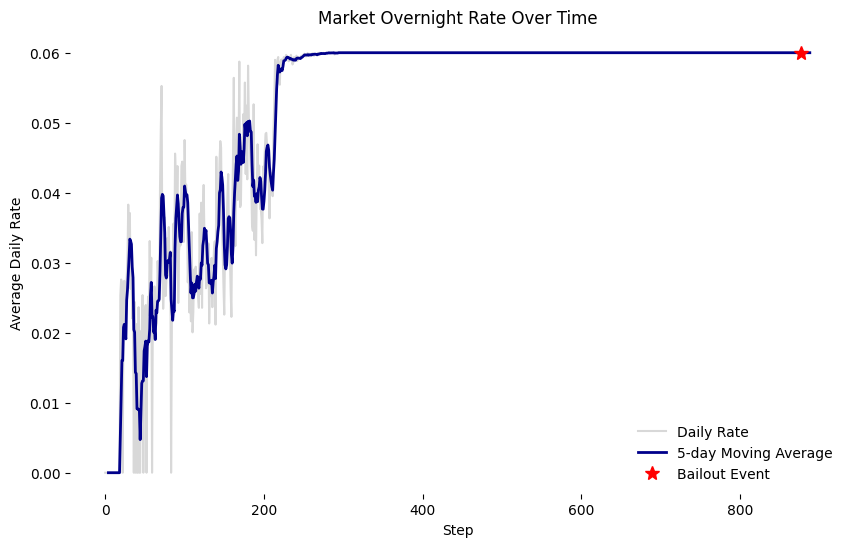

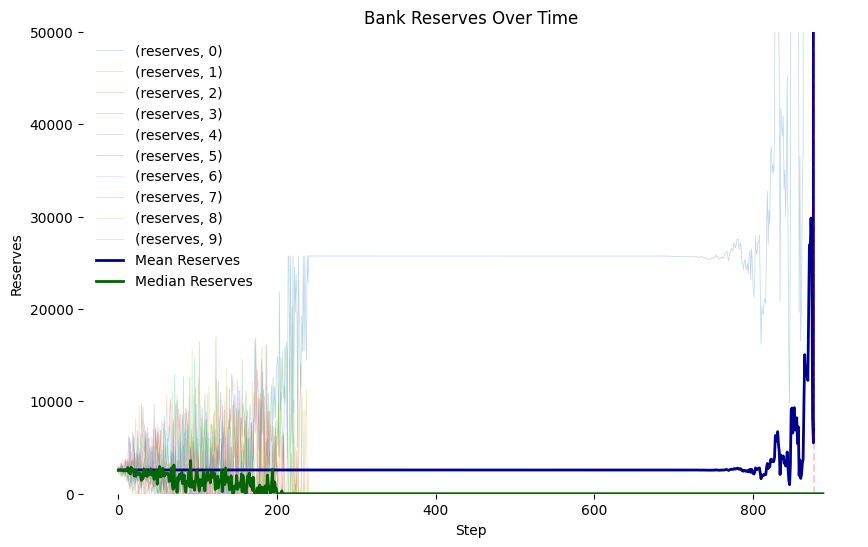

In [15]:
# For the market rate plot
plt.figure(figsize=(10, 6))
# Plot individual rates
plt.plot(financial_system_history['step'], financial_system_history['avg_daily_rate'], 
         alpha=0.3, color='gray', label='Daily Rate')
# Add rolling mean
rolling_mean = financial_system_history['avg_daily_rate'].rolling(window=5).mean()
plt.plot(financial_system_history['step'], rolling_mean, 
         color='darkblue', linewidth=2, label='5-day Moving Average')

# Add stars for bailout events
bailout_steps = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['step']
bailout_rates = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['avg_daily_rate']
plt.plot(bailout_steps, bailout_rates, '*', color='red', markersize=10, label='Bailout Event')

plt.title('Market Overnight Rate Over Time')
plt.xlabel('Step')
plt.ylabel('Average Daily Rate')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

# For the reserves plot
plt.figure(figsize=(10, 6))
bank_wide = pd.pivot_table(bank_history, index=['step'], values=['reserves'], columns=['id'])

# Plot individual bank lines with low opacity
bank_wide.plot(linewidth=0.5, alpha=0.3, legend=None, ax=plt.gca())

# Add mean and median lines
plt.plot(bank_wide.index, bank_wide.mean(axis=1), 
         color='darkblue', linewidth=2, label='Mean Reserves')
plt.plot(bank_wide.index, bank_wide.median(axis=1), 
         color='darkgreen', linewidth=2, label='Median Reserves')

# Max the bank-wide plot y axis at 500 times the initial max value
plt.ylim(0, 500 * max_balance)

# Add stars for bailout events
for step in bailout_steps:
    plt.axvline(x=step, color='red', alpha=0.2, linestyle='--')
    plt.plot(step, bank_wide.loc[step].max(), '*', color='red', markersize=10)

plt.title('Bank Reserves Over Time')
plt.xlabel('Step')
plt.ylabel('Reserves')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

These plots show the distribution of customer bank balances at the beginning of the simuation and the mean values at the end of the simulation steps.

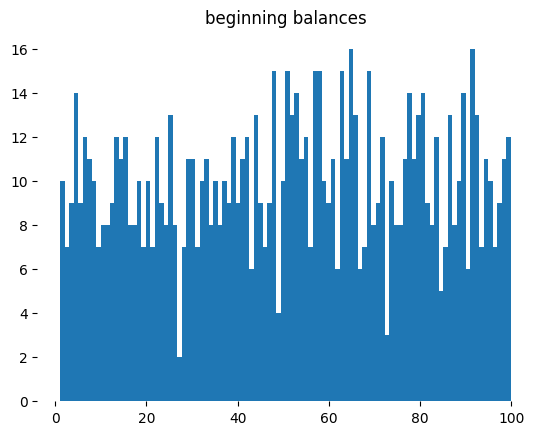

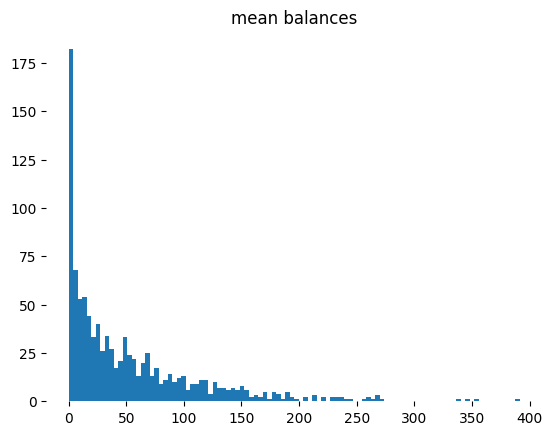

In [16]:
customer_history[customer_history['step'] == 0].hist('balance', bins = 100, grid=False)
plt.title('beginning balances')
sns.despine(left = True, bottom = True)
plt.show()

customer_history.groupby('id').mean().hist('balance', bins = 100, grid=False)
plt.title('mean balances')
sns.despine(left = True, bottom = True)

In [17]:
from IPython.display import display

display(financial_system_history)


,step,average_net_position,avg_daily_rate,average_risk_appetite,fed_recapitalization
0,0,0.000000e+00,0.00,0.000000,None
1,1,-1.212297e-04,0.00,0.193910,[]
2,2,3.905751e-04,0.00,0.193910,[]
3,3,-3.845542e-03,0.00,0.193910,[]
4,4,-8.238798e-03,0.00,0.193910,[]
...,...,...,...,...,...
884,884,-3.814471e+16,0.06,0.188856,[]
885,885,-4.300091e+16,0.06,0.188856,[]
886,886,-1.992319e+17,0.06,0.188856,[]
887,887,-2.306349e+17,0.06,0.188856,[]


This final plot shows, for each bank, mean reserve and loan values.

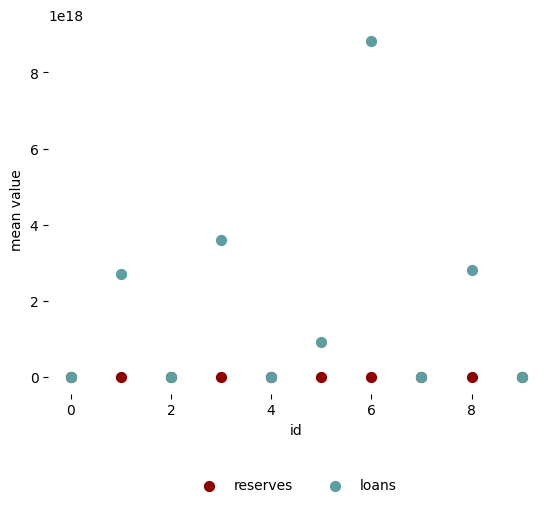

In [18]:
bank_means = bank_history[['id', 'reserves', 'loans']].groupby(by='id').mean()
bank_means = bank_means.reset_index()
ax = bank_means.plot.scatter(x = 'id', y = 'reserves', c = 'darkred', label = 'reserves', s = 50)
bank_means.plot.scatter(x = 'id', y = 'loans', c = 'cadetblue', label = 'loans', facecolors='none', s = 50, ax = ax)
plt.ylabel('mean value')
plt.legend(frameon=False, bbox_to_anchor=(0.5, -.3), loc='lower center', ncol=2)
sns.despine(left = True, bottom = True)

Letʻs see if we can discern what is happening with an animated plot

In [14]:
bank_history_output = widgets.Output()

def plot_bank_reserves_history():
    """Create an animated bar chart of bank reserves ordered by risk appetite"""
    with bank_history_output:
        clear_output(wait=True)
        plt.close('all')  # Close any existing figures
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sort banks by risk appetite
        sorted_indices = sorted(range(len(risk_appetites)), key=lambda k: risk_appetites[k])
        sorted_appetites = [risk_appetites[i] for i in sorted_indices]
        
        # Calculate y-axis limits once
        all_reserves = [r for step_data in bank_history.groupby('step')['reserves'] for r in step_data[1]]
        y_min = min(all_reserves)
        y_max = min(50000, max(all_reserves))
        
        def update(frame):
            ax.clear()
            step_data = bank_history[bank_history['step'] == frame]
            
            # Get reserves for this step, sorted by risk appetite
            reserves = [step_data[step_data['id'] == i]['reserves'].values[0] for i in sorted_indices]
            
            # Create bar plot with color gradient
            colors = plt.cm.viridis(np.linspace(0, 1, len(reserves)))
            bars = ax.bar(range(len(reserves)), reserves, color=colors)
            
            # Set static y-axis limits
            ax.set_ylim(y_min, y_max)
            
            # Customize the plot
            ax.set_title(f'Bank Reserves by Risk Appetite (Step {frame})')
            ax.set_xlabel('Banks (ordered by risk appetite)')
            ax.set_ylabel('Reserves')
            
            # Set x-ticks to show risk appetites
            ax.set_xticks(range(len(sorted_appetites)))
            ax.set_xticklabels([f'{a:.2f}' for a in sorted_appetites], rotation=45)
            
            sns.despine(left=True, bottom=True)
            plt.tight_layout()
        
        # Create animation
        global bank_history_anim
        bank_history_anim = animation.FuncAnimation(
            fig,
            update,
            frames=bank_history['step'].unique(),
            interval=200,
            repeat=False
        )
        
        # Display the animation
        display(HTML(bank_history_anim.to_jshtml()))
        plt.close()



# autorun animation
display(bank_history_output)
plot_bank_reserves_history()




Output()